In [18]:
from google.colab import drive
drive.mount('/content/drive')                                                                                                                                                                                                                       

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
%ls -a

./  ../  .config/  drive/  LightGBM/  sample_data/


In [2]:
!git clone --recursive https://github.com/Microsoft/LightGBM
%cd /content/LightGBM/
!mkdir build
!cmake -DUSE_GPU=1 #avoid ..
!make -j$(nproc)
!sudo apt-get -y install python-pip
!sudo -H pip install setuptools pandas numpy scipy scikit-learn -U
%cd /content/LightGBM/python-package
!sudo python setup.py install --precompile

Cloning into 'LightGBM'...
remote: Enumerating objects: 137, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 15057 (delta 75), reused 72 (delta 35), pack-reused 14920
Receiving objects: 100% (15057/15057), 10.50 MiB | 8.29 MiB/s, done.
Resolving deltas: 100% (10831/10831), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'compute'
Cloning into '/content/LightGBM/compute'...
remote: Enumerating objects: 21728, done.        
remote: Total 21728 (delta 0), reused 0 (delta 0), pack-reused 21728        
Receiving objects: 100% (21728/21728), 8.51 MiB | 5.78 MiB/s, done.
Resolving deltas: 100% (17565/17565), done.
Submodule path 'compute': checked out '36c89134d4013b2e5e45bc55656a18bd6141995a'
/content/LightGBM
-- The C compiler identification is GNU 7.4.0
-- The CXX compiler identification is GNU 7.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compi

In [3]:
#%cp -rp '/content/drive/My Drive/ta-lib/' ~/
%cd ~
!rm -rf ta-lib*
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
#%cd '/content/drive/My Drive/ta-lib'
#%cd ta-lib
import os
#os.chdir('/content/drive/My Drive/ta-lib') # Can't use !cd in co-lab
os.chdir('ta-lib') # Can't use !cd in co-lab
#%cd ~/ta-lib
!./configure --prefix=/usr
#! '/content/drive/My Drive/ta-lib/configure' --prefix=/usr
!make
!make install
!pip install Ta-Lib
%cd /content

/root
--2019-11-28 10:20:29--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 216.105.38.13
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|216.105.38.13|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2019-11-28 10:20:29--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 216.105.38.13
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: https://iweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2019-11-28 10:20:29--  https://iweb.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving iweb.dl.sourcefo

In [19]:
!pip install optuna
!pip install joblib
!pip install catboost
!pip install six
#!pip --no-cache-dir install lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"
#!pip install lightgbm --install-option=--GPU
#!sudo pip --no-cache-dir install -I lightgbm --install-option=--gpu --install-option="--opencl-include-dir=/usr/local/cuda/include/" --install-option="--opencl-library=/usr/local/cuda/lib64/libOpenCL.so"

import lightgbm as lgb
import xgboost as xgb
import catboost as cat
from catboost import Pool
from catboost import CatBoost
from sklearn import datasets
import dateutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
import csv
import matplotlib.pyplot as plt
from scipy.spatial.distance import correlation
import numpy as np
import pandas as pd
#from multiprocessing import Pool, Value, Array
import multiprocessing as multi
from joblib import Parallel, delayed
import talib as ta
from datetime import datetime, timedelta, timezone
import sklearn.metrics
from sklearn.model_selection import train_test_split
from functools import partial
import optuna
import joblib
from joblib import Parallel, delayed
import time
import random

In [0]:
class OneMinData:
    def initialize(self):
        self.func_dict = {}  # key = [func_name + term], val = (function object, term)
        self.index_data_dict = {}  # key= [func_name + term]], val = [index data]
        self.unix_time = []
        self.dt = []
        self.open = []
        self.high = []
        self.low = []
        self.close = []
        self.open_change = []
        self.high_change = []
        self.low_change = []
        self.close_change = []
        self.size = []
        self.future_side = []

    def cut_data(self, num_data):
        for k in self.index_data_dict:
            self.index_data_dict[k] = self.index_data_dict[k][-num_data:]
        self.unix_time = self.unix_time[-num_data:]
        self.dt = self.dt[-num_data:]
        self.open = self.open[-num_data:]
        self.high = self.high[-num_data:]
        self.low = self.low[-num_data:]
        self.close = self.close[-num_data:]
        self.open_change = self.open_change[-num_data:]
        self.high_change = self.high_change[-num_data:]
        self.low_change = self.low_change[-num_data:]
        self.close_change = self.close_change[-num_data:]
        self.size = self.size[-num_data:]
        self.future_side = self.future_side[-num_data:]

    def cut_data2(self, from_ind, to_ind):
        for k in self.index_data_dict:
            self.index_data_dict[k] = self.index_data_dict[k][from_ind:to_ind]
        self.unix_time = self.unix_time[from_ind:to_ind]
        self.dt = self.dt[from_ind:to_ind]
        self.open = self.open[from_ind:to_ind]
        self.high = self.high[from_ind:to_ind]
        self.low = self.low[from_ind:to_ind]
        self.close = self.close[from_ind:to_ind]
        self.open_change = self.open_change[from_ind:to_ind]
        self.high_change = self.high_change[from_ind:to_ind]
        self.low_change = self.low_change[from_ind:to_ind]
        self.close_change = self.close_change[from_ind:to_ind]
        self.size = self.size[from_ind:to_ind]
        self.future_side = self.future_side[from_ind:to_ind]

    def del_data(self, num_remain_data):
        if len(self.dt) > num_remain_data:
            for k in self.index_data_dict:
                del self.index_data_dict[k][:-num_remain_data]
            del self.unix_time[:-num_remain_data]
            del self.dt[:-num_remain_data]
            del self.open[:-num_remain_data]
            del self.high[:-num_remain_data]
            del self.low[:-num_remain_data]
            del self.close[:-num_remain_data]
            del self.open_change[:-num_remain_data]
            del self.high_change[:-num_remain_data]
            del self.low_change[:-num_remain_data]
            del self.close_change[:-num_remain_data]
            del self.size[:-num_remain_data]
            del self.future_side[:-num_remain_data]

    def extract_data(self, ex_from, to):
        if len(self.dt) > ex_from:
            for k in self.index_data_dict:
                del self.index_data_dict[k][-ex_from:-to]
            del self.unix_time[-ex_from:-to]
            del self.dt[-ex_from:-to]
            del self.open[-ex_from:-to]
            del self.high[-ex_from:-to]
            del self.low[-ex_from:-to]
            del self.close[-ex_from:-to]
            del self.open_change[-ex_from:-to]
            del self.high_change[-ex_from:-to]
            del self.low_change[-ex_from:-to]
            del self.close_change[-ex_from:-to]
            del self.size[-ex_from:-to]
            del self.future_side[-ex_from:-to]

    def add_and_pop(self, unix_time, dt, open, high, low, close, size):
        self.unix_time.append(unix_time)
        self.unix_time.pop(0)
        self.dt.append(dt)
        self.dt.pop(0)
        self.open.append(open)
        self.open.pop(0)
        self.high.append(high)
        self.high.pop(0)
        self.low.append(low)
        self.low.pop(0)
        self.close.append(close)
        self.close.pop(0)
        self.open_change.append(open)
        self.open_change.pop(0)
        self.high_change.append(high)
        self.high_change.pop(0)
        self.low_change.append(low)
        self.low_change.pop(0)
        self.close_change.append(close)
        self.close_change.pop(0)
        self.size.append(size)
        self.size.pop(0)

In [0]:

class OneMinMarketData:
    @classmethod
    def initialize_for_bot(cls, num_term, from_ind, to_ind, kijun_val, kijun_period):
        cls.num_term = num_term
        cls.kijun_val = kijun_val
        cls.kijun_period = kijun_period
        cls.term_list = cls.generate_term_list(num_term)
        cls.ohlc = cls.read_from_csv('/content/drive/My Drive/mex_data.csv')
        cls.ohlc.cut_data2(from_ind, to_ind)
        cls.__generate_all_func_dict()
        cls.__calc_all_index_dict()
        
    @classmethod
    def update_for_bot(cls):
        cls.__calc_all_index()
        

    @classmethod
    def read_from_csv(cls, file_name):
        ohlc = OneMinData()
        ohlc.initialize()
        df = pd.read_csv(file_name)
        ohlc.dt = list(map(lambda x: datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S'), list(df['dt'])))
        ohlc.unix_time = list(df['timestamp'])
        ohlc.open = list(df['open'])
        ohlc.high = list(df['high'])
        ohlc.low = list(df['low'])
        ohlc.close = list(df['close'])
        ohlc.size = list(df['volume'])
        return ohlc
    
    
    @classmethod
    def write_all_func_dict(cls):
        with open('/content/drive/My Drive/Model/bpsp_cols.csv', 'w') as file:
            writer = csv.writer(file, lineterminator='\n')
            writer.writerow(list(cls.ohlc.func_dict.keys()))
        print('completed write bpsp columns')
        
        
    @classmethod
    def read_func_dict(cls):
        #read from func / term list
        cols = []
        with open('/content/drive/My Drive/Model/bpsp_cols.csv', 'r') as f:
            reader = csv.reader(f)
            for r in reader:
                cols.append(r)
        #copy matched key func val
        func_obj= {}
        for col in cols[0]:
            if col not in ['open', 'high', 'low', 'close']:
                func_obj[col] = cls.ohlc.func_dict[col]
        #replace ohlc.func_dict
        cls.ohlc.func_dict = func_obj
    
    
    
    '''
    generate all func / term as a dict
    calc all index as a dict
    generate df from the index data dict
    calc correlation
    remove correlated columns
    renew fund / term dict with non-correlated func / term
    calc index data of the renewed dict
    '''
    
    @classmethod
    def __generate_all_func_dict(cls):
        for term in cls.term_list:
            cls.ohlc.func_dict['ema:'+str(term)] = (OneMinMarketData.calc_ema,term)
            #cls.ohlc.func_dict['ema_kairi:'+str(term)] = (OneMinMarketData.calc_ema_kairi,term)
            #cls.ohlc.func_dict['ema_gra:'+str(term)] = (OneMinMarketData.calc_ema_gra,term)
            cls.ohlc.func_dict['dema:'+str(term)] = (OneMinMarketData.calc_dema,term)
            #cls.ohlc.func_dict['dema_kairi:'+str(term)] = (OneMinMarketData.calc_dema_kairi,term)
            #cls.ohlc.func_dict['dema_gra:'+str(term)] = (OneMinMarketData.calc_dema_gra,term)
            cls.ohlc.func_dict['momentum:'+str(term)] = (OneMinMarketData.calc_momentum,term)
            cls.ohlc.func_dict['rate_of_change:'+str(term)] = (OneMinMarketData.calc_rate_of_change,term)
            cls.ohlc.func_dict['rsi:'+str(term)] = (OneMinMarketData.calc_rsi,term)
            cls.ohlc.func_dict['williams_R:'+str(term)] = (OneMinMarketData.calc_williams_R,term)
            cls.ohlc.func_dict['beta:'+str(term)] = (OneMinMarketData.calc_beta,term)
            cls.ohlc.func_dict['time_series_forecast:'+str(term)] = (OneMinMarketData.calc_time_series_forecast,term)
            cls.ohlc.func_dict['correl:'+str(term)] = (OneMinMarketData.calc_correl,term)
            cls.ohlc.func_dict['linear_reg:'+str(term)] = (OneMinMarketData.calc_linear_reg,term)
            cls.ohlc.func_dict['linear_reg_angle:'+str(term)] = (OneMinMarketData.calc_linear_reg_angle,term)
            cls.ohlc.func_dict['linear_reg_intercept:'+str(term)] = (OneMinMarketData.calc_linear_reg_intercept,term)
            cls.ohlc.func_dict['linear_reg_slope:'+str(term)] = (OneMinMarketData.calc_linear_reg_slope,term)
            cls.ohlc.func_dict['stdv:'+str(term)] = (OneMinMarketData.calc_stdv,term)
            cls.ohlc.func_dict['var:'+str(term)] = (OneMinMarketData.calc_var,term)
            cls.ohlc.func_dict['adx:'+str(term)] = (OneMinMarketData.calc_adx,term)
            cls.ohlc.func_dict['aroon_os:'+str(term)] = (OneMinMarketData.calc_aroon_os,term)
            cls.ohlc.func_dict['cci:'+str(term)] = (OneMinMarketData.calc_cci,term)
            cls.ohlc.func_dict['dx:'+str(term)] = (OneMinMarketData.calc_dx,term)
            if term >= 10:
                cls.ohlc.func_dict['macd:'+str(term)] = (OneMinMarketData.calc_macd,term)
                cls.ohlc.func_dict['macd_signal:'+str(term)] = (OneMinMarketData.calc_macd_signal,term)
                cls.ohlc.func_dict['macd_hist:'+str(term)] = (OneMinMarketData.calc_macd_hist,term)
                '''
            cls.ohlc.func_dict['makairi_momentum:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_momentum, term)
            cls.ohlc.func_dict['makairi_rate_of_change:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_rate_of_change, term)
            cls.ohlc.func_dict['makairi_rsi:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_rsi, term)
            cls.ohlc.func_dict['makairi_williams_R:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_williams_R, term)
            cls.ohlc.func_dict['makairi_beta:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_beta, term)
            cls.ohlc.func_dict['makairi_time_series_forecast:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_time_series_forecast, term)
            cls.ohlc.func_dict['makairi_correl:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_correl, term)
            cls.ohlc.func_dict['makairi_linear_reg:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_linear_reg, term)
            cls.ohlc.func_dict['makairi_linear_reg_angle:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_linear_reg_angle, term)
            cls.ohlc.func_dict['makairi_linear_reg_intercept:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_linear_reg_intercept, term)
            cls.ohlc.func_dict['makairi_linear_reg_slope:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_linear_reg_slope, term)
            cls.ohlc.func_dict['makairi_stdv:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_stdv, term)
            cls.ohlc.func_dict['makairi_var:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_var, term)
            cls.ohlc.func_dict['makairi_adx:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_adx, term)
            cls.ohlc.func_dict['makairi_aroon_os:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_aroon_os, term)
            cls.ohlc.func_dict['makairi_cci:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_cci, term)
            cls.ohlc.func_dict['makairi_dx:'+str(term)] = (OneMinMarketData.generate_makairi,OneMinMarketData.calc_dx, term)
            
            cls.ohlc.func_dict['diff_momentum:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_momentum, term)
            cls.ohlc.func_dict['diff_rate_of_change:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_rate_of_change, term)
            cls.ohlc.func_dict['diff_rsi:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_rsi, term)
            cls.ohlc.func_dict['diff_williams_R:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_williams_R, term)
            cls.ohlc.func_dict['diff_beta:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_beta, term)
            cls.ohlc.func_dict['diff_time_series_forecast:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_time_series_forecast, term)
            cls.ohlc.func_dict['diff_correl:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_correl, term)
            cls.ohlc.func_dict['diff_linear_reg:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_linear_reg, term)
            cls.ohlc.func_dict['diff_linear_reg_angle:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_linear_reg_angle, term)
            cls.ohlc.func_dict['diff_linear_reg_intercept:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_linear_reg_intercept, term)
            cls.ohlc.func_dict['diff_linear_reg_slope:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_linear_reg_slope, term)
            cls.ohlc.func_dict['diff_stdv:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_stdv, term)
            cls.ohlc.func_dict['diff_var:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_var, term)
            cls.ohlc.func_dict['diff_adx:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_adx, term)
            cls.ohlc.func_dict['diff_aroon_os:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_aroon_os, term)
            cls.ohlc.func_dict['diff_cci:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_cci, term)
            cls.ohlc.func_dict['diff_dx:'+str(term)] = (OneMinMarketData.generate_diff,OneMinMarketData.calc_dx, term)
            '''
        cls.ohlc.func_dict['normalized_ave_true_range:'+str(0)] = (OneMinMarketData.calc_normalized_ave_true_range,0)
        cls.ohlc.func_dict['three_outside_updown:'+str(0)] = (OneMinMarketData.calc_three_outside_updown,0)
        cls.ohlc.func_dict['breakway:'+str(0)] = (OneMinMarketData.calc_breakway,0)
        cls.ohlc.func_dict['dark_cloud_cover:'+str(0)] = (OneMinMarketData.calc_dark_cloud_cover,0)
        cls.ohlc.func_dict['dragonfly_doji:'+str(0)] = (OneMinMarketData.calc_dragonfly_doji,0)
        cls.ohlc.func_dict['updown_sidebyside_white_lines:'+str(0)] = (OneMinMarketData.calc_updown_sidebyside_white_lines,0)
        cls.ohlc.func_dict['haramisen:'+str(0)] = (OneMinMarketData.calc_haramisen,0)
        cls.ohlc.func_dict['hikkake_pattern:'+str(0)] = (OneMinMarketData.calc_hikkake_pattern,0)
        cls.ohlc.func_dict['neck_pattern:'+str(0)] = (OneMinMarketData.calc_neck_pattern,0)
        cls.ohlc.func_dict['upsidedownside_gap_three_method:'+str(0)] = (OneMinMarketData.calc_upsidedownside_gap_three_method,0)
        cls.ohlc.func_dict['sar:'+str(0)] = (OneMinMarketData.calc_sar,0)
        cls.ohlc.func_dict['bop:'+str(0)] = (OneMinMarketData.calc_bop,0)
        
        
    @classmethod
    def __calc_all_index_dict(cls):
        print('calculating all index dict')
        start_time = time.time()

        #cls.calc_ohlc_change()

        for k in cls.ohlc.func_dict:
            if int(k.split(':')[1]) > 0:
                if k.split('_')[0] != 'makairi' and k.split('_')[0] != 'diff' and  k.split(':')[0] not in ['ema_kairi', 'ema_gra', 'dema_kairi', 'dema_gra']:
                    cls.ohlc.index_data_dict[k] = cls.ohlc.func_dict[k][0](cls.ohlc.func_dict[k][1])
            else:
                cls.ohlc.index_data_dict[k] = cls.ohlc.func_dict[k][0]()
        print('completed non makairi diff index. time=', time.time() - start_time)

        start_time = time.time()
        for k in cls.ohlc.func_dict:
            if k.split('_')[0] == 'makairi':
                data = cls.ohlc.func_dict[k][1](cls.ohlc.func_dict[k][2])
                cls.ohlc.index_data_dict[k] = cls.ohlc.func_dict[k][0](data, cls.ohlc.func_dict[k][2])
            elif k.split('_')[0] == 'diff':
                data = cls.ohlc.func_dict[k][1](cls.ohlc.func_dict[k][2])
                cls.ohlc.index_data_dict[k] = cls.ohlc.func_dict[k][0](data)

        cls.ohlc.future_side = cls.calc_future_side()
        print('completed calc makairi diff index. time=', time.time() - start_time)

            
            
    @classmethod
    def genrate_df_from_dict(cls):
        start_time = time.time()
        cut_size = cls.term_list[-1] + 1
        end = len(cls.ohlc.close) - cls.kijun_period #due to bpsp
        OneMinMarketData.ohlc.index_data_dict['dt'] = cls.ohlc.dt
        OneMinMarketData.ohlc.index_data_dict['size'] = cls.ohlc.size
        OneMinMarketData.ohlc.index_data_dict['close'] = cls.ohlc.close
        df = pd.DataFrame(OneMinMarketData.ohlc.index_data_dict)
        '''
        df = df.assign(dt=cls.ohlc.dt)
        df = df.assign(open=cls.ohlc.open)
        df = df.assign(high=cls.ohlc.high)
        df = df.assign(low=cls.ohlc.low)
        df = df.assign(close=cls.ohlc.close)
        df = df.assign(open_change=cls.ohlc.open_change)
        df = df.assign(high_change=cls.ohlc.high_change)
        df = df.assign(low_change=cls.ohlc.low_change)
        df = df.assign(close_change=cls.ohlc.close_change)
        df = df.assign(size=cls.ohlc.size)
        '''
        df = df.iloc[cut_size:end] 
        #df['future_side'] = cls.ohlc.future_side[cut_size:]
        df = df.assign(future_side=cls.ohlc.future_side[cut_size:])
        print('completed generate df from dict. time=', time.time() - start_time)
        return df


    @classmethod
    def remove_cols_contains_nan(cls,  df):
        start_time = time.time()
        remove_cols = []
        tmp = df.copy()
        for col in tmp.columns:
            for ind,d in enumerate(tmp[col]):
                if str(d) =='nan':
                    remove_cols.append(col)
                    break
        if len(remove_cols) > 0:
            df.drop(remove_cols, axis=1, inplace=True)
            print('removed ', len(remove_cols), ' cols contains nan.')
        print('completed remove cols contains nan. time=', time.time() - start_time)
        return df
        
    @classmethod
    def remove_cols_contains_nan2(cls, df):
        start_time = time.time()
        pre_n = len(df.columns)
        after_n = len(df.dropna(axis = 1, how = 'any').columns)
        print('removed ', pre_n - after_n, 'cols contains nan.')
        print('completed remove cols contains nan. time=', time.time() - start_time)
        return df.dropna(axis = 1, how = 'any')

    @classmethod
    def __calc_all_index(cls):
        start_time = time.time()
        cls.ohlc.ave_price = cls.calc_ave_price(cls.ohlc.open, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
        for term in cls.term_list:
            cls.ohlc.ema[term] = cls.calc_ema(term, cls.ohlc.close)
            cls.ohlc.ema_kairi[term] = cls.calc_ema_kairi(cls.ohlc.close, cls.ohlc.ema[term])
            cls.ohlc.ema_gra[term] = cls.calc_ema_gra(cls.ohlc.ema[term])
            cls.ohlc.dema[term] = cls.calc_dema(term, cls.ohlc.close)
            cls.ohlc.dema_kairi[term] = cls.calc_dema_kairi(cls.ohlc.close, cls.ohlc.dema[term])
            cls.ohlc.dema_gra[term] = cls.calc_dema_gra(cls.ohlc.dema[term])
            cls.ohlc.momentum[term] = cls.calc_momentum(term, cls.ohlc.close)
            cls.ohlc.rate_of_change[term] = cls.calc_rate_of_change(term, cls.ohlc.close)
            cls.ohlc.rsi[term] = cls.calc_rsi(term, cls.ohlc.close)
            cls.ohlc.williams_R[term] = cls.calc_williams_R(term, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
            cls.ohlc.beta[term] = cls.calc_beta(term, cls.ohlc.high, cls.ohlc.low)
            cls.ohlc.tsf[term] = cls.calc_time_series_forecast(term, cls.ohlc.close)
            cls.ohlc.correl[term] = cls.calc_correl(term, cls.ohlc.high, cls.ohlc.low)
            cls.ohlc.linear_reg[term] = cls.calc_linear_reg(term, cls.ohlc.close)
            cls.ohlc.linear_reg_angle[term] = cls.calc_linear_reg_angle(term, cls.ohlc.close)
            cls.ohlc.linear_reg_intercept[term] = cls.calc_linear_reg_intercept(term, cls.ohlc.close)
            cls.ohlc.linear_reg_slope[term] = cls.calc_linear_reg_slope(term, cls.ohlc.close)
            cls.ohlc.stdv[term] = cls.calc_stdv(term, cls.ohlc.close)
            cls.ohlc.var[term] = cls.calc_var(term, cls.ohlc.close)
            cls.ohlc.linear_reg_ave[term] = cls.calc_linear_reg(term, cls.ohlc.ave_price)
            cls.ohlc.linear_reg_angle_ave[term] = cls.calc_linear_reg_angle(term, cls.ohlc.ave_price)
            cls.ohlc.linear_reg_intercept_ave[term] = cls.calc_linear_reg_intercept(term, cls.ohlc.ave_price)
            cls.ohlc.linear_reg_slope_ave[term] = cls.calc_linear_reg_slope(term, cls.ohlc.ave_price)
            cls.ohlc.stdv_ave[term] = cls.calc_stdv(term, cls.ohlc.ave_price)
            cls.ohlc.var_ave[term] = cls.calc_var(term, cls.ohlc.ave_price)
            cls.ohlc.adx[term] = cls.calc_adx(term, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
            cls.ohlc.aroon_os[term] = cls.calc_aroon_os(term, cls.ohlc.high, cls.ohlc.low)
            cls.ohlc.cci[term] = cls.calc_cci(term, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
            cls.ohlc.dx[term] = cls.calc_dx(term, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
            if term >= 10:
                cls.ohlc.macd[term], cls.ohlc.macdsignal[term], cls.ohlc.macdhist[term] = cls.calc_macd(cls.ohlc.close, int(float(term) / 2.0), term, int(float(term) / 3.0))
                cls.ohlc.macd[term] = list(cls.ohlc.macd[term])
                cls.ohlc.macdsignal[term] = list(cls.ohlc.macdsignal[term])
                cls.ohlc.macdhist[term] = list(cls.ohlc.macdhist[term])
                cls.ohlc.macd_ave[term], cls.ohlc.macdsignal_ave[term], cls.ohlc.macdhist_ave[term] = cls.calc_macd(cls.ohlc.ave_price, int(float(term) / 2.0), term,int(float(term) / 3.0))
                cls.ohlc.macd_ave[term] = list(cls.ohlc.macd_ave[term])
                cls.ohlc.macdsignal_ave[term] = list(cls.ohlc.macdsignal_ave[term])
                cls.ohlc.macdhist_ave[term] = list(cls.ohlc.macdhist_ave[term])
        cls.ohlc.normalized_ave_true_range = cls.calc_normalized_ave_true_range(cls.ohlc.high, cls.ohlc.low,
                                                                                cls.ohlc.close)
        cls.ohlc.three_outside_updown = cls.calc_three_outside_updown(cls.ohlc.open, cls.ohlc.high, cls.ohlc.low,
                                                                      cls.ohlc.close)
        cls.ohlc.breakway = cls.calc_breakway(cls.ohlc.open, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
        cls.ohlc.dark_cloud_cover = cls.calc_dark_cloud_cover(cls.ohlc.open, cls.ohlc.high, cls.ohlc.low,
                                                              cls.ohlc.close)
        cls.ohlc.dragonfly_doji = cls.calc_dragonfly_doji(cls.ohlc.open, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
        cls.ohlc.updown_sidebyside_white_lines = cls.calc_updown_sidebyside_white_lines(cls.ohlc.open, cls.ohlc.high,
                                                                                        cls.ohlc.low, cls.ohlc.close)
        cls.ohlc.haramisen = cls.calc_haramisen(cls.ohlc.open, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
        cls.ohlc.hikkake_pattern = cls.calc_hikkake_pattern(cls.ohlc.open, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
        cls.ohlc.neck_pattern = cls.calc_neck_pattern(cls.ohlc.open, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
        cls.ohlc.upsidedownside_gap_three_method = cls.calc_upsidedownside_gap_three_method(cls.ohlc.open,
                                                                                            cls.ohlc.high, cls.ohlc.low,
                                                                                            cls.ohlc.close)
        cls.ohlc.sar = cls.calc_sar(cls.ohlc.high, cls.ohlc.low, 0.02, 0.2)
        cls.ohlc.bop = cls.calc_bop(cls.ohlc.open, cls.ohlc.high, cls.ohlc.low, cls.ohlc.close)
        #cls.ohlc.bp, cls.ohlc.sp = cls.calc_pl_ls_points()

        #generate various index
        for term in cls.term_list:
            cls.ohlc.various_makairi['emakairi'+str(term)] = cls.ohlc.ema_kairi[term]
            cls.ohlc.various_makairi['demakairi' + str(term)] = cls.ohlc.dema_kairi[term]
            cls.ohlc.various_diff['emadiff'+str(term)] = cls.ohlc.ema_kairi[term]
            cls.ohlc.various_diff['demadiff' + str(term)] = cls.ohlc.dema_kairi[term]
            cls.ohlc.various_makairi['momkairi' + str(term)] = cls.ohlc.momentum[term]
            cls.ohlc.various_diff['momdiff' + str(term)] = cls.ohlc.momentum[term]
            cls.ohlc.various_makairi['rsikairi' + str(term)] = cls.ohlc.rsi[term]
            cls.ohlc.various_diff['rsidiff' + str(term)] = cls.ohlc.rsi[term]
            cls.ohlc.various_makairi['williams_Rkairi' + str(term)] = cls.ohlc.williams_R[term]
            cls.ohlc.various_diff['williams_Rdiff' + str(term)] = cls.ohlc.williams_R[term]
            cls.ohlc.various_makairi['betakairi' + str(term)] = cls.ohlc.beta[term]
            cls.ohlc.various_diff['betadiff' + str(term)] = cls.ohlc.beta[term]
            cls.ohlc.various_makairi['linear_regkairi' + str(term)] = cls.ohlc.linear_reg[term]
            cls.ohlc.various_diff['linear_regdiff' + str(term)] = cls.ohlc.linear_reg[term]
            cls.ohlc.various_makairi['linear_reg_slopekairi' + str(term)] = cls.ohlc.linear_reg_slope[term]
            cls.ohlc.various_diff['linear_reg_slopediff' + str(term)] = cls.ohlc.linear_reg_slope[term]
            cls.ohlc.various_makairi['adxkairi' + str(term)] = cls.ohlc.adx[term]
            cls.ohlc.various_diff['adxdiff' + str(term)] = cls.ohlc.adx[term]
            cls.ohlc.various_makairi['aroon_oskairi' + str(term)] = cls.ohlc.aroon_os[term]
            cls.ohlc.various_diff['aroon_osdiff' + str(term)] = cls.ohlc.aroon_os[term]
            cls.ohlc.various_makairi['ccikairi' + str(term)] = cls.ohlc.cci[term]
            cls.ohlc.various_diff['ccidiff' + str(term)] = cls.ohlc.cci[term]
            if term >= 10:
                cls.ohlc.various_makairi['macdkairi' + str(term)] = cls.ohlc.macd[term]
                cls.ohlc.various_diff['macddiff' + str(term)] = cls.ohlc.macd[term]
                cls.ohlc.various_makairi['macdsignalkairi' + str(term)] = cls.ohlc.macdsignal[term]
                cls.ohlc.various_diff['macdsignaldiff' + str(term)] = cls.ohlc.macdsignal[term]
                cls.ohlc.various_makairi['macdhistkairi' + str(term)] = cls.ohlc.macdhist[term]
                cls.ohlc.various_diff['macdhistdiff' + str(term)] = cls.ohlc.macdhist[term]
        cls.ohlc.future_side = cls.calc_future_side()
        print('calc all index1 time={}'.format(time.time() - start_time))


    @classmethod
    def generate_raw_df(cls):
        def __change_dict_key(d, col_name):
            newd = dict(map(lambda k: (col_name + str(k), d[k][:]), d.keys()))
            return newd
        '''data_dict = {'dt':cls.ohlc.dt[:], 'open':cls.ohlc.open[:], 'high':cls.ohlc.high[:],'low':cls.ohlc.low[:],
                    'close':cls.ohlc.close[:], 'size':cls.ohlc.size[:], 'normalized_ave_true_range':cls.ohlc.normalized_ave_true_range[:],
                    'sar':cls.ohlc.sar[:],'bop':cls.ohlc.bop[:]}'''
        data_dict = {'dt': cls.ohlc.dt[:], 'open': cls.ohlc.open[:], 'high': cls.ohlc.high[:], 'low': cls.ohlc.low[:],
                     'close': cls.ohlc.close[:], 'size': cls.ohlc.size[:],
                     'normalized_ave_true_range': cls.ohlc.normalized_ave_true_range[:],
                     'three_outside_updown': cls.ohlc.three_outside_updown[:], 'breakway': cls.ohlc.breakway[:],
                     'dark_cloud_cover': cls.ohlc.dark_cloud_cover[:],
                     'dragonfly_doji': cls.ohlc.dragonfly_doji[:],
                     'three_oupdown_sidebyside_white_linesutside_updown': cls.ohlc.updown_sidebyside_white_lines[:],
                     'haramisen': cls.ohlc.haramisen[:], 'haramhikkake_patternisen': cls.ohlc.hikkake_pattern[:],
                     'neck_pattern': cls.ohlc.neck_pattern[:],
                     'upsidedownside_gap_three_method': cls.ohlc.upsidedownside_gap_three_method[:],
                     'sar': cls.ohlc.sar[:], 'bop': cls.ohlc.bop[:]}
        data_dict = {**data_dict, **__change_dict_key(cls.ohlc.ema, 'ema'),
                     **__change_dict_key(cls.ohlc.ema_ave, 'ema_ave'),
                     **__change_dict_key(cls.ohlc.ema_kairi, 'ema_kairi'),
                     **__change_dict_key(cls.ohlc.dema_kairi, 'dema_kairi'),
                     **__change_dict_key(cls.ohlc.ema_gra, 'ema_gra'), **__change_dict_key(cls.ohlc.dema, 'dema'),
                     **__change_dict_key(cls.ohlc.dema_ave, 'dema_ave'),
                     **__change_dict_key(cls.ohlc.dema_gra, 'dema_gra'),
                     **__change_dict_key(cls.ohlc.midprice, 'midprice'),
                     **__change_dict_key(cls.ohlc.momentum, 'momentum'),
                     **__change_dict_key(cls.ohlc.momentum_ave, 'momentum_ave'),
                     **__change_dict_key(cls.ohlc.rate_of_change, 'rate_of_change'),
                     **__change_dict_key(cls.ohlc.rsi, 'rsi'), **__change_dict_key(cls.ohlc.williams_R, 'williams_R'),
                     **__change_dict_key(cls.ohlc.beta, 'beta'), **__change_dict_key(cls.ohlc.tsf, 'tsf'),
                     **__change_dict_key(cls.ohlc.correl, 'correl'),
                     **__change_dict_key(cls.ohlc.linear_reg, 'linear_reg'),
                     **__change_dict_key(cls.ohlc.linear_reg_angle, 'linear_reg_angle'),
                     **__change_dict_key(cls.ohlc.linear_reg_intercept, 'linear_reg_intercept'),
                     **__change_dict_key(cls.ohlc.linear_reg_slope, 'linear_reg_slope'),
                     **__change_dict_key(cls.ohlc.stdv, 'stdv'), **__change_dict_key(cls.ohlc.var, 'var'),
                     **__change_dict_key(cls.ohlc.linear_reg_ave, 'linear_reg_ave'),
                     **__change_dict_key(cls.ohlc.linear_reg_angle_ave, 'linear_reg_angle_ave'),
                     **__change_dict_key(cls.ohlc.linear_reg_intercept_ave, 'linear_reg_intercept_ave'),
                     **__change_dict_key(cls.ohlc.linear_reg_slope_ave, 'linear_reg_slope_ave'),
                     **__change_dict_key(cls.ohlc.stdv_ave, 'stdv_ave'),
                     **__change_dict_key(cls.ohlc.var_ave, 'var_ave'), **__change_dict_key(cls.ohlc.adx, 'adx'),
                     **__change_dict_key(cls.ohlc.aroon_os, 'aroon_os'),
                     **__change_dict_key(cls.ohlc.cci, 'cci'), **__change_dict_key(cls.ohlc.dx, 'dx'),
                     **__change_dict_key(cls.ohlc.macd, 'macd'),
                     **__change_dict_key(cls.ohlc.macdsignal, 'macdsignal'),
                     **__change_dict_key(cls.ohlc.macdhist, 'macdhist'),
                     **__change_dict_key(cls.ohlc.macd_ave, 'macd_ave'),
                     **__change_dict_key(cls.ohlc.macdsignal_ave, 'macdsignal_ave'),
                     **__change_dict_key(cls.ohlc.macdhist_ave, 'macdhist_ave'),
                     ** __change_dict_key(cls.ohlc.various_makairi, 'various_makairi'),
                     **__change_dict_key(cls.ohlc.various_diff, 'various_diff')}
        df = pd.DataFrame.from_dict(data_dict)
        return df

    '''
    dema, adx, macdはnum_term * 2くらいnanが発生する
    print(df.isnull().sum())
    '''

    @classmethod
    def generate_df(cls):
        def __change_dict_key(d, col_name):
            newd = dict(map(lambda k: (col_name + '_'+str(k), d[k][cut_size:end]), d.keys()))
            return newd

        start_time = time.time()
        cut_size = cls.term_list[-1] * 2
        end = len(cls.ohlc.close) - 10 #remove last 700min data as future bp / sp maybe not precise in
        data_dict = {'dt': cls.ohlc.dt[cut_size:end], 'open': cls.ohlc.open[cut_size:end],
                     'high': cls.ohlc.high[cut_size:end], 'low': cls.ohlc.low[cut_size:end],
                     'close': cls.ohlc.close[cut_size:end], 'size': cls.ohlc.size[cut_size:end],
                     'normalized_ave_true_range': cls.ohlc.normalized_ave_true_range[cut_size:end],
                     'three_outside_updown': cls.ohlc.three_outside_updown[cut_size:end],
                     'breakway': cls.ohlc.breakway[cut_size:end],
                     'dark_cloud_cover': cls.ohlc.dark_cloud_cover[cut_size:end],
                     'dragonfly_doji': cls.ohlc.dragonfly_doji[cut_size:end],
                     'three_oupdown_sidebyside_white_linesutside_updown': cls.ohlc.updown_sidebyside_white_lines[
                                                                          cut_size:end],
                     'haramisen': cls.ohlc.haramisen[cut_size:end],
                     'haramhikkake_patternisen': cls.ohlc.hikkake_pattern[cut_size:end],
                     'neck_pattern': cls.ohlc.neck_pattern[cut_size:end],
                     'upsidedownside_gap_three_method': cls.ohlc.upsidedownside_gap_three_method[cut_size:end],
                     'sar': cls.ohlc.sar[cut_size:end], 'bop': cls.ohlc.bop[cut_size:end]}
        data_dict = {**data_dict, **__change_dict_key(cls.ohlc.ema, 'ema'),
                     **__change_dict_key(cls.ohlc.ema_ave, 'ema_ave'),
                     **__change_dict_key(cls.ohlc.ema_kairi, 'ema_kairi'),
                     **__change_dict_key(cls.ohlc.dema_kairi, 'dema_kairi'),
                     **__change_dict_key(cls.ohlc.ema_gra, 'ema_gra'), **__change_dict_key(cls.ohlc.dema, 'dema'),
                     **__change_dict_key(cls.ohlc.dema_ave, 'dema_ave'),
                     **__change_dict_key(cls.ohlc.dema_gra, 'dema_gra'),
                     **__change_dict_key(cls.ohlc.midprice, 'midprice'),
                     **__change_dict_key(cls.ohlc.momentum, 'momentum'),
                     **__change_dict_key(cls.ohlc.momentum_ave, 'momentum_ave'),
                     **__change_dict_key(cls.ohlc.rate_of_change, 'rate_of_change'),
                     **__change_dict_key(cls.ohlc.rsi, 'rsi'), **__change_dict_key(cls.ohlc.williams_R, 'williams_R'),
                     **__change_dict_key(cls.ohlc.beta, 'beta'), **__change_dict_key(cls.ohlc.tsf, 'tsf'),
                     **__change_dict_key(cls.ohlc.correl, 'correl'),
                     **__change_dict_key(cls.ohlc.linear_reg, 'linear_reg'),
                     **__change_dict_key(cls.ohlc.linear_reg_angle, 'linear_reg_angle'),
                     **__change_dict_key(cls.ohlc.linear_reg_intercept, 'linear_reg_intercept'),
                     **__change_dict_key(cls.ohlc.linear_reg_slope, 'linear_reg_slope'),
                     **__change_dict_key(cls.ohlc.stdv, 'stdv'), **__change_dict_key(cls.ohlc.var, 'var'),
                     **__change_dict_key(cls.ohlc.linear_reg_ave, 'linear_reg_ave'),
                     **__change_dict_key(cls.ohlc.linear_reg_angle_ave, 'linear_reg_angle_ave'),
                     **__change_dict_key(cls.ohlc.linear_reg_intercept_ave, 'linear_reg_intercept_ave'),
                     **__change_dict_key(cls.ohlc.linear_reg_slope_ave, 'linear_reg_slope_ave'),
                     **__change_dict_key(cls.ohlc.stdv_ave, 'stdv_ave'),
                     **__change_dict_key(cls.ohlc.var_ave, 'var_ave'), **__change_dict_key(cls.ohlc.adx, 'adx'),
                     **__change_dict_key(cls.ohlc.aroon_os, 'aroon_os'),
                     **__change_dict_key(cls.ohlc.cci, 'cci'), **__change_dict_key(cls.ohlc.dx, 'dx'),
                     **__change_dict_key(cls.ohlc.macd, 'macd'),
                     **__change_dict_key(cls.ohlc.macdsignal, 'macdsignal'),
                     **__change_dict_key(cls.ohlc.macdhist, 'macdhist'),
                     **__change_dict_key(cls.ohlc.macd_ave, 'macd_ave'),
                     **__change_dict_key(cls.ohlc.macdsignal_ave, 'macdsignal_ave'),
                     **__change_dict_key(cls.ohlc.macdhist_ave, 'macdhist_ave'),
                     **__change_dict_key(cls.ohlc.various_makairi, 'various_makairi'),
                     **__change_dict_key(cls.ohlc.various_diff, 'various_diff')}
        data_dict['bpsp'] = cls.ohlc.bpsp[cut_size:end]
#        data_dict['bp'] = cls.ohlc.bp[cut_size:end]
#        data_dict['sp'] = cls.ohlc.sp[cut_size:end]
        df = pd.DataFrame.from_dict(data_dict)
        return df

    @classmethod
    def generate_term_list(cls, num):
        term_list = []
        category_n = [5, 50, 200]
        term_list.extend(list(np.round(np.linspace(category_n[0], category_n[0] * num, num))))
        term_list.extend(list(np.round(np.linspace(category_n[1] + (category_n[0] * num),category_n[1] + (category_n[0] * num) + category_n[1] * num), num)))
        term_list.extend(list(np.round(np.linspace(category_n[2] + category_n[1] + (category_n[0] * num) + (category_n[1] * num),category_n[2] + (category_n[1] * num) + category_n[2] * num), num)))
        return list(map(int, term_list))

    @classmethod
    def detect_max_term(cls):
        max_term = 0
        cols = []
        with open("./Model/bpsp_cols.csv", "r") as f:
            reader = csv.reader(f)
            for r in reader:
                cols.append(r)
        for col in cols[0]:
            if col not in ['open', 'high', 'low', 'close']:
                if max_term < int(col.split(':')[1]):
                    max_term = int(col.split(':')[1])
        return max_term


    @classmethod
    def calc_ohlc_change(cls):
        cls.ohlc.open_change.append(0)
        cls.ohlc.high_change.append(0)
        cls.ohlc.low_change.append(0)
        cls.ohlc.close_change.append(0)
        for i in range(len(cls.ohlc.close)-1):
            close = cls.ohlc.close[i]
            cls.ohlc.open_change.append(round(cls.ohlc.open[i+1] / close,5))
            cls.ohlc.high_change.append(round(cls.ohlc.high[i + 1] / close, 5))
            cls.ohlc.low_change.append(round(cls.ohlc.low[i + 1] / close, 5))
            cls.ohlc.close_change.append(round(cls.ohlc.close[i + 1] / close,5))


     #kairi of data
    @classmethod
    def generate_makairi(cls, data, ma_term):
        ma = np.array(list(ta.MA(np.array(data, dtype='f8'), timeperiod=ma_term)),dtype='f8')
        return list(map(lambda c, e: (c - e) / e, np.array(data, dtype='f8'), ma))

    @classmethod
    def generate_diff(cls, data):
        return list(ta.ROC(np.array(data, dtype='f8'), timeperiod=1))
        #return [0] + list(np.diff(np.array(data, dtype='f8')))


    #points of long can get pt before lc and vice versa
    @classmethod
    def calc_pl_ls_points(cls):  # both pl and ls should be plus val as abs
        buy_points = []
        sell_points = []
        print(cls.pt)
        for i in range(len(cls.ohlc.close)):
            entry_p = cls.ohlc.open[i]
            j = 0
            while True: #loop for bp
                if i+ j < len(cls.ohlc.close):
                    if -cls.lc >= cls.ohlc.low[i+j] - entry_p: #lc before pt for buy
                        buy_points.append(0)
                        break
                    elif cls.pt <= cls.ohlc.high[i+j] - entry_p:
                        buy_points.append(1)
                        break
                else:
                    buy_points.append(0)
                    break
                j +=1
            j = 0
            while True: #loop for sp
                if i+ j < len(cls.ohlc.close):
                    if -cls.lc >= entry_p - cls.ohlc.high[i+j]: #lc before pt for buy
                        sell_points.append(0)
                        break
                    elif cls.pt <= entry_p - cls.ohlc.low[i+j]:
                        sell_points.append(1)
                        break
                else:
                    sell_points.append(0)
                    break
                j +=1
        return buy_points, sell_points
    
    
    #higher pl in next 1m for bp sp
    @classmethod
    def calc_bpsp_points(cls):
        bpsp = [] #0: buy, 1:sell
        for i in range(1, len(cls.ohlc.close)):
            if cls.ohlc.close[i] - cls.ohlc.close[i-1] > cls.ohlc.close[i-1] - cls.ohlc.close[i]:
                bpsp.append(1)
            else:
                bpsp.append(0)
        bpsp.append(None)
        return bpsp
        

    @classmethod
    def calc_bpsp_points2(cls):
        bp = []
        sp = []
        for i in range(len(cls.ohlc.close) - cls.kijun_period):
            flg_buy = 0
            flg_sell = 0
            entry_p = cls.ohlc.close[i]
            j = 0
            for j in range(cls.kijun_period):
                if i+j < len(cls.ohlc.close):
                    if cls.ohlc.close[i+j] - entry_p >= cls.kijun_val:
                        flg_buy = 1
                    if entry_p - cls.ohlc.close[i+j] >= cls.kijun_val:
                        flg_sell = 1
                else:
                    break
            bp.append(flg_buy)
            sp.append(flg_sell)
        return bp, sp


    @classmethod
    def calc_future_side(cls):
        future_side = []
        num_buy = 0
        num_sell = 0
        num_no = 0
        num_both = 0
        for i in range(len(cls.ohlc.close) - cls.kijun_period):
            buy_max = 0
            sell_max = 0
            entry_p = cls.ohlc.close[i]
            for j in range(cls.kijun_period):
                buy_max = max(buy_max, cls.ohlc.close[i+j] - entry_p)
                sell_max = max(sell_max, entry_p - cls.ohlc.close[i+j])
            if buy_max >= cls.kijun_val and sell_max >= cls.kijun_val:
                future_side.append('both')
                num_both += 1
            elif buy_max >= cls.kijun_val and sell_max < cls.kijun_val:
                future_side.append('buy')
                num_buy += 1
            elif buy_max < cls.kijun_val and sell_max >= cls.kijun_val:
                future_side.append('sell')
                num_sell += 1
            elif buy_max < cls.kijun_val and sell_max < cls.kijun_val:
                future_side.append('no')
                num_no += 1

        print('future_side allocation in Market Data:')
        tsum = float(len(future_side))
        print('no:', round(float(num_no) / tsum, 4), 'buy:', round(float(num_buy) / tsum, 4), 'sell:', round(float(num_sell) / tsum, 4), 'both:', round(float(num_both) / tsum, 4))
        return future_side

    @classmethod
    def remove_all_correlated_cols(cls, df, corr_kijun):
        def remove_high_corr_cols(df, col_name, kijun):
            remove_cols = []
            num_corr = 0
            for i in range(len(df.columns) - 1):
                if df.columns[i] != col_name and df.columns[i] != 'dt':
                    corr = df[col_name].corr(df[df.columns[i]])
                    if corr > kijun and df.columns[i] not in ['open', 'high', 'low', 'close', 'size', 'future_side']:
                        num_corr += 1
                        remove_cols.append(df.columns[i])
            if len(remove_cols) > 0:
                df.drop(remove_cols, axis = 1, inplace = True)
                print('removed '+str(num_corr) + 'cols', ' total cols='+str(len(df.columns)))
            print('completed remove all correlated cols. time=', time.time() - start_time)
            return df

        nt= 0
        df2 = df.copy()
        while True:
            if len(df2.columns) <= nt:
                print('kita')
                break
            elif df2.columns[nt] != 'dt':
                df2 = remove_high_corr_cols(df2, df2.columns[nt], corr_kijun)
            nt += 1
        return df2

    
    @classmethod
    def remove_all_correlated_cols2(self, df, corr_kijun):
        print('removing all correlated columns..')
        df2 = df.copy()
        df3 = df.copy()
        df2.drop(['dt'], axis=1, inplace=True)
        #corrs = np.corrcoef(np.array(df2).transpose())
        corrs = np.corrcoef(np.array(df2))
        remove_cols = []
        cols = list(df2.columns)
        for cor in corrs:
            for i in range(len(cor)):
                if cor[i] != 1.0 and cor[i] > corr_kijun:
                    if cols[i] not in remove_cols and cols[i] not in ['open', 'high', 'low', 'close', 'size', 'future_side']:
                        remove_cols.append(cols[i])
        df3.drop(remove_cols, axis=1, inplace=True)
        print('removed '+str(len(remove_cols))+' colums')
        print(remove_cols)
        return df3, corrs
    
    @classmethod
    def remove_all_correlated_cols3(self, df, corr_kijun):
        print('removing all correlated columns..')
        start_time = time.time()
        df2 = df.copy()
        df3 = df.copy()
        df2.drop(['dt','future_side'], axis=1, inplace=True)
        corrs = np.corrcoef(np.array(df2).transpose())

        # 1. 0番目から0.9以上のindexを検索
        def check_corr_kijun(cor, cor_ind, kijun):
            rem = []
            for i, c in enumerate(cor):
                if c >= kijun and i != cor_ind:
                    rem.append(i)
            return rem

        tmp_remo = []
        for i, cor in enumerate(corrs):
            if i not in tmp_remo:  # 3. 該当indexを除いて次のindexを対象に1の操作を実行
                # 2. 該当したindexをtmp_remoに記録
                tmp_remo.extend(check_corr_kijun(cor, i, corr_kijun))
        
        cols = list(df2.columns)
        for col in cols:
            cor = 1 - correlation(df2['close'], df2[col])
            if cor >= corr_kijun:
                tmp_remo.extend(col)

        # 4. tmp_remoに記録されたindexのcolumnをdfから削除
        target_col = []
        cols = list(df2.columns)
        for tr in tmp_remo:
            target_col.append(cols[tr])
        excludes = ['dt', 'open', 'high', 'low', 'close', 'close_change', 'dt', 'future_side']
        for ex in excludes:
            if ex in target_col:
                target_col.remove(ex)
        df3.drop(target_col, axis=1, inplace=True)
        print('removed ' + str(len(target_col)) + ' colums', 'remaining col=' + str(len(df3.columns)))
        print('completed remove all correlated cols3. time=', time.time() - start_time)
        return df3, corrs
                    

    @classmethod
    def remove_all_correlated_cols4(cls, df, corr_kijun):
        print('removing all correlated columns..')
        start_time = time.time()
        dff = df.copy()
        dff.drop(['dt','future_side'], axis=1, inplace=True)
        cols = list(dff.columns)
        df_res = df.copy()
        corr_matrix = np.corrcoef(np.array(dff).transpose())
        df_new = pd.DataFrame(data=corr_matrix, index=cols, columns=cols, dtype='float')
        upper = df_new.where(np.triu(np.ones(df_new.shape), k=1).astype(np.bool))
        to_drop = [column for column in upper.columns if any(upper[column] > corr_kijun)]
        excludes = ['dt', 'open', 'high', 'low', 'close', 'close_change', 'future_side', 'size']
        for ex in excludes:
            if ex in to_drop:
                to_drop.remove(ex)
        df_res.drop(to_drop, axis=1, inplace=True)
        print('removed ' + str(len(to_drop)) + ' colums', 'remaining col=' + str(len(df_res.columns)))
        print('completed remove all correlated cols4. time=', time.time() - start_time)
        return df_res


    @classmethod
    def remove_price_dependent_cols(cls, df):
        print('removing all price dependent columns..')
        max_ind = np.array(list(df['close'])).argmax()
        min_ind = np.array(list(df['close'])).argmin()
        cols = list(df.columns)
        target_cols = []
        for col in cols:
            if abs(np.array(df[col]).argmax() - max_ind) <= 10 and abs(np.array(df[col]).argmin() - min_ind) <= 10:
                target_cols.append(col)
        excludes = ['dt', 'open', 'high', 'low', 'close', 'close_change', 'future_side']
        for ex in excludes:
            if ex in target_cols:
                target_cols.remove(ex)
        df.drop(target_cols, axis=1, inplace=True)
        print('removed ' + str(len(target_cols)) + ' colums', 'remaining col=' + str(len(df.columns)))
        return df

    @classmethod
    def remove_price_dependent_cols2(cls, df, corr_kijun):
        print('removing all price dependent columns..')
        dff = df.copy()
        df_res = df.copy()
        dff.drop(['dt','future_side'], axis=1, inplace=True)
        cols = list(dff.columns)
        to_drop = []
        for col in cols:
            corr = np.corrcoef(dff['close'], dff[col], rowvar=False)[1][0]
            if corr > corr_kijun:
                to_drop.append(col)
        excludes = ['dt', 'open', 'high', 'low', 'close', 'future_side', 'size']
        for ex in excludes:
            if ex in to_drop:
                to_drop.remove(ex)
        df_res.drop(to_drop, axis=1, inplace=True)
        print('removed ' + str(len(to_drop)) + ' colums', 'remaining col=' + str(len(df.columns)))
        return df_res



    @classmethod
    def calc_hist_high(cls, term, high, close):
        res = []
        for i in range(len(high) - term):
            res.append((max(high[i:i + term]) / close[i]) - 1)
        return res

    @classmethod
    def calc_hist_low(cls, term, low, close):
        res = []
        for i in range(len(low) - term):
            res.append((min(low[i:i + term]) / close[i]) - 1)
        return res

    @classmethod
    def calc_high_kairi(cls, term):
        #res = [0 * term]
        ind = list(range(len(cls.ohlc.high)-term))
        #max_val = list(map(lambda i: max(cls.ohlc.high[i-term:i]), ind)
        #list(map(lambda i: cls.ohlc.high[i+term] / max_val[i], list(range(len(cls.ohlc.high))))

    @classmethod
    def calc_ema(cls, term):
        return list(ta.EMA(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    
    @classmethod
    def calc_ema_kairi(cls, term):
        return list(map(lambda c, e: (c - e) / e, np.array(cls.ohlc.close, dtype='f8'), np.array(cls.ohlc.index_data_dict['ema:'+str(term)], dtype='f8')))

    @classmethod
    def calc_dema_kairi(cls, term):
        return list(map(lambda c, d: (c - d) / d, np.array(cls.ohlc.close, dtype='f8'), np.array(cls.ohlc.index_data_dict['dema:'+str(term)], dtype='f8')))

    @classmethod
    def calc_ema_gra(cls, term):
        return list(pd.Series(cls.ohlc.index_data_dict['ema:'+str(term)]).diff())

    @classmethod
    def calc_dema_gra(cls, term):
        return list(pd.Series(cls.ohlc.index_data_dict['dema:'+str(term)]).diff())

    @classmethod
    def calc_dema(cls, term):
        return list(ta.DEMA(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    #termの2倍くらいnanが続く
    @classmethod
    def calc_adx(cls, term):
        return list(
            ta.ADX(np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_aroon_os(cls, term):
        return list(ta.AROONOSC(np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_cci(cls, term):
        return list(
            ta.CCI(np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_dx(cls, term):
        return list(
            ta.DX(np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_midprice(cls, term, high, low):
        return list(ta.MIDPRICE(np.array(high, dtype='f8'), np.array(low, dtype='f8'), timeperiod=term))

    
    @classmethod
    def calc_macd(cls, term):
        slowperiod = term
        fastperiod= int(term / 2.0)
        signalperiod=int(term / 3.0)
        macd, signal, hist =  ta.MACD(np.array(cls.ohlc.close, dtype='f8'), np.array(fastperiod, dtype='i8'), np.array(slowperiod, dtype='i8'), np.array(signalperiod, dtype='i8'))
        return macd
    
    @classmethod
    def calc_macd_signal(cls, term):
        slowperiod = term
        fastperiod= int(term / 2.0)
        signalperiod=int(term / 3.0)
        macd, signal, hist =  ta.MACD(np.array(cls.ohlc.close, dtype='f8'), np.array(fastperiod, dtype='i8'), np.array(slowperiod, dtype='i8'),
                       np.array(signalperiod, dtype='i8'))
        return signal
    
    @classmethod
    def calc_macd_hist(cls, term):
        slowperiod = term
        fastperiod= int(term / 2.0)
        signalperiod=int(term / 3.0)
        macd, signal, hist = ta.MACD(np.array(cls.ohlc.close, dtype='f8'), np.array(fastperiod, dtype='i8'), np.array(slowperiod, dtype='i8'),
                       np.array(signalperiod, dtype='i8'))
        return hist

    @classmethod
    def calc_momentum(cls, term):
        return list(ta.MOM(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_rate_of_change(cls, term):
        return list(ta.ROC(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_rsi(cls, term):
        return list(ta.RSI(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_williams_R(cls, term):
        return list(ta.WILLR(np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), np.array(cls.ohlc.close, dtype='f8'),timeperiod=term))

    @classmethod
    def calc_beta(cls, term):
        return list(ta.BETA(np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_time_series_forecast(cls, term):
        return list(ta.TSF(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_correl(cls, term):
        return list(ta.CORREL(np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_linear_reg(cls, term):
        return list(ta.LINEARREG(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_linear_reg_angle(cls, term):
        return list(ta.LINEARREG_ANGLE(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_linear_reg_intercept(cls, term):
        return list(ta.LINEARREG_SLOPE(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_linear_reg_slope(cls, term):
        return list(ta.LINEARREG_INTERCEPT(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term))

    @classmethod
    def calc_stdv(cls, term):
        return list(ta.STDDEV(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term, nbdev=1))

    @classmethod
    def calc_var(cls, term):
        return list(ta.VAR(np.array(cls.ohlc.close, dtype='f8'), timeperiod=term, nbdev=1))

    @classmethod
    def calc_normalized_ave_true_range(cls):
        return list(ta.NATR(np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), np.array(cls.ohlc.close, dtype='f8')))

    @classmethod
    def calc_three_outside_updown(cls):
        return list(ta.CDL3OUTSIDE(np.array(cls.ohlc.open, dtype='f8'), np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'),
                                   np.array(cls.ohlc.close, dtype='f8')))

    @classmethod
    def calc_breakway(cls):
        return list(ta.CDLBREAKAWAY(np.array(cls.ohlc.open, dtype='f8'), np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'),
                                    np.array(cls.ohlc.close, dtype='f8')))

    @classmethod
    def calc_dark_cloud_cover(cls):
        return list(ta.CDLDARKCLOUDCOVER(np.array(cls.ohlc.open, dtype='f8'), np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'),
                                 np.array(cls.ohlc.close, dtype='f8'), penetration=0))

    @classmethod
    def calc_dragonfly_doji(cls):
        return list(ta.CDLDRAGONFLYDOJI(np.array(cls.ohlc.open, dtype='f8'), np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'),
                                np.array(cls.ohlc.close, dtype='f8')))

    @classmethod
    def calc_updown_sidebyside_white_lines(cls):
        return list(
            ta.CDLGAPSIDESIDEWHITE(np.array(cls.ohlc.open, dtype='f8'), np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'),
                                   np.array(cls.ohlc.close, dtype='f8')))

    @classmethod
    def calc_haramisen(cls):
        return list(ta.CDLHARAMI(np.array(cls.ohlc.open, dtype='f8'), np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), np.array(cls.ohlc.close, dtype='f8')))

    @classmethod
    def calc_hikkake_pattern(cls):
        return list(ta.CDLHIKKAKEMOD(np.array(cls.ohlc.open, dtype='f8'), np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'),np.array(cls.ohlc.close, dtype='f8')))

    @classmethod
    def calc_neck_pattern(cls):
        return list(ta.CDLINNECK(np.array(cls.ohlc.open, dtype='f8'), np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), np.array(cls.ohlc.close, dtype='f8')))

    @classmethod
    def calc_sar(cls):
        accelation = 0.02
        maximum = 0.2
        return list(ta.SAR(np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'), np.array(accelation, dtype='f8'), np.array(maximum, dtype='f8')))

    @classmethod
    def calc_bop(cls):
        return list(ta.BOP(np.array(cls.ohlc.open, dtype='f8'), np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'),np.array(cls.ohlc.close, dtype='f8')))

    @classmethod
    def calc_upsidedownside_gap_three_method(cls):
        return list(ta.CDLXSIDEGAP3METHODS(np.array(cls.ohlc.open, dtype='f8'), np.array(cls.ohlc.high, dtype='f8'), np.array(cls.ohlc.low, dtype='f8'),np.array(cls.ohlc.close, dtype='f8')))

    @classmethod
    def check_matched_index(cls, test_x):
        test = list(test_x['open'])
        op = cls.ohlc.open
        for i in range(len(op)):
            flg = True
            for j in range(30):
                if test[j] != op[i + j]:
                    flg = False
                    break
            if flg:
                return i
        print('no matche index found!')
        return -1


    @classmethod
    def check_matched_index_change(cls, test_x):
        test = list(test_x['close_change'])
        op = cls.ohlc.close_change
        for i in range(len(op)):
            flg = True
            for j in range(30):
                if test[j] != op[i + j]:
                    flg = False
                    break
            if flg:
                return i
        print('no matche index found!')
        return -1

    @classmethod
    def check_matched_dt(cls, test_x, df2):
        col = list(test_x.columns)[0]
        test_data = list(test_x[col].iloc[0:30])

        for ind,data in enumerate(df2[col]):
            if data == test_data[0]:
                if test_data == list(df2[col].iloc[ind:ind+30]):
                    return cls.ohlc.dt.index(df2['dt'].iloc[ind])
        print('matched index was not found')
        return -1


In [0]:
'''
send order with current ohlc (t)
executed with open price of (t+1), send order with ohlc(t+1)
executed with open price of (t+2), send order with ohlc(t+2)

・消す order idを記録しておいて、move to nextの最後で対象を全部消す。
・
'''


class SimAccount:
    def __init__(self):
        self.__initialize_order()
        self.__initialize_holding()

        self.log_data_list = []
        self.log_data_df = pd.DataFrame()

        self.base_margin_rate = 1.2
        self.leverage = 4.0
        self.slip_page = 0
        self.fee = 0.00015
        self.force_loss_cut_rate = 0.5
        self.initial_asset = 1500
        self.order_cancel_delay = 1
        self.ls_penalty = 0

        self.pl_kijun = 0
        self.ls_kijun = 0

        self.total_pl = 0
        self.realized_pl = 0
        self.current_pl = 0
        self.num_trade = 0
        self.num_sell = 0
        self.num_buy = 0
        self.num_win = 0
        self.win_rate = 0
        self.asset = self.initial_asset

        self.dt_log = []
        self.i_log = []
        self.order_log = []
        self.holding_log = []
        self.total_pl_log = []
        self.action_log = []
        self.price_log = []
        self.performance_total_pl_log = []
        self.performance_dt_log = []
        self.pl_stability = 0

        self.start_dt = ''
        self.end_dt = ''

    def __initialize_order(self):
        self.order_serial_num = 0
        self.order_serial_list = []
        self.order_serial = {}
        self.order_side ={}
        self.order_price = {}
        self.order_size = {}
        self.order_i = {}
        self.order_dt = {}
        self.order_ut = {}
        self.order_type = {}  # market / limit
        self.order_cancel = {} #True / False
        self.order_expire = {}

    def __del_order(self, target_serial):
        if target_serial in self.order_serial_list:
            self.order_serial_list.remove(target_serial)
            del self.order_serial[target_serial]
            del self.order_side[target_serial]
            del self.order_price[target_serial]
            del self.order_size[target_serial]
            del self.order_i[target_serial]
            del self.order_dt[target_serial]
            del self.order_ut[target_serial]
            del self.order_type[target_serial]  # market / limit
            del self.order_cancel[target_serial] #True / False
            del self.order_expire[target_serial]

    def __initialize_holding(self):
        self.holding_side = ''
        self.holding_price = 0
        self.holding_size = 0
        self.holding_i = 0
        self.holding_dt = ''
        self.holding_ut = 0


    def check_executions(self, i, dt, openp, high, low):
        self.__check_loss_cut(i, dt, high, low)
        self.__check_execution(i, dt, openp, high, low)
        self.__check_cancel(i, dt)
        self.__check_pl(i, dt, high, low)
        self.__check_ls(i, dt, high, low)

    def move_to_next(self, i, dt, openp, high, low, close):
        if len(str(self.start_dt)) < 3:
            self.start_dt = dt
        #self.__check_loss_cut(i, dt, high, low)
        #self.__check_execution(i, dt, openp, high, low)
        #self.__check_cancel(i, dt)
        #self.__check_pl(i, dt, high, low)
        #self.__check_ls(i, dt, high, low)
        if self.holding_side != '':
            self.current_pl = (close - self.holding_price) * self.holding_size if self.holding_side == 'buy' else (self.holding_price - close) * self.holding_size
        else:
            self.current_pl = 0
        self.total_pl = self.realized_pl + self.current_pl
        self.performance_total_pl_log.append(self.total_pl)
        self.performance_dt_log.append(dt)
        self.asset = self.initial_asset + self.total_pl
        self.price_log.append(close)
        # self.__add_log('i:'+str(i), i)

    def last_day_operation(self, i, dt, openp, high, low, close):
        self.__check_loss_cut(i, dt, high, low)
        self.__check_execution(i, dt, openp, high, low)
        self.__check_cancel(i, dt)
        if self.holding_side != '':
            self.realized_pl += (close - self.holding_price) * self.holding_size if self.holding_side == 'buy' else (self.holding_price - close) * self.holding_size
        self.total_pl = self.realized_pl
        self.num_trade += 1
        self.total_pl_log.append(self.total_pl)
        self.performance_total_pl_log.append(self.total_pl)
        self.performance_dt_log.append(dt)
        if self.num_trade > 0:
            self.win_rate = round(float(self.num_win) / float(self.num_trade), 4)
        self.__add_log('Sim Finished.', i, dt)
        self.end_dt = dt
        self.__calc_pl_stability()
        self.log_data_df = pd.DataFrame.from_dict(self.log_data_list, orient='columns')

    def entry_order(self, side, price, size, type, expire, pl, ls, i, dt):
        if side == 'buy':
            self.num_buy += 1
        elif side == 'sell':
            self.num_sell += 1
        
        self.order_serial[self.order_serial_num] = self.order_serial_num
        self.order_side[self.order_serial_num] =side
        self.order_price[self.order_serial_num] = price
        self.order_size[self.order_serial_num] = size
        self.order_i[self.order_serial_num] = i
        self.order_dt[self.order_serial_num] = dt
        self.order_ut[self.order_serial_num] = 0
        self.order_type[self.order_serial_num] = type  # limit, market
        self.order_cancel[self.order_serial_num] = False
        self.order_expire[self.order_serial_num] = expire
        self.pl_kijun = pl
        self.ls_kijun = ls
        self.order_serial_list.append(self.order_serial_num)
        self.order_serial_num += 1
        self.__add_log('entry order' + side + ' type=' + type, i, dt)

    def __update_holding(self, side, price, size, pl, ls, i, dt):
        self.holding_side = side
        self.holding_price = price
        self.holding_size = size
        self.holding_i = i
        self.holding_dt = dt
        self.pl_kijun = pl
        self.ls_kijun = ls

    #always cancel latest order
    def cancel_order(self, i, dt, ut):
        num = self.order_serial_list[-1]
        if self.order_type[num] != 'losscut' and self.order_cancel[num] == False:
            self.order_cancel[num] = True
            self.order_i[num] = i
            self.order_dt[num] = dt
            self.order_ut[num] = ut

    def __check_cancel(self, i, dt):
        ks = list(self.order_cancel.keys())
        for k in ks:
            if k in self.order_cancel:
                if self.order_cancel[k]:
                    self.__del_order(k)
                    self.__add_log('order cancelled.', i, dt)

    def __check_expiration(self, i, dt):
        ks = list(self.order_i.keys())
        for k in ks:
            if k in self.order_type[k]:
                if i - self.order_i[k] >= self.order_expire[k] and self.order_type[k] == 'limit':
                    self.__del_order(k)
                    self.__add_log('order expired.', i, dt)

    '''
    直前のpredictionが反対出なければpl判定させずにholdした方が効率的
    '''
    def __check_pl(self, i, dt, high, low):
        if self.holding_side != '' and self.pl_kijun > 0:
            if self.holding_side == 'buy' and self.holding_price + self.pl_kijun <= high:
                self.__add_log('pl executed.', i, dt)
                self.__calc_executed_pl(self.holding_price + self.pl_kijun, self.holding_size, i)
                self.__initialize_holding()
                # self.__update_holding(self.holding_side, self.holding_price + self.pl_kijun + 100, self.holding_size, self.pl_kijun, self.ls_kijun, True, i, dt, ut)
            if self.holding_side == 'sell' and self.holding_price - self.pl_kijun >= low:
                self.__add_log('pl executed.', i, dt)
                self.__calc_executed_pl(self.holding_price - self.pl_kijun, self.holding_size, i)
                self.__initialize_holding()
                # self.__update_holding(self.holding_side, self.holding_price - self.pl_kijun - 100, self.holding_size, self.pl_kijun, self.ls_kijun, True, i, dt, ut)

    def __check_ls(self, i, dt, ut, tick_price):
        if self.holding_side != '' and self.ls_kijun > 0:
            if self.holding_side == 'buy' and self.holding_price - self.ls_kijun >= tick_price:
                self.__add_log('ls executed.', i, dt, ut, tick_price)
                #self.__calc_executed_pl(self.holding_price - self.ls_kijun - self.ls_penalty, self.holding_size, i)
                self.__calc_executed_pl(self.holding_price - self.ls_kijun, self.holding_size, i)
                self.__initialize_holding()
            if self.holding_side == 'sell' and self.holding_price + self.ls_kijun <= tick_price:
                self.__add_log('ls executed.', i, dt, ut, tick_price)
                #self.__calc_executed_pl(self.holding_price + self.ls_kijun + self.ls_penalty, self.holding_size, i)
                self.__calc_executed_pl(self.holding_price + self.ls_kijun, self.holding_size, i)
                self.__initialize_holding()

    def __check_execution(self, i, dt, openp, high, low):
        ks = list(self.order_i.keys())
        for k in ks:
            if k in self.order_side:
                if self.order_side[k] != '' and self.order_i[k] < i:
                    if self.order_type[k] == 'market':
                        self.__process_execution(openp, i, dt, k)
                        self.__del_order(k)
                    elif self.order_type[k] == 'limit' and ((self.order_side[k] == 'buy' and self.order_price[k] >= low) or (
                            self.order_side[k] == 'sell' and self.order_price[k] <= high)):
                        self.__process_execution(self.order_price[k], i, dt)
                        self.__del_order(k)
                    elif self.order_type[k] != 'market' and self.order_type[k] != 'limit' and self.order_type[k] != 'losscut':
                        print('Invalid order type!' + self.order_type[k])
                        self.__add_log('invalid order type!' + self.order_type[k], i, dt)

    def __process_execution(self, exec_price, i, dt, k):
        if self.order_side[k] != '':
            if self.holding_side == '':  # no position
                self.__update_holding(self.order_side[k], exec_price, self.order_size[k], self.pl_kijun, self.ls_kijun, i, dt)
                self.__add_log('New Entry:' + self.order_type[k], i, dt)
            else:
                if self.holding_side == self.order_side[k]:  # order side and position side is matched
                    ave_price = round(((self.holding_price * self.holding_size) + (exec_price * self.order_size[k])) / (self.order_size[k] + self.holding_size))  # averaged holding price
                    self.__update_holding(self.holding_side, ave_price, self.order_size[k] + self.holding_size, self.pl_kijun, self.ls_kijun, i, dt)
                    self.__add_log('Additional Entry:' + self.order_type[k], i, dt)
                elif self.holding_size > self.order_size[k]:  # side is not matched and holding size > order size
                    self.__calc_executed_pl(exec_price, self.order_size[k], i)
                    self.__update_holding(self.holding_side, self.holding_price, self.holding_size - self.order_size[k], self.pl_kijun, self.ls_kijun, i, dt)
                    self.__add_log('Exit Order (h>o):' + self.order_type[k], i, dt)
                elif self.holding_size == self.order_size[k]:
                    self.__add_log('Exit Order (h=o):' + self.order_type[k], i, dt)
                    self.__calc_executed_pl(exec_price, self.order_size[k], i)
                    self.__initialize_holding()
                else:  # in case order size is bigger than holding size
                    self.__calc_executed_pl(exec_price, self.holding_size, i)
                    self.__add_log('Exit & Entry Order (h<o):' + self.holding_side, i, dt)
                    self.__update_holding(self.order_side[k], exec_price, self.order_size[k] - self.holding_size, self.pl_kijun, self.ls_kijun, i, dt)

    def __calc_executed_pl(self, exec_price, size, i):  # assume all order size was executed
        pl = (exec_price - self.holding_price * (self.fee + 1)) * size if self.holding_side == 'buy' else (self.holding_price * (1-self.fee) - exec_price) * size
        #pl = (exec_price - self.holding_price) * size if self.holding_side == 'buy' else (self.holding_price - exec_price) * size
        self.realized_pl += round(pl,4)
        self.num_trade += 1
        if pl > 0:
            self.num_win += 1

    def __check_loss_cut(self, i, dt, high, low):
        if self.holding_side != '':
            price = high if self.holding_side == 'sell' else low
            req_collateral = self.holding_size * price / self.leverage
            pl = price - self.holding_price if self.holding_side == 'buy' else self.holding_price - price
            pl = pl * self.holding_size
            margin_rate = (self.initial_asset + self.realized_pl + pl) / req_collateral
            if margin_rate <= self.force_loss_cut_rate:
                self.__force_exit(i, dt)
                self.__add_log('Loss cut postion! margin_rate=' + str(margin_rate), i, dt)

    def __force_exit(self, i, dt):
        #self.__initialize_order()
        self.entry_order('buy' if self.holding_side == 'sell' else 'sell', 0, self.holding_size, 'losscut', 10, 9999, 9999, i, dt)
        
    def __calc_pl_stability(self):
        base_line = np.linspace(self.performance_total_pl_log[0], self.performance_total_pl_log[-1],
                                num=len(self.performance_total_pl_log))
        sum_diff = 0
        for i in range(len(base_line)):
            sum_diff += (base_line[i] - self.performance_total_pl_log[i]) ** 2
        self.pl_stability = round(1.0 / ((sum_diff ** 0.5) * self.total_pl / float(len(self.performance_total_pl_log))),4)

    def __add_log(self, log, i, dt):
        self.total_pl_log.append(self.total_pl)
        self.action_log.append(log)
        self.holding_log.append(self.holding_side + ' @' + str(self.holding_price) + ' x' + str(self.holding_size))
        if len(self.order_i) > 0:
            k = self.order_serial_list[-1]
            self.order_log.append(self.order_side[k] + ' @' + str(self.order_price[k]) + ' x' + str(self.order_size[k]) + ' cancel=' + str(self.order_cancel[k]) + ' type=' + self.order_type[k])
        else:
            self.order_log.append('' + ' @' + '0' + ' x' + '0' + ' cancel=' + 'False' + ' type=' + '')
        self.i_log.append(i)
        self.dt_log.append(dt)
        if len(self.order_serial_list) > 0: 
            k=self.order_serial_list[-1]
            #print(';i={}, dt={}, action={}, holding side={}, holding price={}, holding size={}, order side={}, order price={}, order size={}, pl={}, num_trade={}'
            #.format(i, dt, log, self.holding_side, self.holding_price, self.holding_size, self.order_side[k], self.order_price[k], self.order_size[k], self.total_pl, self.num_trade))
            self.log_data_list.append({'i':i, 'dt':dt, 'action':log, 'holding_side':self.holding_side,'holding_price':self.holding_price, 'holding_size':self.holding_size, 'order_side':self.order_side[k], 'order_price':self.order_price[k], 'order_size':self.order_size[k],
                                       'total_pl':self.total_pl, 'num_trade':self.num_trade})
        else:
            #print(';i={}, dt={}, action={}, holding side={}, holding price={}, holding size={}, order side={}, order price={}, order size={}, pl={}, num_trade={}'.format(i, dt, log, self.holding_side, self.holding_price, self.holding_size, '', '0', '0', self.total_pl, self.num_trade))
            self.log_data_list.append({'i':i, 'dt':dt, 'action':log, 'holding_side':self.holding_side, 'holding_price':self.holding_price, 'holding_size':self.holding_size, 'order_side':0, 'order_price':0, 'order_size':0,
                                       'total_pl':self.total_pl, 'num_trade':self.num_trade})

In [0]:

class Strategy:
    @classmethod
    def model_prediction(cls, start_ind, bp, sp, i, ac):
        omd = OneMinMarketData
        dd = DecisionData()
        pred_side = ''
        if bp[i] == 1 and sp[i] == 0:
            pred_side = 'buy'
        elif bp[i] == 0 and sp[i] == 1:
            pred_side = 'sell'
        elif bp[i] == 0 and sp[i] == 0:
            pred_side = 'no'
        elif bp[i] == 1 and sp[i] == 1:
            pred_side = 'both'

        if ac.holding_side == '' and ac.order_side == '' and (
                pred_side == 'buy' or pred_side == 'sell'):  # no position no order
            dd.set_decision(pred_side, 0, cls.__calc_opt_size(omd.ohlc.open[start_ind + i], ac), 'market', False, 10)
        elif (ac.holding_side == 'buy' or ac.holding_side == 'sell') and (pred_side == 'buy' or pred_side == 'sell') and \
                ac.holding_side != pred_side and ac.order_side == '':
            dd.set_decision(pred_side, 0, ac.holding_size + cls.__calc_opt_size(omd.ohlc.open[start_ind + i], ac), 'market', False, 10)  # exit and re-entry
        return dd
    
    
    @classmethod
    def model_prediction_onemin(cls, start_ind, prediction, i, ac):
        dd = DecisionData()
        omd = OneMinMarketData
        pred_side ={0: 'no', 1: 'buy', 2: 'sell', 3: 'both'}[prediction[i]]

        if ac.holding_side != pred_side:
            if ac.holding_side == '' and (pred_side == 'buy' or pred_side == 'sell'):  # no position no order
                dd.set_decision(pred_side, 0, cls.__calc_opt_size(OneMinMarketData.ohlc.open[start_ind + i], ac),'market', False, 10)
            elif (ac.holding_side == 'buy' or ac.holding_side == 'sell') and (pred_side == 'buy' or pred_side == 'sell') and ac.holding_side != pred_side:
                dd.set_decision(pred_side, 0,ac.holding_size + cls.__calc_opt_size(OneMinMarketData.ohlc.open[start_ind + i], ac),'market', False, 10)  # exit and re-entry
        return dd
    
    
    @classmethod
    def model_prediction_opt(cls, time_exit, zero_three_exit_loss, zero_three_exit_profit, stdata, i, ac: SimAccount):
        dd = DecisionData()
        pred_side ={0: 'no', 1: 'buy', 2: 'sell', 3: 'both'}[stdata.prediction[i]]
        if ac.holding_side == '' and ac.order_side == '' and (pred_side == 'buy' or pred_side == 'sell'):  # no position no order
            dd.set_decision(pred_side, 0, cls.__calc_opt_size(stdata.price[i], ac), 'market', False, 10)
        elif (ac.holding_side == 'buy' or ac.holding_side == 'sell') and (pred_side == 'buy' or pred_side == 'sell') and \
                ac.holding_side != pred_side and ac.order_side != '' and ac.order_side != ac.holding_side and ac.order_type == 'limit':  # holding side != pred side and pl ordering -> cancel pl order
            dd.set_decision(pred_side, 0, 0, '', True, 10)  # cancel order
        elif (ac.holding_side == 'buy' or ac.holding_side == 'sell') and (pred_side == 'buy' or pred_side == 'sell') and ac.holding_side != pred_side and ac.order_side == '':
            dd.set_decision(pred_side, 0, ac.holding_size + cls.__calc_opt_size(stdata.price[i], ac), 'market', False, 10)  # exit and re-entry
        elif time_exit >= 60 and ac.holding_side != '' and (stdata.ut[i] - ac.holding_ut) >= time_exit and (pred_side =='no' or pred_side =='both'):
            if ac.order_side != '':
                dd.set_decision(pred_side, 0, 0, '', True, 10)  # cancel order
            else:
                dd.set_decision('buy' if ac.holding_side == 'sell' else 'sell', 0, ac.holding_size, 'market', False, 10)
        elif zero_three_exit_loss and ac.holding_side != '' and ac.current_pl < 0 and (pred_side =='no' or pred_side =='both'):
            if ac.order_side != '':
                dd.set_decision(pred_side, 0, 0, '', True, 10)  # cancel order
            else:
                dd.set_decision('buy' if ac.holding_side == 'sell' else 'sell', 0, ac.holding_size, 'market', False, 10)
        elif zero_three_exit_profit and ac.holding_side != '' and ac.current_pl > 0 and (pred_side =='no' or pred_side =='both'):
            if ac.order_side != '':
                dd.set_decision(pred_side, 0, 0, '', True, 10)  # cancel order
            else:
                dd.set_decision('buy' if ac.holding_side == 'sell' else 'sell', 0, ac.holding_size, 'market', False, 10)
        return dd
    
    
    @classmethod
    def model_bp_prediction(cls, pl, ls, stdata, i, ac):
        dd = DecisionData()
        pred_side = 'buy'  if stdata.prediction[i] == 1 else ''
        
        if ac.holding_side == '' and ac.order_side == '' and pred_side == 'buy': #no position no order
            dd.set_decision(pred_side, 0,cls.__calc_opt_size(stdata.price[i], ac), 'market', False, 10)
        return dd
    
    
    @classmethod
    def model_buysell_prediction(cls, pl, ls, stdata, i, ac):
        dd = DecisionData()
        pred_side ={0: 'no', 1: 'buy', -1: 'sell'}[stdata.prediction[i]]
        if ac.holding_side == '' and ac.order_side == '' and (pred_side == 'buy' or pred_side == 'sell') : #no position no order
            dd.set_decision(pred_side, 0,cls.__calc_opt_size(stdata.price[i], ac), 'market', False, 10)
        elif (ac.holding_side == 'buy' or ac.holding_side == 'sell') and (pred_side =='buy' or pred_side == 'sell') and ac.holding_side != pred_side and ac.order_side =='':
            dd.set_decision(pred_side, 0,ac.holding_size + cls.__calc_opt_size(stdata.price[i], ac), 'market', False, 10) #exit and re-entry
        return dd
    
    @classmethod
    def model_sp_prediction(cls, pl, ls, stdata, i, ac):
        dd = DecisionData()
        pred_side = 'sell'  if stdata.prediction[i] == 1 else ''
        
        if ac.holding_side == '' and ac.order_side == '' and pred_side == 'sell': #no position no order
            dd.set_decision(pred_side, 0,cls.__calc_opt_size(stdata.price[i], ac), 'market', False, 10)
        return dd
    
    @classmethod
    def ema_trend_follow(cls, stdata, i, ac):
        dd = DecisionData()
        pred_side = 'buy' if stdata.prediction[i] > 0 else 'sell'
        if ac.holding_side == '' and ac.order_side == '' and (pred_side == 'buy' or pred_side == 'sell') : #no position no order
            dd.set_decision(pred_side, 0,cls.__calc_opt_size(stdata.price[i], ac), 'market', False, 10)
        elif (ac.holding_side == 'buy' or ac.holding_side == 'sell') and (pred_side =='buy' or pred_side == 'sell') and \
                ac.holding_side != pred_side and ac.order_side =='':
            dd.set_decision(pred_side, 0,ac.holding_size + cls.__calc_opt_size(stdata.price[i], ac), 'market', False, 10) #exit and re-entry
        return dd
        
    @classmethod
    def ema_trend_contrarian(cls, stdata, i, ac):
        dd = DecisionData()
        pred_side = 'sell' if stdata.prediction[i] > 0 else 'buy'
        if ac.holding_side == '' and ac.order_side == '' and (pred_side == 'buy' or pred_side == 'sell') : #no position no order
            dd.set_decision(pred_side, 0,cls.__calc_opt_size(stdata.price[i], ac), 'market', False, 10)
        elif (ac.holding_side == 'buy' or ac.holding_side == 'sell') and (pred_side =='buy' or pred_side == 'sell') and \
                ac.holding_side != pred_side and ac.order_side =='':
            dd.set_decision(pred_side, 0,ac.holding_size + cls.__calc_opt_size(stdata.price[i], ac), 'market', False, 10) #exit and re-entry
        return dd
            
            
    @classmethod
    def __calc_opt_size(cls, price, ac):
        return 0.01
#        return round((ac.asset * ac.leverage) / (price * 1.0 * ac.base_margin_rate), 2)

class DecisionData:
    def __init__(self):
        self.side = ''
        self.size = 0
        self.price = 0
        self.type = 0
        self.cancel = False
        self.expire = 0  #sec

    def set_decision(self, side, price, size, type, cancel, expire):
        self.side = side
        self.price = price
        self.size = size
        self.type = type
        self.cancel = cancel
        self.expire = expire

In [0]:
'''
sim levelの最適化：
loss cut, pt, 

'''
class Sim:
    @classmethod
    def sim_model_pred(cls, start_ind, bp, sp, pt, lc, ac):
        end_i = len(bp)
        for i in range(len(bp)-1):
            dd = Strategy.model_prediction(start_ind,bp,sp,i,ac)
            if dd.side != '':
                ac.entry_order(dd.side, dd.price, dd.size, dd.type, dd.expire, 0, 0, i, OneMinMarketData.ohlc.dt[start_ind + i])
            ac.move_to_next(i, OneMinMarketData.ohlc.dt[start_ind + i], OneMinMarketData.ohlc.open[start_ind + i], OneMinMarketData.ohlc.high[start_ind + i], OneMinMarketData.ohlc.low[start_ind + i],OneMinMarketData.ohlc.close[start_ind + i])
        ac.last_day_operation(end_i, omd.ohlc.dt[start_ind + end_i], OneMinMarketData.ohlc.open[start_ind + end_i], OneMinMarketData.ohlc.high[start_ind + end_i], OneMinMarketData.ohlc.low[start_ind + end_i], OneMinMarketData.ohlc.close[start_ind + end_i])
        return ac
    
    
    @classmethod
    def sim_model_pred_onemin(cls, start_ind, prediction, pt, lc, ac):
        omd = OneMinMarketData
        for i in range(len(prediction) - 1):
            ac.check_executions(i, omd.ohlc.dt[start_ind + i], omd.ohlc.open[start_ind + i], omd.ohlc.high[start_ind + i], omd.ohlc.low[start_ind + i])
            dd = Strategy.model_prediction_onemin(start_ind, prediction, i, ac)
            if dd.side != '':
                ac.entry_order(dd.side, dd.price, dd.size, dd.type, dd.expire, pt, lc, i, omd.ohlc.dt[start_ind + i])
            ac.move_to_next(i, omd.ohlc.dt[start_ind + i], omd.ohlc.open[start_ind + i],omd.ohlc.high[start_ind + i], omd.ohlc.low[start_ind + i],omd.ohlc.close[start_ind + i])
        end_i = len(prediction) - 1
        ac.last_day_operation(end_i, omd.ohlc.dt[start_ind + end_i], omd.ohlc.open[start_ind + end_i],omd.ohlc.high[start_ind + end_i], omd.ohlc.low[start_ind + end_i],
                              omd.ohlc.close[start_ind + end_i])
        return ac



    @classmethod
    def sim_model_pred_onemin_avert(cls, start_ind, prediction, pt, lc, ac):
        omd = OneMinMarketData
        ac2 = SimAccount()
        pl_check_term = 240
        for i in range(len(prediction) - 1):
            ac.check_executions(i, omd.ohlc.dt[start_ind + i], omd.ohlc.open[start_ind + i], omd.ohlc.high[start_ind + i], omd.ohlc.low[start_ind + i])
            ac2.check_executions(i, omd.ohlc.dt[start_ind + i], omd.ohlc.open[start_ind + i], omd.ohlc.high[start_ind + i], omd.ohlc.low[start_ind + i])
            dd2 = Strategy.model_prediction_onemin(start_ind, prediction, i, ac2)
            dd = Strategy.model_prediction_onemin(start_ind, prediction, i, ac)
            if dd2.side != '':
                ac2.entry_order(dd2.side, dd2.price, dd2.size, dd2.type, dd2.expire, pt, lc, i, omd.ohlc.dt[start_ind + i]) #ac2は常にトレード
            if len(ac2.performance_total_pl_log) > pl_check_term: #pl_check_term以上のpl logが溜まったらcheckを開始
                if ac2.performance_total_pl_log[-1] - ac2.performance_total_pl_log[-pl_check_term] > 0: #check pl of ac2
                    if dd2.side != '':
                        if dd2.side != ac.holding_side:#ac2と同じポジションを取る
                            #print('i=,'i, dd2.side, ac.holding_side)
                            ac.entry_order('buy' if ac.holding_side=='sell' else 'sell', 0, 0.02, 'market', 10, pt, lc, i, omd.ohlc.dt[start_ind + i])
                        else: #ac2のddと同じときは何もしない
                            pass
                    else: #
                        if ac.holding_side != '': #ac2に合わせるためにexit all
                            ac.entry_order('buy' if ac.holding_side=='sell' else 'sell', 0, 0.01, 'market', 10, pt, lc, i, omd.ohlc.dt[start_ind + i])
                else: #ac2のpl_check_termにおけるplがマイナスの時はacでのトレードを停止
                    if ac.holding_side != '':
                        ac.entry_order('buy' if ac.holding_side=='sell' else 'sell', 0, 0.02, 'market', 10, pt, lc, i, omd.ohlc.dt[start_ind + i])
            else:#logがたまるまでは普通にトレード
                if dd.side != '':
                    ac.entry_order(dd.side, dd.price, dd.size, dd.type, dd.expire, pt, lc, i, omd.ohlc.dt[start_ind + i])
            ac.move_to_next(i, omd.ohlc.dt[start_ind + i], omd.ohlc.open[start_ind + i],omd.ohlc.high[start_ind + i], omd.ohlc.low[start_ind + i],omd.ohlc.close[start_ind + i])
            ac2.move_to_next(i, omd.ohlc.dt[start_ind + i], omd.ohlc.open[start_ind + i],omd.ohlc.high[start_ind + i], omd.ohlc.low[start_ind + i],omd.ohlc.close[start_ind + i])
        end_i = len(prediction) - 1
        ac.last_day_operation(end_i, omd.ohlc.dt[start_ind + end_i], omd.ohlc.open[start_ind + end_i],omd.ohlc.high[start_ind + end_i], omd.ohlc.low[start_ind + end_i],
                              omd.ohlc.close[start_ind + end_i])
        return ac
    
    @classmethod
    def sim_lgbmodel(cls, stdata, pl_kijun, ac):
        print('sim length:'+str(stdata.dt[0]) + str(stdata.dt[-1]))
        for i in range(len(stdata.prediction)-1):
            dd = Strategy.model_prediction(pl_kijun, stdata,i,ac)
            if dd.cancel:
                ac.cancel_order(i, stdata.dt[i],stdata.ut[i])
            elif dd.side != '':
                ac.entry_order(dd.side,dd.price,dd.size,dd.type,dd.expire,i,stdata.dt[i],stdata.ut[i],stdata.price[i])
            ac.move_to_next(i,stdata.dt[i],stdata.ut[i],stdata.price[i])
        ac.last_day_operation(len(stdata.prediction)-1,stdata.dt[len(stdata.prediction)-1],stdata.ut[len(stdata.prediction)-1],stdata.price[len(stdata.prediction)-1])
        return ac
    
    
    @classmethod
    def sim_bp(cls, stdata, pl, ls, ac):
        print('sim length:'+str(stdata.dt[0]) + str(stdata.dt[-1]))
        for i in range(len(stdata.prediction)-1):
            dd = Strategy.model_bp_prediction(pl, ls, stdata,i,ac)
            if dd.side != '':
                ac.entry_order(dd.side,dd.price,dd.size,dd.type,dd.expire,pl,ls,i,stdata.dt[i],stdata.ut[i],stdata.price[i]) #ntry_order(self, side, price, size, type, expire, pl, ls, i, dt, ut, tick_price):
            ac.move_to_next(i,stdata.dt[i],stdata.ut[i],stdata.price[i])
        ac.last_day_operation(len(stdata.prediction)-1,stdata.dt[len(stdata.prediction)-1],stdata.ut[len(stdata.prediction)-1],stdata.price[len(stdata.prediction)-1])
        return ac
    
    @classmethod
    def sim_sp(cls, stdata, pl, ls, ac):
        print('sim length:'+str(stdata.dt[0]) + str(stdata.dt[-1]))
        for i in range(len(stdata.prediction)-1):
            dd = Strategy.model_sp_prediction(pl, ls, stdata,i,ac)
            if dd.side != '':
                ac.entry_order(dd.side,dd.price,dd.size,dd.type,dd.expire,pl,ls,i,stdata.dt[i],stdata.ut[i],stdata.price[i]) #ntry_order(self, side, price, size, type, expire, pl, ls, i, dt, ut, tick_price):
            ac.move_to_next(i,stdata.dt[i],stdata.ut[i],stdata.price[i])
        ac.last_day_operation(len(stdata.prediction)-1,stdata.dt[len(stdata.prediction)-1],stdata.ut[len(stdata.prediction)-1],stdata.price[len(stdata.prediction)-1])
        return ac
    
    @classmethod
    def sim_buysell(cls, stdata, pl, ls, ac):
        print('sim length:'+str(stdata.dt[0]) + str(stdata.dt[-1]))
        one_min_checker = 1
        for i in range(len(stdata.prediction)-1):
            if ac.suspension_flg  == False:
                dd = Strategy.model_buysell_prediction(pl, ls, stdata, i, ac)
                if dd.side != '':
                    ac.entry_order(dd.side,dd.price,dd.size,dd.type,dd.expire,pl,ls,i,stdata.dt[i],stdata.ut[i],stdata.price[i]) #ntry_order(self, side, price, size, type, expire, pl, ls, i, dt, ut, tick_price):
            if i > one_min_checker * 60:
                one_min_checker += 1
                ac.suspension_flg = False
            ac.move_to_next(i,stdata.dt[i],stdata.ut[i],stdata.price[i])
        ac.last_day_operation(len(stdata.prediction)-1,stdata.dt[len(stdata.prediction)-1],stdata.ut[len(stdata.prediction)-1],stdata.price[len(stdata.prediction)-1])
        return ac
    
    
    @classmethod
    def sim_lgbmodel_opt(cls, stdata, pl, losscut, time_exit, zero_three_exit_loss, zero_three_exit_profit, ac:SimAccount):
        print('sim length:' + str(stdata.dt[0]) + str(stdata.dt[-1]))
        one_min_checker = 1
        for i in range(len(stdata.prediction) -1):
            if ac.suspension_flg  == False:
                dd =Strategy.model_prediction_opt(time_exit, zero_three_exit_loss, zero_three_exit_profit, stdata, i, ac)
                if dd.cancel:
                    ac.cancel_order(i, stdata.dt[i], stdata.ut[i])
                elif dd.side != '':
                    ac.entry_order(dd.side,dd.price,dd.size,dd.type,dd.expire, pl, losscut, i, stdata.dt[i], stdata.ut[i], stdata.price[i])
            if i > one_min_checker * 60:
                one_min_checker += 1
                ac.suspension_flg = False
            ac.move_to_next(i, stdata.dt[i], stdata.ut[i], stdata.price[i])
        ac.last_day_operation(len(stdata.prediction) - 1, stdata.dt[len(stdata.prediction) - 1],stdata.ut[len(stdata.prediction) - 1], stdata.price[len(stdata.prediction) - 1])
        return ac
    
    @classmethod
    def sim_ema_trend_follow(cls, stdata, ac):
        print('sim length:'+str(stdata.dt[0]) + str(stdata.dt[-1]))
        for i in range(len(stdata.prediction)-1):
            dd = Strategy.ema_trend_follow(stdata,i,ac)
            if dd.side != '':
                ac.entry_order(dd.side,dd.price,dd.size,dd.type,dd.expire,i,stdata.dt[i],stdata.ut[i],stdata.price[i])
            ac.move_to_next(i,stdata.dt[i],stdata.ut[i],stdata.price[i])
        ac.last_day_operation(len(stdata.prediction)-1,stdata.dt[len(stdata.prediction)-1],stdata.ut[len(stdata.prediction)-1],stdata.price[len(stdata.prediction)-1])
        return ac
    
    
    @classmethod
    def sim_ema_trend_contrarian(cls, stdata, ac):
        print('sim length:'+str(stdata.dt[0]) + str(stdata.dt[-1]))
        for i in range(len(stdata.prediction)-1):
            dd = Strategy.ema_trend_contrarian(stdata,i,ac)
            if dd.side != '':
                ac.entry_order(dd.side,dd.price,dd.size,dd.type,dd.expire,i,stdata.dt[i],stdata.ut[i],stdata.price[i])
            ac.move_to_next(i,stdata.dt[i],stdata.ut[i],stdata.price[i])
        ac.last_day_operation(len(stdata.prediction)-1,stdata.dt[len(stdata.prediction)-1],stdata.ut[len(stdata.prediction)-1],stdata.price[len(stdata.prediction)-1])
        return ac
    
    @classmethod
    def sim_ema_tftc_switch(cls, stdata, ac, pl_sma_term):
        print('sim length:'+str(stdata.dt[0]) + str(stdata.dt[-1]))
        tf_ac = SimAccount()
        tc_ac = SimAccount()
        tf_pl_sma = []
        tc_pl_sma = []
        tf_pl_sum = 0
        tc_pl_sum = 0
        sim_min_count = 60
        switch_flg = 0 #0:tf, 1:tc
        for i in range(len(stdata.prediction)-1):
            #sim for tf
            dd = Strategy.ema_trend_follow(stdata,i,tf_ac)
            if dd.side != '':
                tf_ac.entry_order(dd.side,dd.price,dd.size,dd.type,dd.expire,i,stdata.dt[i],stdata.ut[i],stdata.price[i])
            tf_ac.move_to_next(i,stdata.dt[i],stdata.ut[i],stdata.price[i])
            #sim for tc
            dd = Strategy.ema_trend_contrarian(stdata,i,tc_ac)
            if dd.side != '':
                tc_ac.entry_order(dd.side,dd.price,dd.size,dd.type,dd.expire,i,stdata.dt[i],stdata.ut[i],stdata.price[i])
            tc_ac.move_to_next(i,stdata.dt[i],stdata.ut[i],stdata.price[i])
        return ac

In [0]:

import lightgbm as lgb
from sklearn import datasets
from sklearn.model_selection import train_test_split

from numba import jit
import numpy as np
import pandas as pd


class LgbModel:
    def load_model(self):
        with open('/content/drive/My Drive/Model/lgb_bpsp_model.dat', mode='rb') as f:
            self.model = pickle.load(f)

    def check_train_test_index_duplication(self, train_x, test_x):
        train_list = list(train_x.index.values)
        test_list = list(test_x.index.values)
        dupli = set(train_list) & set(test_list)
        if len(dupli) > 0:
            print('Index duplication in train and test df was found!')
            print(dupli)

    def generate_bpsp_data(self, df: pd.DataFrame, train_size=0.6, valid_size=0.2):
        df['future_side'] = df['future_side'].map({'no': 0, 'buy': 1, 'sell': 2, 'both': 3}).astype(int)
        train_ind = int(len(df) * train_size)
        train_df = df.iloc[:train_ind]
        test_df = df.iloc[train_ind:]
        print('train / valid period=', train_df['dt'].iloc[0], ' - ', train_df['dt'].iloc[-1])
        print('test period=', test_df['dt'].iloc[0], ' - ', test_df['dt'].iloc[-1])

        # generate training data to include same num of buy / sell bpsp
        buy_df = train_df[train_df.future_side == 1]
        sell_df = train_df[train_df.future_side == 2]
        no_df = train_df[train_df.future_side == 0]
        both_df = train_df[train_df.future_side == 3]
        max_data = max([len(buy_df), len(sell_df), len(no_df), len(both_df)])
        new_train_df = pd.DataFrame()
        if max_data > len(buy_df):
            selected = buy_df.sample(n=max_data - len(buy_df), replace=True)
            new_train_df = new_train_df.append(selected)
            new_train_df = new_train_df.append(buy_df)
        else:
            new_train_df = buy_df
        if max_data > len(sell_df):
            selected = sell_df.sample(n=max_data - len(sell_df), replace=True)
            new_train_df = new_train_df.append(selected)
            new_train_df = new_train_df.append(sell_df)
        else:
            new_train_df = new_train_df.append(sell_df)
        if max_data > len(no_df):
            selected = no_df.sample(n=max_data - len(no_df), replace=True)
            new_train_df = new_train_df.append(selected)
            new_train_df = new_train_df.append(no_df)
        else:
            new_train_df = new_train_df.append(no_df)
        if max_data > len(both_df):
            selected = both_df.sample(n=max_data - len(both_df), replace=True)
            new_train_df = new_train_df.append(selected)
        else:
            new_train_df = new_train_df.append(both_df)
            new_train_df = new_train_df.append(both_df)

        '''
        new_train_df = new_train_df.sample(frac=1)
        train_x, valid_x, train_y, valid_y = train_test_split(new_train_df.drop(['size', 'future_side'], axis=1), new_train_df['future_side'], train_size=(1.0-valid_size), shuffle=True)
        train_y.columns = ['future_side']
        valid_y.columns = ['future_side']
        test_x = test_df.drop(['size', 'future_side'], axis=1)
        test_y = test_df['future_side']
        test_y.columns = ['future_side']
        '''
        train_ind = int(len(new_train_df) * (1.0-valid_size))
        train_x = new_train_df.iloc[:train_ind].drop(['size', 'future_side'], axis=1)
        train_y = new_train_df['future_side'].iloc[:train_ind]
        train_y.columns = ['future_side']
        valid_x = new_train_df.iloc[train_ind:].drop(['size', 'future_side'], axis=1)
        valid_y = new_train_df['future_side'].iloc[train_ind:]
        valid_y.columns = ['future_side']

        test_x = test_df.drop(['size', 'future_side'], axis=1)
        test_y = test_df['future_side']
        test_y.columns = ['future_side']

        self.check_train_test_index_duplication(train_x, test_x)
        print('buy sell point data description:')
        print('train_x', train_x.shape)
        print('train_y', train_y.shape)
        print('test_x', test_x.shape)
        print('test_y', test_y.shape)
        print('valid_x', valid_x.shape)
        print('valid_y', valid_y.shape)
        return train_x, test_x, train_y, test_y, valid_x, valid_y


    def generate_bpsp_data2(self, train_df, test_df, valid_size=0.2, random_state=None):
        train_df['future_side'] = train_df['future_side'].map({'no': 0, 'buy': 1, 'sell': 2, 'both': 3}).astype(int)
        test_df['future_side'] = test_df['future_side'].map({'no': 0, 'buy': 1, 'sell': 2, 'both': 3}).astype(int)
        print('train / valid period=', train_df['dt'].iloc[0], ' - ', train_df['dt'].iloc[-1])
        print('test period=', test_df['dt'].iloc[0], ' - ', test_df['dt'].iloc[-1])

        # generate training data to include same num of buy / sell bpsp
        buy_df = train_df[train_df.future_side == 1]
        sell_df = train_df[train_df.future_side == 2]
        no_df = train_df[train_df.future_side == 0]
        both_df = train_df[train_df.future_side == 3]
        max_data = max([len(buy_df), len(sell_df), len(no_df), len(both_df)])
        new_train_df = pd.DataFrame()

        if max_data > len(buy_df):
            selected = buy_df.sample(n=max_data - len(buy_df), replace=True, random_state = random_state)
            new_train_df = new_train_df.append(selected)
            new_train_df = new_train_df.append(buy_df)
        else:
            new_train_df = buy_df
        if max_data > len(sell_df):
            selected = sell_df.sample(n=max_data - len(sell_df), replace=True, random_state = random_state)
            new_train_df = new_train_df.append(selected)
            new_train_df = new_train_df.append(sell_df)
        else:
            new_train_df = new_train_df.append(sell_df)
        if max_data > len(no_df):
            selected = no_df.sample(n=max_data - len(no_df), replace=True, random_state = random_state)
            new_train_df = new_train_df.append(selected)
            new_train_df = new_train_df.append(no_df)
        else:
            new_train_df = new_train_df.append(no_df)
        if max_data > len(both_df):
            selected = both_df.sample(n=max_data - len(both_df), replace=True, random_state = random_state)
            new_train_df = new_train_df.append(selected)
        else:
            new_train_df = new_train_df.append(both_df)
            new_train_df = new_train_df.append(both_df)
        '''
        new_train_df = new_train_df.append(buy_df)
        new_train_df = new_train_df.append(sell_df)
        new_train_df = new_train_df.append(no_df)
        new_train_df = new_train_df.append(both_df)
        '''
        new_train_df = new_train_df.sample(frac=1, random_state = random_state)
        #train_x, valid_x = train_test_split(new_train_df.drop(['size', 'future_side'], axis=1), train_size=(1.0-valid_size), shuffle=False)
        #y = new_train_df['future_side']
        #y.columns = ['future_side']
        #train_y, valid_y = train_test_split(y, train_size=(1.0-valid_size), shuffle=False)
        train_ind = int(len(new_train_df) * (1.0-valid_size))
        train_x = new_train_df.iloc[:train_ind].drop(['size', 'future_side'], axis=1)
        train_y = new_train_df['future_side'].iloc[:train_ind]
        train_y.columns = ['future_side']
        valid_x = new_train_df.iloc[train_ind:].drop(['size', 'future_side'], axis=1)
        valid_y = new_train_df['future_side'].iloc[train_ind:]
        valid_y.columns = ['future_side']

        test_x = test_df.drop(['size', 'future_side'], axis=1)
        test_y = test_df['future_side']
        test_y.columns = ['future_side']

        self.check_train_test_index_duplication(train_x, test_x)
        print('buy sell point data description:')
        print('train_x', train_x.shape)
        print('train_y', train_y.shape)
        print('test_x', test_x.shape)
        print('test_y', test_y.shape)
        print('valid_x', valid_x.shape)
        print('valid_y', valid_y.shape)
        return train_x, test_x, train_y, test_y, valid_x, valid_y
    
    
    def genrate_col_removed_data(self, train_x, test_x, valid_x, cols):
        return train_x[cols], test_x[cols], valid_x[cols]
    
    
    def generate_bsp_data_no_random(self, df:pd.DataFrame, side, train_size=0.6, valid_size = 0.2):
        dfx = None
        dfy = None
        col_name ='bp' if side =='buy' else 'sp'
        dfx = df.drop(['dt','size',col_name],axis = 1)
        dfy = df[col_name]
        dfy.columns = [col_name]
        train_x, test_x, train_y, test_y = train_test_split(dfx, dfy, train_size=train_size, shuffle = False)
        count_buy_in_train = train_y.values.sum()
        non_buy_list = []
        buy_list = []

        for i in range(len(train_y)): #train_y = 0のdataをリスト化
            if train_y.iloc[i] == 0:
                non_buy_list.append(train_x.iloc[i])
            elif train_y.iloc[i] == 1:
                    buy_list.append(train_x.iloc[i])
        if len(buy_list) != count_buy_in_train:
            print('len(buy_list) is not matched with count_buy_in_train !!')
        new_train_df = pd.DataFrame()
        new_train_df = new_train_df.append(non_buy_list)
        num = len(non_buy_list) // len(buy_list)
        for i in range(num):
            new_train_df = new_train_df.append(buy_list)
        num = len(non_buy_list) % len(buy_list)
        amari = int(round(len(buy_list) * num))
        new_train_df = new_train_df.append(buy_list[:amari])
        new_buy_points = [0] * len(non_buy_list)
        new_buy_points.extend([1] *  (len(new_train_df) - len(non_buy_list)))
        if side == 'buy':
            new_train_df = new_train_df.assign(bp=new_buy_points)
        else:
            new_train_df = new_train_df.assign(sp=new_buy_points)
        train_y = new_train_df[col_name]
        new_train_df = new_train_df.drop([col_name],axis = 1)
        train_xx, valid_x, train_yy, valid_y = train_test_split(new_train_df, train_y, train_size=1.0-valid_size, random_state=42)
        print('buy sell point data description:')
        print('side=',side)
        print('train_x', train_xx.shape)
        print('train_y', train_yy.shape)
        print('test_x', test_x.shape)
        print('test_y', test_y.shape)
        print('valid_x', valid_x.shape)
        print('valid_y', valid_y.shape)
        return train_xx, test_x, train_yy, test_y, valid_x, valid_y
    
    def select_important_cols(self, model, train_xb):
        importance = pd.DataFrame(model.feature_importance(), index=list(train_xb.columns), columns=['importance'])
        data = importance.sort_values('importance',ascending=False)

        col = list(data.columns)[0]
        indicies = list(data.index)
        kijun = 0.9 * data[col].sum()

        cols = []
        current_sum = 0
        target = kijun
        i = 0
        while current_sum < target:
            current_sum += data[col].iloc[i]
            cols.append(indicies[i])
            i += 1
        return cols
    
    def select_important_cols2(self, model, train_xb):
        importance = pd.DataFrame(model.feature_importance(), index=list(train_xb.columns), columns=['importance'])
        data = importance.sort_values('importance',ascending=False)

        col = list(data.columns)[0]
        indicies = list(data.index)
        print('selected 200 cols, total importance =', data[col].iloc[:200].sum())
        return indicies[:200]
    
    
    
    def train(self, train_x, train_y):
        #print('training data description')
        #print('train_x:',train_x.shape)
        #print('train_y:',train_y.shape)
        train_start_ind = OneMinMarketData.check_matched_index(train_x)
        print('train period:', OneMinMarketData.ohlc.dt[train_start_ind], OneMinMarketData.ohlc.dt[train_start_ind + len(train_y)])
        train = lgb.Dataset(train_x.values.astype(np.float32), train_y.values.astype(np.float32))
        lgbm_params = {
        'objective': 'multiclass',
        'num_class': 4,
            'boosting': 'dart',
            'tree_learner': 'data',
            'learning_rate':0.05,
            'num_iterations':200,
#            'device':'gpu',
        }
        model = lgb.train(lgbm_params, train)
        return model
    
    def train_params(self, train_x, train_y, params):
        #print('training data description')
        #print('train_x:',train_x.shape)
        #print('train_y:',train_y.shape)
        train = lgb.Dataset(train_x.values.astype(np.float32), train_y.values.astype(np.float32))
        model = lgb.train(params, train)
        return model
    
    def load_model(self):
        model_buy = None
        model_sell = None
        with open('/content/drive/My Drive/Model/lgb_model_buy.dat', 'rb') as f:
            model_buy = pickle.load(f)
        with open('/content/drive/My Drive/Model/lgb_model_sell.dat', 'rb') as f:
            model_sell = pickle.load(f)
        return model_buy, model_sell
    
    def train_params_with_validations(self, train_x, train_y, valid_x, valid_y, params):
        #print('training data description')
        #print('train_x:',train_x.shape)
        #print('train_y:',train_y.shape)
        #train_start_ind = OneMinMarketData.check_matched_index(train_x)
        #print('train period:', OneMinMarketData.ohlc.dt[train_start_ind], OneMinMarketData.ohlc.dt[train_start_ind + len(train_y)])
        train = lgb.Dataset(train_x.values.astype(np.float32), train_y.values.astype(np.float32))
        lgb_eval = lgb.Dataset(valid_x.values.astype(np.float32), valid_y.values.astype(np.float32),reference=train)
        model = lgb.train(params, train, valid_sets = lgb_eval)
        return model
    
    def bpsp_prediction(self, model, test_x, uppder_kijun):
        prediction = []
        pval = model.predict(test_x, num_iteration=model.best_iteration)
        for p in pval:
            res = list(map(lambda x: 1.0 if x >= uppder_kijun else 0, p))
            if (res[0] == 1 and res[1] == 0 and res[2] == 0 and res[3] == 0) or (res[0] == 0 and res[1] == 0 and res[2] == 0 and res[3] == 0):
                prediction.append(0)
            elif res[0] == 0 and res[1] == 1 and res[2] == 0 and res[3] == 0:
                prediction.append(1)
            elif res[0] == 0 and res[1] == 0 and res[2] == 1 and res[3] == 0:
                prediction.append(2)
            elif res[0] == 0 and res[1] == 0 and res[2] == 0 and res[3] == 1:
                prediction.append(3)
            else:
                print('unknown output in bpsp_prediction!')
                print(res)
        return prediction


    def bpsp_prediction2(self, model, test_x):
        prediction = []
        pval = model.predict(test_x, num_iteration=model.best_iteration)
        for p in pval:
            prediction.append(np.argmax(p))
        return prediction

    def calc_bpsp_accuracy(self, prediction, test_y):
        num = len(prediction)
        matched = 0
        y = np.array(test_y)
        for i in range(len(prediction)):
            if prediction[i] == y[i]:
                matched += 1
        return round(float(matched) / float(num), 4)
                
    def prediction2(self, model, test_x):
        prediction = []
        pval = model.predict(test_x, num_iteration=model.best_iteration)
        for p in pval:
            prediction.append(p.argmax())
        return prediction
    
    def bp_prediciton(self, model, test_x,  kijun):
        pred = model.predict(test_x, num_iteration=model.best_iteration)
        res = []
        for i in pred:
            if i >= kijun:
                res.append(1)
            else:
                res.append(0)
        return res
    
    def bp_buysell_prediction(self, prediction_buy, prediction_sell, upper_kijun, lower_kijun):
        if len(prediction_buy) == len(prediction_sell):
            res = []
            for i in range(len(prediction_buy)):
                if prediction_buy[i] >= upper_kijun and prediction_sell[i] <= lower_kijun:
                    res.append(1)
                elif prediction_sell[i] >= upper_kijun and prediction_buy[i] <= lower_kijun:
                    res.append(-1)
                else:
                    res.append(0)
            return res
        else:
            print('bp_buysell_prediction - buy prediction and sell predition num is not matched!!')
            return []
            
    
    def bp_buysell_prediction2(self, model_buy, model_sell, test_x, upper_kijun, lower_kijun):
        p_buy = model_buy.predict(test_x, num_iteration=model_buy.best_iteration)
        p_sell = model_sell.predict(test_x, num_iteration=model_sell.best_iteration)
        res = []
        for i in range(len(p_buy)):
            if p_buy[i] >= upper_kijun and p_sell[i] <= lower_kijun:
                res.append(1)
            elif p_sell[i] >= upper_kijun and p_buy[i] <= lower_kijun:
                res.append(-1)
            else:
                res.append(0)
        return res

    def calc_buysell_accuracy(self, predictions, test_y):
        num = predictions.count(1) + predictions.count(2)
        matched = 0
        y = np.array(test_y)
        for i in range(len(predictions)):
            if predictions[i] == 1 and y[i] == 1 or predictions[i] == 2 and y[i] == 2:
                matched += 1
        if num >0:
            return float(matched) / float(num)
        else:
            return 0
        
    def calc_total_accuracy(self, predictions, test_y):
        matched = 0
        y = np.array(test_y)
        for i in range(len(predictions)):
            if predictions[i] == y[i]:
                matched += 1
        return float(matched) / float(len(predictions))
            
    def calc_bp_accuracy(self, predictions, test_y):
        matched = 0
        y = np.array(test_y)
        for i in range(len(predictions)):
            if predictions[i] == 1 and y[i] ==1:
                matched += 1
        if sum(predictions) > 0:
            return float(matched) / float(sum(predictions))
        else:
            return 0
        
    
    
    #count only matched with test_y (0 or 1)
    def calc_bp_accuracy2(self, predictions, test_y):
        matched = 0
        y = np.array(test_y)
        for i in range(len(predictions)):
            if predictions[i] == y[i]:
                matched += 1
        if sum(predictions) > 0:
            return float(matched) / float(len(predictions))
        else:
            return 0

In [0]:
'''
Catboost
'''

class CatboostModel:
    def param_train(self, train_x, train_y, params):
        train_pool = Pool(train_x, label=train_y)
        cbc= cat.CatBoostClassifier(**params)
        clf = cbc.fit(train_pool)
        return clf

    def predict(self, model, test_x, test_y):
        pred = model.predict(Pool(test_x, label=test_y), prediction_type='Class')
        res = []
        for p in pred:
            res.append(p[0])
        return res


In [0]:


class XgbModel:
    def train(self, train_x, train_y):
        print('train_x', train_x.shape)
        print('train_y', train_y.shape)
        train = xgb.DMatrix(train_x, label = train_y)
        param = {'max_depth':4,
                 'num_class':4,
                 'eta':0.001,
                 #'min_child_weight':1,
                 #'gamma':1,
                 #'subsample':0.9,
                 #'colsample_bytree':0.9,
                 #'lambda':3,
                 #'grow_policy' :'lossguide',
                 'objective':'multi:softmax',
                 'tree_method':'gpu_hist',
                 'early_stopping_rounds':100,
                 'verbosity':2
                 #'silent':True
                }
        num_round = 260000
        bst = xgb.train(param, train, num_round)
        return bst
    
    def train_param(self, train_x, train_y, param, n_round):
        train_data = xgb.DMatrix(train_x, label = train_y)
        bst = xgb.train(param, train_data, n_round)
        return bst

    @jit
    def calc_accuracy(self, predict, test_y):
        num = len(predict)
        matched = 0
        y = np.array(test_y)
        for i in range(len(predict)):
            if predict[i] == y[i]:
                matched += 1
        return float(matched) / float(num)

    def calc_specific_accuracy(self, predict, test_y, target_future_id):
        num = pd.Series(test_y).value_counts()[target_future_id]
        matched = 0
        y = np.array(test_y)
        for i in range(len(predict)):
            if y[i] == target_future_id and predict[i] == target_future_id:
                matched += 1
        return float(matched) / float(num)

In [9]:

class OptuningBP:
    def objective(trial):
        params = {'objective': 'multiclass', 'num_class':4, 'boosting': 'gbdt', 'learning_rate':0.1,  'num_iterations':1000,'early_stopping_rounds':30, 'silent':True} 
        #params = {'objective': 'multiclass', 'num_class':4, 'boosting': 'gbdt', 'learning_rate':0.1, 'device':'gpu', 'num_iterations':200,'early_stopping_rounds':30, 'silent':True} 
        #params = {'objective': 'multiclass', 'num_class':4, 'boosting': 'gbdt', 'learning_rate':0.1, 'device':'gpu', 'num_iterations':200, 'silent':True} 
        #params['learning_rate'] = trial.suggest_uniform('learning_rate',0.01, 1.5)
#        params['num_iterations'] = trial.suggest_int('num_iterations', 10, 15000)
        params['max_depth'] = trial.suggest_int('max_depth',2, 10)
        params['max_bin'] = trial.suggest_int('max_bin', 1, 200)
        params['num_leaves'] = trial.suggest_int('num_leaves', 4, 2 ** params['max_depth'])
        params['min_data_in_leaf'] = trial.suggest_int('min_data_in_leaf', 0, 100)
        params['min_sum_hessian_in_leaf'] = trial.suggest_uniform('min_sum_hessian_in_leaf',1e-5, 1e+1)
        params['bagging_fraction'] = trial.suggest_uniform('bagging_fraction',1e-4, 1)
        params['bagging_freq'] = trial.suggest_int('bagging_freq',0, 100)
        params['feature_fraction'] = trial.suggest_uniform('feature_fraction',1e-4, 1)
        params['lambda_l1'] = trial.suggest_int('lambda_l1',0, 100)
        params['lambda_l2'] = trial.suggest_int('lambda_l2',0, 100)
        params['min_gain_to_split'] = trial.suggest_int('min_gain_to_split',0, 100)
        kijun_val = trial.suggest_int('kijun_val', 30,300)
#        if params['boosting'] == 'dart':
 #           params['drop_rate'] = trial.suggest_uniform('drop_rate',0, 1.0)
           # params['max_drop'] = trial.suggest_int('max_drop', 1, 10)
 #           params['skip_drop'] = trial.suggest_uniform('skip_drop',0, 1.0)

        sim = Sim()
        ac = SimAccount()
        model = lgbmodel.train_params_with_validations(train_xb, train_yb, valid_xb, valid_yb, params)
        prediction = lgbmodel.bpsp_prediction(model, test_xb, upper_kijun)
        ac = sim.sim_model_pred_onemin(start_ind, prediction, pt, lc, ac)
        print('total pl={},num trade={},win rate={}, pl_stability={}, num_buy={}, num_sell={}'.format(ac.total_pl,ac.num_trade,ac.win_rate, ac.pl_stability, ac.num_buy,ac.num_sell))
        return -ac.total_pl

start = time.time()
num_term = 5
corr_kijun = 0.7
upper_kijun = 0.5
from_ind = 40000
to_ind = 144000

train_len = 30000
test_len = 10000
test_start_ind = 30000 #should be larger than train_len
valid_size = 0.4

kijun_val =50   
kijun_period = 120
pt = kijun_val
lc = 10000
random_state = None

OneMinMarketData.initialize_for_bot(num_term, from_ind, to_ind, kijun_val, kijun_period)
df = OneMinMarketData.genrate_df_from_dict()
df = OneMinMarketData.remove_cols_contains_nan2(df)
df2 = OneMinMarketData.remove_price_dependent_cols2(df, corr_kijun)

sim = Sim()
ac = SimAccount()
start_ind_log = 0
end_ind_log = 0
i=0
lgbmodel = LgbModel()
train_df = df2.iloc[test_start_ind - train_len + (test_len * i):(test_len * i) + test_start_ind]
test_df = df2.iloc[kijun_period + (test_len * i) + test_start_ind:kijun_period + test_start_ind + (test_len * i) + test_len]
print('generating bpsp data2')
train_xb, test_xb, train_yb, test_yb, valid_xb, valid_yb = lgbmodel.generate_bpsp_data2(train_df, test_df, valid_size, random_state)

cols = list(train_xb.columns)
remove_cols = ['open', 'high', 'low', 'close', 'open_change', 'high_change' , 'low_change', 'close_change', 'dt']

for col in remove_cols:
    if col in cols:
        cols.remove(col)
cols.sort()
train_xb = train_xb.loc[:,cols]
test_xb = test_xb.loc[:,cols]
valid_xb = valid_xb.loc[:,cols]
print('removed unsed index')

if list(train_xb.columns) == list(test_xb.columns) == list(valid_xb.columns):
    pass
else:
    print('train col, test col, valid col are not matched!')

start_ind = OneMinMarketData.check_matched_dt(test_xb, df2)

study = optuna.create_study()
f = partial(OptuningBP.objective)
study.optimize(f, n_trials=200)
print('time to calc data={}'.format(time.time() - start))
print('best params:',study.best_params)

calculating all index dict
completed non makairi diff index. time= 75.69380497932434
future_side allocation in Market Data:
no: 0.5077 buy: 0.2073 sell: 0.2404 both: 0.0445
completed calc makairi diff index. time= 7.209070444107056
completed generate df from dict. time= 24.3982937335968
removed  138 cols contains nan.
completed remove cols contains nan. time= 1.1317579746246338
removing all price dependent columns..


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning:

invalid value encountered in true_divide



removed 487 colums remaining col=2185
generating bpsp data2
train / valid period= 2019-09-16 15:47:00  -  2019-10-07 11:46:00
test period= 2019-10-07 13:47:00  -  2019-10-14 12:26:00


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



buy sell point data description:
train_x (30944, 1696)
train_y (30944,)
test_x (10000, 1696)
test_y (10000,)
valid_x (20630, 1696)
valid_y (20630,)
removed unsed index


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:842: UserWarning:

silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.



[1]	valid_0's multi_logloss: 1.35045
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.32002
[3]	valid_0's multi_logloss: 1.29391
[4]	valid_0's multi_logloss: 1.27205
[5]	valid_0's multi_logloss: 1.25454
[6]	valid_0's multi_logloss: 1.23766
[7]	valid_0's multi_logloss: 1.22454
[8]	valid_0's multi_logloss: 1.21105
[9]	valid_0's multi_logloss: 1.19917
[10]	valid_0's multi_logloss: 1.19011
[11]	valid_0's multi_logloss: 1.18065
[12]	valid_0's multi_logloss: 1.17332
[13]	valid_0's multi_logloss: 1.16691
[14]	valid_0's multi_logloss: 1.1599
[15]	valid_0's multi_logloss: 1.15547
[16]	valid_0's multi_logloss: 1.15139
[17]	valid_0's multi_logloss: 1.14668
[18]	valid_0's multi_logloss: 1.14363
[19]	valid_0's multi_logloss: 1.13994
[20]	valid_0's multi_logloss: 1.13668
[21]	valid_0's multi_logloss: 1.13367
[22]	valid_0's multi_logloss: 1.13
[23]	valid_0's multi_logloss: 1.12808
[24]	valid_0's multi_logloss: 1.1246
[25]	valid_0's multi_logloss: 1.12028
[26

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:289: RuntimeWarning:

divide by zero encountered in double_scalars



total pl=0,num trade=1,win rate=0.0, pl_stability=inf, num_buy=0, num_sell=0


[I 2019-11-27 12:54:22,341] Finished trial#0 resulted in value: 0.0. Current best value is 0.0 with parameters: {'max_depth': 6, 'max_bin': 69, 'num_leaves': 55, 'min_data_in_leaf': 92, 'min_sum_hessian_in_leaf': 6.597948988507678, 'bagging_fraction': 0.6553695542650533, 'bagging_freq': 63, 'feature_fraction': 0.2551511027835367, 'lambda_l1': 93, 'lambda_l2': 64, 'min_gain_to_split': 73, 'kijun_val': 297}.


[1]	valid_0's multi_logloss: 1.38649
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.38649
[3]	valid_0's multi_logloss: 1.38649
[4]	valid_0's multi_logloss: 1.38649
[5]	valid_0's multi_logloss: 1.38649
[6]	valid_0's multi_logloss: 1.38649
[7]	valid_0's multi_logloss: 1.38649
[8]	valid_0's multi_logloss: 1.38649
[9]	valid_0's multi_logloss: 1.38649
[10]	valid_0's multi_logloss: 1.38649
[11]	valid_0's multi_logloss: 1.38649
[12]	valid_0's multi_logloss: 1.38649
[13]	valid_0's multi_logloss: 1.38649
[14]	valid_0's multi_logloss: 1.38649
[15]	valid_0's multi_logloss: 1.38649
[16]	valid_0's multi_logloss: 1.38649
[17]	valid_0's multi_logloss: 1.38649
[18]	valid_0's multi_logloss: 1.38649
[19]	valid_0's multi_logloss: 1.38649
[20]	valid_0's multi_logloss: 1.38649
[21]	valid_0's multi_logloss: 1.38649
[22]	valid_0's multi_logloss: 1.38649
[23]	valid_0's multi_logloss: 1.38649
[24]	valid_0's multi_logloss: 1.38649
[25]	valid_0's multi_logloss: 1.3864

[I 2019-11-27 12:54:36,485] Finished trial#1 resulted in value: 0.0. Current best value is 0.0 with parameters: {'max_depth': 6, 'max_bin': 69, 'num_leaves': 55, 'min_data_in_leaf': 92, 'min_sum_hessian_in_leaf': 6.597948988507678, 'bagging_fraction': 0.6553695542650533, 'bagging_freq': 63, 'feature_fraction': 0.2551511027835367, 'lambda_l1': 93, 'lambda_l2': 64, 'min_gain_to_split': 73, 'kijun_val': 297}.


[1]	valid_0's multi_logloss: 1.38649
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.38649
[3]	valid_0's multi_logloss: 1.38649
[4]	valid_0's multi_logloss: 1.38649
[5]	valid_0's multi_logloss: 1.38649
[6]	valid_0's multi_logloss: 1.38649
[7]	valid_0's multi_logloss: 1.38649
[8]	valid_0's multi_logloss: 1.38649
[9]	valid_0's multi_logloss: 1.38649
[10]	valid_0's multi_logloss: 1.38649
[11]	valid_0's multi_logloss: 1.38649
[12]	valid_0's multi_logloss: 1.38649
[13]	valid_0's multi_logloss: 1.38649
[14]	valid_0's multi_logloss: 1.38649
[15]	valid_0's multi_logloss: 1.38649
[16]	valid_0's multi_logloss: 1.38649
[17]	valid_0's multi_logloss: 1.38649
[18]	valid_0's multi_logloss: 1.38649
[19]	valid_0's multi_logloss: 1.38649
[20]	valid_0's multi_logloss: 1.38649
[21]	valid_0's multi_logloss: 1.38649
[22]	valid_0's multi_logloss: 1.38649
[23]	valid_0's multi_logloss: 1.38649
[24]	valid_0's multi_logloss: 1.38649
[25]	valid_0's multi_logloss: 1.3864

[I 2019-11-27 12:54:51,579] Finished trial#2 resulted in value: 0.0. Current best value is 0.0 with parameters: {'max_depth': 6, 'max_bin': 69, 'num_leaves': 55, 'min_data_in_leaf': 92, 'min_sum_hessian_in_leaf': 6.597948988507678, 'bagging_fraction': 0.6553695542650533, 'bagging_freq': 63, 'feature_fraction': 0.2551511027835367, 'lambda_l1': 93, 'lambda_l2': 64, 'min_gain_to_split': 73, 'kijun_val': 297}.


[1]	valid_0's multi_logloss: 1.36835
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.35355
[3]	valid_0's multi_logloss: 1.34063
[4]	valid_0's multi_logloss: 1.32848
[5]	valid_0's multi_logloss: 1.31857
[6]	valid_0's multi_logloss: 1.30893
[7]	valid_0's multi_logloss: 1.29889
[8]	valid_0's multi_logloss: 1.29026
[9]	valid_0's multi_logloss: 1.28237
[10]	valid_0's multi_logloss: 1.27413
[11]	valid_0's multi_logloss: 1.26752
[12]	valid_0's multi_logloss: 1.26051
[13]	valid_0's multi_logloss: 1.25476
[14]	valid_0's multi_logloss: 1.24832
[15]	valid_0's multi_logloss: 1.24354
[16]	valid_0's multi_logloss: 1.23751
[17]	valid_0's multi_logloss: 1.23329
[18]	valid_0's multi_logloss: 1.22941
[19]	valid_0's multi_logloss: 1.22507
[20]	valid_0's multi_logloss: 1.22135
[21]	valid_0's multi_logloss: 1.2188
[22]	valid_0's multi_logloss: 1.21618
[23]	valid_0's multi_logloss: 1.21354
[24]	valid_0's multi_logloss: 1.21085
[25]	valid_0's multi_logloss: 1.20785

[I 2019-11-27 12:55:05,931] Finished trial#3 resulted in value: 0.0. Current best value is 0.0 with parameters: {'max_depth': 6, 'max_bin': 69, 'num_leaves': 55, 'min_data_in_leaf': 92, 'min_sum_hessian_in_leaf': 6.597948988507678, 'bagging_fraction': 0.6553695542650533, 'bagging_freq': 63, 'feature_fraction': 0.2551511027835367, 'lambda_l1': 93, 'lambda_l2': 64, 'min_gain_to_split': 73, 'kijun_val': 297}.


[1]	valid_0's multi_logloss: 1.35835
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.33569
[3]	valid_0's multi_logloss: 1.31186
[4]	valid_0's multi_logloss: 1.29515
[5]	valid_0's multi_logloss: 1.27747
[6]	valid_0's multi_logloss: 1.26438
[7]	valid_0's multi_logloss: 1.25294
[8]	valid_0's multi_logloss: 1.24176
[9]	valid_0's multi_logloss: 1.23166
[10]	valid_0's multi_logloss: 1.22319
[11]	valid_0's multi_logloss: 1.21703
[12]	valid_0's multi_logloss: 1.21032
[13]	valid_0's multi_logloss: 1.20189
[14]	valid_0's multi_logloss: 1.19729
[15]	valid_0's multi_logloss: 1.1936
[16]	valid_0's multi_logloss: 1.1905
[17]	valid_0's multi_logloss: 1.18555
[18]	valid_0's multi_logloss: 1.18291
[19]	valid_0's multi_logloss: 1.17843
[20]	valid_0's multi_logloss: 1.17514
[21]	valid_0's multi_logloss: 1.17116
[22]	valid_0's multi_logloss: 1.16863
[23]	valid_0's multi_logloss: 1.16531
[24]	valid_0's multi_logloss: 1.16287
[25]	valid_0's multi_logloss: 1.16042


[I 2019-11-27 12:55:20,657] Finished trial#4 resulted in value: 0.0. Current best value is 0.0 with parameters: {'max_depth': 6, 'max_bin': 69, 'num_leaves': 55, 'min_data_in_leaf': 92, 'min_sum_hessian_in_leaf': 6.597948988507678, 'bagging_fraction': 0.6553695542650533, 'bagging_freq': 63, 'feature_fraction': 0.2551511027835367, 'lambda_l1': 93, 'lambda_l2': 64, 'min_gain_to_split': 73, 'kijun_val': 297}.


[1]	valid_0's multi_logloss: 1.32113
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.2634
[3]	valid_0's multi_logloss: 1.2161
[4]	valid_0's multi_logloss: 1.1721
[5]	valid_0's multi_logloss: 1.13388
[6]	valid_0's multi_logloss: 1.09881
[7]	valid_0's multi_logloss: 1.06984
[8]	valid_0's multi_logloss: 1.04401
[9]	valid_0's multi_logloss: 1.01852
[10]	valid_0's multi_logloss: 0.996231
[11]	valid_0's multi_logloss: 0.978091
[12]	valid_0's multi_logloss: 0.960248
[13]	valid_0's multi_logloss: 0.946566
[14]	valid_0's multi_logloss: 0.932077
[15]	valid_0's multi_logloss: 0.919778
[16]	valid_0's multi_logloss: 0.908553
[17]	valid_0's multi_logloss: 0.897274
[18]	valid_0's multi_logloss: 0.887688
[19]	valid_0's multi_logloss: 0.880278
[20]	valid_0's multi_logloss: 0.8734
[21]	valid_0's multi_logloss: 0.865972
[22]	valid_0's multi_logloss: 0.860812
[23]	valid_0's multi_logloss: 0.856888
[24]	valid_0's multi_logloss: 0.850319
[25]	valid_0's multi_loglo

[I 2019-11-27 12:55:50,952] Finished trial#5 resulted in value: 3.594100000000001. Current best value is 0.0 with parameters: {'max_depth': 6, 'max_bin': 69, 'num_leaves': 55, 'min_data_in_leaf': 92, 'min_sum_hessian_in_leaf': 6.597948988507678, 'bagging_fraction': 0.6553695542650533, 'bagging_freq': 63, 'feature_fraction': 0.2551511027835367, 'lambda_l1': 93, 'lambda_l2': 64, 'min_gain_to_split': 73, 'kijun_val': 297}.


[1]	valid_0's multi_logloss: 1.34871
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.31454
[3]	valid_0's multi_logloss: 1.28544
[4]	valid_0's multi_logloss: 1.25904
[5]	valid_0's multi_logloss: 1.23406
[6]	valid_0's multi_logloss: 1.21313
[7]	valid_0's multi_logloss: 1.19394
[8]	valid_0's multi_logloss: 1.17444
[9]	valid_0's multi_logloss: 1.15741
[10]	valid_0's multi_logloss: 1.14137
[11]	valid_0's multi_logloss: 1.12544
[12]	valid_0's multi_logloss: 1.10945
[13]	valid_0's multi_logloss: 1.09367
[14]	valid_0's multi_logloss: 1.08128
[15]	valid_0's multi_logloss: 1.06971
[16]	valid_0's multi_logloss: 1.05767
[17]	valid_0's multi_logloss: 1.04451
[18]	valid_0's multi_logloss: 1.03524
[19]	valid_0's multi_logloss: 1.02585
[20]	valid_0's multi_logloss: 1.01499
[21]	valid_0's multi_logloss: 1.00648
[22]	valid_0's multi_logloss: 0.998278
[23]	valid_0's multi_logloss: 0.989061
[24]	valid_0's multi_logloss: 0.980958
[25]	valid_0's multi_logloss: 0.9

[I 2019-11-27 12:56:26,506] Finished trial#6 resulted in value: -2.1453. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.35162
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.32549
[3]	valid_0's multi_logloss: 1.30199
[4]	valid_0's multi_logloss: 1.27648
[5]	valid_0's multi_logloss: 1.25625
[6]	valid_0's multi_logloss: 1.23853
[7]	valid_0's multi_logloss: 1.21951
[8]	valid_0's multi_logloss: 1.20836
[9]	valid_0's multi_logloss: 1.19312
[10]	valid_0's multi_logloss: 1.18071
[11]	valid_0's multi_logloss: 1.17046
[12]	valid_0's multi_logloss: 1.16271
[13]	valid_0's multi_logloss: 1.15467
[14]	valid_0's multi_logloss: 1.14743
[15]	valid_0's multi_logloss: 1.14102
[16]	valid_0's multi_logloss: 1.13457
[17]	valid_0's multi_logloss: 1.12912
[18]	valid_0's multi_logloss: 1.12291
[19]	valid_0's multi_logloss: 1.11953
[20]	valid_0's multi_logloss: 1.11477
[21]	valid_0's multi_logloss: 1.11217
[22]	valid_0's multi_logloss: 1.10806
[23]	valid_0's multi_logloss: 1.10505
[24]	valid_0's multi_logloss: 1.10193
[25]	valid_0's multi_logloss: 1.0996

[I 2019-11-27 12:56:42,041] Finished trial#7 resulted in value: 0.0. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.38649
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.38649
[3]	valid_0's multi_logloss: 1.38649
[4]	valid_0's multi_logloss: 1.38649
[5]	valid_0's multi_logloss: 1.38649
[6]	valid_0's multi_logloss: 1.38649
[7]	valid_0's multi_logloss: 1.38649
[8]	valid_0's multi_logloss: 1.38649
[9]	valid_0's multi_logloss: 1.38649
[10]	valid_0's multi_logloss: 1.38649
[11]	valid_0's multi_logloss: 1.38649
[12]	valid_0's multi_logloss: 1.38649
[13]	valid_0's multi_logloss: 1.38649
[14]	valid_0's multi_logloss: 1.38649
[15]	valid_0's multi_logloss: 1.38649
[16]	valid_0's multi_logloss: 1.38649
[17]	valid_0's multi_logloss: 1.38649
[18]	valid_0's multi_logloss: 1.38649
[19]	valid_0's multi_logloss: 1.38649
[20]	valid_0's multi_logloss: 1.38649
[21]	valid_0's multi_logloss: 1.38649
[22]	valid_0's multi_logloss: 1.38649
[23]	valid_0's multi_logloss: 1.38649
[24]	valid_0's multi_logloss: 1.38649
[25]	valid_0's multi_logloss: 1.3864

[I 2019-11-27 12:56:55,602] Finished trial#8 resulted in value: 0.0. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.59496
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.55723
[3]	valid_0's multi_logloss: 1.52594
[4]	valid_0's multi_logloss: 1.49855
[5]	valid_0's multi_logloss: 1.48126
[6]	valid_0's multi_logloss: 1.47053
[7]	valid_0's multi_logloss: 1.46081
[8]	valid_0's multi_logloss: 1.45143
[9]	valid_0's multi_logloss: 1.44254
[10]	valid_0's multi_logloss: 1.43373
[11]	valid_0's multi_logloss: 1.42548
[12]	valid_0's multi_logloss: 1.41767
[13]	valid_0's multi_logloss: 1.41356
[14]	valid_0's multi_logloss: 1.40962
[15]	valid_0's multi_logloss: 1.4061
[16]	valid_0's multi_logloss: 1.40265
[17]	valid_0's multi_logloss: 1.39931
[18]	valid_0's multi_logloss: 1.39617
[19]	valid_0's multi_logloss: 1.39321
[20]	valid_0's multi_logloss: 1.39049
[21]	valid_0's multi_logloss: 1.38798
[22]	valid_0's multi_logloss: 1.38548
[23]	valid_0's multi_logloss: 1.38302
[24]	valid_0's multi_logloss: 1.38077
[25]	valid_0's multi_logloss: 1.37857

[I 2019-11-27 12:57:10,412] Finished trial#9 resulted in value: 0.0. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.35604
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.32974
[3]	valid_0's multi_logloss: 1.30732
[4]	valid_0's multi_logloss: 1.28912
[5]	valid_0's multi_logloss: 1.27251
[6]	valid_0's multi_logloss: 1.25588
[7]	valid_0's multi_logloss: 1.24277
[8]	valid_0's multi_logloss: 1.23081
[9]	valid_0's multi_logloss: 1.21978
[10]	valid_0's multi_logloss: 1.21075
[11]	valid_0's multi_logloss: 1.20067
[12]	valid_0's multi_logloss: 1.19311
[13]	valid_0's multi_logloss: 1.18533
[14]	valid_0's multi_logloss: 1.17934
[15]	valid_0's multi_logloss: 1.1735
[16]	valid_0's multi_logloss: 1.16973
[17]	valid_0's multi_logloss: 1.16099
[18]	valid_0's multi_logloss: 1.1562
[19]	valid_0's multi_logloss: 1.1507
[20]	valid_0's multi_logloss: 1.14853
[21]	valid_0's multi_logloss: 1.14231
[22]	valid_0's multi_logloss: 1.14024
[23]	valid_0's multi_logloss: 1.13899
[24]	valid_0's multi_logloss: 1.13392
[25]	valid_0's multi_logloss: 1.13095
[

[I 2019-11-27 12:57:28,634] Finished trial#10 resulted in value: 0.0. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.34167
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30095
[3]	valid_0's multi_logloss: 1.26546
[4]	valid_0's multi_logloss: 1.23249
[5]	valid_0's multi_logloss: 1.20281
[6]	valid_0's multi_logloss: 1.17898
[7]	valid_0's multi_logloss: 1.15743
[8]	valid_0's multi_logloss: 1.13675
[9]	valid_0's multi_logloss: 1.11809
[10]	valid_0's multi_logloss: 1.10259
[11]	valid_0's multi_logloss: 1.08766
[12]	valid_0's multi_logloss: 1.07298
[13]	valid_0's multi_logloss: 1.06294
[14]	valid_0's multi_logloss: 1.05318
[15]	valid_0's multi_logloss: 1.04228
[16]	valid_0's multi_logloss: 1.03386
[17]	valid_0's multi_logloss: 1.02695
[18]	valid_0's multi_logloss: 1.02048
[19]	valid_0's multi_logloss: 1.01349
[20]	valid_0's multi_logloss: 1.00591
[21]	valid_0's multi_logloss: 1.00169
[22]	valid_0's multi_logloss: 0.996626
[23]	valid_0's multi_logloss: 0.993116
[24]	valid_0's multi_logloss: 0.990573
[25]	valid_0's multi_logloss: 0.9

[I 2019-11-27 12:57:48,403] Finished trial#11 resulted in value: -0.975. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.34236
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30574
[3]	valid_0's multi_logloss: 1.27374
[4]	valid_0's multi_logloss: 1.24424
[5]	valid_0's multi_logloss: 1.21612
[6]	valid_0's multi_logloss: 1.19134
[7]	valid_0's multi_logloss: 1.1719
[8]	valid_0's multi_logloss: 1.15411
[9]	valid_0's multi_logloss: 1.13833
[10]	valid_0's multi_logloss: 1.12297
[11]	valid_0's multi_logloss: 1.1118
[12]	valid_0's multi_logloss: 1.10011
[13]	valid_0's multi_logloss: 1.09171
[14]	valid_0's multi_logloss: 1.08194
[15]	valid_0's multi_logloss: 1.07436
[16]	valid_0's multi_logloss: 1.06639
[17]	valid_0's multi_logloss: 1.05941
[18]	valid_0's multi_logloss: 1.05323
[19]	valid_0's multi_logloss: 1.04714
[20]	valid_0's multi_logloss: 1.04255
[21]	valid_0's multi_logloss: 1.03945
[22]	valid_0's multi_logloss: 1.03529
[23]	valid_0's multi_logloss: 1.03235
[24]	valid_0's multi_logloss: 1.03002
[25]	valid_0's multi_logloss: 1.02655


[I 2019-11-27 12:58:09,466] Finished trial#12 resulted in value: 0.0. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.36157
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.33867
[3]	valid_0's multi_logloss: 1.31907
[4]	valid_0's multi_logloss: 1.29994
[5]	valid_0's multi_logloss: 1.28274
[6]	valid_0's multi_logloss: 1.26749
[7]	valid_0's multi_logloss: 1.2517
[8]	valid_0's multi_logloss: 1.23615
[9]	valid_0's multi_logloss: 1.22316
[10]	valid_0's multi_logloss: 1.21258
[11]	valid_0's multi_logloss: 1.20108
[12]	valid_0's multi_logloss: 1.19195
[13]	valid_0's multi_logloss: 1.1822
[14]	valid_0's multi_logloss: 1.17034
[15]	valid_0's multi_logloss: 1.16111
[16]	valid_0's multi_logloss: 1.15351
[17]	valid_0's multi_logloss: 1.14607
[18]	valid_0's multi_logloss: 1.13815
[19]	valid_0's multi_logloss: 1.13193
[20]	valid_0's multi_logloss: 1.12531
[21]	valid_0's multi_logloss: 1.11713
[22]	valid_0's multi_logloss: 1.11043
[23]	valid_0's multi_logloss: 1.10415
[24]	valid_0's multi_logloss: 1.09844
[25]	valid_0's multi_logloss: 1.09195


[I 2019-11-27 12:58:36,263] Finished trial#13 resulted in value: -0.4875. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.33974
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29929
[3]	valid_0's multi_logloss: 1.26499
[4]	valid_0's multi_logloss: 1.23398
[5]	valid_0's multi_logloss: 1.20386
[6]	valid_0's multi_logloss: 1.17632
[7]	valid_0's multi_logloss: 1.15432
[8]	valid_0's multi_logloss: 1.13313
[9]	valid_0's multi_logloss: 1.11333
[10]	valid_0's multi_logloss: 1.09471
[11]	valid_0's multi_logloss: 1.07662
[12]	valid_0's multi_logloss: 1.06072
[13]	valid_0's multi_logloss: 1.04606
[14]	valid_0's multi_logloss: 1.03225
[15]	valid_0's multi_logloss: 1.01914
[16]	valid_0's multi_logloss: 1.00851
[17]	valid_0's multi_logloss: 0.999202
[18]	valid_0's multi_logloss: 0.989874
[19]	valid_0's multi_logloss: 0.978666
[20]	valid_0's multi_logloss: 0.971722
[21]	valid_0's multi_logloss: 0.963777
[22]	valid_0's multi_logloss: 0.955899
[23]	valid_0's multi_logloss: 0.950226
[24]	valid_0's multi_logloss: 0.944566
[25]	valid_0's multi_logloss

[I 2019-11-27 12:58:54,994] Finished trial#14 resulted in value: 1.8537000000000001. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.35584
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.32761
[3]	valid_0's multi_logloss: 1.30155
[4]	valid_0's multi_logloss: 1.27593
[5]	valid_0's multi_logloss: 1.2581
[6]	valid_0's multi_logloss: 1.24141
[7]	valid_0's multi_logloss: 1.22647
[8]	valid_0's multi_logloss: 1.20854
[9]	valid_0's multi_logloss: 1.19571
[10]	valid_0's multi_logloss: 1.18439
[11]	valid_0's multi_logloss: 1.17474
[12]	valid_0's multi_logloss: 1.16256
[13]	valid_0's multi_logloss: 1.15369
[14]	valid_0's multi_logloss: 1.14384
[15]	valid_0's multi_logloss: 1.13639
[16]	valid_0's multi_logloss: 1.13013
[17]	valid_0's multi_logloss: 1.12471
[18]	valid_0's multi_logloss: 1.11938
[19]	valid_0's multi_logloss: 1.11441
[20]	valid_0's multi_logloss: 1.11147
[21]	valid_0's multi_logloss: 1.10806
[22]	valid_0's multi_logloss: 1.1039
[23]	valid_0's multi_logloss: 1.10056
[24]	valid_0's multi_logloss: 1.09675
[25]	valid_0's multi_logloss: 1.09235


[I 2019-11-27 12:59:10,730] Finished trial#15 resulted in value: 0.0. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.34961
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.31542
[3]	valid_0's multi_logloss: 1.28637
[4]	valid_0's multi_logloss: 1.25862
[5]	valid_0's multi_logloss: 1.23429
[6]	valid_0's multi_logloss: 1.21377
[7]	valid_0's multi_logloss: 1.19523
[8]	valid_0's multi_logloss: 1.17534
[9]	valid_0's multi_logloss: 1.15414
[10]	valid_0's multi_logloss: 1.13744
[11]	valid_0's multi_logloss: 1.12291
[12]	valid_0's multi_logloss: 1.1083
[13]	valid_0's multi_logloss: 1.09601
[14]	valid_0's multi_logloss: 1.07953
[15]	valid_0's multi_logloss: 1.0676
[16]	valid_0's multi_logloss: 1.05638
[17]	valid_0's multi_logloss: 1.04784
[18]	valid_0's multi_logloss: 1.03802
[19]	valid_0's multi_logloss: 1.02964
[20]	valid_0's multi_logloss: 1.02206
[21]	valid_0's multi_logloss: 1.01492
[22]	valid_0's multi_logloss: 1.00892
[23]	valid_0's multi_logloss: 1.00368
[24]	valid_0's multi_logloss: 0.997374
[25]	valid_0's multi_logloss: 0.99287

[I 2019-11-27 12:59:36,135] Finished trial#16 resulted in value: -0.4875. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


total pl=0.4875,num trade=2,win rate=0.5, pl_stability=1327.7043, num_buy=1, num_sell=0
[1]	valid_0's multi_logloss: 1.36284
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.34352
[3]	valid_0's multi_logloss: 1.32563
[4]	valid_0's multi_logloss: 1.30871
[5]	valid_0's multi_logloss: 1.29398
[6]	valid_0's multi_logloss: 1.28048
[7]	valid_0's multi_logloss: 1.26994
[8]	valid_0's multi_logloss: 1.26078
[9]	valid_0's multi_logloss: 1.25154
[10]	valid_0's multi_logloss: 1.24317
[11]	valid_0's multi_logloss: 1.23655
[12]	valid_0's multi_logloss: 1.22986
[13]	valid_0's multi_logloss: 1.22532
[14]	valid_0's multi_logloss: 1.22114
[15]	valid_0's multi_logloss: 1.21799
[16]	valid_0's multi_logloss: 1.21436
[17]	valid_0's multi_logloss: 1.21168
[18]	valid_0's multi_logloss: 1.20626
[19]	valid_0's multi_logloss: 1.2039
[20]	valid_0's multi_logloss: 1.19844
[21]	valid_0's multi_logloss: 1.19402
[22]	valid_0's multi_logloss: 1.18933
[23]	valid_0's multi_logl

[I 2019-11-27 12:59:52,359] Finished trial#17 resulted in value: 0.0. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.34014
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30455
[3]	valid_0's multi_logloss: 1.27671
[4]	valid_0's multi_logloss: 1.24797
[5]	valid_0's multi_logloss: 1.22503
[6]	valid_0's multi_logloss: 1.207
[7]	valid_0's multi_logloss: 1.18814
[8]	valid_0's multi_logloss: 1.1733
[9]	valid_0's multi_logloss: 1.15978
[10]	valid_0's multi_logloss: 1.14851
[11]	valid_0's multi_logloss: 1.139
[12]	valid_0's multi_logloss: 1.12935
[13]	valid_0's multi_logloss: 1.1213
[14]	valid_0's multi_logloss: 1.11406
[15]	valid_0's multi_logloss: 1.1079
[16]	valid_0's multi_logloss: 1.10348
[17]	valid_0's multi_logloss: 1.0983
[18]	valid_0's multi_logloss: 1.09387
[19]	valid_0's multi_logloss: 1.08939
[20]	valid_0's multi_logloss: 1.08582
[21]	valid_0's multi_logloss: 1.08202
[22]	valid_0's multi_logloss: 1.07891
[23]	valid_0's multi_logloss: 1.07567
[24]	valid_0's multi_logloss: 1.07316
[25]	valid_0's multi_logloss: 1.07084
[26]	v

[I 2019-11-27 13:00:14,118] Finished trial#18 resulted in value: 0.0. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.36999
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.3532
[3]	valid_0's multi_logloss: 1.33821
[4]	valid_0's multi_logloss: 1.32527
[5]	valid_0's multi_logloss: 1.31348
[6]	valid_0's multi_logloss: 1.29997
[7]	valid_0's multi_logloss: 1.28934
[8]	valid_0's multi_logloss: 1.27767
[9]	valid_0's multi_logloss: 1.26817
[10]	valid_0's multi_logloss: 1.25869
[11]	valid_0's multi_logloss: 1.25095
[12]	valid_0's multi_logloss: 1.24147
[13]	valid_0's multi_logloss: 1.23273
[14]	valid_0's multi_logloss: 1.2242
[15]	valid_0's multi_logloss: 1.21746
[16]	valid_0's multi_logloss: 1.20955
[17]	valid_0's multi_logloss: 1.20295
[18]	valid_0's multi_logloss: 1.19619
[19]	valid_0's multi_logloss: 1.19081
[20]	valid_0's multi_logloss: 1.18464
[21]	valid_0's multi_logloss: 1.17911
[22]	valid_0's multi_logloss: 1.17265
[23]	valid_0's multi_logloss: 1.16808
[24]	valid_0's multi_logloss: 1.16301
[25]	valid_0's multi_logloss: 1.15809


[I 2019-11-27 13:00:33,161] Finished trial#19 resulted in value: 2.5520000000000005. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.36013
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.33924
[3]	valid_0's multi_logloss: 1.31901
[4]	valid_0's multi_logloss: 1.30185
[5]	valid_0's multi_logloss: 1.28579
[6]	valid_0's multi_logloss: 1.27336
[7]	valid_0's multi_logloss: 1.26131
[8]	valid_0's multi_logloss: 1.25332
[9]	valid_0's multi_logloss: 1.24494
[10]	valid_0's multi_logloss: 1.23731
[11]	valid_0's multi_logloss: 1.23077
[12]	valid_0's multi_logloss: 1.22295
[13]	valid_0's multi_logloss: 1.21631
[14]	valid_0's multi_logloss: 1.21201
[15]	valid_0's multi_logloss: 1.20741
[16]	valid_0's multi_logloss: 1.20295
[17]	valid_0's multi_logloss: 1.20028
[18]	valid_0's multi_logloss: 1.19715
[19]	valid_0's multi_logloss: 1.19487
[20]	valid_0's multi_logloss: 1.19151
[21]	valid_0's multi_logloss: 1.18858
[22]	valid_0's multi_logloss: 1.18733
[23]	valid_0's multi_logloss: 1.1854
[24]	valid_0's multi_logloss: 1.18216
[25]	valid_0's multi_logloss: 1.18006

[I 2019-11-27 13:00:49,446] Finished trial#20 resulted in value: 0.0. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.35131
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.31784
[3]	valid_0's multi_logloss: 1.2896
[4]	valid_0's multi_logloss: 1.26245
[5]	valid_0's multi_logloss: 1.2395
[6]	valid_0's multi_logloss: 1.21838
[7]	valid_0's multi_logloss: 1.19794
[8]	valid_0's multi_logloss: 1.18153
[9]	valid_0's multi_logloss: 1.16434
[10]	valid_0's multi_logloss: 1.14444
[11]	valid_0's multi_logloss: 1.12888
[12]	valid_0's multi_logloss: 1.1137
[13]	valid_0's multi_logloss: 1.09994
[14]	valid_0's multi_logloss: 1.08734
[15]	valid_0's multi_logloss: 1.07531
[16]	valid_0's multi_logloss: 1.06159
[17]	valid_0's multi_logloss: 1.0528
[18]	valid_0's multi_logloss: 1.04581
[19]	valid_0's multi_logloss: 1.0357
[20]	valid_0's multi_logloss: 1.02708
[21]	valid_0's multi_logloss: 1.01909
[22]	valid_0's multi_logloss: 1.01099
[23]	valid_0's multi_logloss: 1.00356
[24]	valid_0's multi_logloss: 0.997207
[25]	valid_0's multi_logloss: 0.991647
[

[I 2019-11-27 13:01:15,914] Finished trial#21 resulted in value: -0.6925. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.351
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.3177
[3]	valid_0's multi_logloss: 1.28805
[4]	valid_0's multi_logloss: 1.26086
[5]	valid_0's multi_logloss: 1.23909
[6]	valid_0's multi_logloss: 1.21738
[7]	valid_0's multi_logloss: 1.19873
[8]	valid_0's multi_logloss: 1.17864
[9]	valid_0's multi_logloss: 1.16164
[10]	valid_0's multi_logloss: 1.14298
[11]	valid_0's multi_logloss: 1.12494
[12]	valid_0's multi_logloss: 1.10786
[13]	valid_0's multi_logloss: 1.09367
[14]	valid_0's multi_logloss: 1.08317
[15]	valid_0's multi_logloss: 1.07065
[16]	valid_0's multi_logloss: 1.06171
[17]	valid_0's multi_logloss: 1.0488
[18]	valid_0's multi_logloss: 1.03981
[19]	valid_0's multi_logloss: 1.03099
[20]	valid_0's multi_logloss: 1.02323
[21]	valid_0's multi_logloss: 1.01506
[22]	valid_0's multi_logloss: 1.00796
[23]	valid_0's multi_logloss: 1.00242
[24]	valid_0's multi_logloss: 0.996246
[25]	valid_0's multi_logloss: 0.991888


[I 2019-11-27 13:01:47,742] Finished trial#22 resulted in value: -0.9758. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.33269
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.28394
[3]	valid_0's multi_logloss: 1.24022
[4]	valid_0's multi_logloss: 1.20454
[5]	valid_0's multi_logloss: 1.17009
[6]	valid_0's multi_logloss: 1.14284
[7]	valid_0's multi_logloss: 1.11392
[8]	valid_0's multi_logloss: 1.09369
[9]	valid_0's multi_logloss: 1.07484
[10]	valid_0's multi_logloss: 1.05973
[11]	valid_0's multi_logloss: 1.04407
[12]	valid_0's multi_logloss: 1.03162
[13]	valid_0's multi_logloss: 1.01767
[14]	valid_0's multi_logloss: 1.0063
[15]	valid_0's multi_logloss: 0.996004
[16]	valid_0's multi_logloss: 0.986535
[17]	valid_0's multi_logloss: 0.977573
[18]	valid_0's multi_logloss: 0.969617
[19]	valid_0's multi_logloss: 0.963705
[20]	valid_0's multi_logloss: 0.959137
[21]	valid_0's multi_logloss: 0.954814
[22]	valid_0's multi_logloss: 0.95041
[23]	valid_0's multi_logloss: 0.947858
[24]	valid_0's multi_logloss: 0.944514
[25]	valid_0's multi_logloss

[I 2019-11-27 13:02:17,551] Finished trial#23 resulted in value: -1.9507. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.33299
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.28635
[3]	valid_0's multi_logloss: 1.24254
[4]	valid_0's multi_logloss: 1.20532
[5]	valid_0's multi_logloss: 1.16966
[6]	valid_0's multi_logloss: 1.14051
[7]	valid_0's multi_logloss: 1.11252
[8]	valid_0's multi_logloss: 1.08933
[9]	valid_0's multi_logloss: 1.06552
[10]	valid_0's multi_logloss: 1.04537
[11]	valid_0's multi_logloss: 1.03092
[12]	valid_0's multi_logloss: 1.01251
[13]	valid_0's multi_logloss: 0.998895
[14]	valid_0's multi_logloss: 0.985116
[15]	valid_0's multi_logloss: 0.972232
[16]	valid_0's multi_logloss: 0.960746
[17]	valid_0's multi_logloss: 0.952109
[18]	valid_0's multi_logloss: 0.944085
[19]	valid_0's multi_logloss: 0.938851
[20]	valid_0's multi_logloss: 0.931149
[21]	valid_0's multi_logloss: 0.923895
[22]	valid_0's multi_logloss: 0.918615
[23]	valid_0's multi_logloss: 0.914402
[24]	valid_0's multi_logloss: 0.909911
[25]	valid_0's multi_log

[I 2019-11-27 13:02:48,264] Finished trial#24 resulted in value: -1.3257. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.32808
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.28025
[3]	valid_0's multi_logloss: 1.2389
[4]	valid_0's multi_logloss: 1.206
[5]	valid_0's multi_logloss: 1.17663
[6]	valid_0's multi_logloss: 1.1499
[7]	valid_0's multi_logloss: 1.12801
[8]	valid_0's multi_logloss: 1.10824
[9]	valid_0's multi_logloss: 1.09288
[10]	valid_0's multi_logloss: 1.0738
[11]	valid_0's multi_logloss: 1.06313
[12]	valid_0's multi_logloss: 1.05218
[13]	valid_0's multi_logloss: 1.04236
[14]	valid_0's multi_logloss: 1.03052
[15]	valid_0's multi_logloss: 1.02375
[16]	valid_0's multi_logloss: 1.01735
[17]	valid_0's multi_logloss: 1.01105
[18]	valid_0's multi_logloss: 1.0073
[19]	valid_0's multi_logloss: 1.00342
[20]	valid_0's multi_logloss: 1.00021
[21]	valid_0's multi_logloss: 0.996399
[22]	valid_0's multi_logloss: 0.993885
[23]	valid_0's multi_logloss: 0.991092
[24]	valid_0's multi_logloss: 0.988047
[25]	valid_0's multi_logloss: 0.984988

[I 2019-11-27 13:03:13,446] Finished trial#25 resulted in value: -0.975. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.30853
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.24294
[3]	valid_0's multi_logloss: 1.18724
[4]	valid_0's multi_logloss: 1.13834
[5]	valid_0's multi_logloss: 1.09868
[6]	valid_0's multi_logloss: 1.06536
[7]	valid_0's multi_logloss: 1.03262
[8]	valid_0's multi_logloss: 1.00653
[9]	valid_0's multi_logloss: 0.983593
[10]	valid_0's multi_logloss: 0.961087
[11]	valid_0's multi_logloss: 0.94427
[12]	valid_0's multi_logloss: 0.929195
[13]	valid_0's multi_logloss: 0.916938
[14]	valid_0's multi_logloss: 0.902693
[15]	valid_0's multi_logloss: 0.89049
[16]	valid_0's multi_logloss: 0.880733
[17]	valid_0's multi_logloss: 0.871354
[18]	valid_0's multi_logloss: 0.863914
[19]	valid_0's multi_logloss: 0.857555
[20]	valid_0's multi_logloss: 0.852658
[21]	valid_0's multi_logloss: 0.848145
[22]	valid_0's multi_logloss: 0.84328
[23]	valid_0's multi_logloss: 0.83841
[24]	valid_0's multi_logloss: 0.834768
[25]	valid_0's multi_log

[I 2019-11-27 13:03:45,728] Finished trial#26 resulted in value: 0.3815999999999998. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.34386
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30675
[3]	valid_0's multi_logloss: 1.2746
[4]	valid_0's multi_logloss: 1.24908
[5]	valid_0's multi_logloss: 1.22764
[6]	valid_0's multi_logloss: 1.20637
[7]	valid_0's multi_logloss: 1.18767
[8]	valid_0's multi_logloss: 1.17157
[9]	valid_0's multi_logloss: 1.15682
[10]	valid_0's multi_logloss: 1.14495
[11]	valid_0's multi_logloss: 1.13427
[12]	valid_0's multi_logloss: 1.12583
[13]	valid_0's multi_logloss: 1.11814
[14]	valid_0's multi_logloss: 1.1116
[15]	valid_0's multi_logloss: 1.10614
[16]	valid_0's multi_logloss: 1.10103
[17]	valid_0's multi_logloss: 1.09722
[18]	valid_0's multi_logloss: 1.09381
[19]	valid_0's multi_logloss: 1.08825
[20]	valid_0's multi_logloss: 1.08484
[21]	valid_0's multi_logloss: 1.08014
[22]	valid_0's multi_logloss: 1.07749
[23]	valid_0's multi_logloss: 1.074
[24]	valid_0's multi_logloss: 1.07098
[25]	valid_0's multi_logloss: 1.06849
[2

[I 2019-11-27 13:04:08,307] Finished trial#27 resulted in value: 0.0. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.33661
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30005
[3]	valid_0's multi_logloss: 1.26893
[4]	valid_0's multi_logloss: 1.24122
[5]	valid_0's multi_logloss: 1.21771
[6]	valid_0's multi_logloss: 1.19664
[7]	valid_0's multi_logloss: 1.18143
[8]	valid_0's multi_logloss: 1.16773
[9]	valid_0's multi_logloss: 1.15498
[10]	valid_0's multi_logloss: 1.14435
[11]	valid_0's multi_logloss: 1.13377
[12]	valid_0's multi_logloss: 1.12394
[13]	valid_0's multi_logloss: 1.11537
[14]	valid_0's multi_logloss: 1.10794
[15]	valid_0's multi_logloss: 1.10205
[16]	valid_0's multi_logloss: 1.09681
[17]	valid_0's multi_logloss: 1.09211
[18]	valid_0's multi_logloss: 1.08609
[19]	valid_0's multi_logloss: 1.08118
[20]	valid_0's multi_logloss: 1.07878
[21]	valid_0's multi_logloss: 1.07511
[22]	valid_0's multi_logloss: 1.07052
[23]	valid_0's multi_logloss: 1.06766
[24]	valid_0's multi_logloss: 1.06503
[25]	valid_0's multi_logloss: 1.0630

[I 2019-11-27 13:04:30,495] Finished trial#28 resulted in value: 0.0. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.33892
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30058
[3]	valid_0's multi_logloss: 1.26855
[4]	valid_0's multi_logloss: 1.23619
[5]	valid_0's multi_logloss: 1.21169
[6]	valid_0's multi_logloss: 1.19297
[7]	valid_0's multi_logloss: 1.1723
[8]	valid_0's multi_logloss: 1.15721
[9]	valid_0's multi_logloss: 1.14505
[10]	valid_0's multi_logloss: 1.13135
[11]	valid_0's multi_logloss: 1.12147
[12]	valid_0's multi_logloss: 1.11268
[13]	valid_0's multi_logloss: 1.1032
[14]	valid_0's multi_logloss: 1.09581
[15]	valid_0's multi_logloss: 1.08877
[16]	valid_0's multi_logloss: 1.08398
[17]	valid_0's multi_logloss: 1.07992
[18]	valid_0's multi_logloss: 1.07453
[19]	valid_0's multi_logloss: 1.07114
[20]	valid_0's multi_logloss: 1.06774
[21]	valid_0's multi_logloss: 1.06458
[22]	valid_0's multi_logloss: 1.0611
[23]	valid_0's multi_logloss: 1.05812
[24]	valid_0's multi_logloss: 1.05581
[25]	valid_0's multi_logloss: 1.05344
[

[I 2019-11-27 13:04:54,385] Finished trial#29 resulted in value: 0.0. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.31188
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.24693
[3]	valid_0's multi_logloss: 1.19154
[4]	valid_0's multi_logloss: 1.14353
[5]	valid_0's multi_logloss: 1.10476
[6]	valid_0's multi_logloss: 1.07261
[7]	valid_0's multi_logloss: 1.04341
[8]	valid_0's multi_logloss: 1.02057
[9]	valid_0's multi_logloss: 0.99731
[10]	valid_0's multi_logloss: 0.980191
[11]	valid_0's multi_logloss: 0.96363
[12]	valid_0's multi_logloss: 0.949134
[13]	valid_0's multi_logloss: 0.93423
[14]	valid_0's multi_logloss: 0.922553
[15]	valid_0's multi_logloss: 0.912074
[16]	valid_0's multi_logloss: 0.903854
[17]	valid_0's multi_logloss: 0.895884
[18]	valid_0's multi_logloss: 0.888532
[19]	valid_0's multi_logloss: 0.883514
[20]	valid_0's multi_logloss: 0.877432
[21]	valid_0's multi_logloss: 0.872349
[22]	valid_0's multi_logloss: 0.866914
[23]	valid_0's multi_logloss: 0.863374
[24]	valid_0's multi_logloss: 0.860015
[25]	valid_0's multi_lo

[I 2019-11-27 13:05:23,063] Finished trial#30 resulted in value: -1.5081. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.30915
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.24466
[3]	valid_0's multi_logloss: 1.19054
[4]	valid_0's multi_logloss: 1.1452
[5]	valid_0's multi_logloss: 1.10332
[6]	valid_0's multi_logloss: 1.07191
[7]	valid_0's multi_logloss: 1.0424
[8]	valid_0's multi_logloss: 1.01872
[9]	valid_0's multi_logloss: 1.00181
[10]	valid_0's multi_logloss: 0.985318
[11]	valid_0's multi_logloss: 0.970244
[12]	valid_0's multi_logloss: 0.957203
[13]	valid_0's multi_logloss: 0.943814
[14]	valid_0's multi_logloss: 0.931322
[15]	valid_0's multi_logloss: 0.922511
[16]	valid_0's multi_logloss: 0.912284
[17]	valid_0's multi_logloss: 0.903786
[18]	valid_0's multi_logloss: 0.897543
[19]	valid_0's multi_logloss: 0.89006
[20]	valid_0's multi_logloss: 0.884955
[21]	valid_0's multi_logloss: 0.880111
[22]	valid_0's multi_logloss: 0.87514
[23]	valid_0's multi_logloss: 0.870535
[24]	valid_0's multi_logloss: 0.867834
[25]	valid_0's multi_logl

[I 2019-11-27 13:05:52,346] Finished trial#31 resulted in value: -1.943. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.31213
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.24834
[3]	valid_0's multi_logloss: 1.19581
[4]	valid_0's multi_logloss: 1.1473
[5]	valid_0's multi_logloss: 1.10944
[6]	valid_0's multi_logloss: 1.07772
[7]	valid_0's multi_logloss: 1.04744
[8]	valid_0's multi_logloss: 1.02825
[9]	valid_0's multi_logloss: 1.00436
[10]	valid_0's multi_logloss: 0.986677
[11]	valid_0's multi_logloss: 0.968594
[12]	valid_0's multi_logloss: 0.956188
[13]	valid_0's multi_logloss: 0.943874
[14]	valid_0's multi_logloss: 0.932019
[15]	valid_0's multi_logloss: 0.9225
[16]	valid_0's multi_logloss: 0.912893
[17]	valid_0's multi_logloss: 0.904965
[18]	valid_0's multi_logloss: 0.898292
[19]	valid_0's multi_logloss: 0.892498
[20]	valid_0's multi_logloss: 0.886211
[21]	valid_0's multi_logloss: 0.881249
[22]	valid_0's multi_logloss: 0.876721
[23]	valid_0's multi_logloss: 0.871915
[24]	valid_0's multi_logloss: 0.869452
[25]	valid_0's multi_log

[I 2019-11-27 13:06:20,778] Finished trial#32 resulted in value: -1.9506000000000001. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.31424
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.2554
[3]	valid_0's multi_logloss: 1.20311
[4]	valid_0's multi_logloss: 1.15704
[5]	valid_0's multi_logloss: 1.12002
[6]	valid_0's multi_logloss: 1.0862
[7]	valid_0's multi_logloss: 1.05827
[8]	valid_0's multi_logloss: 1.03324
[9]	valid_0's multi_logloss: 1.01193
[10]	valid_0's multi_logloss: 0.994197
[11]	valid_0's multi_logloss: 0.980538
[12]	valid_0's multi_logloss: 0.966018
[13]	valid_0's multi_logloss: 0.953964
[14]	valid_0's multi_logloss: 0.940269
[15]	valid_0's multi_logloss: 0.930507
[16]	valid_0's multi_logloss: 0.919843
[17]	valid_0's multi_logloss: 0.911837
[18]	valid_0's multi_logloss: 0.904363
[19]	valid_0's multi_logloss: 0.897023
[20]	valid_0's multi_logloss: 0.889207
[21]	valid_0's multi_logloss: 0.883546
[22]	valid_0's multi_logloss: 0.878132
[23]	valid_0's multi_logloss: 0.875165
[24]	valid_0's multi_logloss: 0.87208
[25]	valid_0's multi_log

[I 2019-11-27 13:06:51,340] Finished trial#33 resulted in value: 2.0188000000000006. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.31342
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.252
[3]	valid_0's multi_logloss: 1.19738
[4]	valid_0's multi_logloss: 1.14991
[5]	valid_0's multi_logloss: 1.10871
[6]	valid_0's multi_logloss: 1.07222
[7]	valid_0's multi_logloss: 1.04169
[8]	valid_0's multi_logloss: 1.01593
[9]	valid_0's multi_logloss: 0.995071
[10]	valid_0's multi_logloss: 0.97239
[11]	valid_0's multi_logloss: 0.952805
[12]	valid_0's multi_logloss: 0.935705
[13]	valid_0's multi_logloss: 0.921815
[14]	valid_0's multi_logloss: 0.908373
[15]	valid_0's multi_logloss: 0.897202
[16]	valid_0's multi_logloss: 0.886578
[17]	valid_0's multi_logloss: 0.877578
[18]	valid_0's multi_logloss: 0.868609
[19]	valid_0's multi_logloss: 0.862947
[20]	valid_0's multi_logloss: 0.856549
[21]	valid_0's multi_logloss: 0.850581
[22]	valid_0's multi_logloss: 0.845479
[23]	valid_0's multi_logloss: 0.838947
[24]	valid_0's multi_logloss: 0.834787
[25]	valid_0's multi_lo

[I 2019-11-27 13:07:15,959] Finished trial#34 resulted in value: 1.5938. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.33223
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29196
[3]	valid_0's multi_logloss: 1.25206
[4]	valid_0's multi_logloss: 1.22082
[5]	valid_0's multi_logloss: 1.1916
[6]	valid_0's multi_logloss: 1.17014
[7]	valid_0's multi_logloss: 1.15105
[8]	valid_0's multi_logloss: 1.13308
[9]	valid_0's multi_logloss: 1.11507
[10]	valid_0's multi_logloss: 1.10125
[11]	valid_0's multi_logloss: 1.09088
[12]	valid_0's multi_logloss: 1.07858
[13]	valid_0's multi_logloss: 1.06624
[14]	valid_0's multi_logloss: 1.05778
[15]	valid_0's multi_logloss: 1.05084
[16]	valid_0's multi_logloss: 1.04509
[17]	valid_0's multi_logloss: 1.04035
[18]	valid_0's multi_logloss: 1.03636
[19]	valid_0's multi_logloss: 1.03107
[20]	valid_0's multi_logloss: 1.02718
[21]	valid_0's multi_logloss: 1.02425
[22]	valid_0's multi_logloss: 1.02073
[23]	valid_0's multi_logloss: 1.01792
[24]	valid_0's multi_logloss: 1.01518
[25]	valid_0's multi_logloss: 1.01298

[I 2019-11-27 13:07:39,051] Finished trial#35 resulted in value: -0.4875. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.3229
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.27238
[3]	valid_0's multi_logloss: 1.22609
[4]	valid_0's multi_logloss: 1.18512
[5]	valid_0's multi_logloss: 1.15418
[6]	valid_0's multi_logloss: 1.12411
[7]	valid_0's multi_logloss: 1.10072
[8]	valid_0's multi_logloss: 1.07955
[9]	valid_0's multi_logloss: 1.06342
[10]	valid_0's multi_logloss: 1.04916
[11]	valid_0's multi_logloss: 1.03324
[12]	valid_0's multi_logloss: 1.01941
[13]	valid_0's multi_logloss: 1.00903
[14]	valid_0's multi_logloss: 0.999895
[15]	valid_0's multi_logloss: 0.992047
[16]	valid_0's multi_logloss: 0.982253
[17]	valid_0's multi_logloss: 0.97678
[18]	valid_0's multi_logloss: 0.972475
[19]	valid_0's multi_logloss: 0.96654
[20]	valid_0's multi_logloss: 0.961378
[21]	valid_0's multi_logloss: 0.957087
[22]	valid_0's multi_logloss: 0.954717
[23]	valid_0's multi_logloss: 0.9518
[24]	valid_0's multi_logloss: 0.949182
[25]	valid_0's multi_logloss: 

[I 2019-11-27 13:08:05,772] Finished trial#36 resulted in value: -0.975. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.30086
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.22627
[3]	valid_0's multi_logloss: 1.16141
[4]	valid_0's multi_logloss: 1.10834
[5]	valid_0's multi_logloss: 1.05893
[6]	valid_0's multi_logloss: 1.01826
[7]	valid_0's multi_logloss: 0.981181
[8]	valid_0's multi_logloss: 0.951064
[9]	valid_0's multi_logloss: 0.924329
[10]	valid_0's multi_logloss: 0.899875
[11]	valid_0's multi_logloss: 0.879092
[12]	valid_0's multi_logloss: 0.858956
[13]	valid_0's multi_logloss: 0.841364
[14]	valid_0's multi_logloss: 0.826275
[15]	valid_0's multi_logloss: 0.811762
[16]	valid_0's multi_logloss: 0.80047
[17]	valid_0's multi_logloss: 0.788994
[18]	valid_0's multi_logloss: 0.778929
[19]	valid_0's multi_logloss: 0.769987
[20]	valid_0's multi_logloss: 0.76223
[21]	valid_0's multi_logloss: 0.7558
[22]	valid_0's multi_logloss: 0.748697
[23]	valid_0's multi_logloss: 0.742856
[24]	valid_0's multi_logloss: 0.738636
[25]	valid_0's multi_l

[I 2019-11-27 13:08:35,839] Finished trial#37 resulted in value: 2.2137000000000007. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.33709
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29775
[3]	valid_0's multi_logloss: 1.25858
[4]	valid_0's multi_logloss: 1.23068
[5]	valid_0's multi_logloss: 1.20496
[6]	valid_0's multi_logloss: 1.18764
[7]	valid_0's multi_logloss: 1.16811
[8]	valid_0's multi_logloss: 1.15094
[9]	valid_0's multi_logloss: 1.137
[10]	valid_0's multi_logloss: 1.12319
[11]	valid_0's multi_logloss: 1.11268
[12]	valid_0's multi_logloss: 1.10243
[13]	valid_0's multi_logloss: 1.09326
[14]	valid_0's multi_logloss: 1.08461
[15]	valid_0's multi_logloss: 1.07819
[16]	valid_0's multi_logloss: 1.07077
[17]	valid_0's multi_logloss: 1.06543
[18]	valid_0's multi_logloss: 1.06074
[19]	valid_0's multi_logloss: 1.05633
[20]	valid_0's multi_logloss: 1.05251
[21]	valid_0's multi_logloss: 1.04872
[22]	valid_0's multi_logloss: 1.04534
[23]	valid_0's multi_logloss: 1.0419
[24]	valid_0's multi_logloss: 1.04009
[25]	valid_0's multi_logloss: 1.0373
[2

[I 2019-11-27 13:08:58,862] Finished trial#38 resulted in value: -0.4875. Current best value is -2.1453 with parameters: {'max_depth': 3, 'max_bin': 199, 'num_leaves': 6, 'min_data_in_leaf': 61, 'min_sum_hessian_in_leaf': 8.619295465264036, 'bagging_fraction': 0.5211496388658046, 'bagging_freq': 0, 'feature_fraction': 0.9952637171436227, 'lambda_l1': 18, 'lambda_l2': 3, 'min_gain_to_split': 73, 'kijun_val': 86}.


[1]	valid_0's multi_logloss: 1.31143
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.25141
[3]	valid_0's multi_logloss: 1.19848
[4]	valid_0's multi_logloss: 1.15121
[5]	valid_0's multi_logloss: 1.11044
[6]	valid_0's multi_logloss: 1.07584
[7]	valid_0's multi_logloss: 1.04977
[8]	valid_0's multi_logloss: 1.02427
[9]	valid_0's multi_logloss: 1.00166
[10]	valid_0's multi_logloss: 0.984359
[11]	valid_0's multi_logloss: 0.96865
[12]	valid_0's multi_logloss: 0.95476
[13]	valid_0's multi_logloss: 0.942682
[14]	valid_0's multi_logloss: 0.928862
[15]	valid_0's multi_logloss: 0.91863
[16]	valid_0's multi_logloss: 0.908546
[17]	valid_0's multi_logloss: 0.900273
[18]	valid_0's multi_logloss: 0.894297
[19]	valid_0's multi_logloss: 0.888659
[20]	valid_0's multi_logloss: 0.883431
[21]	valid_0's multi_logloss: 0.877231
[22]	valid_0's multi_logloss: 0.872632
[23]	valid_0's multi_logloss: 0.867446
[24]	valid_0's multi_logloss: 0.863726
[25]	valid_0's multi_log

[I 2019-11-27 13:09:27,153] Finished trial#39 resulted in value: -2.4054. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.31983
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.26399
[3]	valid_0's multi_logloss: 1.21365
[4]	valid_0's multi_logloss: 1.17192
[5]	valid_0's multi_logloss: 1.13291
[6]	valid_0's multi_logloss: 1.1009
[7]	valid_0's multi_logloss: 1.07061
[8]	valid_0's multi_logloss: 1.04365
[9]	valid_0's multi_logloss: 1.01936
[10]	valid_0's multi_logloss: 1.00132
[11]	valid_0's multi_logloss: 0.982806
[12]	valid_0's multi_logloss: 0.96764
[13]	valid_0's multi_logloss: 0.955928
[14]	valid_0's multi_logloss: 0.946411
[15]	valid_0's multi_logloss: 0.935019
[16]	valid_0's multi_logloss: 0.923683
[17]	valid_0's multi_logloss: 0.914452
[18]	valid_0's multi_logloss: 0.903805
[19]	valid_0's multi_logloss: 0.896247
[20]	valid_0's multi_logloss: 0.888599
[21]	valid_0's multi_logloss: 0.881673
[22]	valid_0's multi_logloss: 0.8772
[23]	valid_0's multi_logloss: 0.8712
[24]	valid_0's multi_logloss: 0.867457
[25]	valid_0's multi_logloss

[I 2019-11-27 13:10:00,284] Finished trial#40 resulted in value: 3.568600000000001. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.3158
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.25743
[3]	valid_0's multi_logloss: 1.20271
[4]	valid_0's multi_logloss: 1.16274
[5]	valid_0's multi_logloss: 1.12472
[6]	valid_0's multi_logloss: 1.09265
[7]	valid_0's multi_logloss: 1.06739
[8]	valid_0's multi_logloss: 1.04659
[9]	valid_0's multi_logloss: 1.02721
[10]	valid_0's multi_logloss: 1.01024
[11]	valid_0's multi_logloss: 0.991842
[12]	valid_0's multi_logloss: 0.97969
[13]	valid_0's multi_logloss: 0.96402
[14]	valid_0's multi_logloss: 0.954131
[15]	valid_0's multi_logloss: 0.943026
[16]	valid_0's multi_logloss: 0.934976
[17]	valid_0's multi_logloss: 0.928574
[18]	valid_0's multi_logloss: 0.923289
[19]	valid_0's multi_logloss: 0.915679
[20]	valid_0's multi_logloss: 0.909483
[21]	valid_0's multi_logloss: 0.904609
[22]	valid_0's multi_logloss: 0.900764
[23]	valid_0's multi_logloss: 0.89675
[24]	valid_0's multi_logloss: 0.892751
[25]	valid_0's multi_loglo

[I 2019-11-27 13:10:31,037] Finished trial#41 resulted in value: -1.9505000000000001. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.31431
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.25402
[3]	valid_0's multi_logloss: 1.20122
[4]	valid_0's multi_logloss: 1.1578
[5]	valid_0's multi_logloss: 1.11877
[6]	valid_0's multi_logloss: 1.08701
[7]	valid_0's multi_logloss: 1.06189
[8]	valid_0's multi_logloss: 1.03969
[9]	valid_0's multi_logloss: 1.01965
[10]	valid_0's multi_logloss: 1.00141
[11]	valid_0's multi_logloss: 0.986289
[12]	valid_0's multi_logloss: 0.970887
[13]	valid_0's multi_logloss: 0.958834
[14]	valid_0's multi_logloss: 0.946405
[15]	valid_0's multi_logloss: 0.936075
[16]	valid_0's multi_logloss: 0.926254
[17]	valid_0's multi_logloss: 0.918635
[18]	valid_0's multi_logloss: 0.913636
[19]	valid_0's multi_logloss: 0.907935
[20]	valid_0's multi_logloss: 0.902588
[21]	valid_0's multi_logloss: 0.897271
[22]	valid_0's multi_logloss: 0.893548
[23]	valid_0's multi_logloss: 0.8888
[24]	valid_0's multi_logloss: 0.886495
[25]	valid_0's multi_logl

[I 2019-11-27 13:11:02,157] Finished trial#42 resulted in value: -1.1357. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.31563
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.25762
[3]	valid_0's multi_logloss: 1.20908
[4]	valid_0's multi_logloss: 1.16216
[5]	valid_0's multi_logloss: 1.12687
[6]	valid_0's multi_logloss: 1.09592
[7]	valid_0's multi_logloss: 1.06898
[8]	valid_0's multi_logloss: 1.05003
[9]	valid_0's multi_logloss: 1.02865
[10]	valid_0's multi_logloss: 1.01241
[11]	valid_0's multi_logloss: 0.995972
[12]	valid_0's multi_logloss: 0.983647
[13]	valid_0's multi_logloss: 0.970713
[14]	valid_0's multi_logloss: 0.961979
[15]	valid_0's multi_logloss: 0.949342
[16]	valid_0's multi_logloss: 0.939905
[17]	valid_0's multi_logloss: 0.933793
[18]	valid_0's multi_logloss: 0.926729
[19]	valid_0's multi_logloss: 0.921155
[20]	valid_0's multi_logloss: 0.912792
[21]	valid_0's multi_logloss: 0.909049
[22]	valid_0's multi_logloss: 0.904839
[23]	valid_0's multi_logloss: 0.900971
[24]	valid_0's multi_logloss: 0.897843
[25]	valid_0's multi_l

[I 2019-11-27 13:11:29,646] Finished trial#43 resulted in value: -1.4633. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.30925
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.24743
[3]	valid_0's multi_logloss: 1.19086
[4]	valid_0's multi_logloss: 1.13685
[5]	valid_0's multi_logloss: 1.09022
[6]	valid_0's multi_logloss: 1.05236
[7]	valid_0's multi_logloss: 1.01951
[8]	valid_0's multi_logloss: 0.988585
[9]	valid_0's multi_logloss: 0.961084
[10]	valid_0's multi_logloss: 0.937954
[11]	valid_0's multi_logloss: 0.916391
[12]	valid_0's multi_logloss: 0.900919
[13]	valid_0's multi_logloss: 0.884255
[14]	valid_0's multi_logloss: 0.870088
[15]	valid_0's multi_logloss: 0.856834
[16]	valid_0's multi_logloss: 0.84873
[17]	valid_0's multi_logloss: 0.838745
[18]	valid_0's multi_logloss: 0.831303
[19]	valid_0's multi_logloss: 0.825298
[20]	valid_0's multi_logloss: 0.8185
[21]	valid_0's multi_logloss: 0.811978
[22]	valid_0's multi_logloss: 0.807176
[23]	valid_0's multi_logloss: 0.801368
[24]	valid_0's multi_logloss: 0.797871
[25]	valid_0's multi_l

[I 2019-11-27 13:11:57,900] Finished trial#44 resulted in value: -1.7831000000000001. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.31791
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.26232
[3]	valid_0's multi_logloss: 1.20955
[4]	valid_0's multi_logloss: 1.16724
[5]	valid_0's multi_logloss: 1.13043
[6]	valid_0's multi_logloss: 1.09906
[7]	valid_0's multi_logloss: 1.07616
[8]	valid_0's multi_logloss: 1.04894
[9]	valid_0's multi_logloss: 1.02872
[10]	valid_0's multi_logloss: 1.00987
[11]	valid_0's multi_logloss: 0.992988
[12]	valid_0's multi_logloss: 0.980519
[13]	valid_0's multi_logloss: 0.968662
[14]	valid_0's multi_logloss: 0.956963
[15]	valid_0's multi_logloss: 0.944201
[16]	valid_0's multi_logloss: 0.935548
[17]	valid_0's multi_logloss: 0.929133
[18]	valid_0's multi_logloss: 0.920873
[19]	valid_0's multi_logloss: 0.911208
[20]	valid_0's multi_logloss: 0.905068
[21]	valid_0's multi_logloss: 0.900082
[22]	valid_0's multi_logloss: 0.894946
[23]	valid_0's multi_logloss: 0.891455
[24]	valid_0's multi_logloss: 0.888078
[25]	valid_0's multi_l

[I 2019-11-27 13:12:28,558] Finished trial#45 resulted in value: -1.3707. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.32631
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.27303
[3]	valid_0's multi_logloss: 1.22754
[4]	valid_0's multi_logloss: 1.18876
[5]	valid_0's multi_logloss: 1.15628
[6]	valid_0's multi_logloss: 1.12637
[7]	valid_0's multi_logloss: 1.10223
[8]	valid_0's multi_logloss: 1.07971
[9]	valid_0's multi_logloss: 1.06158
[10]	valid_0's multi_logloss: 1.04872
[11]	valid_0's multi_logloss: 1.03228
[12]	valid_0's multi_logloss: 1.01993
[13]	valid_0's multi_logloss: 1.00843
[14]	valid_0's multi_logloss: 0.996839
[15]	valid_0's multi_logloss: 0.985565
[16]	valid_0's multi_logloss: 0.974735
[17]	valid_0's multi_logloss: 0.967193
[18]	valid_0's multi_logloss: 0.961724
[19]	valid_0's multi_logloss: 0.955553
[20]	valid_0's multi_logloss: 0.949863
[21]	valid_0's multi_logloss: 0.944202
[22]	valid_0's multi_logloss: 0.939376
[23]	valid_0's multi_logloss: 0.93506
[24]	valid_0's multi_logloss: 0.930878
[25]	valid_0's multi_loglo

[I 2019-11-27 13:12:56,317] Finished trial#46 resulted in value: -1.4633. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.33288
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29008
[3]	valid_0's multi_logloss: 1.2505
[4]	valid_0's multi_logloss: 1.22223
[5]	valid_0's multi_logloss: 1.19198
[6]	valid_0's multi_logloss: 1.17074
[7]	valid_0's multi_logloss: 1.14949
[8]	valid_0's multi_logloss: 1.12563
[9]	valid_0's multi_logloss: 1.10922
[10]	valid_0's multi_logloss: 1.09242
[11]	valid_0's multi_logloss: 1.07874
[12]	valid_0's multi_logloss: 1.06553
[13]	valid_0's multi_logloss: 1.05651
[14]	valid_0's multi_logloss: 1.04747
[15]	valid_0's multi_logloss: 1.03889
[16]	valid_0's multi_logloss: 1.03085
[17]	valid_0's multi_logloss: 1.02384
[18]	valid_0's multi_logloss: 1.01793
[19]	valid_0's multi_logloss: 1.01395
[20]	valid_0's multi_logloss: 1.00864
[21]	valid_0's multi_logloss: 1.00571
[22]	valid_0's multi_logloss: 1.00168
[23]	valid_0's multi_logloss: 0.997219
[24]	valid_0's multi_logloss: 0.99551
[25]	valid_0's multi_logloss: 0.9924

[I 2019-11-27 13:13:19,661] Finished trial#47 resulted in value: -0.975. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.36099
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.34017
[3]	valid_0's multi_logloss: 1.32136
[4]	valid_0's multi_logloss: 1.30206
[5]	valid_0's multi_logloss: 1.28599
[6]	valid_0's multi_logloss: 1.27172
[7]	valid_0's multi_logloss: 1.25558
[8]	valid_0's multi_logloss: 1.2427
[9]	valid_0's multi_logloss: 1.23155
[10]	valid_0's multi_logloss: 1.21884
[11]	valid_0's multi_logloss: 1.20858
[12]	valid_0's multi_logloss: 1.19881
[13]	valid_0's multi_logloss: 1.19054
[14]	valid_0's multi_logloss: 1.18042
[15]	valid_0's multi_logloss: 1.17363
[16]	valid_0's multi_logloss: 1.16416
[17]	valid_0's multi_logloss: 1.15809
[18]	valid_0's multi_logloss: 1.15131
[19]	valid_0's multi_logloss: 1.14549
[20]	valid_0's multi_logloss: 1.14022
[21]	valid_0's multi_logloss: 1.13468
[22]	valid_0's multi_logloss: 1.1301
[23]	valid_0's multi_logloss: 1.12634
[24]	valid_0's multi_logloss: 1.1214
[25]	valid_0's multi_logloss: 1.11804
[

[I 2019-11-27 13:13:43,272] Finished trial#48 resulted in value: 0.0. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.33117
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.2871
[3]	valid_0's multi_logloss: 1.24455
[4]	valid_0's multi_logloss: 1.21325
[5]	valid_0's multi_logloss: 1.18792
[6]	valid_0's multi_logloss: 1.1665
[7]	valid_0's multi_logloss: 1.14395
[8]	valid_0's multi_logloss: 1.12251
[9]	valid_0's multi_logloss: 1.10803
[10]	valid_0's multi_logloss: 1.09214
[11]	valid_0's multi_logloss: 1.08079
[12]	valid_0's multi_logloss: 1.06896
[13]	valid_0's multi_logloss: 1.06082
[14]	valid_0's multi_logloss: 1.05232
[15]	valid_0's multi_logloss: 1.04289
[16]	valid_0's multi_logloss: 1.0362
[17]	valid_0's multi_logloss: 1.03076
[18]	valid_0's multi_logloss: 1.02389
[19]	valid_0's multi_logloss: 1.02091
[20]	valid_0's multi_logloss: 1.0173
[21]	valid_0's multi_logloss: 1.01385
[22]	valid_0's multi_logloss: 1.01058
[23]	valid_0's multi_logloss: 1.00865
[24]	valid_0's multi_logloss: 1.00633
[25]	valid_0's multi_logloss: 1.00271
[2

[I 2019-11-27 13:14:08,759] Finished trial#49 resulted in value: -0.4875. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.3155
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.25399
[3]	valid_0's multi_logloss: 1.20409
[4]	valid_0's multi_logloss: 1.15901
[5]	valid_0's multi_logloss: 1.12022
[6]	valid_0's multi_logloss: 1.08569
[7]	valid_0's multi_logloss: 1.05961
[8]	valid_0's multi_logloss: 1.03714
[9]	valid_0's multi_logloss: 1.01732
[10]	valid_0's multi_logloss: 1.00138
[11]	valid_0's multi_logloss: 0.984547
[12]	valid_0's multi_logloss: 0.971276
[13]	valid_0's multi_logloss: 0.958625
[14]	valid_0's multi_logloss: 0.947724
[15]	valid_0's multi_logloss: 0.93573
[16]	valid_0's multi_logloss: 0.926337
[17]	valid_0's multi_logloss: 0.915067
[18]	valid_0's multi_logloss: 0.908766
[19]	valid_0's multi_logloss: 0.901671
[20]	valid_0's multi_logloss: 0.895643
[21]	valid_0's multi_logloss: 0.889978
[22]	valid_0's multi_logloss: 0.885459
[23]	valid_0's multi_logloss: 0.880855
[24]	valid_0's multi_logloss: 0.877131
[25]	valid_0's multi_log

[I 2019-11-27 13:14:30,977] Finished trial#50 resulted in value: 2.7362. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.31112
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.24598
[3]	valid_0's multi_logloss: 1.19689
[4]	valid_0's multi_logloss: 1.15269
[5]	valid_0's multi_logloss: 1.11555
[6]	valid_0's multi_logloss: 1.08571
[7]	valid_0's multi_logloss: 1.05767
[8]	valid_0's multi_logloss: 1.03589
[9]	valid_0's multi_logloss: 1.01655
[10]	valid_0's multi_logloss: 1.00029
[11]	valid_0's multi_logloss: 0.98336
[12]	valid_0's multi_logloss: 0.971405
[13]	valid_0's multi_logloss: 0.959846
[14]	valid_0's multi_logloss: 0.94874
[15]	valid_0's multi_logloss: 0.938214
[16]	valid_0's multi_logloss: 0.930161
[17]	valid_0's multi_logloss: 0.922897
[18]	valid_0's multi_logloss: 0.916136
[19]	valid_0's multi_logloss: 0.911262
[20]	valid_0's multi_logloss: 0.906498
[21]	valid_0's multi_logloss: 0.90119
[22]	valid_0's multi_logloss: 0.896221
[23]	valid_0's multi_logloss: 0.891625
[24]	valid_0's multi_logloss: 0.889064
[25]	valid_0's multi_logl

[I 2019-11-27 13:14:59,971] Finished trial#51 resulted in value: 2.7145. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.30838
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.24265
[3]	valid_0's multi_logloss: 1.18288
[4]	valid_0's multi_logloss: 1.1386
[5]	valid_0's multi_logloss: 1.09564
[6]	valid_0's multi_logloss: 1.06234
[7]	valid_0's multi_logloss: 1.03606
[8]	valid_0's multi_logloss: 1.01139
[9]	valid_0's multi_logloss: 0.992304
[10]	valid_0's multi_logloss: 0.969384
[11]	valid_0's multi_logloss: 0.953297
[12]	valid_0's multi_logloss: 0.936812
[13]	valid_0's multi_logloss: 0.925811
[14]	valid_0's multi_logloss: 0.912774
[15]	valid_0's multi_logloss: 0.902126
[16]	valid_0's multi_logloss: 0.893024
[17]	valid_0's multi_logloss: 0.885384
[18]	valid_0's multi_logloss: 0.87916
[19]	valid_0's multi_logloss: 0.872153
[20]	valid_0's multi_logloss: 0.864883
[21]	valid_0's multi_logloss: 0.859271
[22]	valid_0's multi_logloss: 0.854838
[23]	valid_0's multi_logloss: 0.849303
[24]	valid_0's multi_logloss: 0.845515
[25]	valid_0's multi_l

[I 2019-11-27 13:15:31,493] Finished trial#52 resulted in value: -1.4632. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.32032
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.26502
[3]	valid_0's multi_logloss: 1.21706
[4]	valid_0's multi_logloss: 1.17109
[5]	valid_0's multi_logloss: 1.13461
[6]	valid_0's multi_logloss: 1.10244
[7]	valid_0's multi_logloss: 1.07175
[8]	valid_0's multi_logloss: 1.04481
[9]	valid_0's multi_logloss: 1.02268
[10]	valid_0's multi_logloss: 1.00336
[11]	valid_0's multi_logloss: 0.98312
[12]	valid_0's multi_logloss: 0.966314
[13]	valid_0's multi_logloss: 0.950729
[14]	valid_0's multi_logloss: 0.935828
[15]	valid_0's multi_logloss: 0.923641
[16]	valid_0's multi_logloss: 0.915036
[17]	valid_0's multi_logloss: 0.907091
[18]	valid_0's multi_logloss: 0.897751
[19]	valid_0's multi_logloss: 0.890255
[20]	valid_0's multi_logloss: 0.881706
[21]	valid_0's multi_logloss: 0.874772
[22]	valid_0's multi_logloss: 0.870449
[23]	valid_0's multi_logloss: 0.865976
[24]	valid_0's multi_logloss: 0.861763
[25]	valid_0's multi_lo

[I 2019-11-27 13:16:03,134] Finished trial#53 resulted in value: -1.4655. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.31763
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.26057
[3]	valid_0's multi_logloss: 1.21342
[4]	valid_0's multi_logloss: 1.16909
[5]	valid_0's multi_logloss: 1.13412
[6]	valid_0's multi_logloss: 1.10177
[7]	valid_0's multi_logloss: 1.07257
[8]	valid_0's multi_logloss: 1.052
[9]	valid_0's multi_logloss: 1.03292
[10]	valid_0's multi_logloss: 1.01653
[11]	valid_0's multi_logloss: 1.0009
[12]	valid_0's multi_logloss: 0.987717
[13]	valid_0's multi_logloss: 0.974896
[14]	valid_0's multi_logloss: 0.960756
[15]	valid_0's multi_logloss: 0.947688
[16]	valid_0's multi_logloss: 0.939101
[17]	valid_0's multi_logloss: 0.93257
[18]	valid_0's multi_logloss: 0.923025
[19]	valid_0's multi_logloss: 0.91716
[20]	valid_0's multi_logloss: 0.910452
[21]	valid_0's multi_logloss: 0.904313
[22]	valid_0's multi_logloss: 0.898924
[23]	valid_0's multi_logloss: 0.894634
[24]	valid_0's multi_logloss: 0.891587
[25]	valid_0's multi_logloss

[I 2019-11-27 13:16:31,659] Finished trial#54 resulted in value: -1.6306. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.58016
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.52687
[3]	valid_0's multi_logloss: 1.48767
[4]	valid_0's multi_logloss: 1.453
[5]	valid_0's multi_logloss: 1.4233
[6]	valid_0's multi_logloss: 1.40438
[7]	valid_0's multi_logloss: 1.39185
[8]	valid_0's multi_logloss: 1.3801
[9]	valid_0's multi_logloss: 1.37063
[10]	valid_0's multi_logloss: 1.36068
[11]	valid_0's multi_logloss: 1.35073
[12]	valid_0's multi_logloss: 1.34123
[13]	valid_0's multi_logloss: 1.33366
[14]	valid_0's multi_logloss: 1.32519
[15]	valid_0's multi_logloss: 1.3182
[16]	valid_0's multi_logloss: 1.31462
[17]	valid_0's multi_logloss: 1.31127
[18]	valid_0's multi_logloss: 1.30795
[19]	valid_0's multi_logloss: 1.30362
[20]	valid_0's multi_logloss: 1.29949
[21]	valid_0's multi_logloss: 1.29676
[22]	valid_0's multi_logloss: 1.2906
[23]	valid_0's multi_logloss: 1.28824
[24]	valid_0's multi_logloss: 1.28598
[25]	valid_0's multi_logloss: 1.2838
[26]	

[I 2019-11-27 13:16:49,474] Finished trial#55 resulted in value: 0.0. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.33422
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.28695
[3]	valid_0's multi_logloss: 1.24708
[4]	valid_0's multi_logloss: 1.21109
[5]	valid_0's multi_logloss: 1.17881
[6]	valid_0's multi_logloss: 1.14795
[7]	valid_0's multi_logloss: 1.121
[8]	valid_0's multi_logloss: 1.09535
[9]	valid_0's multi_logloss: 1.07239
[10]	valid_0's multi_logloss: 1.04946
[11]	valid_0's multi_logloss: 1.03072
[12]	valid_0's multi_logloss: 1.00916
[13]	valid_0's multi_logloss: 0.990873
[14]	valid_0's multi_logloss: 0.973726
[15]	valid_0's multi_logloss: 0.958113
[16]	valid_0's multi_logloss: 0.942874
[17]	valid_0's multi_logloss: 0.927482
[18]	valid_0's multi_logloss: 0.913662
[19]	valid_0's multi_logloss: 0.900202
[20]	valid_0's multi_logloss: 0.888404
[21]	valid_0's multi_logloss: 0.874264
[22]	valid_0's multi_logloss: 0.862624
[23]	valid_0's multi_logloss: 0.852566
[24]	valid_0's multi_logloss: 0.841754
[25]	valid_0's multi_loglo

[I 2019-11-27 13:23:14,439] Finished trial#56 resulted in value: 4.148900000000002. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.31978
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.25981
[3]	valid_0's multi_logloss: 1.21172
[4]	valid_0's multi_logloss: 1.16848
[5]	valid_0's multi_logloss: 1.13124
[6]	valid_0's multi_logloss: 1.10346
[7]	valid_0's multi_logloss: 1.07981
[8]	valid_0's multi_logloss: 1.05799
[9]	valid_0's multi_logloss: 1.03825
[10]	valid_0's multi_logloss: 1.0217
[11]	valid_0's multi_logloss: 1.00665
[12]	valid_0's multi_logloss: 0.995235
[13]	valid_0's multi_logloss: 0.985655
[14]	valid_0's multi_logloss: 0.974669
[15]	valid_0's multi_logloss: 0.96584
[16]	valid_0's multi_logloss: 0.956163
[17]	valid_0's multi_logloss: 0.94855
[18]	valid_0's multi_logloss: 0.943189
[19]	valid_0's multi_logloss: 0.937994
[20]	valid_0's multi_logloss: 0.93307
[21]	valid_0's multi_logloss: 0.928934
[22]	valid_0's multi_logloss: 0.924667
[23]	valid_0's multi_logloss: 0.92149
[24]	valid_0's multi_logloss: 0.918625
[25]	valid_0's multi_logloss

[I 2019-11-27 13:23:43,254] Finished trial#57 resulted in value: -1.4633. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.35109
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.31978
[3]	valid_0's multi_logloss: 1.29498
[4]	valid_0's multi_logloss: 1.27452
[5]	valid_0's multi_logloss: 1.25596
[6]	valid_0's multi_logloss: 1.23555
[7]	valid_0's multi_logloss: 1.22217
[8]	valid_0's multi_logloss: 1.21081
[9]	valid_0's multi_logloss: 1.20005
[10]	valid_0's multi_logloss: 1.19122
[11]	valid_0's multi_logloss: 1.18256
[12]	valid_0's multi_logloss: 1.1742
[13]	valid_0's multi_logloss: 1.16707
[14]	valid_0's multi_logloss: 1.16084
[15]	valid_0's multi_logloss: 1.15564
[16]	valid_0's multi_logloss: 1.15089
[17]	valid_0's multi_logloss: 1.14537
[18]	valid_0's multi_logloss: 1.14255
[19]	valid_0's multi_logloss: 1.13733
[20]	valid_0's multi_logloss: 1.13428
[21]	valid_0's multi_logloss: 1.12952
[22]	valid_0's multi_logloss: 1.12609
[23]	valid_0's multi_logloss: 1.1239
[24]	valid_0's multi_logloss: 1.12094
[25]	valid_0's multi_logloss: 1.1195
[

[I 2019-11-27 13:24:07,925] Finished trial#58 resulted in value: 0.0. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.32921
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.28257
[3]	valid_0's multi_logloss: 1.23794
[4]	valid_0's multi_logloss: 1.20413
[5]	valid_0's multi_logloss: 1.17227
[6]	valid_0's multi_logloss: 1.14826
[7]	valid_0's multi_logloss: 1.12313
[8]	valid_0's multi_logloss: 1.10539
[9]	valid_0's multi_logloss: 1.08932
[10]	valid_0's multi_logloss: 1.0741
[11]	valid_0's multi_logloss: 1.05969
[12]	valid_0's multi_logloss: 1.04848
[13]	valid_0's multi_logloss: 1.03779
[14]	valid_0's multi_logloss: 1.02639
[15]	valid_0's multi_logloss: 1.0181
[16]	valid_0's multi_logloss: 1.00896
[17]	valid_0's multi_logloss: 1.00318
[18]	valid_0's multi_logloss: 0.997259
[19]	valid_0's multi_logloss: 0.99017
[20]	valid_0's multi_logloss: 0.986252
[21]	valid_0's multi_logloss: 0.98291
[22]	valid_0's multi_logloss: 0.978634
[23]	valid_0's multi_logloss: 0.976583
[24]	valid_0's multi_logloss: 0.973494
[25]	valid_0's multi_logloss: 0.9

[I 2019-11-27 13:24:31,221] Finished trial#59 resulted in value: -0.975. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.3079
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.2411
[3]	valid_0's multi_logloss: 1.18366
[4]	valid_0's multi_logloss: 1.1361
[5]	valid_0's multi_logloss: 1.09412
[6]	valid_0's multi_logloss: 1.05634
[7]	valid_0's multi_logloss: 1.02436
[8]	valid_0's multi_logloss: 0.998044
[9]	valid_0's multi_logloss: 0.972995
[10]	valid_0's multi_logloss: 0.951124
[11]	valid_0's multi_logloss: 0.93162
[12]	valid_0's multi_logloss: 0.916238
[13]	valid_0's multi_logloss: 0.902864
[14]	valid_0's multi_logloss: 0.888727
[15]	valid_0's multi_logloss: 0.875603
[16]	valid_0's multi_logloss: 0.864633
[17]	valid_0's multi_logloss: 0.856335
[18]	valid_0's multi_logloss: 0.849703
[19]	valid_0's multi_logloss: 0.841897
[20]	valid_0's multi_logloss: 0.83501
[21]	valid_0's multi_logloss: 0.829715
[22]	valid_0's multi_logloss: 0.82489
[23]	valid_0's multi_logloss: 0.819829
[24]	valid_0's multi_logloss: 0.8152
[25]	valid_0's multi_loglos

[I 2019-11-27 13:25:03,275] Finished trial#60 resulted in value: 2.4986000000000006. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.30214
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.23396
[3]	valid_0's multi_logloss: 1.17271
[4]	valid_0's multi_logloss: 1.11647
[5]	valid_0's multi_logloss: 1.06827
[6]	valid_0's multi_logloss: 1.02883
[7]	valid_0's multi_logloss: 0.994201
[8]	valid_0's multi_logloss: 0.965007
[9]	valid_0's multi_logloss: 0.937606
[10]	valid_0's multi_logloss: 0.914604
[11]	valid_0's multi_logloss: 0.891461
[12]	valid_0's multi_logloss: 0.874072
[13]	valid_0's multi_logloss: 0.858868
[14]	valid_0's multi_logloss: 0.842375
[15]	valid_0's multi_logloss: 0.832762
[16]	valid_0's multi_logloss: 0.821132
[17]	valid_0's multi_logloss: 0.811857
[18]	valid_0's multi_logloss: 0.8044
[19]	valid_0's multi_logloss: 0.797386
[20]	valid_0's multi_logloss: 0.791006
[21]	valid_0's multi_logloss: 0.785497
[22]	valid_0's multi_logloss: 0.779677
[23]	valid_0's multi_logloss: 0.774058
[24]	valid_0's multi_logloss: 0.769694
[25]	valid_0's multi

[I 2019-11-27 13:25:31,677] Finished trial#61 resulted in value: 1.7813. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.35167
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.32111
[3]	valid_0's multi_logloss: 1.29536
[4]	valid_0's multi_logloss: 1.27039
[5]	valid_0's multi_logloss: 1.24767
[6]	valid_0's multi_logloss: 1.2265
[7]	valid_0's multi_logloss: 1.20812
[8]	valid_0's multi_logloss: 1.1915
[9]	valid_0's multi_logloss: 1.1765
[10]	valid_0's multi_logloss: 1.15994
[11]	valid_0's multi_logloss: 1.14537
[12]	valid_0's multi_logloss: 1.13052
[13]	valid_0's multi_logloss: 1.11672
[14]	valid_0's multi_logloss: 1.10476
[15]	valid_0's multi_logloss: 1.09394
[16]	valid_0's multi_logloss: 1.08191
[17]	valid_0's multi_logloss: 1.06906
[18]	valid_0's multi_logloss: 1.05929
[19]	valid_0's multi_logloss: 1.05075
[20]	valid_0's multi_logloss: 1.04077
[21]	valid_0's multi_logloss: 1.03223
[22]	valid_0's multi_logloss: 1.02382
[23]	valid_0's multi_logloss: 1.01545
[24]	valid_0's multi_logloss: 1.0066
[25]	valid_0's multi_logloss: 0.998682
[

[I 2019-11-27 13:26:03,172] Finished trial#62 resulted in value: 1.5738000000000005. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.32713
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.28227
[3]	valid_0's multi_logloss: 1.23945
[4]	valid_0's multi_logloss: 1.19688
[5]	valid_0's multi_logloss: 1.16169
[6]	valid_0's multi_logloss: 1.13028
[7]	valid_0's multi_logloss: 1.10114
[8]	valid_0's multi_logloss: 1.07494
[9]	valid_0's multi_logloss: 1.05029
[10]	valid_0's multi_logloss: 1.03018
[11]	valid_0's multi_logloss: 1.00952
[12]	valid_0's multi_logloss: 0.992288
[13]	valid_0's multi_logloss: 0.972095
[14]	valid_0's multi_logloss: 0.955952
[15]	valid_0's multi_logloss: 0.941494
[16]	valid_0's multi_logloss: 0.926795
[17]	valid_0's multi_logloss: 0.914166
[18]	valid_0's multi_logloss: 0.902937
[19]	valid_0's multi_logloss: 0.891991
[20]	valid_0's multi_logloss: 0.87868
[21]	valid_0's multi_logloss: 0.867217
[22]	valid_0's multi_logloss: 0.859628
[23]	valid_0's multi_logloss: 0.851135
[24]	valid_0's multi_logloss: 0.843182
[25]	valid_0's multi_log

[I 2019-11-27 13:26:32,777] Finished trial#63 resulted in value: 1.6788. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.30846
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.24022
[3]	valid_0's multi_logloss: 1.18888
[4]	valid_0's multi_logloss: 1.13798
[5]	valid_0's multi_logloss: 1.09412
[6]	valid_0's multi_logloss: 1.06127
[7]	valid_0's multi_logloss: 1.02758
[8]	valid_0's multi_logloss: 1.00211
[9]	valid_0's multi_logloss: 0.978466
[10]	valid_0's multi_logloss: 0.956929
[11]	valid_0's multi_logloss: 0.938782
[12]	valid_0's multi_logloss: 0.925083
[13]	valid_0's multi_logloss: 0.906657
[14]	valid_0's multi_logloss: 0.893725
[15]	valid_0's multi_logloss: 0.882622
[16]	valid_0's multi_logloss: 0.871456
[17]	valid_0's multi_logloss: 0.863948
[18]	valid_0's multi_logloss: 0.8574
[19]	valid_0's multi_logloss: 0.85118
[20]	valid_0's multi_logloss: 0.844981
[21]	valid_0's multi_logloss: 0.840084
[22]	valid_0's multi_logloss: 0.834745
[23]	valid_0's multi_logloss: 0.829016
[24]	valid_0's multi_logloss: 0.826237
[25]	valid_0's multi_lo

[I 2019-11-27 13:26:56,452] Finished trial#64 resulted in value: 2.3986000000000005. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.30967
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.24442
[3]	valid_0's multi_logloss: 1.18931
[4]	valid_0's multi_logloss: 1.14301
[5]	valid_0's multi_logloss: 1.10586
[6]	valid_0's multi_logloss: 1.07096
[7]	valid_0's multi_logloss: 1.04046
[8]	valid_0's multi_logloss: 1.01867
[9]	valid_0's multi_logloss: 0.998311
[10]	valid_0's multi_logloss: 0.979798
[11]	valid_0's multi_logloss: 0.960764
[12]	valid_0's multi_logloss: 0.947297
[13]	valid_0's multi_logloss: 0.93444
[14]	valid_0's multi_logloss: 0.92146
[15]	valid_0's multi_logloss: 0.910258
[16]	valid_0's multi_logloss: 0.901111
[17]	valid_0's multi_logloss: 0.893021
[18]	valid_0's multi_logloss: 0.887069
[19]	valid_0's multi_logloss: 0.880796
[20]	valid_0's multi_logloss: 0.874199
[21]	valid_0's multi_logloss: 0.869526
[22]	valid_0's multi_logloss: 0.86552
[23]	valid_0's multi_logloss: 0.861398
[24]	valid_0's multi_logloss: 0.857765
[25]	valid_0's multi_lo

[I 2019-11-27 13:27:27,476] Finished trial#65 resulted in value: 1.7388000000000001. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.36081
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.33737
[3]	valid_0's multi_logloss: 1.31808
[4]	valid_0's multi_logloss: 1.29941
[5]	valid_0's multi_logloss: 1.28077
[6]	valid_0's multi_logloss: 1.26504
[7]	valid_0's multi_logloss: 1.25099
[8]	valid_0's multi_logloss: 1.23526
[9]	valid_0's multi_logloss: 1.22384
[10]	valid_0's multi_logloss: 1.21171
[11]	valid_0's multi_logloss: 1.19813
[12]	valid_0's multi_logloss: 1.1864
[13]	valid_0's multi_logloss: 1.17508
[14]	valid_0's multi_logloss: 1.16544
[15]	valid_0's multi_logloss: 1.15768
[16]	valid_0's multi_logloss: 1.14944
[17]	valid_0's multi_logloss: 1.14175
[18]	valid_0's multi_logloss: 1.1329
[19]	valid_0's multi_logloss: 1.12564
[20]	valid_0's multi_logloss: 1.11677
[21]	valid_0's multi_logloss: 1.11015
[22]	valid_0's multi_logloss: 1.10413
[23]	valid_0's multi_logloss: 1.09767
[24]	valid_0's multi_logloss: 1.09106
[25]	valid_0's multi_logloss: 1.08414


[I 2019-11-27 13:28:04,074] Finished trial#66 resulted in value: -0.4875. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.32904
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.27929
[3]	valid_0's multi_logloss: 1.23818
[4]	valid_0's multi_logloss: 1.19704
[5]	valid_0's multi_logloss: 1.15976
[6]	valid_0's multi_logloss: 1.12909
[7]	valid_0's multi_logloss: 1.10028
[8]	valid_0's multi_logloss: 1.07344
[9]	valid_0's multi_logloss: 1.04722
[10]	valid_0's multi_logloss: 1.02477
[11]	valid_0's multi_logloss: 1.00294
[12]	valid_0's multi_logloss: 0.981981
[13]	valid_0's multi_logloss: 0.965416
[14]	valid_0's multi_logloss: 0.950481
[15]	valid_0's multi_logloss: 0.934321
[16]	valid_0's multi_logloss: 0.917579
[17]	valid_0's multi_logloss: 0.904849
[18]	valid_0's multi_logloss: 0.892984
[19]	valid_0's multi_logloss: 0.882255
[20]	valid_0's multi_logloss: 0.868832
[21]	valid_0's multi_logloss: 0.860083
[22]	valid_0's multi_logloss: 0.850333
[23]	valid_0's multi_logloss: 0.843085
[24]	valid_0's multi_logloss: 0.834925
[25]	valid_0's multi_lo

[I 2019-11-27 13:28:27,708] Finished trial#67 resulted in value: -0.00660000000000005. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.34769
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.31513
[3]	valid_0's multi_logloss: 1.28607
[4]	valid_0's multi_logloss: 1.2599
[5]	valid_0's multi_logloss: 1.23646
[6]	valid_0's multi_logloss: 1.21467
[7]	valid_0's multi_logloss: 1.19315
[8]	valid_0's multi_logloss: 1.17698
[9]	valid_0's multi_logloss: 1.16087
[10]	valid_0's multi_logloss: 1.14259
[11]	valid_0's multi_logloss: 1.12885
[12]	valid_0's multi_logloss: 1.11726
[13]	valid_0's multi_logloss: 1.1044
[14]	valid_0's multi_logloss: 1.09036
[15]	valid_0's multi_logloss: 1.07808
[16]	valid_0's multi_logloss: 1.06852
[17]	valid_0's multi_logloss: 1.05758
[18]	valid_0's multi_logloss: 1.04933
[19]	valid_0's multi_logloss: 1.04168
[20]	valid_0's multi_logloss: 1.03391
[21]	valid_0's multi_logloss: 1.02822
[22]	valid_0's multi_logloss: 1.02223
[23]	valid_0's multi_logloss: 1.01814
[24]	valid_0's multi_logloss: 1.01354
[25]	valid_0's multi_logloss: 1.00966


[I 2019-11-27 13:28:53,788] Finished trial#68 resulted in value: -1.4633. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.31316
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.25376
[3]	valid_0's multi_logloss: 1.20297
[4]	valid_0's multi_logloss: 1.15685
[5]	valid_0's multi_logloss: 1.11748
[6]	valid_0's multi_logloss: 1.08451
[7]	valid_0's multi_logloss: 1.05424
[8]	valid_0's multi_logloss: 1.02814
[9]	valid_0's multi_logloss: 1.00605
[10]	valid_0's multi_logloss: 0.987234
[11]	valid_0's multi_logloss: 0.969815
[12]	valid_0's multi_logloss: 0.956823
[13]	valid_0's multi_logloss: 0.944702
[14]	valid_0's multi_logloss: 0.933244
[15]	valid_0's multi_logloss: 0.923452
[16]	valid_0's multi_logloss: 0.914333
[17]	valid_0's multi_logloss: 0.905185
[18]	valid_0's multi_logloss: 0.896591
[19]	valid_0's multi_logloss: 0.890785
[20]	valid_0's multi_logloss: 0.881872
[21]	valid_0's multi_logloss: 0.876802
[22]	valid_0's multi_logloss: 0.87275
[23]	valid_0's multi_logloss: 0.866799
[24]	valid_0's multi_logloss: 0.861241
[25]	valid_0's multi_l

[I 2019-11-27 13:29:21,532] Finished trial#69 resulted in value: -1.4629. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.57816
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.52487
[3]	valid_0's multi_logloss: 1.48498
[4]	valid_0's multi_logloss: 1.45021
[5]	valid_0's multi_logloss: 1.4216
[6]	valid_0's multi_logloss: 1.40098
[7]	valid_0's multi_logloss: 1.38727
[8]	valid_0's multi_logloss: 1.37608
[9]	valid_0's multi_logloss: 1.36357
[10]	valid_0's multi_logloss: 1.35483
[11]	valid_0's multi_logloss: 1.34492
[12]	valid_0's multi_logloss: 1.33406
[13]	valid_0's multi_logloss: 1.32484
[14]	valid_0's multi_logloss: 1.3176
[15]	valid_0's multi_logloss: 1.3106
[16]	valid_0's multi_logloss: 1.30697
[17]	valid_0's multi_logloss: 1.30225
[18]	valid_0's multi_logloss: 1.29764
[19]	valid_0's multi_logloss: 1.29461
[20]	valid_0's multi_logloss: 1.29173
[21]	valid_0's multi_logloss: 1.28907
[22]	valid_0's multi_logloss: 1.2853
[23]	valid_0's multi_logloss: 1.28164
[24]	valid_0's multi_logloss: 1.2794
[25]	valid_0's multi_logloss: 1.27735
[26

[I 2019-11-27 13:29:39,668] Finished trial#70 resulted in value: 0.0. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.31517
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.26054
[3]	valid_0's multi_logloss: 1.21181
[4]	valid_0's multi_logloss: 1.16824
[5]	valid_0's multi_logloss: 1.1294
[6]	valid_0's multi_logloss: 1.0999
[7]	valid_0's multi_logloss: 1.0706
[8]	valid_0's multi_logloss: 1.04966
[9]	valid_0's multi_logloss: 1.02924
[10]	valid_0's multi_logloss: 1.0098
[11]	valid_0's multi_logloss: 0.991405
[12]	valid_0's multi_logloss: 0.979005
[13]	valid_0's multi_logloss: 0.96669
[14]	valid_0's multi_logloss: 0.954885
[15]	valid_0's multi_logloss: 0.942803
[16]	valid_0's multi_logloss: 0.933966
[17]	valid_0's multi_logloss: 0.925675
[18]	valid_0's multi_logloss: 0.918453
[19]	valid_0's multi_logloss: 0.91362
[20]	valid_0's multi_logloss: 0.906437
[21]	valid_0's multi_logloss: 0.900168
[22]	valid_0's multi_logloss: 0.894943
[23]	valid_0's multi_logloss: 0.890552
[24]	valid_0's multi_logloss: 0.885655
[25]	valid_0's multi_logloss

[I 2019-11-27 13:30:06,558] Finished trial#71 resulted in value: -1.6482. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.32131
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.26963
[3]	valid_0's multi_logloss: 1.22389
[4]	valid_0's multi_logloss: 1.18175
[5]	valid_0's multi_logloss: 1.14669
[6]	valid_0's multi_logloss: 1.11534
[7]	valid_0's multi_logloss: 1.08971
[8]	valid_0's multi_logloss: 1.06684
[9]	valid_0's multi_logloss: 1.0466
[10]	valid_0's multi_logloss: 1.0296
[11]	valid_0's multi_logloss: 1.01413
[12]	valid_0's multi_logloss: 1.00104
[13]	valid_0's multi_logloss: 0.988624
[14]	valid_0's multi_logloss: 0.977234
[15]	valid_0's multi_logloss: 0.966355
[16]	valid_0's multi_logloss: 0.95744
[17]	valid_0's multi_logloss: 0.949463
[18]	valid_0's multi_logloss: 0.941911
[19]	valid_0's multi_logloss: 0.933574
[20]	valid_0's multi_logloss: 0.926348
[21]	valid_0's multi_logloss: 0.920909
[22]	valid_0's multi_logloss: 0.917341
[23]	valid_0's multi_logloss: 0.913301
[24]	valid_0's multi_logloss: 0.908724
[25]	valid_0's multi_loglos

[I 2019-11-27 13:30:31,202] Finished trial#72 resulted in value: -1.6382. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.32281
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.27092
[3]	valid_0's multi_logloss: 1.22582
[4]	valid_0's multi_logloss: 1.18538
[5]	valid_0's multi_logloss: 1.15164
[6]	valid_0's multi_logloss: 1.12016
[7]	valid_0's multi_logloss: 1.09625
[8]	valid_0's multi_logloss: 1.07798
[9]	valid_0's multi_logloss: 1.05959
[10]	valid_0's multi_logloss: 1.04507
[11]	valid_0's multi_logloss: 1.02692
[12]	valid_0's multi_logloss: 1.01665
[13]	valid_0's multi_logloss: 1.00556
[14]	valid_0's multi_logloss: 0.993229
[15]	valid_0's multi_logloss: 0.983743
[16]	valid_0's multi_logloss: 0.973665
[17]	valid_0's multi_logloss: 0.967377
[18]	valid_0's multi_logloss: 0.959948
[19]	valid_0's multi_logloss: 0.952204
[20]	valid_0's multi_logloss: 0.946041
[21]	valid_0's multi_logloss: 0.940873
[22]	valid_0's multi_logloss: 0.93511
[23]	valid_0's multi_logloss: 0.931736
[24]	valid_0's multi_logloss: 0.929234
[25]	valid_0's multi_loglo

[I 2019-11-27 13:30:57,665] Finished trial#73 resulted in value: -1.5058. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.32554
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.27905
[3]	valid_0's multi_logloss: 1.23605
[4]	valid_0's multi_logloss: 1.19937
[5]	valid_0's multi_logloss: 1.17278
[6]	valid_0's multi_logloss: 1.1478
[7]	valid_0's multi_logloss: 1.12733
[8]	valid_0's multi_logloss: 1.10389
[9]	valid_0's multi_logloss: 1.08855
[10]	valid_0's multi_logloss: 1.0716
[11]	valid_0's multi_logloss: 1.05966
[12]	valid_0's multi_logloss: 1.0463
[13]	valid_0's multi_logloss: 1.03671
[14]	valid_0's multi_logloss: 1.02528
[15]	valid_0's multi_logloss: 1.01576
[16]	valid_0's multi_logloss: 1.00842
[17]	valid_0's multi_logloss: 1.00045
[18]	valid_0's multi_logloss: 0.995484
[19]	valid_0's multi_logloss: 0.990577
[20]	valid_0's multi_logloss: 0.986238
[21]	valid_0's multi_logloss: 0.98198
[22]	valid_0's multi_logloss: 0.978297
[23]	valid_0's multi_logloss: 0.975618
[24]	valid_0's multi_logloss: 0.972455
[25]	valid_0's multi_logloss: 0.9

[I 2019-11-27 13:31:20,065] Finished trial#74 resulted in value: -0.4875. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.35462
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.32776
[3]	valid_0's multi_logloss: 1.30748
[4]	valid_0's multi_logloss: 1.28766
[5]	valid_0's multi_logloss: 1.27226
[6]	valid_0's multi_logloss: 1.2589
[7]	valid_0's multi_logloss: 1.24522
[8]	valid_0's multi_logloss: 1.23644
[9]	valid_0's multi_logloss: 1.226
[10]	valid_0's multi_logloss: 1.21961
[11]	valid_0's multi_logloss: 1.21182
[12]	valid_0's multi_logloss: 1.20527
[13]	valid_0's multi_logloss: 1.19829
[14]	valid_0's multi_logloss: 1.19266
[15]	valid_0's multi_logloss: 1.18835
[16]	valid_0's multi_logloss: 1.18411
[17]	valid_0's multi_logloss: 1.18162
[18]	valid_0's multi_logloss: 1.17626
[19]	valid_0's multi_logloss: 1.17249
[20]	valid_0's multi_logloss: 1.16975
[21]	valid_0's multi_logloss: 1.16445
[22]	valid_0's multi_logloss: 1.16195
[23]	valid_0's multi_logloss: 1.1584
[24]	valid_0's multi_logloss: 1.15568
[25]	valid_0's multi_logloss: 1.15164
[2

[I 2019-11-27 13:31:39,336] Finished trial#75 resulted in value: 0.0. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.3019
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.23196
[3]	valid_0's multi_logloss: 1.17236
[4]	valid_0's multi_logloss: 1.12168
[5]	valid_0's multi_logloss: 1.07388
[6]	valid_0's multi_logloss: 1.0351
[7]	valid_0's multi_logloss: 1.00279
[8]	valid_0's multi_logloss: 0.974958
[9]	valid_0's multi_logloss: 0.948659
[10]	valid_0's multi_logloss: 0.927208
[11]	valid_0's multi_logloss: 0.906169
[12]	valid_0's multi_logloss: 0.888007
[13]	valid_0's multi_logloss: 0.873225
[14]	valid_0's multi_logloss: 0.858863
[15]	valid_0's multi_logloss: 0.846002
[16]	valid_0's multi_logloss: 0.835036
[17]	valid_0's multi_logloss: 0.825096
[18]	valid_0's multi_logloss: 0.816345
[19]	valid_0's multi_logloss: 0.809553
[20]	valid_0's multi_logloss: 0.801562
[21]	valid_0's multi_logloss: 0.794554
[22]	valid_0's multi_logloss: 0.789221
[23]	valid_0's multi_logloss: 0.783656
[24]	valid_0's multi_logloss: 0.779654
[25]	valid_0's multi_

[I 2019-11-27 13:32:10,784] Finished trial#76 resulted in value: 2.5985000000000005. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.33536
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.28871
[3]	valid_0's multi_logloss: 1.24823
[4]	valid_0's multi_logloss: 1.21152
[5]	valid_0's multi_logloss: 1.18135
[6]	valid_0's multi_logloss: 1.15529
[7]	valid_0's multi_logloss: 1.12818
[8]	valid_0's multi_logloss: 1.10396
[9]	valid_0's multi_logloss: 1.08585
[10]	valid_0's multi_logloss: 1.06734
[11]	valid_0's multi_logloss: 1.05172
[12]	valid_0's multi_logloss: 1.03278
[13]	valid_0's multi_logloss: 1.01773
[14]	valid_0's multi_logloss: 1.00489
[15]	valid_0's multi_logloss: 0.993076
[16]	valid_0's multi_logloss: 0.980862
[17]	valid_0's multi_logloss: 0.971482
[18]	valid_0's multi_logloss: 0.961607
[19]	valid_0's multi_logloss: 0.95601
[20]	valid_0's multi_logloss: 0.946636
[21]	valid_0's multi_logloss: 0.941631
[22]	valid_0's multi_logloss: 0.935695
[23]	valid_0's multi_logloss: 0.931207
[24]	valid_0's multi_logloss: 0.924357
[25]	valid_0's multi_loglos

[I 2019-11-27 13:32:34,032] Finished trial#77 resulted in value: -1.9504000000000001. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.33367
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.2878
[3]	valid_0's multi_logloss: 1.24899
[4]	valid_0's multi_logloss: 1.21095
[5]	valid_0's multi_logloss: 1.17865
[6]	valid_0's multi_logloss: 1.14996
[7]	valid_0's multi_logloss: 1.12469
[8]	valid_0's multi_logloss: 1.1016
[9]	valid_0's multi_logloss: 1.08134
[10]	valid_0's multi_logloss: 1.05912
[11]	valid_0's multi_logloss: 1.0417
[12]	valid_0's multi_logloss: 1.02278
[13]	valid_0's multi_logloss: 1.00827
[14]	valid_0's multi_logloss: 0.992306
[15]	valid_0's multi_logloss: 0.977272
[16]	valid_0's multi_logloss: 0.965541
[17]	valid_0's multi_logloss: 0.954342
[18]	valid_0's multi_logloss: 0.943614
[19]	valid_0's multi_logloss: 0.932835
[20]	valid_0's multi_logloss: 0.923304
[21]	valid_0's multi_logloss: 0.916567
[22]	valid_0's multi_logloss: 0.909753
[23]	valid_0's multi_logloss: 0.903433
[24]	valid_0's multi_logloss: 0.89822
[25]	valid_0's multi_logloss:

[I 2019-11-27 13:32:57,851] Finished trial#78 resulted in value: 2.1863000000000006. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.35338
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.32369
[3]	valid_0's multi_logloss: 1.29792
[4]	valid_0's multi_logloss: 1.27489
[5]	valid_0's multi_logloss: 1.2533
[6]	valid_0's multi_logloss: 1.23504
[7]	valid_0's multi_logloss: 1.21594
[8]	valid_0's multi_logloss: 1.19813
[9]	valid_0's multi_logloss: 1.18313
[10]	valid_0's multi_logloss: 1.16751
[11]	valid_0's multi_logloss: 1.1542
[12]	valid_0's multi_logloss: 1.142
[13]	valid_0's multi_logloss: 1.13023
[14]	valid_0's multi_logloss: 1.11843
[15]	valid_0's multi_logloss: 1.10706
[16]	valid_0's multi_logloss: 1.09449
[17]	valid_0's multi_logloss: 1.08406
[18]	valid_0's multi_logloss: 1.07357
[19]	valid_0's multi_logloss: 1.06496
[20]	valid_0's multi_logloss: 1.05683
[21]	valid_0's multi_logloss: 1.04937
[22]	valid_0's multi_logloss: 1.03979
[23]	valid_0's multi_logloss: 1.03138
[24]	valid_0's multi_logloss: 1.02497
[25]	valid_0's multi_logloss: 1.01939
[2

[I 2019-11-27 13:33:21,299] Finished trial#79 resulted in value: 1.5187000000000002. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.32358
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.27127
[3]	valid_0's multi_logloss: 1.22621
[4]	valid_0's multi_logloss: 1.18729
[5]	valid_0's multi_logloss: 1.1522
[6]	valid_0's multi_logloss: 1.12293
[7]	valid_0's multi_logloss: 1.09357
[8]	valid_0's multi_logloss: 1.07101
[9]	valid_0's multi_logloss: 1.05176
[10]	valid_0's multi_logloss: 1.03105
[11]	valid_0's multi_logloss: 1.01636
[12]	valid_0's multi_logloss: 1.00274
[13]	valid_0's multi_logloss: 0.9865
[14]	valid_0's multi_logloss: 0.974509
[15]	valid_0's multi_logloss: 0.964635
[16]	valid_0's multi_logloss: 0.956254
[17]	valid_0's multi_logloss: 0.947272
[18]	valid_0's multi_logloss: 0.94144
[19]	valid_0's multi_logloss: 0.933856
[20]	valid_0's multi_logloss: 0.928189
[21]	valid_0's multi_logloss: 0.921449
[22]	valid_0's multi_logloss: 0.917703
[23]	valid_0's multi_logloss: 0.914728
[24]	valid_0's multi_logloss: 0.911423
[25]	valid_0's multi_logloss

[I 2019-11-27 13:33:48,296] Finished trial#80 resulted in value: -1.5031. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.33579
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29357
[3]	valid_0's multi_logloss: 1.26097
[4]	valid_0's multi_logloss: 1.22823
[5]	valid_0's multi_logloss: 1.19862
[6]	valid_0's multi_logloss: 1.17154
[7]	valid_0's multi_logloss: 1.15097
[8]	valid_0's multi_logloss: 1.12991
[9]	valid_0's multi_logloss: 1.11217
[10]	valid_0's multi_logloss: 1.09833
[11]	valid_0's multi_logloss: 1.08215
[12]	valid_0's multi_logloss: 1.06869
[13]	valid_0's multi_logloss: 1.05263
[14]	valid_0's multi_logloss: 1.04097
[15]	valid_0's multi_logloss: 1.03069
[16]	valid_0's multi_logloss: 1.01895
[17]	valid_0's multi_logloss: 1.01049
[18]	valid_0's multi_logloss: 1.00219
[19]	valid_0's multi_logloss: 0.994954
[20]	valid_0's multi_logloss: 0.989328
[21]	valid_0's multi_logloss: 0.984813
[22]	valid_0's multi_logloss: 0.979886
[23]	valid_0's multi_logloss: 0.976617
[24]	valid_0's multi_logloss: 0.97379
[25]	valid_0's multi_logloss: 0

[I 2019-11-27 13:34:10,289] Finished trial#81 resulted in value: -0.4875. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.33526
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.2912
[3]	valid_0's multi_logloss: 1.25239
[4]	valid_0's multi_logloss: 1.21498
[5]	valid_0's multi_logloss: 1.1846
[6]	valid_0's multi_logloss: 1.15598
[7]	valid_0's multi_logloss: 1.13229
[8]	valid_0's multi_logloss: 1.11292
[9]	valid_0's multi_logloss: 1.09119
[10]	valid_0's multi_logloss: 1.07408
[11]	valid_0's multi_logloss: 1.0569
[12]	valid_0's multi_logloss: 1.04446
[13]	valid_0's multi_logloss: 1.03256
[14]	valid_0's multi_logloss: 1.02135
[15]	valid_0's multi_logloss: 1.00731
[16]	valid_0's multi_logloss: 0.996325
[17]	valid_0's multi_logloss: 0.988036
[18]	valid_0's multi_logloss: 0.98137
[19]	valid_0's multi_logloss: 0.973413
[20]	valid_0's multi_logloss: 0.966351
[21]	valid_0's multi_logloss: 0.961483
[22]	valid_0's multi_logloss: 0.955637
[23]	valid_0's multi_logloss: 0.951674
[24]	valid_0's multi_logloss: 0.946868
[25]	valid_0's multi_logloss: 0

[I 2019-11-27 13:34:34,354] Finished trial#82 resulted in value: -1.4633. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.32613
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.27716
[3]	valid_0's multi_logloss: 1.23407
[4]	valid_0's multi_logloss: 1.19344
[5]	valid_0's multi_logloss: 1.15741
[6]	valid_0's multi_logloss: 1.1279
[7]	valid_0's multi_logloss: 1.0998
[8]	valid_0's multi_logloss: 1.0765
[9]	valid_0's multi_logloss: 1.05717
[10]	valid_0's multi_logloss: 1.03582
[11]	valid_0's multi_logloss: 1.02069
[12]	valid_0's multi_logloss: 1.0048
[13]	valid_0's multi_logloss: 0.992684
[14]	valid_0's multi_logloss: 0.981458
[15]	valid_0's multi_logloss: 0.96928
[16]	valid_0's multi_logloss: 0.960701
[17]	valid_0's multi_logloss: 0.952707
[18]	valid_0's multi_logloss: 0.94529
[19]	valid_0's multi_logloss: 0.938138
[20]	valid_0's multi_logloss: 0.932364
[21]	valid_0's multi_logloss: 0.926945
[22]	valid_0's multi_logloss: 0.921394
[23]	valid_0's multi_logloss: 0.913999
[24]	valid_0's multi_logloss: 0.91105
[25]	valid_0's multi_logloss: 0

[I 2019-11-27 13:34:58,179] Finished trial#83 resulted in value: -1.9511. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.32801
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.27595
[3]	valid_0's multi_logloss: 1.2322
[4]	valid_0's multi_logloss: 1.19196
[5]	valid_0's multi_logloss: 1.15761
[6]	valid_0's multi_logloss: 1.12853
[7]	valid_0's multi_logloss: 1.10207
[8]	valid_0's multi_logloss: 1.07661
[9]	valid_0's multi_logloss: 1.05686
[10]	valid_0's multi_logloss: 1.03689
[11]	valid_0's multi_logloss: 1.02117
[12]	valid_0's multi_logloss: 1.00547
[13]	valid_0's multi_logloss: 0.99313
[14]	valid_0's multi_logloss: 0.981155
[15]	valid_0's multi_logloss: 0.967941
[16]	valid_0's multi_logloss: 0.958773
[17]	valid_0's multi_logloss: 0.950842
[18]	valid_0's multi_logloss: 0.942337
[19]	valid_0's multi_logloss: 0.934546
[20]	valid_0's multi_logloss: 0.929086
[21]	valid_0's multi_logloss: 0.923807
[22]	valid_0's multi_logloss: 0.918777
[23]	valid_0's multi_logloss: 0.912933
[24]	valid_0's multi_logloss: 0.908906
[25]	valid_0's multi_loglo

[I 2019-11-27 13:35:21,823] Finished trial#84 resulted in value: 2.6835999999999998. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.33696
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29356
[3]	valid_0's multi_logloss: 1.25528
[4]	valid_0's multi_logloss: 1.22095
[5]	valid_0's multi_logloss: 1.18979
[6]	valid_0's multi_logloss: 1.16363
[7]	valid_0's multi_logloss: 1.13931
[8]	valid_0's multi_logloss: 1.11944
[9]	valid_0's multi_logloss: 1.09761
[10]	valid_0's multi_logloss: 1.07808
[11]	valid_0's multi_logloss: 1.06128
[12]	valid_0's multi_logloss: 1.04638
[13]	valid_0's multi_logloss: 1.0329
[14]	valid_0's multi_logloss: 1.02015
[15]	valid_0's multi_logloss: 1.00924
[16]	valid_0's multi_logloss: 0.993967
[17]	valid_0's multi_logloss: 0.985309
[18]	valid_0's multi_logloss: 0.974322
[19]	valid_0's multi_logloss: 0.965443
[20]	valid_0's multi_logloss: 0.958448
[21]	valid_0's multi_logloss: 0.953132
[22]	valid_0's multi_logloss: 0.947
[23]	valid_0's multi_logloss: 0.941341
[24]	valid_0's multi_logloss: 0.935527
[25]	valid_0's multi_logloss: 0

[I 2019-11-27 13:35:43,379] Finished trial#85 resulted in value: -2.3557. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.33638
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29569
[3]	valid_0's multi_logloss: 1.2617
[4]	valid_0's multi_logloss: 1.22889
[5]	valid_0's multi_logloss: 1.19724
[6]	valid_0's multi_logloss: 1.173
[7]	valid_0's multi_logloss: 1.14816
[8]	valid_0's multi_logloss: 1.12769
[9]	valid_0's multi_logloss: 1.10762
[10]	valid_0's multi_logloss: 1.08913
[11]	valid_0's multi_logloss: 1.07504
[12]	valid_0's multi_logloss: 1.06035
[13]	valid_0's multi_logloss: 1.04825
[14]	valid_0's multi_logloss: 1.03774
[15]	valid_0's multi_logloss: 1.02742
[16]	valid_0's multi_logloss: 1.01764
[17]	valid_0's multi_logloss: 1.01065
[18]	valid_0's multi_logloss: 1.0035
[19]	valid_0's multi_logloss: 0.995131
[20]	valid_0's multi_logloss: 0.987966
[21]	valid_0's multi_logloss: 0.982678
[22]	valid_0's multi_logloss: 0.976814
[23]	valid_0's multi_logloss: 0.973278
[24]	valid_0's multi_logloss: 0.969853
[25]	valid_0's multi_logloss: 0.96

[I 2019-11-27 13:36:03,230] Finished trial#86 resulted in value: -0.7224999999999999. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.34018
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29765
[3]	valid_0's multi_logloss: 1.25889
[4]	valid_0's multi_logloss: 1.22534
[5]	valid_0's multi_logloss: 1.19474
[6]	valid_0's multi_logloss: 1.16624
[7]	valid_0's multi_logloss: 1.14228
[8]	valid_0's multi_logloss: 1.11918
[9]	valid_0's multi_logloss: 1.09824
[10]	valid_0's multi_logloss: 1.07831
[11]	valid_0's multi_logloss: 1.06084
[12]	valid_0's multi_logloss: 1.04409
[13]	valid_0's multi_logloss: 1.03352
[14]	valid_0's multi_logloss: 1.01953
[15]	valid_0's multi_logloss: 1.00445
[16]	valid_0's multi_logloss: 0.992787
[17]	valid_0's multi_logloss: 0.984129
[18]	valid_0's multi_logloss: 0.975988
[19]	valid_0's multi_logloss: 0.968897
[20]	valid_0's multi_logloss: 0.961694
[21]	valid_0's multi_logloss: 0.955877
[22]	valid_0's multi_logloss: 0.951212
[23]	valid_0's multi_logloss: 0.944538
[24]	valid_0's multi_logloss: 0.940005
[25]	valid_0's multi_loglos

[I 2019-11-27 13:36:25,366] Finished trial#87 resulted in value: -2.3757. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.34311
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30944
[3]	valid_0's multi_logloss: 1.27249
[4]	valid_0's multi_logloss: 1.24223
[5]	valid_0's multi_logloss: 1.21525
[6]	valid_0's multi_logloss: 1.18863
[7]	valid_0's multi_logloss: 1.16718
[8]	valid_0's multi_logloss: 1.14577
[9]	valid_0's multi_logloss: 1.12898
[10]	valid_0's multi_logloss: 1.1138
[11]	valid_0's multi_logloss: 1.09879
[12]	valid_0's multi_logloss: 1.08694
[13]	valid_0's multi_logloss: 1.07603
[14]	valid_0's multi_logloss: 1.06531
[15]	valid_0's multi_logloss: 1.05684
[16]	valid_0's multi_logloss: 1.04681
[17]	valid_0's multi_logloss: 1.03842
[18]	valid_0's multi_logloss: 1.03062
[19]	valid_0's multi_logloss: 1.02418
[20]	valid_0's multi_logloss: 1.01794
[21]	valid_0's multi_logloss: 1.01137
[22]	valid_0's multi_logloss: 1.00743
[23]	valid_0's multi_logloss: 1.00181
[24]	valid_0's multi_logloss: 0.997525
[25]	valid_0's multi_logloss: 0.9924

[I 2019-11-27 13:36:46,266] Finished trial#88 resulted in value: -1.4633. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.34867
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.31386
[3]	valid_0's multi_logloss: 1.28106
[4]	valid_0's multi_logloss: 1.25504
[5]	valid_0's multi_logloss: 1.23116
[6]	valid_0's multi_logloss: 1.21005
[7]	valid_0's multi_logloss: 1.18753
[8]	valid_0's multi_logloss: 1.16761
[9]	valid_0's multi_logloss: 1.15409
[10]	valid_0's multi_logloss: 1.14034
[11]	valid_0's multi_logloss: 1.12594
[12]	valid_0's multi_logloss: 1.1138
[13]	valid_0's multi_logloss: 1.10399
[14]	valid_0's multi_logloss: 1.09435
[15]	valid_0's multi_logloss: 1.08636
[16]	valid_0's multi_logloss: 1.07927
[17]	valid_0's multi_logloss: 1.07164
[18]	valid_0's multi_logloss: 1.06423
[19]	valid_0's multi_logloss: 1.05914
[20]	valid_0's multi_logloss: 1.05341
[21]	valid_0's multi_logloss: 1.04999
[22]	valid_0's multi_logloss: 1.04596
[23]	valid_0's multi_logloss: 1.04163
[24]	valid_0's multi_logloss: 1.03725
[25]	valid_0's multi_logloss: 1.03249

[I 2019-11-27 13:37:04,545] Finished trial#89 resulted in value: -0.4875. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.34038
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30279
[3]	valid_0's multi_logloss: 1.27339
[4]	valid_0's multi_logloss: 1.24412
[5]	valid_0's multi_logloss: 1.21669
[6]	valid_0's multi_logloss: 1.19522
[7]	valid_0's multi_logloss: 1.17166
[8]	valid_0's multi_logloss: 1.15534
[9]	valid_0's multi_logloss: 1.13811
[10]	valid_0's multi_logloss: 1.12624
[11]	valid_0's multi_logloss: 1.11054
[12]	valid_0's multi_logloss: 1.09873
[13]	valid_0's multi_logloss: 1.08868
[14]	valid_0's multi_logloss: 1.07985
[15]	valid_0's multi_logloss: 1.07188
[16]	valid_0's multi_logloss: 1.0648
[17]	valid_0's multi_logloss: 1.05976
[18]	valid_0's multi_logloss: 1.05434
[19]	valid_0's multi_logloss: 1.04845
[20]	valid_0's multi_logloss: 1.04327
[21]	valid_0's multi_logloss: 1.04019
[22]	valid_0's multi_logloss: 1.03641
[23]	valid_0's multi_logloss: 1.03317
[24]	valid_0's multi_logloss: 1.02954
[25]	valid_0's multi_logloss: 1.02631

[I 2019-11-27 13:37:24,564] Finished trial#90 resulted in value: 0.0. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.33533
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.28939
[3]	valid_0's multi_logloss: 1.25133
[4]	valid_0's multi_logloss: 1.216
[5]	valid_0's multi_logloss: 1.18389
[6]	valid_0's multi_logloss: 1.15638
[7]	valid_0's multi_logloss: 1.13253
[8]	valid_0's multi_logloss: 1.11148
[9]	valid_0's multi_logloss: 1.08954
[10]	valid_0's multi_logloss: 1.07191
[11]	valid_0's multi_logloss: 1.05616
[12]	valid_0's multi_logloss: 1.04303
[13]	valid_0's multi_logloss: 1.03309
[14]	valid_0's multi_logloss: 1.02209
[15]	valid_0's multi_logloss: 1.01093
[16]	valid_0's multi_logloss: 1.00092
[17]	valid_0's multi_logloss: 0.992058
[18]	valid_0's multi_logloss: 0.984584
[19]	valid_0's multi_logloss: 0.978255
[20]	valid_0's multi_logloss: 0.972325
[21]	valid_0's multi_logloss: 0.967762
[22]	valid_0's multi_logloss: 0.963592
[23]	valid_0's multi_logloss: 0.957961
[24]	valid_0's multi_logloss: 0.954881
[25]	valid_0's multi_logloss: 

[I 2019-11-27 13:37:45,084] Finished trial#91 resulted in value: -1.9507. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.33632
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29076
[3]	valid_0's multi_logloss: 1.25043
[4]	valid_0's multi_logloss: 1.21288
[5]	valid_0's multi_logloss: 1.18162
[6]	valid_0's multi_logloss: 1.15272
[7]	valid_0's multi_logloss: 1.12924
[8]	valid_0's multi_logloss: 1.10772
[9]	valid_0's multi_logloss: 1.08779
[10]	valid_0's multi_logloss: 1.07156
[11]	valid_0's multi_logloss: 1.05763
[12]	valid_0's multi_logloss: 1.0442
[13]	valid_0's multi_logloss: 1.03163
[14]	valid_0's multi_logloss: 1.01813
[15]	valid_0's multi_logloss: 1.00528
[16]	valid_0's multi_logloss: 0.99616
[17]	valid_0's multi_logloss: 0.987735
[18]	valid_0's multi_logloss: 0.979062
[19]	valid_0's multi_logloss: 0.973933
[20]	valid_0's multi_logloss: 0.966904
[21]	valid_0's multi_logloss: 0.962827
[22]	valid_0's multi_logloss: 0.958982
[23]	valid_0's multi_logloss: 0.954139
[24]	valid_0's multi_logloss: 0.950724
[25]	valid_0's multi_logloss:

[I 2019-11-27 13:38:06,032] Finished trial#92 resulted in value: -1.9509. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.33479
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.2878
[3]	valid_0's multi_logloss: 1.24751
[4]	valid_0's multi_logloss: 1.21164
[5]	valid_0's multi_logloss: 1.18169
[6]	valid_0's multi_logloss: 1.14942
[7]	valid_0's multi_logloss: 1.12716
[8]	valid_0's multi_logloss: 1.10693
[9]	valid_0's multi_logloss: 1.0873
[10]	valid_0's multi_logloss: 1.07126
[11]	valid_0's multi_logloss: 1.0563
[12]	valid_0's multi_logloss: 1.04307
[13]	valid_0's multi_logloss: 1.03027
[14]	valid_0's multi_logloss: 1.0169
[15]	valid_0's multi_logloss: 1.00534
[16]	valid_0's multi_logloss: 0.995268
[17]	valid_0's multi_logloss: 0.989001
[18]	valid_0's multi_logloss: 0.982084
[19]	valid_0's multi_logloss: 0.975391
[20]	valid_0's multi_logloss: 0.97029
[21]	valid_0's multi_logloss: 0.966116
[22]	valid_0's multi_logloss: 0.963056
[23]	valid_0's multi_logloss: 0.958299
[24]	valid_0's multi_logloss: 0.956342
[25]	valid_0's multi_logloss: 0.

[I 2019-11-27 13:38:28,471] Finished trial#93 resulted in value: -1.4633. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.34532
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30811
[3]	valid_0's multi_logloss: 1.27378
[4]	valid_0's multi_logloss: 1.24642
[5]	valid_0's multi_logloss: 1.2187
[6]	valid_0's multi_logloss: 1.19383
[7]	valid_0's multi_logloss: 1.17335
[8]	valid_0's multi_logloss: 1.15264
[9]	valid_0's multi_logloss: 1.13351
[10]	valid_0's multi_logloss: 1.11649
[11]	valid_0's multi_logloss: 1.10011
[12]	valid_0's multi_logloss: 1.08766
[13]	valid_0's multi_logloss: 1.07664
[14]	valid_0's multi_logloss: 1.06273
[15]	valid_0's multi_logloss: 1.05436
[16]	valid_0's multi_logloss: 1.04556
[17]	valid_0's multi_logloss: 1.03553
[18]	valid_0's multi_logloss: 1.02654
[19]	valid_0's multi_logloss: 1.02033
[20]	valid_0's multi_logloss: 1.0138
[21]	valid_0's multi_logloss: 1.00677
[22]	valid_0's multi_logloss: 0.999867
[23]	valid_0's multi_logloss: 0.993062
[24]	valid_0's multi_logloss: 0.987649
[25]	valid_0's multi_logloss: 0.982

[I 2019-11-27 13:38:48,031] Finished trial#94 resulted in value: -0.975. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.34185
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30274
[3]	valid_0's multi_logloss: 1.26654
[4]	valid_0's multi_logloss: 1.23176
[5]	valid_0's multi_logloss: 1.2027
[6]	valid_0's multi_logloss: 1.17905
[7]	valid_0's multi_logloss: 1.15617
[8]	valid_0's multi_logloss: 1.13368
[9]	valid_0's multi_logloss: 1.11546
[10]	valid_0's multi_logloss: 1.10015
[11]	valid_0's multi_logloss: 1.08527
[12]	valid_0's multi_logloss: 1.07295
[13]	valid_0's multi_logloss: 1.05941
[14]	valid_0's multi_logloss: 1.04933
[15]	valid_0's multi_logloss: 1.03916
[16]	valid_0's multi_logloss: 1.02871
[17]	valid_0's multi_logloss: 1.01952
[18]	valid_0's multi_logloss: 1.01143
[19]	valid_0's multi_logloss: 1.00515
[20]	valid_0's multi_logloss: 0.999676
[21]	valid_0's multi_logloss: 0.994851
[22]	valid_0's multi_logloss: 0.989048
[23]	valid_0's multi_logloss: 0.984976
[24]	valid_0's multi_logloss: 0.980515
[25]	valid_0's multi_logloss: 0.

[I 2019-11-27 13:39:08,178] Finished trial#95 resulted in value: -0.295. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.32852
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.28081
[3]	valid_0's multi_logloss: 1.23866
[4]	valid_0's multi_logloss: 1.20178
[5]	valid_0's multi_logloss: 1.17085
[6]	valid_0's multi_logloss: 1.14417
[7]	valid_0's multi_logloss: 1.12184
[8]	valid_0's multi_logloss: 1.1035
[9]	valid_0's multi_logloss: 1.0852
[10]	valid_0's multi_logloss: 1.06898
[11]	valid_0's multi_logloss: 1.05666
[12]	valid_0's multi_logloss: 1.04214
[13]	valid_0's multi_logloss: 1.03075
[14]	valid_0's multi_logloss: 1.02028
[15]	valid_0's multi_logloss: 1.01122
[16]	valid_0's multi_logloss: 1.00167
[17]	valid_0's multi_logloss: 0.992557
[18]	valid_0's multi_logloss: 0.984538
[19]	valid_0's multi_logloss: 0.978853
[20]	valid_0's multi_logloss: 0.973264
[21]	valid_0's multi_logloss: 0.969543
[22]	valid_0's multi_logloss: 0.965569
[23]	valid_0's multi_logloss: 0.961223
[24]	valid_0's multi_logloss: 0.958231
[25]	valid_0's multi_logloss: 

[I 2019-11-27 13:39:29,314] Finished trial#96 resulted in value: -1.4633. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.32938
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.27851
[3]	valid_0's multi_logloss: 1.23448
[4]	valid_0's multi_logloss: 1.19758
[5]	valid_0's multi_logloss: 1.16543
[6]	valid_0's multi_logloss: 1.13513
[7]	valid_0's multi_logloss: 1.11259
[8]	valid_0's multi_logloss: 1.09249
[9]	valid_0's multi_logloss: 1.07077
[10]	valid_0's multi_logloss: 1.04877
[11]	valid_0's multi_logloss: 1.03626
[12]	valid_0's multi_logloss: 1.02195
[13]	valid_0's multi_logloss: 1.00927
[14]	valid_0's multi_logloss: 0.996264
[15]	valid_0's multi_logloss: 0.984039
[16]	valid_0's multi_logloss: 0.974783
[17]	valid_0's multi_logloss: 0.967573
[18]	valid_0's multi_logloss: 0.960973
[19]	valid_0's multi_logloss: 0.954264
[20]	valid_0's multi_logloss: 0.948963
[21]	valid_0's multi_logloss: 0.943204
[22]	valid_0's multi_logloss: 0.938988
[23]	valid_0's multi_logloss: 0.934579
[24]	valid_0's multi_logloss: 0.931372
[25]	valid_0's multi_logl

[I 2019-11-27 13:39:52,715] Finished trial#97 resulted in value: -1.4632. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.32448
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.26983
[3]	valid_0's multi_logloss: 1.22406
[4]	valid_0's multi_logloss: 1.18158
[5]	valid_0's multi_logloss: 1.14459
[6]	valid_0's multi_logloss: 1.11432
[7]	valid_0's multi_logloss: 1.09152
[8]	valid_0's multi_logloss: 1.07039
[9]	valid_0's multi_logloss: 1.04803
[10]	valid_0's multi_logloss: 1.02968
[11]	valid_0's multi_logloss: 1.0151
[12]	valid_0's multi_logloss: 1.00059
[13]	valid_0's multi_logloss: 0.990698
[14]	valid_0's multi_logloss: 0.979127
[15]	valid_0's multi_logloss: 0.968752
[16]	valid_0's multi_logloss: 0.961227
[17]	valid_0's multi_logloss: 0.952974
[18]	valid_0's multi_logloss: 0.944962
[19]	valid_0's multi_logloss: 0.93906
[20]	valid_0's multi_logloss: 0.934804
[21]	valid_0's multi_logloss: 0.930225
[22]	valid_0's multi_logloss: 0.926743
[23]	valid_0's multi_logloss: 0.922204
[24]	valid_0's multi_logloss: 0.919178
[25]	valid_0's multi_loglo

[I 2019-11-27 13:40:12,787] Finished trial#98 resulted in value: -1.4633. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.3484
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.31365
[3]	valid_0's multi_logloss: 1.28412
[4]	valid_0's multi_logloss: 1.25593
[5]	valid_0's multi_logloss: 1.23031
[6]	valid_0's multi_logloss: 1.20703
[7]	valid_0's multi_logloss: 1.18725
[8]	valid_0's multi_logloss: 1.1698
[9]	valid_0's multi_logloss: 1.15074
[10]	valid_0's multi_logloss: 1.13381
[11]	valid_0's multi_logloss: 1.11876
[12]	valid_0's multi_logloss: 1.10507
[13]	valid_0's multi_logloss: 1.09256
[14]	valid_0's multi_logloss: 1.0806
[15]	valid_0's multi_logloss: 1.06956
[16]	valid_0's multi_logloss: 1.06032
[17]	valid_0's multi_logloss: 1.04873
[18]	valid_0's multi_logloss: 1.04022
[19]	valid_0's multi_logloss: 1.03336
[20]	valid_0's multi_logloss: 1.02518
[21]	valid_0's multi_logloss: 1.01834
[22]	valid_0's multi_logloss: 1.01085
[23]	valid_0's multi_logloss: 1.00417
[24]	valid_0's multi_logloss: 0.998305
[25]	valid_0's multi_logloss: 0.992539

[I 2019-11-27 13:40:33,936] Finished trial#99 resulted in value: -1.4629. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.32719
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.27439
[3]	valid_0's multi_logloss: 1.22835
[4]	valid_0's multi_logloss: 1.19215
[5]	valid_0's multi_logloss: 1.16077
[6]	valid_0's multi_logloss: 1.13679
[7]	valid_0's multi_logloss: 1.11415
[8]	valid_0's multi_logloss: 1.09756
[9]	valid_0's multi_logloss: 1.07905
[10]	valid_0's multi_logloss: 1.05926
[11]	valid_0's multi_logloss: 1.04674
[12]	valid_0's multi_logloss: 1.0351
[13]	valid_0's multi_logloss: 1.02576
[14]	valid_0's multi_logloss: 1.01812
[15]	valid_0's multi_logloss: 1.00615
[16]	valid_0's multi_logloss: 0.999612
[17]	valid_0's multi_logloss: 0.990598
[18]	valid_0's multi_logloss: 0.983417
[19]	valid_0's multi_logloss: 0.978345
[20]	valid_0's multi_logloss: 0.973187
[21]	valid_0's multi_logloss: 0.969496
[22]	valid_0's multi_logloss: 0.965643
[23]	valid_0's multi_logloss: 0.964015
[24]	valid_0's multi_logloss: 0.961622
[25]	valid_0's multi_logloss

[I 2019-11-27 13:40:52,159] Finished trial#100 resulted in value: -1.4634. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


total pl=1.4634,num trade=4,win rate=0.75, pl_stability=208.9114, num_buy=3, num_sell=0
[1]	valid_0's multi_logloss: 1.33607
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.28951
[3]	valid_0's multi_logloss: 1.2536
[4]	valid_0's multi_logloss: 1.21975
[5]	valid_0's multi_logloss: 1.19077
[6]	valid_0's multi_logloss: 1.16565
[7]	valid_0's multi_logloss: 1.14189
[8]	valid_0's multi_logloss: 1.12059
[9]	valid_0's multi_logloss: 1.10305
[10]	valid_0's multi_logloss: 1.0843
[11]	valid_0's multi_logloss: 1.06739
[12]	valid_0's multi_logloss: 1.05226
[13]	valid_0's multi_logloss: 1.04215
[14]	valid_0's multi_logloss: 1.03099
[15]	valid_0's multi_logloss: 1.01851
[16]	valid_0's multi_logloss: 1.00726
[17]	valid_0's multi_logloss: 0.999718
[18]	valid_0's multi_logloss: 0.994305
[19]	valid_0's multi_logloss: 0.987653
[20]	valid_0's multi_logloss: 0.981064
[21]	valid_0's multi_logloss: 0.975933
[22]	valid_0's multi_logloss: 0.971567
[23]	valid_0's multi

[I 2019-11-27 13:41:14,556] Finished trial#101 resulted in value: -1.4633. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.3473
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.3138
[3]	valid_0's multi_logloss: 1.28435
[4]	valid_0's multi_logloss: 1.25859
[5]	valid_0's multi_logloss: 1.23465
[6]	valid_0's multi_logloss: 1.21291
[7]	valid_0's multi_logloss: 1.1928
[8]	valid_0's multi_logloss: 1.1725
[9]	valid_0's multi_logloss: 1.15446
[10]	valid_0's multi_logloss: 1.13979
[11]	valid_0's multi_logloss: 1.12504
[12]	valid_0's multi_logloss: 1.11309
[13]	valid_0's multi_logloss: 1.09912
[14]	valid_0's multi_logloss: 1.08847
[15]	valid_0's multi_logloss: 1.07838
[16]	valid_0's multi_logloss: 1.06862
[17]	valid_0's multi_logloss: 1.06222
[18]	valid_0's multi_logloss: 1.05226
[19]	valid_0's multi_logloss: 1.04407
[20]	valid_0's multi_logloss: 1.03757
[21]	valid_0's multi_logloss: 1.03254
[22]	valid_0's multi_logloss: 1.02812
[23]	valid_0's multi_logloss: 1.02297
[24]	valid_0's multi_logloss: 1.01926
[25]	valid_0's multi_logloss: 1.01649
[2

[I 2019-11-27 13:41:34,454] Finished trial#102 resulted in value: 0.0. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.33825
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29479
[3]	valid_0's multi_logloss: 1.25944
[4]	valid_0's multi_logloss: 1.22757
[5]	valid_0's multi_logloss: 1.19855
[6]	valid_0's multi_logloss: 1.17427
[7]	valid_0's multi_logloss: 1.15249
[8]	valid_0's multi_logloss: 1.13323
[9]	valid_0's multi_logloss: 1.11172
[10]	valid_0's multi_logloss: 1.09557
[11]	valid_0's multi_logloss: 1.08237
[12]	valid_0's multi_logloss: 1.06881
[13]	valid_0's multi_logloss: 1.05732
[14]	valid_0's multi_logloss: 1.04683
[15]	valid_0's multi_logloss: 1.03658
[16]	valid_0's multi_logloss: 1.02756
[17]	valid_0's multi_logloss: 1.02045
[18]	valid_0's multi_logloss: 1.01558
[19]	valid_0's multi_logloss: 1.009
[20]	valid_0's multi_logloss: 1.00173
[21]	valid_0's multi_logloss: 0.99755
[22]	valid_0's multi_logloss: 0.992035
[23]	valid_0's multi_logloss: 0.987659
[24]	valid_0's multi_logloss: 0.984698
[25]	valid_0's multi_logloss: 0.980

[I 2019-11-27 13:41:56,843] Finished trial#103 resulted in value: -0.4875. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.33482
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29091
[3]	valid_0's multi_logloss: 1.25305
[4]	valid_0's multi_logloss: 1.21699
[5]	valid_0's multi_logloss: 1.18483
[6]	valid_0's multi_logloss: 1.15842
[7]	valid_0's multi_logloss: 1.12995
[8]	valid_0's multi_logloss: 1.10504
[9]	valid_0's multi_logloss: 1.08426
[10]	valid_0's multi_logloss: 1.06412
[11]	valid_0's multi_logloss: 1.04778
[12]	valid_0's multi_logloss: 1.03367
[13]	valid_0's multi_logloss: 1.02129
[14]	valid_0's multi_logloss: 1.00585
[15]	valid_0's multi_logloss: 0.994054
[16]	valid_0's multi_logloss: 0.983359
[17]	valid_0's multi_logloss: 0.971956
[18]	valid_0's multi_logloss: 0.963048
[19]	valid_0's multi_logloss: 0.956161
[20]	valid_0's multi_logloss: 0.946116
[21]	valid_0's multi_logloss: 0.939975
[22]	valid_0's multi_logloss: 0.933208
[23]	valid_0's multi_logloss: 0.927771
[24]	valid_0's multi_logloss: 0.923088
[25]	valid_0's multi_loglo

[I 2019-11-27 13:42:20,393] Finished trial#104 resulted in value: -1.8230000000000002. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.3377
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29628
[3]	valid_0's multi_logloss: 1.26059
[4]	valid_0's multi_logloss: 1.22724
[5]	valid_0's multi_logloss: 1.19913
[6]	valid_0's multi_logloss: 1.17316
[7]	valid_0's multi_logloss: 1.15248
[8]	valid_0's multi_logloss: 1.1323
[9]	valid_0's multi_logloss: 1.11352
[10]	valid_0's multi_logloss: 1.09659
[11]	valid_0's multi_logloss: 1.0804
[12]	valid_0's multi_logloss: 1.06644
[13]	valid_0's multi_logloss: 1.05606
[14]	valid_0's multi_logloss: 1.04622
[15]	valid_0's multi_logloss: 1.03441
[16]	valid_0's multi_logloss: 1.02494
[17]	valid_0's multi_logloss: 1.01515
[18]	valid_0's multi_logloss: 1.00872
[19]	valid_0's multi_logloss: 1.00237
[20]	valid_0's multi_logloss: 0.997047
[21]	valid_0's multi_logloss: 0.992024
[22]	valid_0's multi_logloss: 0.988255
[23]	valid_0's multi_logloss: 0.982942
[24]	valid_0's multi_logloss: 0.97974
[25]	valid_0's multi_logloss: 0.976

[I 2019-11-27 13:42:40,070] Finished trial#105 resulted in value: -0.975. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.35019
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.32027
[3]	valid_0's multi_logloss: 1.29508
[4]	valid_0's multi_logloss: 1.27483
[5]	valid_0's multi_logloss: 1.25496
[6]	valid_0's multi_logloss: 1.23892
[7]	valid_0's multi_logloss: 1.22539
[8]	valid_0's multi_logloss: 1.21187
[9]	valid_0's multi_logloss: 1.20002
[10]	valid_0's multi_logloss: 1.18977
[11]	valid_0's multi_logloss: 1.1813
[12]	valid_0's multi_logloss: 1.17539
[13]	valid_0's multi_logloss: 1.16904
[14]	valid_0's multi_logloss: 1.16455
[15]	valid_0's multi_logloss: 1.15891
[16]	valid_0's multi_logloss: 1.15312
[17]	valid_0's multi_logloss: 1.15015
[18]	valid_0's multi_logloss: 1.14566
[19]	valid_0's multi_logloss: 1.1428
[20]	valid_0's multi_logloss: 1.13954
[21]	valid_0's multi_logloss: 1.13479
[22]	valid_0's multi_logloss: 1.13309
[23]	valid_0's multi_logloss: 1.12848
[24]	valid_0's multi_logloss: 1.1258
[25]	valid_0's multi_logloss: 1.12342
[

[I 2019-11-27 13:42:57,091] Finished trial#106 resulted in value: 0.0. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.33615
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29137
[3]	valid_0's multi_logloss: 1.25503
[4]	valid_0's multi_logloss: 1.21841
[5]	valid_0's multi_logloss: 1.18784
[6]	valid_0's multi_logloss: 1.16169
[7]	valid_0's multi_logloss: 1.13836
[8]	valid_0's multi_logloss: 1.11482
[9]	valid_0's multi_logloss: 1.09608
[10]	valid_0's multi_logloss: 1.07491
[11]	valid_0's multi_logloss: 1.05871
[12]	valid_0's multi_logloss: 1.04012
[13]	valid_0's multi_logloss: 1.02615
[14]	valid_0's multi_logloss: 1.01244
[15]	valid_0's multi_logloss: 0.999172
[16]	valid_0's multi_logloss: 0.987105
[17]	valid_0's multi_logloss: 0.980585
[18]	valid_0's multi_logloss: 0.970496
[19]	valid_0's multi_logloss: 0.962103
[20]	valid_0's multi_logloss: 0.953103
[21]	valid_0's multi_logloss: 0.946937
[22]	valid_0's multi_logloss: 0.941029
[23]	valid_0's multi_logloss: 0.935982
[24]	valid_0's multi_logloss: 0.932525
[25]	valid_0's multi_loglo

[I 2019-11-27 13:43:18,997] Finished trial#107 resulted in value: -1.4632. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.35214
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.3209
[3]	valid_0's multi_logloss: 1.29409
[4]	valid_0's multi_logloss: 1.26875
[5]	valid_0's multi_logloss: 1.24537
[6]	valid_0's multi_logloss: 1.22502
[7]	valid_0's multi_logloss: 1.20667
[8]	valid_0's multi_logloss: 1.18887
[9]	valid_0's multi_logloss: 1.17182
[10]	valid_0's multi_logloss: 1.1566
[11]	valid_0's multi_logloss: 1.14214
[12]	valid_0's multi_logloss: 1.12725
[13]	valid_0's multi_logloss: 1.11456
[14]	valid_0's multi_logloss: 1.10139
[15]	valid_0's multi_logloss: 1.09037
[16]	valid_0's multi_logloss: 1.07946
[17]	valid_0's multi_logloss: 1.06735
[18]	valid_0's multi_logloss: 1.05615
[19]	valid_0's multi_logloss: 1.0453
[20]	valid_0's multi_logloss: 1.03555
[21]	valid_0's multi_logloss: 1.02719
[22]	valid_0's multi_logloss: 1.01811
[23]	valid_0's multi_logloss: 1.00926
[24]	valid_0's multi_logloss: 1.00102
[25]	valid_0's multi_logloss: 0.993118


[I 2019-11-27 13:43:45,892] Finished trial#108 resulted in value: 1.6537000000000002. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.34699
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.31228
[3]	valid_0's multi_logloss: 1.28132
[4]	valid_0's multi_logloss: 1.25352
[5]	valid_0's multi_logloss: 1.22791
[6]	valid_0's multi_logloss: 1.20468
[7]	valid_0's multi_logloss: 1.18339
[8]	valid_0's multi_logloss: 1.16238
[9]	valid_0's multi_logloss: 1.14249
[10]	valid_0's multi_logloss: 1.12658
[11]	valid_0's multi_logloss: 1.10934
[12]	valid_0's multi_logloss: 1.09358
[13]	valid_0's multi_logloss: 1.0794
[14]	valid_0's multi_logloss: 1.06418
[15]	valid_0's multi_logloss: 1.05104
[16]	valid_0's multi_logloss: 1.03746
[17]	valid_0's multi_logloss: 1.02881
[18]	valid_0's multi_logloss: 1.02033
[19]	valid_0's multi_logloss: 1.01222
[20]	valid_0's multi_logloss: 1.00215
[21]	valid_0's multi_logloss: 0.995027
[22]	valid_0's multi_logloss: 0.988446
[23]	valid_0's multi_logloss: 0.979783
[24]	valid_0's multi_logloss: 0.975126
[25]	valid_0's multi_logloss: 0.9

[I 2019-11-27 13:44:07,697] Finished trial#109 resulted in value: -0.9758. Current best value is -2.4054 with parameters: {'max_depth': 9, 'max_bin': 185, 'num_leaves': 457, 'min_data_in_leaf': 62, 'min_sum_hessian_in_leaf': 8.619155948853301, 'bagging_fraction': 0.9237380225348251, 'bagging_freq': 45, 'feature_fraction': 0.7087910905451996, 'lambda_l1': 27, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 71}.


[1]	valid_0's multi_logloss: 1.32038
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.26423
[3]	valid_0's multi_logloss: 1.21587
[4]	valid_0's multi_logloss: 1.17043
[5]	valid_0's multi_logloss: 1.13003
[6]	valid_0's multi_logloss: 1.09751
[7]	valid_0's multi_logloss: 1.06637
[8]	valid_0's multi_logloss: 1.039
[9]	valid_0's multi_logloss: 1.01396
[10]	valid_0's multi_logloss: 0.99391
[11]	valid_0's multi_logloss: 0.97587
[12]	valid_0's multi_logloss: 0.959634
[13]	valid_0's multi_logloss: 0.943349
[14]	valid_0's multi_logloss: 0.931328
[15]	valid_0's multi_logloss: 0.918671
[16]	valid_0's multi_logloss: 0.905983
[17]	valid_0's multi_logloss: 0.89658
[18]	valid_0's multi_logloss: 0.886281
[19]	valid_0's multi_logloss: 0.87819
[20]	valid_0's multi_logloss: 0.870988
[21]	valid_0's multi_logloss: 0.864541
[22]	valid_0's multi_logloss: 0.85899
[23]	valid_0's multi_logloss: 0.856286
[24]	valid_0's multi_logloss: 0.851211
[25]	valid_0's multi_logloss

[I 2019-11-27 13:44:29,276] Finished trial#110 resulted in value: -2.6603999999999997. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.32045
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.26398
[3]	valid_0's multi_logloss: 1.21348
[4]	valid_0's multi_logloss: 1.16913
[5]	valid_0's multi_logloss: 1.12925
[6]	valid_0's multi_logloss: 1.09384
[7]	valid_0's multi_logloss: 1.06525
[8]	valid_0's multi_logloss: 1.03694
[9]	valid_0's multi_logloss: 1.01084
[10]	valid_0's multi_logloss: 0.987859
[11]	valid_0's multi_logloss: 0.970091
[12]	valid_0's multi_logloss: 0.948687
[13]	valid_0's multi_logloss: 0.933619
[14]	valid_0's multi_logloss: 0.92127
[15]	valid_0's multi_logloss: 0.911565
[16]	valid_0's multi_logloss: 0.900755
[17]	valid_0's multi_logloss: 0.891363
[18]	valid_0's multi_logloss: 0.883011
[19]	valid_0's multi_logloss: 0.874812
[20]	valid_0's multi_logloss: 0.866762
[21]	valid_0's multi_logloss: 0.861702
[22]	valid_0's multi_logloss: 0.855861
[23]	valid_0's multi_logloss: 0.849994
[24]	valid_0's multi_logloss: 0.844789
[25]	valid_0's multi_l

[I 2019-11-27 13:44:50,950] Finished trial#111 resulted in value: 3.0361000000000002. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.3615
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.33954
[3]	valid_0's multi_logloss: 1.31936
[4]	valid_0's multi_logloss: 1.30105
[5]	valid_0's multi_logloss: 1.28255
[6]	valid_0's multi_logloss: 1.26688
[7]	valid_0's multi_logloss: 1.25226
[8]	valid_0's multi_logloss: 1.23642
[9]	valid_0's multi_logloss: 1.22477
[10]	valid_0's multi_logloss: 1.21212
[11]	valid_0's multi_logloss: 1.19971
[12]	valid_0's multi_logloss: 1.18911
[13]	valid_0's multi_logloss: 1.17808
[14]	valid_0's multi_logloss: 1.16961
[15]	valid_0's multi_logloss: 1.16148
[16]	valid_0's multi_logloss: 1.15175
[17]	valid_0's multi_logloss: 1.14244
[18]	valid_0's multi_logloss: 1.13326
[19]	valid_0's multi_logloss: 1.126
[20]	valid_0's multi_logloss: 1.11812
[21]	valid_0's multi_logloss: 1.11073
[22]	valid_0's multi_logloss: 1.10343
[23]	valid_0's multi_logloss: 1.09703
[24]	valid_0's multi_logloss: 1.08992
[25]	valid_0's multi_logloss: 1.08421
[

[I 2019-11-27 13:45:16,646] Finished trial#112 resulted in value: -0.39249999999999996. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.3323
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.28235
[3]	valid_0's multi_logloss: 1.2391
[4]	valid_0's multi_logloss: 1.20144
[5]	valid_0's multi_logloss: 1.16893
[6]	valid_0's multi_logloss: 1.14056
[7]	valid_0's multi_logloss: 1.11506
[8]	valid_0's multi_logloss: 1.08986
[9]	valid_0's multi_logloss: 1.07113
[10]	valid_0's multi_logloss: 1.05251
[11]	valid_0's multi_logloss: 1.03421
[12]	valid_0's multi_logloss: 1.02018
[13]	valid_0's multi_logloss: 1.00767
[14]	valid_0's multi_logloss: 0.997796
[15]	valid_0's multi_logloss: 0.985562
[16]	valid_0's multi_logloss: 0.974184
[17]	valid_0's multi_logloss: 0.967559
[18]	valid_0's multi_logloss: 0.960729
[19]	valid_0's multi_logloss: 0.953502
[20]	valid_0's multi_logloss: 0.946343
[21]	valid_0's multi_logloss: 0.941693
[22]	valid_0's multi_logloss: 0.936121
[23]	valid_0's multi_logloss: 0.93167
[24]	valid_0's multi_logloss: 0.928759
[25]	valid_0's multi_logloss

[I 2019-11-27 13:45:36,456] Finished trial#113 resulted in value: -1.9507. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.33221
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.28184
[3]	valid_0's multi_logloss: 1.24207
[4]	valid_0's multi_logloss: 1.20427
[5]	valid_0's multi_logloss: 1.16874
[6]	valid_0's multi_logloss: 1.14112
[7]	valid_0's multi_logloss: 1.11368
[8]	valid_0's multi_logloss: 1.08918
[9]	valid_0's multi_logloss: 1.0664
[10]	valid_0's multi_logloss: 1.04883
[11]	valid_0's multi_logloss: 1.03287
[12]	valid_0's multi_logloss: 1.01973
[13]	valid_0's multi_logloss: 1.00828
[14]	valid_0's multi_logloss: 0.997745
[15]	valid_0's multi_logloss: 0.98803
[16]	valid_0's multi_logloss: 0.979598
[17]	valid_0's multi_logloss: 0.973268
[18]	valid_0's multi_logloss: 0.968802
[19]	valid_0's multi_logloss: 0.961887
[20]	valid_0's multi_logloss: 0.953268
[21]	valid_0's multi_logloss: 0.946968
[22]	valid_0's multi_logloss: 0.941832
[23]	valid_0's multi_logloss: 0.937081
[24]	valid_0's multi_logloss: 0.933755
[25]	valid_0's multi_loglos

[I 2019-11-27 13:45:54,682] Finished trial#114 resulted in value: -1.1408. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.33583
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29127
[3]	valid_0's multi_logloss: 1.25249
[4]	valid_0's multi_logloss: 1.22086
[5]	valid_0's multi_logloss: 1.19001
[6]	valid_0's multi_logloss: 1.16365
[7]	valid_0's multi_logloss: 1.13828
[8]	valid_0's multi_logloss: 1.11486
[9]	valid_0's multi_logloss: 1.09317
[10]	valid_0's multi_logloss: 1.07586
[11]	valid_0's multi_logloss: 1.05998
[12]	valid_0's multi_logloss: 1.04458
[13]	valid_0's multi_logloss: 1.03136
[14]	valid_0's multi_logloss: 1.02108
[15]	valid_0's multi_logloss: 1.00582
[16]	valid_0's multi_logloss: 0.996008
[17]	valid_0's multi_logloss: 0.989257
[18]	valid_0's multi_logloss: 0.98175
[19]	valid_0's multi_logloss: 0.972948
[20]	valid_0's multi_logloss: 0.967535
[21]	valid_0's multi_logloss: 0.962531
[22]	valid_0's multi_logloss: 0.95713
[23]	valid_0's multi_logloss: 0.951524
[24]	valid_0's multi_logloss: 0.947405
[25]	valid_0's multi_logloss:

[I 2019-11-27 13:46:14,628] Finished trial#115 resulted in value: -0.9758. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.32774
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.27517
[3]	valid_0's multi_logloss: 1.22765
[4]	valid_0's multi_logloss: 1.18682
[5]	valid_0's multi_logloss: 1.15277
[6]	valid_0's multi_logloss: 1.12263
[7]	valid_0's multi_logloss: 1.09578
[8]	valid_0's multi_logloss: 1.07188
[9]	valid_0's multi_logloss: 1.05297
[10]	valid_0's multi_logloss: 1.03362
[11]	valid_0's multi_logloss: 1.01862
[12]	valid_0's multi_logloss: 1.00475
[13]	valid_0's multi_logloss: 0.992517
[14]	valid_0's multi_logloss: 0.981563
[15]	valid_0's multi_logloss: 0.971257
[16]	valid_0's multi_logloss: 0.961748
[17]	valid_0's multi_logloss: 0.954689
[18]	valid_0's multi_logloss: 0.948911
[19]	valid_0's multi_logloss: 0.943466
[20]	valid_0's multi_logloss: 0.937804
[21]	valid_0's multi_logloss: 0.932059
[22]	valid_0's multi_logloss: 0.926297
[23]	valid_0's multi_logloss: 0.91954
[24]	valid_0's multi_logloss: 0.916384
[25]	valid_0's multi_logl

[I 2019-11-27 13:46:34,236] Finished trial#116 resulted in value: -1.4633. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.347
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.31329
[3]	valid_0's multi_logloss: 1.28108
[4]	valid_0's multi_logloss: 1.25419
[5]	valid_0's multi_logloss: 1.22886
[6]	valid_0's multi_logloss: 1.2053
[7]	valid_0's multi_logloss: 1.18427
[8]	valid_0's multi_logloss: 1.16555
[9]	valid_0's multi_logloss: 1.1467
[10]	valid_0's multi_logloss: 1.13009
[11]	valid_0's multi_logloss: 1.11553
[12]	valid_0's multi_logloss: 1.09969
[13]	valid_0's multi_logloss: 1.08594
[14]	valid_0's multi_logloss: 1.07242
[15]	valid_0's multi_logloss: 1.05935
[16]	valid_0's multi_logloss: 1.04713
[17]	valid_0's multi_logloss: 1.03503
[18]	valid_0's multi_logloss: 1.0251
[19]	valid_0's multi_logloss: 1.015
[20]	valid_0's multi_logloss: 1.00476
[21]	valid_0's multi_logloss: 0.993779
[22]	valid_0's multi_logloss: 0.982643
[23]	valid_0's multi_logloss: 0.973116
[24]	valid_0's multi_logloss: 0.964185
[25]	valid_0's multi_logloss: 0.955609


[I 2019-11-27 13:46:56,840] Finished trial#117 resulted in value: 2.5388. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.32082
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.26344
[3]	valid_0's multi_logloss: 1.21573
[4]	valid_0's multi_logloss: 1.17537
[5]	valid_0's multi_logloss: 1.13895
[6]	valid_0's multi_logloss: 1.11061
[7]	valid_0's multi_logloss: 1.08945
[8]	valid_0's multi_logloss: 1.06578
[9]	valid_0's multi_logloss: 1.0476
[10]	valid_0's multi_logloss: 1.03044
[11]	valid_0's multi_logloss: 1.01635
[12]	valid_0's multi_logloss: 1.00264
[13]	valid_0's multi_logloss: 0.988944
[14]	valid_0's multi_logloss: 0.978843
[15]	valid_0's multi_logloss: 0.968758
[16]	valid_0's multi_logloss: 0.960129
[17]	valid_0's multi_logloss: 0.952857
[18]	valid_0's multi_logloss: 0.947031
[19]	valid_0's multi_logloss: 0.94199
[20]	valid_0's multi_logloss: 0.935277
[21]	valid_0's multi_logloss: 0.930023
[22]	valid_0's multi_logloss: 0.926561
[23]	valid_0's multi_logloss: 0.922295
[24]	valid_0's multi_logloss: 0.919661
[25]	valid_0's multi_loglo

[I 2019-11-27 13:47:24,377] Finished trial#118 resulted in value: -1.8630000000000002. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.3333
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.28353
[3]	valid_0's multi_logloss: 1.23902
[4]	valid_0's multi_logloss: 1.20338
[5]	valid_0's multi_logloss: 1.17156
[6]	valid_0's multi_logloss: 1.14321
[7]	valid_0's multi_logloss: 1.11629
[8]	valid_0's multi_logloss: 1.09651
[9]	valid_0's multi_logloss: 1.07905
[10]	valid_0's multi_logloss: 1.06214
[11]	valid_0's multi_logloss: 1.04545
[12]	valid_0's multi_logloss: 1.03104
[13]	valid_0's multi_logloss: 1.01963
[14]	valid_0's multi_logloss: 1.00973
[15]	valid_0's multi_logloss: 0.998466
[16]	valid_0's multi_logloss: 0.989735
[17]	valid_0's multi_logloss: 0.983189
[18]	valid_0's multi_logloss: 0.977238
[19]	valid_0's multi_logloss: 0.970806
[20]	valid_0's multi_logloss: 0.966713
[21]	valid_0's multi_logloss: 0.961972
[22]	valid_0's multi_logloss: 0.9569
[23]	valid_0's multi_logloss: 0.953179
[24]	valid_0's multi_logloss: 0.950902
[25]	valid_0's multi_logloss:

[I 2019-11-27 13:47:43,112] Finished trial#119 resulted in value: -1.4633. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.33538
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.28943
[3]	valid_0's multi_logloss: 1.24806
[4]	valid_0's multi_logloss: 1.2112
[5]	valid_0's multi_logloss: 1.17834
[6]	valid_0's multi_logloss: 1.14772
[7]	valid_0's multi_logloss: 1.12259
[8]	valid_0's multi_logloss: 1.09738
[9]	valid_0's multi_logloss: 1.07354
[10]	valid_0's multi_logloss: 1.05547
[11]	valid_0's multi_logloss: 1.03646
[12]	valid_0's multi_logloss: 1.01782
[13]	valid_0's multi_logloss: 1.0032
[14]	valid_0's multi_logloss: 0.989197
[15]	valid_0's multi_logloss: 0.974906
[16]	valid_0's multi_logloss: 0.963645
[17]	valid_0's multi_logloss: 0.952278
[18]	valid_0's multi_logloss: 0.942423
[19]	valid_0's multi_logloss: 0.934426
[20]	valid_0's multi_logloss: 0.926056
[21]	valid_0's multi_logloss: 0.918985
[22]	valid_0's multi_logloss: 0.911628
[23]	valid_0's multi_logloss: 0.90692
[24]	valid_0's multi_logloss: 0.901669
[25]	valid_0's multi_logloss

[I 2019-11-27 13:48:04,428] Finished trial#120 resulted in value: 1.8963000000000003. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.34801
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.31508
[3]	valid_0's multi_logloss: 1.28604
[4]	valid_0's multi_logloss: 1.2572
[5]	valid_0's multi_logloss: 1.2325
[6]	valid_0's multi_logloss: 1.21124
[7]	valid_0's multi_logloss: 1.19356
[8]	valid_0's multi_logloss: 1.17218
[9]	valid_0's multi_logloss: 1.15511
[10]	valid_0's multi_logloss: 1.13943
[11]	valid_0's multi_logloss: 1.12475
[12]	valid_0's multi_logloss: 1.10927
[13]	valid_0's multi_logloss: 1.0963
[14]	valid_0's multi_logloss: 1.08412
[15]	valid_0's multi_logloss: 1.07293
[16]	valid_0's multi_logloss: 1.06012
[17]	valid_0's multi_logloss: 1.04923
[18]	valid_0's multi_logloss: 1.04033
[19]	valid_0's multi_logloss: 1.03199
[20]	valid_0's multi_logloss: 1.02362
[21]	valid_0's multi_logloss: 1.01608
[22]	valid_0's multi_logloss: 1.00764
[23]	valid_0's multi_logloss: 1.00092
[24]	valid_0's multi_logloss: 0.992503
[25]	valid_0's multi_logloss: 0.986638

[I 2019-11-27 13:48:26,081] Finished trial#121 resulted in value: -1.4633. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.33505
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.28874
[3]	valid_0's multi_logloss: 1.24711
[4]	valid_0's multi_logloss: 1.20929
[5]	valid_0's multi_logloss: 1.17491
[6]	valid_0's multi_logloss: 1.14383
[7]	valid_0's multi_logloss: 1.11689
[8]	valid_0's multi_logloss: 1.09257
[9]	valid_0's multi_logloss: 1.06762
[10]	valid_0's multi_logloss: 1.04714
[11]	valid_0's multi_logloss: 1.02722
[12]	valid_0's multi_logloss: 1.00599
[13]	valid_0's multi_logloss: 0.988796
[14]	valid_0's multi_logloss: 0.970761
[15]	valid_0's multi_logloss: 0.955208
[16]	valid_0's multi_logloss: 0.940203
[17]	valid_0's multi_logloss: 0.925157
[18]	valid_0's multi_logloss: 0.912496
[19]	valid_0's multi_logloss: 0.899829
[20]	valid_0's multi_logloss: 0.887184
[21]	valid_0's multi_logloss: 0.876863
[22]	valid_0's multi_logloss: 0.864393
[23]	valid_0's multi_logloss: 0.853962
[24]	valid_0's multi_logloss: 0.84409
[25]	valid_0's multi_logl

[I 2019-11-27 13:49:03,162] Finished trial#122 resulted in value: -1.0278000000000005. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.33737
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29248
[3]	valid_0's multi_logloss: 1.25507
[4]	valid_0's multi_logloss: 1.21926
[5]	valid_0's multi_logloss: 1.18841
[6]	valid_0's multi_logloss: 1.16184
[7]	valid_0's multi_logloss: 1.13728
[8]	valid_0's multi_logloss: 1.11606
[9]	valid_0's multi_logloss: 1.09808
[10]	valid_0's multi_logloss: 1.07948
[11]	valid_0's multi_logloss: 1.06408
[12]	valid_0's multi_logloss: 1.04909
[13]	valid_0's multi_logloss: 1.03573
[14]	valid_0's multi_logloss: 1.02179
[15]	valid_0's multi_logloss: 1.01133
[16]	valid_0's multi_logloss: 1.00154
[17]	valid_0's multi_logloss: 0.990629
[18]	valid_0's multi_logloss: 0.982673
[19]	valid_0's multi_logloss: 0.975114
[20]	valid_0's multi_logloss: 0.968967
[21]	valid_0's multi_logloss: 0.963845
[22]	valid_0's multi_logloss: 0.959199
[23]	valid_0's multi_logloss: 0.956623
[24]	valid_0's multi_logloss: 0.95296
[25]	valid_0's multi_logloss:

[I 2019-11-27 13:49:25,915] Finished trial#123 resulted in value: -1.9507. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.33486
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.28929
[3]	valid_0's multi_logloss: 1.25238
[4]	valid_0's multi_logloss: 1.21397
[5]	valid_0's multi_logloss: 1.18516
[6]	valid_0's multi_logloss: 1.1563
[7]	valid_0's multi_logloss: 1.13283
[8]	valid_0's multi_logloss: 1.1106
[9]	valid_0's multi_logloss: 1.09122
[10]	valid_0's multi_logloss: 1.07359
[11]	valid_0's multi_logloss: 1.05983
[12]	valid_0's multi_logloss: 1.04625
[13]	valid_0's multi_logloss: 1.03246
[14]	valid_0's multi_logloss: 1.01973
[15]	valid_0's multi_logloss: 1.00918
[16]	valid_0's multi_logloss: 1.00028
[17]	valid_0's multi_logloss: 0.993972
[18]	valid_0's multi_logloss: 0.987267
[19]	valid_0's multi_logloss: 0.978363
[20]	valid_0's multi_logloss: 0.97281
[21]	valid_0's multi_logloss: 0.96773
[22]	valid_0's multi_logloss: 0.963385
[23]	valid_0's multi_logloss: 0.960132
[24]	valid_0's multi_logloss: 0.954972
[25]	valid_0's multi_logloss: 0.

[I 2019-11-27 13:49:46,542] Finished trial#124 resulted in value: -0.4875. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.33855
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29434
[3]	valid_0's multi_logloss: 1.25892
[4]	valid_0's multi_logloss: 1.22355
[5]	valid_0's multi_logloss: 1.19262
[6]	valid_0's multi_logloss: 1.16854
[7]	valid_0's multi_logloss: 1.14283
[8]	valid_0's multi_logloss: 1.12156
[9]	valid_0's multi_logloss: 1.10071
[10]	valid_0's multi_logloss: 1.08436
[11]	valid_0's multi_logloss: 1.06757
[12]	valid_0's multi_logloss: 1.05317
[13]	valid_0's multi_logloss: 1.04069
[14]	valid_0's multi_logloss: 1.02884
[15]	valid_0's multi_logloss: 1.01983
[16]	valid_0's multi_logloss: 1.01019
[17]	valid_0's multi_logloss: 0.998835
[18]	valid_0's multi_logloss: 0.990928
[19]	valid_0's multi_logloss: 0.981966
[20]	valid_0's multi_logloss: 0.975497
[21]	valid_0's multi_logloss: 0.970365
[22]	valid_0's multi_logloss: 0.964086
[23]	valid_0's multi_logloss: 0.959923
[24]	valid_0's multi_logloss: 0.955807
[25]	valid_0's multi_logloss

[I 2019-11-27 13:50:08,122] Finished trial#125 resulted in value: -1.4633. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.32537
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.27198
[3]	valid_0's multi_logloss: 1.22738
[4]	valid_0's multi_logloss: 1.18939
[5]	valid_0's multi_logloss: 1.15286
[6]	valid_0's multi_logloss: 1.12279
[7]	valid_0's multi_logloss: 1.09628
[8]	valid_0's multi_logloss: 1.07465
[9]	valid_0's multi_logloss: 1.05644
[10]	valid_0's multi_logloss: 1.03553
[11]	valid_0's multi_logloss: 1.02165
[12]	valid_0's multi_logloss: 1.00597
[13]	valid_0's multi_logloss: 0.993174
[14]	valid_0's multi_logloss: 0.983675
[15]	valid_0's multi_logloss: 0.973347
[16]	valid_0's multi_logloss: 0.966053
[17]	valid_0's multi_logloss: 0.958372
[18]	valid_0's multi_logloss: 0.951964
[19]	valid_0's multi_logloss: 0.944594
[20]	valid_0's multi_logloss: 0.935117
[21]	valid_0's multi_logloss: 0.929959
[22]	valid_0's multi_logloss: 0.924106
[23]	valid_0's multi_logloss: 0.920925
[24]	valid_0's multi_logloss: 0.918072
[25]	valid_0's multi_log

[I 2019-11-27 13:50:29,469] Finished trial#126 resulted in value: -1.4633. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.32547
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.27194
[3]	valid_0's multi_logloss: 1.22779
[4]	valid_0's multi_logloss: 1.18677
[5]	valid_0's multi_logloss: 1.15213
[6]	valid_0's multi_logloss: 1.12338
[7]	valid_0's multi_logloss: 1.09589
[8]	valid_0's multi_logloss: 1.07147
[9]	valid_0's multi_logloss: 1.05073
[10]	valid_0's multi_logloss: 1.03214
[11]	valid_0's multi_logloss: 1.0159
[12]	valid_0's multi_logloss: 0.999954
[13]	valid_0's multi_logloss: 0.985982
[14]	valid_0's multi_logloss: 0.973546
[15]	valid_0's multi_logloss: 0.96279
[16]	valid_0's multi_logloss: 0.952495
[17]	valid_0's multi_logloss: 0.943788
[18]	valid_0's multi_logloss: 0.937596
[19]	valid_0's multi_logloss: 0.931161
[20]	valid_0's multi_logloss: 0.925508
[21]	valid_0's multi_logloss: 0.921272
[22]	valid_0's multi_logloss: 0.916689
[23]	valid_0's multi_logloss: 0.912344
[24]	valid_0's multi_logloss: 0.908216
[25]	valid_0's multi_logl

[I 2019-11-27 13:50:50,356] Finished trial#127 resulted in value: -1.4633. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.35536
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.32838
[3]	valid_0's multi_logloss: 1.30481
[4]	valid_0's multi_logloss: 1.28352
[5]	valid_0's multi_logloss: 1.2637
[6]	valid_0's multi_logloss: 1.24659
[7]	valid_0's multi_logloss: 1.23066
[8]	valid_0's multi_logloss: 1.21629
[9]	valid_0's multi_logloss: 1.20207
[10]	valid_0's multi_logloss: 1.18887
[11]	valid_0's multi_logloss: 1.17932
[12]	valid_0's multi_logloss: 1.16767
[13]	valid_0's multi_logloss: 1.15763
[14]	valid_0's multi_logloss: 1.14787
[15]	valid_0's multi_logloss: 1.14162
[16]	valid_0's multi_logloss: 1.13491
[17]	valid_0's multi_logloss: 1.12962
[18]	valid_0's multi_logloss: 1.12349
[19]	valid_0's multi_logloss: 1.11773
[20]	valid_0's multi_logloss: 1.11327
[21]	valid_0's multi_logloss: 1.10895
[22]	valid_0's multi_logloss: 1.10474
[23]	valid_0's multi_logloss: 1.10066
[24]	valid_0's multi_logloss: 1.09639
[25]	valid_0's multi_logloss: 1.09169

[I 2019-11-27 13:51:11,646] Finished trial#128 resulted in value: 0.0. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.3351
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29161
[3]	valid_0's multi_logloss: 1.25228
[4]	valid_0's multi_logloss: 1.21784
[5]	valid_0's multi_logloss: 1.18756
[6]	valid_0's multi_logloss: 1.16266
[7]	valid_0's multi_logloss: 1.13754
[8]	valid_0's multi_logloss: 1.11575
[9]	valid_0's multi_logloss: 1.09459
[10]	valid_0's multi_logloss: 1.07617
[11]	valid_0's multi_logloss: 1.06031
[12]	valid_0's multi_logloss: 1.04861
[13]	valid_0's multi_logloss: 1.03655
[14]	valid_0's multi_logloss: 1.02421
[15]	valid_0's multi_logloss: 1.01376
[16]	valid_0's multi_logloss: 1.00404
[17]	valid_0's multi_logloss: 0.997155
[18]	valid_0's multi_logloss: 0.991187
[19]	valid_0's multi_logloss: 0.984683
[20]	valid_0's multi_logloss: 0.977352
[21]	valid_0's multi_logloss: 0.972719
[22]	valid_0's multi_logloss: 0.968065
[23]	valid_0's multi_logloss: 0.965138
[24]	valid_0's multi_logloss: 0.962552
[25]	valid_0's multi_logloss:

[I 2019-11-27 13:51:32,820] Finished trial#129 resulted in value: -0.975. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.31907
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.2618
[3]	valid_0's multi_logloss: 1.21395
[4]	valid_0's multi_logloss: 1.16795
[5]	valid_0's multi_logloss: 1.13012
[6]	valid_0's multi_logloss: 1.09614
[7]	valid_0's multi_logloss: 1.06554
[8]	valid_0's multi_logloss: 1.04158
[9]	valid_0's multi_logloss: 1.01575
[10]	valid_0's multi_logloss: 0.99746
[11]	valid_0's multi_logloss: 0.97996
[12]	valid_0's multi_logloss: 0.966149
[13]	valid_0's multi_logloss: 0.951649
[14]	valid_0's multi_logloss: 0.93955
[15]	valid_0's multi_logloss: 0.928128
[16]	valid_0's multi_logloss: 0.919466
[17]	valid_0's multi_logloss: 0.9108
[18]	valid_0's multi_logloss: 0.903642
[19]	valid_0's multi_logloss: 0.896981
[20]	valid_0's multi_logloss: 0.89061
[21]	valid_0's multi_logloss: 0.886289
[22]	valid_0's multi_logloss: 0.881509
[23]	valid_0's multi_logloss: 0.875344
[24]	valid_0's multi_logloss: 0.871908
[25]	valid_0's multi_logloss

[I 2019-11-27 13:51:57,787] Finished trial#130 resulted in value: -2.4304. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.32182
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.26687
[3]	valid_0's multi_logloss: 1.21836
[4]	valid_0's multi_logloss: 1.17505
[5]	valid_0's multi_logloss: 1.13717
[6]	valid_0's multi_logloss: 1.10419
[7]	valid_0's multi_logloss: 1.07722
[8]	valid_0's multi_logloss: 1.05562
[9]	valid_0's multi_logloss: 1.03443
[10]	valid_0's multi_logloss: 1.01472
[11]	valid_0's multi_logloss: 0.996921
[12]	valid_0's multi_logloss: 0.982677
[13]	valid_0's multi_logloss: 0.970997
[14]	valid_0's multi_logloss: 0.960062
[15]	valid_0's multi_logloss: 0.94809
[16]	valid_0's multi_logloss: 0.936654
[17]	valid_0's multi_logloss: 0.926346
[18]	valid_0's multi_logloss: 0.919847
[19]	valid_0's multi_logloss: 0.913983
[20]	valid_0's multi_logloss: 0.907502
[21]	valid_0's multi_logloss: 0.901652
[22]	valid_0's multi_logloss: 0.896401
[23]	valid_0's multi_logloss: 0.89047
[24]	valid_0's multi_logloss: 0.886055
[25]	valid_0's multi_log

[I 2019-11-27 13:52:18,595] Finished trial#131 resulted in value: -1.6533. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.32001
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.26475
[3]	valid_0's multi_logloss: 1.21691
[4]	valid_0's multi_logloss: 1.17317
[5]	valid_0's multi_logloss: 1.13513
[6]	valid_0's multi_logloss: 1.10569
[7]	valid_0's multi_logloss: 1.07874
[8]	valid_0's multi_logloss: 1.05568
[9]	valid_0's multi_logloss: 1.0368
[10]	valid_0's multi_logloss: 1.01743
[11]	valid_0's multi_logloss: 1.00321
[12]	valid_0's multi_logloss: 0.988934
[13]	valid_0's multi_logloss: 0.97789
[14]	valid_0's multi_logloss: 0.966088
[15]	valid_0's multi_logloss: 0.955904
[16]	valid_0's multi_logloss: 0.945913
[17]	valid_0's multi_logloss: 0.938997
[18]	valid_0's multi_logloss: 0.9336
[19]	valid_0's multi_logloss: 0.926274
[20]	valid_0's multi_logloss: 0.921099
[21]	valid_0's multi_logloss: 0.916622
[22]	valid_0's multi_logloss: 0.911809
[23]	valid_0's multi_logloss: 0.907643
[24]	valid_0's multi_logloss: 0.904198
[25]	valid_0's multi_loglos

[I 2019-11-27 13:52:41,473] Finished trial#132 resulted in value: 2.4763. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.3061
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.24187
[3]	valid_0's multi_logloss: 1.18794
[4]	valid_0's multi_logloss: 1.13649
[5]	valid_0's multi_logloss: 1.09225
[6]	valid_0's multi_logloss: 1.0554
[7]	valid_0's multi_logloss: 1.02256
[8]	valid_0's multi_logloss: 0.996324
[9]	valid_0's multi_logloss: 0.975545
[10]	valid_0's multi_logloss: 0.953966
[11]	valid_0's multi_logloss: 0.936567
[12]	valid_0's multi_logloss: 0.92328
[13]	valid_0's multi_logloss: 0.90823
[14]	valid_0's multi_logloss: 0.897059
[15]	valid_0's multi_logloss: 0.883892
[16]	valid_0's multi_logloss: 0.87403
[17]	valid_0's multi_logloss: 0.86506
[18]	valid_0's multi_logloss: 0.857269
[19]	valid_0's multi_logloss: 0.850879
[20]	valid_0's multi_logloss: 0.844723
[21]	valid_0's multi_logloss: 0.839365
[22]	valid_0's multi_logloss: 0.834858
[23]	valid_0's multi_logloss: 0.829557
[24]	valid_0's multi_logloss: 0.825969
[25]	valid_0's multi_logl

[I 2019-11-27 13:53:07,505] Finished trial#133 resulted in value: 2.6811000000000007. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.31378
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.25441
[3]	valid_0's multi_logloss: 1.20335
[4]	valid_0's multi_logloss: 1.15793
[5]	valid_0's multi_logloss: 1.11814
[6]	valid_0's multi_logloss: 1.08556
[7]	valid_0's multi_logloss: 1.05588
[8]	valid_0's multi_logloss: 1.02892
[9]	valid_0's multi_logloss: 1.00968
[10]	valid_0's multi_logloss: 0.991183
[11]	valid_0's multi_logloss: 0.973445
[12]	valid_0's multi_logloss: 0.958186
[13]	valid_0's multi_logloss: 0.943323
[14]	valid_0's multi_logloss: 0.931277
[15]	valid_0's multi_logloss: 0.92037
[16]	valid_0's multi_logloss: 0.909838
[17]	valid_0's multi_logloss: 0.902522
[18]	valid_0's multi_logloss: 0.895798
[19]	valid_0's multi_logloss: 0.887741
[20]	valid_0's multi_logloss: 0.880572
[21]	valid_0's multi_logloss: 0.875063
[22]	valid_0's multi_logloss: 0.870404
[23]	valid_0's multi_logloss: 0.86495
[24]	valid_0's multi_logloss: 0.860578
[25]	valid_0's multi_lo

[I 2019-11-27 13:53:31,558] Finished trial#134 resulted in value: 1.1238000000000001. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.32009
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.26417
[3]	valid_0's multi_logloss: 1.21553
[4]	valid_0's multi_logloss: 1.17458
[5]	valid_0's multi_logloss: 1.13405
[6]	valid_0's multi_logloss: 1.10313
[7]	valid_0's multi_logloss: 1.07451
[8]	valid_0's multi_logloss: 1.0495
[9]	valid_0's multi_logloss: 1.02693
[10]	valid_0's multi_logloss: 1.00433
[11]	valid_0's multi_logloss: 0.987139
[12]	valid_0's multi_logloss: 0.969491
[13]	valid_0's multi_logloss: 0.955266
[14]	valid_0's multi_logloss: 0.943782
[15]	valid_0's multi_logloss: 0.930072
[16]	valid_0's multi_logloss: 0.919022
[17]	valid_0's multi_logloss: 0.910907
[18]	valid_0's multi_logloss: 0.904098
[19]	valid_0's multi_logloss: 0.895562
[20]	valid_0's multi_logloss: 0.886781
[21]	valid_0's multi_logloss: 0.880665
[22]	valid_0's multi_logloss: 0.874199
[23]	valid_0's multi_logloss: 0.868084
[24]	valid_0's multi_logloss: 0.863131
[25]	valid_0's multi_lo

[I 2019-11-27 13:53:52,880] Finished trial#135 resulted in value: 2.3336. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.57736
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.54674
[3]	valid_0's multi_logloss: 1.52087
[4]	valid_0's multi_logloss: 1.50296
[5]	valid_0's multi_logloss: 1.48672
[6]	valid_0's multi_logloss: 1.47189
[7]	valid_0's multi_logloss: 1.47189
[8]	valid_0's multi_logloss: 1.47189
[9]	valid_0's multi_logloss: 1.47189
[10]	valid_0's multi_logloss: 1.47189
[11]	valid_0's multi_logloss: 1.47189
[12]	valid_0's multi_logloss: 1.47189
[13]	valid_0's multi_logloss: 1.47189
[14]	valid_0's multi_logloss: 1.47189
[15]	valid_0's multi_logloss: 1.47189
[16]	valid_0's multi_logloss: 1.47189
[17]	valid_0's multi_logloss: 1.47189
[18]	valid_0's multi_logloss: 1.47189
[19]	valid_0's multi_logloss: 1.47189
[20]	valid_0's multi_logloss: 1.47189
[21]	valid_0's multi_logloss: 1.47189
[22]	valid_0's multi_logloss: 1.47189
[23]	valid_0's multi_logloss: 1.47189
[24]	valid_0's multi_logloss: 1.47189
[25]	valid_0's multi_logloss: 1.4718

[I 2019-11-27 13:54:07,733] Finished trial#136 resulted in value: 0.0. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.3322
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.28765
[3]	valid_0's multi_logloss: 1.25009
[4]	valid_0's multi_logloss: 1.21149
[5]	valid_0's multi_logloss: 1.18079
[6]	valid_0's multi_logloss: 1.15836
[7]	valid_0's multi_logloss: 1.13914
[8]	valid_0's multi_logloss: 1.1199
[9]	valid_0's multi_logloss: 1.10523
[10]	valid_0's multi_logloss: 1.09069
[11]	valid_0's multi_logloss: 1.0809
[12]	valid_0's multi_logloss: 1.0727
[13]	valid_0's multi_logloss: 1.06285
[14]	valid_0's multi_logloss: 1.05366
[15]	valid_0's multi_logloss: 1.04696
[16]	valid_0's multi_logloss: 1.03859
[17]	valid_0's multi_logloss: 1.03288
[18]	valid_0's multi_logloss: 1.02869
[19]	valid_0's multi_logloss: 1.02568
[20]	valid_0's multi_logloss: 1.02142
[21]	valid_0's multi_logloss: 1.01815
[22]	valid_0's multi_logloss: 1.01439
[23]	valid_0's multi_logloss: 1.012
[24]	valid_0's multi_logloss: 1.00962
[25]	valid_0's multi_logloss: 1.00649
[26]

[I 2019-11-27 13:54:31,055] Finished trial#137 resulted in value: -0.4875. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.31834
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.26259
[3]	valid_0's multi_logloss: 1.21237
[4]	valid_0's multi_logloss: 1.16744
[5]	valid_0's multi_logloss: 1.13062
[6]	valid_0's multi_logloss: 1.10049
[7]	valid_0's multi_logloss: 1.07498
[8]	valid_0's multi_logloss: 1.05511
[9]	valid_0's multi_logloss: 1.03509
[10]	valid_0's multi_logloss: 1.0189
[11]	valid_0's multi_logloss: 1.00323
[12]	valid_0's multi_logloss: 0.988573
[13]	valid_0's multi_logloss: 0.97739
[14]	valid_0's multi_logloss: 0.965988
[15]	valid_0's multi_logloss: 0.95417
[16]	valid_0's multi_logloss: 0.944592
[17]	valid_0's multi_logloss: 0.938501
[18]	valid_0's multi_logloss: 0.932773
[19]	valid_0's multi_logloss: 0.925781
[20]	valid_0's multi_logloss: 0.918104
[21]	valid_0's multi_logloss: 0.912993
[22]	valid_0's multi_logloss: 0.907097
[23]	valid_0's multi_logloss: 0.903163
[24]	valid_0's multi_logloss: 0.900426
[25]	valid_0's multi_loglo

[I 2019-11-27 13:54:52,816] Finished trial#138 resulted in value: 1.7588000000000001. Current best value is -2.6603999999999997 with parameters: {'max_depth': 6, 'max_bin': 92, 'num_leaves': 15, 'min_data_in_leaf': 23, 'min_sum_hessian_in_leaf': 2.2798375134335345, 'bagging_fraction': 0.9979376882586611, 'bagging_freq': 71, 'feature_fraction': 0.40323267432478643, 'lambda_l1': 15, 'lambda_l2': 9, 'min_gain_to_split': 66, 'kijun_val': 68}.


[1]	valid_0's multi_logloss: 1.29675
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.23004
[3]	valid_0's multi_logloss: 1.16747
[4]	valid_0's multi_logloss: 1.1168
[5]	valid_0's multi_logloss: 1.07429
[6]	valid_0's multi_logloss: 1.03509
[7]	valid_0's multi_logloss: 1.0053
[8]	valid_0's multi_logloss: 0.979981
[9]	valid_0's multi_logloss: 0.956669
[10]	valid_0's multi_logloss: 0.939987
[11]	valid_0's multi_logloss: 0.92513
[12]	valid_0's multi_logloss: 0.910635
[13]	valid_0's multi_logloss: 0.899086
[14]	valid_0's multi_logloss: 0.88378
[15]	valid_0's multi_logloss: 0.873205
[16]	valid_0's multi_logloss: 0.864104
[17]	valid_0's multi_logloss: 0.857307
[18]	valid_0's multi_logloss: 0.852313
[19]	valid_0's multi_logloss: 0.846331
[20]	valid_0's multi_logloss: 0.840455
[21]	valid_0's multi_logloss: 0.836149
[22]	valid_0's multi_logloss: 0.831712
[23]	valid_0's multi_logloss: 0.828388
[24]	valid_0's multi_logloss: 0.82421
[25]	valid_0's multi_log

[I 2019-11-27 13:55:15,080] Finished trial#139 resulted in value: -3.2704999999999997. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.32922
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.28029
[3]	valid_0's multi_logloss: 1.23468
[4]	valid_0's multi_logloss: 1.1945
[5]	valid_0's multi_logloss: 1.15935
[6]	valid_0's multi_logloss: 1.1257
[7]	valid_0's multi_logloss: 1.0992
[8]	valid_0's multi_logloss: 1.07464
[9]	valid_0's multi_logloss: 1.0499
[10]	valid_0's multi_logloss: 1.0274
[11]	valid_0's multi_logloss: 1.01122
[12]	valid_0's multi_logloss: 0.991515
[13]	valid_0's multi_logloss: 0.979586
[14]	valid_0's multi_logloss: 0.963069
[15]	valid_0's multi_logloss: 0.949005
[16]	valid_0's multi_logloss: 0.937726
[17]	valid_0's multi_logloss: 0.927883
[18]	valid_0's multi_logloss: 0.919664
[19]	valid_0's multi_logloss: 0.912351
[20]	valid_0's multi_logloss: 0.904477
[21]	valid_0's multi_logloss: 0.898265
[22]	valid_0's multi_logloss: 0.893312
[23]	valid_0's multi_logloss: 0.888615
[24]	valid_0's multi_logloss: 0.884078
[25]	valid_0's multi_logloss

[I 2019-11-27 13:55:37,014] Finished trial#140 resulted in value: -2.3056. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.32951
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.28229
[3]	valid_0's multi_logloss: 1.23713
[4]	valid_0's multi_logloss: 1.19647
[5]	valid_0's multi_logloss: 1.16157
[6]	valid_0's multi_logloss: 1.12846
[7]	valid_0's multi_logloss: 1.10081
[8]	valid_0's multi_logloss: 1.07518
[9]	valid_0's multi_logloss: 1.05294
[10]	valid_0's multi_logloss: 1.03167
[11]	valid_0's multi_logloss: 1.01505
[12]	valid_0's multi_logloss: 0.99533
[13]	valid_0's multi_logloss: 0.980866
[14]	valid_0's multi_logloss: 0.968163
[15]	valid_0's multi_logloss: 0.954476
[16]	valid_0's multi_logloss: 0.941484
[17]	valid_0's multi_logloss: 0.932057
[18]	valid_0's multi_logloss: 0.923419
[19]	valid_0's multi_logloss: 0.916573
[20]	valid_0's multi_logloss: 0.907197
[21]	valid_0's multi_logloss: 0.901353
[22]	valid_0's multi_logloss: 0.896412
[23]	valid_0's multi_logloss: 0.89018
[24]	valid_0's multi_logloss: 0.885775
[25]	valid_0's multi_logl

[I 2019-11-27 13:55:58,906] Finished trial#141 resulted in value: 1.4988000000000001. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.32933
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.27938
[3]	valid_0's multi_logloss: 1.23605
[4]	valid_0's multi_logloss: 1.19848
[5]	valid_0's multi_logloss: 1.16133
[6]	valid_0's multi_logloss: 1.12769
[7]	valid_0's multi_logloss: 1.09937
[8]	valid_0's multi_logloss: 1.07242
[9]	valid_0's multi_logloss: 1.04819
[10]	valid_0's multi_logloss: 1.02932
[11]	valid_0's multi_logloss: 1.01276
[12]	valid_0's multi_logloss: 0.995219
[13]	valid_0's multi_logloss: 0.981388
[14]	valid_0's multi_logloss: 0.966521
[15]	valid_0's multi_logloss: 0.954551
[16]	valid_0's multi_logloss: 0.94355
[17]	valid_0's multi_logloss: 0.934698
[18]	valid_0's multi_logloss: 0.928972
[19]	valid_0's multi_logloss: 0.920544
[20]	valid_0's multi_logloss: 0.913897
[21]	valid_0's multi_logloss: 0.909339
[22]	valid_0's multi_logloss: 0.903618
[23]	valid_0's multi_logloss: 0.898216
[24]	valid_0's multi_logloss: 0.894002
[25]	valid_0's multi_log

[I 2019-11-27 13:56:22,926] Finished trial#142 resulted in value: 2.8236000000000008. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.33985
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29764
[3]	valid_0's multi_logloss: 1.26136
[4]	valid_0's multi_logloss: 1.22689
[5]	valid_0's multi_logloss: 1.19772
[6]	valid_0's multi_logloss: 1.17031
[7]	valid_0's multi_logloss: 1.14533
[8]	valid_0's multi_logloss: 1.12229
[9]	valid_0's multi_logloss: 1.10139
[10]	valid_0's multi_logloss: 1.08011
[11]	valid_0's multi_logloss: 1.06299
[12]	valid_0's multi_logloss: 1.04665
[13]	valid_0's multi_logloss: 1.0308
[14]	valid_0's multi_logloss: 1.01521
[15]	valid_0's multi_logloss: 0.997882
[16]	valid_0's multi_logloss: 0.983915
[17]	valid_0's multi_logloss: 0.973897
[18]	valid_0's multi_logloss: 0.963072
[19]	valid_0's multi_logloss: 0.954191
[20]	valid_0's multi_logloss: 0.946243
[21]	valid_0's multi_logloss: 0.940297
[22]	valid_0's multi_logloss: 0.933863
[23]	valid_0's multi_logloss: 0.927095
[24]	valid_0's multi_logloss: 0.920118
[25]	valid_0's multi_loglos

[I 2019-11-27 13:56:44,889] Finished trial#143 resulted in value: 2.5086000000000004. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.3363
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29075
[3]	valid_0's multi_logloss: 1.25139
[4]	valid_0's multi_logloss: 1.21715
[5]	valid_0's multi_logloss: 1.18438
[6]	valid_0's multi_logloss: 1.15457
[7]	valid_0's multi_logloss: 1.1299
[8]	valid_0's multi_logloss: 1.10579
[9]	valid_0's multi_logloss: 1.08217
[10]	valid_0's multi_logloss: 1.06249
[11]	valid_0's multi_logloss: 1.04379
[12]	valid_0's multi_logloss: 1.02622
[13]	valid_0's multi_logloss: 1.0121
[14]	valid_0's multi_logloss: 0.999812
[15]	valid_0's multi_logloss: 0.985677
[16]	valid_0's multi_logloss: 0.972873
[17]	valid_0's multi_logloss: 0.963722
[18]	valid_0's multi_logloss: 0.956171
[19]	valid_0's multi_logloss: 0.948875
[20]	valid_0's multi_logloss: 0.941785
[21]	valid_0's multi_logloss: 0.936363
[22]	valid_0's multi_logloss: 0.929824
[23]	valid_0's multi_logloss: 0.923171
[24]	valid_0's multi_logloss: 0.91817
[25]	valid_0's multi_logloss:

[I 2019-11-27 13:57:07,213] Finished trial#144 resulted in value: -2.0581. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.33816
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29294
[3]	valid_0's multi_logloss: 1.25356
[4]	valid_0's multi_logloss: 1.21836
[5]	valid_0's multi_logloss: 1.18447
[6]	valid_0's multi_logloss: 1.15429
[7]	valid_0's multi_logloss: 1.12864
[8]	valid_0's multi_logloss: 1.10638
[9]	valid_0's multi_logloss: 1.0836
[10]	valid_0's multi_logloss: 1.06368
[11]	valid_0's multi_logloss: 1.04551
[12]	valid_0's multi_logloss: 1.02921
[13]	valid_0's multi_logloss: 1.01491
[14]	valid_0's multi_logloss: 1.00056
[15]	valid_0's multi_logloss: 0.985114
[16]	valid_0's multi_logloss: 0.973895
[17]	valid_0's multi_logloss: 0.964056
[18]	valid_0's multi_logloss: 0.955934
[19]	valid_0's multi_logloss: 0.94767
[20]	valid_0's multi_logloss: 0.940941
[21]	valid_0's multi_logloss: 0.935167
[22]	valid_0's multi_logloss: 0.929362
[23]	valid_0's multi_logloss: 0.923242
[24]	valid_0's multi_logloss: 0.918078
[25]	valid_0's multi_logloss

[I 2019-11-27 13:57:29,299] Finished trial#145 resulted in value: -2.1932. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.33641
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29139
[3]	valid_0's multi_logloss: 1.25127
[4]	valid_0's multi_logloss: 1.2173
[5]	valid_0's multi_logloss: 1.18559
[6]	valid_0's multi_logloss: 1.1543
[7]	valid_0's multi_logloss: 1.12955
[8]	valid_0's multi_logloss: 1.10557
[9]	valid_0's multi_logloss: 1.08357
[10]	valid_0's multi_logloss: 1.06493
[11]	valid_0's multi_logloss: 1.04777
[12]	valid_0's multi_logloss: 1.03011
[13]	valid_0's multi_logloss: 1.01469
[14]	valid_0's multi_logloss: 1.00108
[15]	valid_0's multi_logloss: 0.985043
[16]	valid_0's multi_logloss: 0.974289
[17]	valid_0's multi_logloss: 0.965106
[18]	valid_0's multi_logloss: 0.956169
[19]	valid_0's multi_logloss: 0.949108
[20]	valid_0's multi_logloss: 0.941629
[21]	valid_0's multi_logloss: 0.935877
[22]	valid_0's multi_logloss: 0.929652
[23]	valid_0's multi_logloss: 0.925001
[24]	valid_0's multi_logloss: 0.919963
[25]	valid_0's multi_logloss

[I 2019-11-27 13:57:51,820] Finished trial#146 resulted in value: -1.8181. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.3345
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.28841
[3]	valid_0's multi_logloss: 1.24737
[4]	valid_0's multi_logloss: 1.21203
[5]	valid_0's multi_logloss: 1.17961
[6]	valid_0's multi_logloss: 1.14947
[7]	valid_0's multi_logloss: 1.12518
[8]	valid_0's multi_logloss: 1.10203
[9]	valid_0's multi_logloss: 1.08142
[10]	valid_0's multi_logloss: 1.06399
[11]	valid_0's multi_logloss: 1.04595
[12]	valid_0's multi_logloss: 1.03309
[13]	valid_0's multi_logloss: 1.01805
[14]	valid_0's multi_logloss: 1.00272
[15]	valid_0's multi_logloss: 0.991277
[16]	valid_0's multi_logloss: 0.980908
[17]	valid_0's multi_logloss: 0.970961
[18]	valid_0's multi_logloss: 0.961077
[19]	valid_0's multi_logloss: 0.950923
[20]	valid_0's multi_logloss: 0.944081
[21]	valid_0's multi_logloss: 0.938458
[22]	valid_0's multi_logloss: 0.93311
[23]	valid_0's multi_logloss: 0.927408
[24]	valid_0's multi_logloss: 0.922728
[25]	valid_0's multi_logloss

[I 2019-11-27 13:58:13,544] Finished trial#147 resulted in value: -1.2482. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.33637
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29213
[3]	valid_0's multi_logloss: 1.25132
[4]	valid_0's multi_logloss: 1.21589
[5]	valid_0's multi_logloss: 1.18488
[6]	valid_0's multi_logloss: 1.1588
[7]	valid_0's multi_logloss: 1.13289
[8]	valid_0's multi_logloss: 1.10951
[9]	valid_0's multi_logloss: 1.08701
[10]	valid_0's multi_logloss: 1.06902
[11]	valid_0's multi_logloss: 1.05098
[12]	valid_0's multi_logloss: 1.03523
[13]	valid_0's multi_logloss: 1.02038
[14]	valid_0's multi_logloss: 1.0033
[15]	valid_0's multi_logloss: 0.990377
[16]	valid_0's multi_logloss: 0.977743
[17]	valid_0's multi_logloss: 0.96212
[18]	valid_0's multi_logloss: 0.949282
[19]	valid_0's multi_logloss: 0.938683
[20]	valid_0's multi_logloss: 0.929002
[21]	valid_0's multi_logloss: 0.922051
[22]	valid_0's multi_logloss: 0.914467
[23]	valid_0's multi_logloss: 0.909016
[24]	valid_0's multi_logloss: 0.902107
[25]	valid_0's multi_logloss:

[I 2019-11-27 13:58:37,099] Finished trial#148 resulted in value: -2.3005. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.34071
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29844
[3]	valid_0's multi_logloss: 1.26072
[4]	valid_0's multi_logloss: 1.22662
[5]	valid_0's multi_logloss: 1.19498
[6]	valid_0's multi_logloss: 1.16788
[7]	valid_0's multi_logloss: 1.14429
[8]	valid_0's multi_logloss: 1.12101
[9]	valid_0's multi_logloss: 1.10004
[10]	valid_0's multi_logloss: 1.07887
[11]	valid_0's multi_logloss: 1.06177
[12]	valid_0's multi_logloss: 1.04551
[13]	valid_0's multi_logloss: 1.02982
[14]	valid_0's multi_logloss: 1.01407
[15]	valid_0's multi_logloss: 1.00222
[16]	valid_0's multi_logloss: 0.990772
[17]	valid_0's multi_logloss: 0.980625
[18]	valid_0's multi_logloss: 0.971839
[19]	valid_0's multi_logloss: 0.964369
[20]	valid_0's multi_logloss: 0.955497
[21]	valid_0's multi_logloss: 0.949401
[22]	valid_0's multi_logloss: 0.94229
[23]	valid_0's multi_logloss: 0.935041
[24]	valid_0's multi_logloss: 0.929426
[25]	valid_0's multi_logloss

[I 2019-11-27 13:58:59,927] Finished trial#149 resulted in value: -2.2556000000000003. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.33762
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29235
[3]	valid_0's multi_logloss: 1.25451
[4]	valid_0's multi_logloss: 1.21894
[5]	valid_0's multi_logloss: 1.18888
[6]	valid_0's multi_logloss: 1.16022
[7]	valid_0's multi_logloss: 1.13507
[8]	valid_0's multi_logloss: 1.1135
[9]	valid_0's multi_logloss: 1.09275
[10]	valid_0's multi_logloss: 1.07273
[11]	valid_0's multi_logloss: 1.05463
[12]	valid_0's multi_logloss: 1.03907
[13]	valid_0's multi_logloss: 1.02478
[14]	valid_0's multi_logloss: 1.01197
[15]	valid_0's multi_logloss: 0.999701
[16]	valid_0's multi_logloss: 0.98729
[17]	valid_0's multi_logloss: 0.977397
[18]	valid_0's multi_logloss: 0.965536
[19]	valid_0's multi_logloss: 0.959327
[20]	valid_0's multi_logloss: 0.950728
[21]	valid_0's multi_logloss: 0.942319
[22]	valid_0's multi_logloss: 0.935898
[23]	valid_0's multi_logloss: 0.930724
[24]	valid_0's multi_logloss: 0.925741
[25]	valid_0's multi_logloss

[I 2019-11-27 13:59:22,787] Finished trial#150 resulted in value: -1.7482. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.3427
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30338
[3]	valid_0's multi_logloss: 1.2684
[4]	valid_0's multi_logloss: 1.23776
[5]	valid_0's multi_logloss: 1.20802
[6]	valid_0's multi_logloss: 1.18208
[7]	valid_0's multi_logloss: 1.15895
[8]	valid_0's multi_logloss: 1.13852
[9]	valid_0's multi_logloss: 1.11688
[10]	valid_0's multi_logloss: 1.09858
[11]	valid_0's multi_logloss: 1.08151
[12]	valid_0's multi_logloss: 1.06433
[13]	valid_0's multi_logloss: 1.04839
[14]	valid_0's multi_logloss: 1.03286
[15]	valid_0's multi_logloss: 1.01992
[16]	valid_0's multi_logloss: 1.00884
[17]	valid_0's multi_logloss: 0.995603
[18]	valid_0's multi_logloss: 0.986199
[19]	valid_0's multi_logloss: 0.976645
[20]	valid_0's multi_logloss: 0.967235
[21]	valid_0's multi_logloss: 0.959983
[22]	valid_0's multi_logloss: 0.951355
[23]	valid_0's multi_logloss: 0.942695
[24]	valid_0's multi_logloss: 0.935455
[25]	valid_0's multi_logloss: 

[I 2019-11-27 13:59:46,346] Finished trial#151 resulted in value: -2.1431. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.33996
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29828
[3]	valid_0's multi_logloss: 1.26333
[4]	valid_0's multi_logloss: 1.23053
[5]	valid_0's multi_logloss: 1.20217
[6]	valid_0's multi_logloss: 1.17599
[7]	valid_0's multi_logloss: 1.15085
[8]	valid_0's multi_logloss: 1.12773
[9]	valid_0's multi_logloss: 1.10799
[10]	valid_0's multi_logloss: 1.08964
[11]	valid_0's multi_logloss: 1.0717
[12]	valid_0's multi_logloss: 1.0545
[13]	valid_0's multi_logloss: 1.03917
[14]	valid_0's multi_logloss: 1.02375
[15]	valid_0's multi_logloss: 1.00882
[16]	valid_0's multi_logloss: 0.996088
[17]	valid_0's multi_logloss: 0.983937
[18]	valid_0's multi_logloss: 0.974004
[19]	valid_0's multi_logloss: 0.963615
[20]	valid_0's multi_logloss: 0.95438
[21]	valid_0's multi_logloss: 0.943101
[22]	valid_0's multi_logloss: 0.935752
[23]	valid_0's multi_logloss: 0.927632
[24]	valid_0's multi_logloss: 0.920264
[25]	valid_0's multi_logloss: 

[I 2019-11-27 14:00:10,822] Finished trial#152 resulted in value: -2.3055. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.33962
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29756
[3]	valid_0's multi_logloss: 1.26174
[4]	valid_0's multi_logloss: 1.22968
[5]	valid_0's multi_logloss: 1.19889
[6]	valid_0's multi_logloss: 1.17199
[7]	valid_0's multi_logloss: 1.14837
[8]	valid_0's multi_logloss: 1.12645
[9]	valid_0's multi_logloss: 1.10627
[10]	valid_0's multi_logloss: 1.08495
[11]	valid_0's multi_logloss: 1.06656
[12]	valid_0's multi_logloss: 1.05235
[13]	valid_0's multi_logloss: 1.03523
[14]	valid_0's multi_logloss: 1.02058
[15]	valid_0's multi_logloss: 1.00805
[16]	valid_0's multi_logloss: 0.995872
[17]	valid_0's multi_logloss: 0.984837
[18]	valid_0's multi_logloss: 0.974237
[19]	valid_0's multi_logloss: 0.965517
[20]	valid_0's multi_logloss: 0.955394
[21]	valid_0's multi_logloss: 0.948901
[22]	valid_0's multi_logloss: 0.939917
[23]	valid_0's multi_logloss: 0.932518
[24]	valid_0's multi_logloss: 0.924969
[25]	valid_0's multi_loglos

[I 2019-11-27 14:00:35,382] Finished trial#153 resulted in value: -2.1531000000000002. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.33968
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29799
[3]	valid_0's multi_logloss: 1.26176
[4]	valid_0's multi_logloss: 1.23028
[5]	valid_0's multi_logloss: 1.19964
[6]	valid_0's multi_logloss: 1.17053
[7]	valid_0's multi_logloss: 1.14605
[8]	valid_0's multi_logloss: 1.12312
[9]	valid_0's multi_logloss: 1.10097
[10]	valid_0's multi_logloss: 1.08205
[11]	valid_0's multi_logloss: 1.06474
[12]	valid_0's multi_logloss: 1.04621
[13]	valid_0's multi_logloss: 1.03187
[14]	valid_0's multi_logloss: 1.01604
[15]	valid_0's multi_logloss: 0.999095
[16]	valid_0's multi_logloss: 0.987219
[17]	valid_0's multi_logloss: 0.976801
[18]	valid_0's multi_logloss: 0.964429
[19]	valid_0's multi_logloss: 0.953886
[20]	valid_0's multi_logloss: 0.945739
[21]	valid_0's multi_logloss: 0.937782
[22]	valid_0's multi_logloss: 0.929605
[23]	valid_0's multi_logloss: 0.919914
[24]	valid_0's multi_logloss: 0.911701
[25]	valid_0's multi_loglo

[I 2019-11-27 14:01:00,008] Finished trial#154 resulted in value: -1.7831000000000001. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.33999
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29799
[3]	valid_0's multi_logloss: 1.26334
[4]	valid_0's multi_logloss: 1.22939
[5]	valid_0's multi_logloss: 1.20024
[6]	valid_0's multi_logloss: 1.17283
[7]	valid_0's multi_logloss: 1.14949
[8]	valid_0's multi_logloss: 1.12529
[9]	valid_0's multi_logloss: 1.10474
[10]	valid_0's multi_logloss: 1.08682
[11]	valid_0's multi_logloss: 1.06965
[12]	valid_0's multi_logloss: 1.05112
[13]	valid_0's multi_logloss: 1.03451
[14]	valid_0's multi_logloss: 1.02203
[15]	valid_0's multi_logloss: 1.00848
[16]	valid_0's multi_logloss: 0.994742
[17]	valid_0's multi_logloss: 0.982968
[18]	valid_0's multi_logloss: 0.974038
[19]	valid_0's multi_logloss: 0.963797
[20]	valid_0's multi_logloss: 0.952766
[21]	valid_0's multi_logloss: 0.944286
[22]	valid_0's multi_logloss: 0.934777
[23]	valid_0's multi_logloss: 0.927046
[24]	valid_0's multi_logloss: 0.918656
[25]	valid_0's multi_loglos

[I 2019-11-27 14:01:25,734] Finished trial#155 resulted in value: -2.1956. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.33986
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29688
[3]	valid_0's multi_logloss: 1.26097
[4]	valid_0's multi_logloss: 1.23005
[5]	valid_0's multi_logloss: 1.19891
[6]	valid_0's multi_logloss: 1.17248
[7]	valid_0's multi_logloss: 1.14788
[8]	valid_0's multi_logloss: 1.12506
[9]	valid_0's multi_logloss: 1.10523
[10]	valid_0's multi_logloss: 1.08597
[11]	valid_0's multi_logloss: 1.06758
[12]	valid_0's multi_logloss: 1.05117
[13]	valid_0's multi_logloss: 1.03583
[14]	valid_0's multi_logloss: 1.01884
[15]	valid_0's multi_logloss: 1.0056
[16]	valid_0's multi_logloss: 0.993383
[17]	valid_0's multi_logloss: 0.980232
[18]	valid_0's multi_logloss: 0.969561
[19]	valid_0's multi_logloss: 0.960497
[20]	valid_0's multi_logloss: 0.948705
[21]	valid_0's multi_logloss: 0.940943
[22]	valid_0's multi_logloss: 0.930836
[23]	valid_0's multi_logloss: 0.921882
[24]	valid_0's multi_logloss: 0.914129
[25]	valid_0's multi_logloss

[I 2019-11-27 14:01:49,573] Finished trial#156 resulted in value: -2.2356000000000003. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.34248
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30358
[3]	valid_0's multi_logloss: 1.2693
[4]	valid_0's multi_logloss: 1.23968
[5]	valid_0's multi_logloss: 1.21313
[6]	valid_0's multi_logloss: 1.18715
[7]	valid_0's multi_logloss: 1.16594
[8]	valid_0's multi_logloss: 1.14578
[9]	valid_0's multi_logloss: 1.12492
[10]	valid_0's multi_logloss: 1.10724
[11]	valid_0's multi_logloss: 1.09069
[12]	valid_0's multi_logloss: 1.07334
[13]	valid_0's multi_logloss: 1.05776
[14]	valid_0's multi_logloss: 1.04396
[15]	valid_0's multi_logloss: 1.03016
[16]	valid_0's multi_logloss: 1.01713
[17]	valid_0's multi_logloss: 1.00406
[18]	valid_0's multi_logloss: 0.99397
[19]	valid_0's multi_logloss: 0.984629
[20]	valid_0's multi_logloss: 0.975273
[21]	valid_0's multi_logloss: 0.966687
[22]	valid_0's multi_logloss: 0.957063
[23]	valid_0's multi_logloss: 0.946592
[24]	valid_0's multi_logloss: 0.937091
[25]	valid_0's multi_logloss: 0

[I 2019-11-27 14:02:16,085] Finished trial#157 resulted in value: -2.3006. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.33963
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29708
[3]	valid_0's multi_logloss: 1.26015
[4]	valid_0's multi_logloss: 1.22858
[5]	valid_0's multi_logloss: 1.20031
[6]	valid_0's multi_logloss: 1.17302
[7]	valid_0's multi_logloss: 1.14946
[8]	valid_0's multi_logloss: 1.12631
[9]	valid_0's multi_logloss: 1.10627
[10]	valid_0's multi_logloss: 1.088
[11]	valid_0's multi_logloss: 1.07144
[12]	valid_0's multi_logloss: 1.05309
[13]	valid_0's multi_logloss: 1.03744
[14]	valid_0's multi_logloss: 1.02363
[15]	valid_0's multi_logloss: 1.00833
[16]	valid_0's multi_logloss: 0.996262
[17]	valid_0's multi_logloss: 0.985095
[18]	valid_0's multi_logloss: 0.974713
[19]	valid_0's multi_logloss: 0.963288
[20]	valid_0's multi_logloss: 0.955371
[21]	valid_0's multi_logloss: 0.945687
[22]	valid_0's multi_logloss: 0.936321
[23]	valid_0's multi_logloss: 0.927056
[24]	valid_0's multi_logloss: 0.919822
[25]	valid_0's multi_logloss:

[I 2019-11-27 14:02:41,494] Finished trial#158 resulted in value: 1.4938000000000002. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.34272
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.305
[3]	valid_0's multi_logloss: 1.27161
[4]	valid_0's multi_logloss: 1.24041
[5]	valid_0's multi_logloss: 1.21564
[6]	valid_0's multi_logloss: 1.18909
[7]	valid_0's multi_logloss: 1.16654
[8]	valid_0's multi_logloss: 1.14571
[9]	valid_0's multi_logloss: 1.12567
[10]	valid_0's multi_logloss: 1.10655
[11]	valid_0's multi_logloss: 1.09032
[12]	valid_0's multi_logloss: 1.07335
[13]	valid_0's multi_logloss: 1.05654
[14]	valid_0's multi_logloss: 1.04125
[15]	valid_0's multi_logloss: 1.02728
[16]	valid_0's multi_logloss: 1.01457
[17]	valid_0's multi_logloss: 1.00206
[18]	valid_0's multi_logloss: 0.991424
[19]	valid_0's multi_logloss: 0.979967
[20]	valid_0's multi_logloss: 0.970484
[21]	valid_0's multi_logloss: 0.960625
[22]	valid_0's multi_logloss: 0.952928
[23]	valid_0's multi_logloss: 0.943553
[24]	valid_0's multi_logloss: 0.935374
[25]	valid_0's multi_logloss: 0

[I 2019-11-27 14:03:08,277] Finished trial#159 resulted in value: -2.1706. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.34262
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30407
[3]	valid_0's multi_logloss: 1.27116
[4]	valid_0's multi_logloss: 1.24199
[5]	valid_0's multi_logloss: 1.21711
[6]	valid_0's multi_logloss: 1.19406
[7]	valid_0's multi_logloss: 1.1706
[8]	valid_0's multi_logloss: 1.14863
[9]	valid_0's multi_logloss: 1.12911
[10]	valid_0's multi_logloss: 1.11078
[11]	valid_0's multi_logloss: 1.09376
[12]	valid_0's multi_logloss: 1.0783
[13]	valid_0's multi_logloss: 1.06305
[14]	valid_0's multi_logloss: 1.04738
[15]	valid_0's multi_logloss: 1.03203
[16]	valid_0's multi_logloss: 1.01922
[17]	valid_0's multi_logloss: 1.0069
[18]	valid_0's multi_logloss: 0.994578
[19]	valid_0's multi_logloss: 0.983724
[20]	valid_0's multi_logloss: 0.975319
[21]	valid_0's multi_logloss: 0.966808
[22]	valid_0's multi_logloss: 0.959303
[23]	valid_0's multi_logloss: 0.949743
[24]	valid_0's multi_logloss: 0.943519
[25]	valid_0's multi_logloss: 0.

[I 2019-11-27 14:03:35,702] Finished trial#160 resulted in value: -1.3307. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.34021
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29751
[3]	valid_0's multi_logloss: 1.25962
[4]	valid_0's multi_logloss: 1.22739
[5]	valid_0's multi_logloss: 1.19998
[6]	valid_0's multi_logloss: 1.174
[7]	valid_0's multi_logloss: 1.14871
[8]	valid_0's multi_logloss: 1.1263
[9]	valid_0's multi_logloss: 1.10382
[10]	valid_0's multi_logloss: 1.08753
[11]	valid_0's multi_logloss: 1.0701
[12]	valid_0's multi_logloss: 1.04986
[13]	valid_0's multi_logloss: 1.03546
[14]	valid_0's multi_logloss: 1.01926
[15]	valid_0's multi_logloss: 1.00541
[16]	valid_0's multi_logloss: 0.992015
[17]	valid_0's multi_logloss: 0.978615
[18]	valid_0's multi_logloss: 0.968424
[19]	valid_0's multi_logloss: 0.959814
[20]	valid_0's multi_logloss: 0.950458
[21]	valid_0's multi_logloss: 0.94089
[22]	valid_0's multi_logloss: 0.930526
[23]	valid_0's multi_logloss: 0.922931
[24]	valid_0's multi_logloss: 0.915373
[25]	valid_0's multi_logloss: 0.

[I 2019-11-27 14:04:02,419] Finished trial#161 resulted in value: 1.6488000000000003. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.34718
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.31028
[3]	valid_0's multi_logloss: 1.27914
[4]	valid_0's multi_logloss: 1.25021
[5]	valid_0's multi_logloss: 1.22521
[6]	valid_0's multi_logloss: 1.20109
[7]	valid_0's multi_logloss: 1.18094
[8]	valid_0's multi_logloss: 1.16058
[9]	valid_0's multi_logloss: 1.14435
[10]	valid_0's multi_logloss: 1.12706
[11]	valid_0's multi_logloss: 1.11131
[12]	valid_0's multi_logloss: 1.09584
[13]	valid_0's multi_logloss: 1.08146
[14]	valid_0's multi_logloss: 1.06526
[15]	valid_0's multi_logloss: 1.05324
[16]	valid_0's multi_logloss: 1.04007
[17]	valid_0's multi_logloss: 1.02945
[18]	valid_0's multi_logloss: 1.01979
[19]	valid_0's multi_logloss: 1.01125
[20]	valid_0's multi_logloss: 1.00098
[21]	valid_0's multi_logloss: 0.992826
[22]	valid_0's multi_logloss: 0.982104
[23]	valid_0's multi_logloss: 0.974919
[24]	valid_0's multi_logloss: 0.966502
[25]	valid_0's multi_logloss: 0.

[I 2019-11-27 14:04:29,971] Finished trial#162 resulted in value: 1.5238000000000003. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.34245
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30351
[3]	valid_0's multi_logloss: 1.26924
[4]	valid_0's multi_logloss: 1.23861
[5]	valid_0's multi_logloss: 1.21162
[6]	valid_0's multi_logloss: 1.18618
[7]	valid_0's multi_logloss: 1.16485
[8]	valid_0's multi_logloss: 1.14448
[9]	valid_0's multi_logloss: 1.12407
[10]	valid_0's multi_logloss: 1.10717
[11]	valid_0's multi_logloss: 1.09051
[12]	valid_0's multi_logloss: 1.07327
[13]	valid_0's multi_logloss: 1.05845
[14]	valid_0's multi_logloss: 1.04411
[15]	valid_0's multi_logloss: 1.02942
[16]	valid_0's multi_logloss: 1.01771
[17]	valid_0's multi_logloss: 1.00634
[18]	valid_0's multi_logloss: 0.997208
[19]	valid_0's multi_logloss: 0.988921
[20]	valid_0's multi_logloss: 0.97912
[21]	valid_0's multi_logloss: 0.970473
[22]	valid_0's multi_logloss: 0.962791
[23]	valid_0's multi_logloss: 0.952908
[24]	valid_0's multi_logloss: 0.945893
[25]	valid_0's multi_logloss: 

[I 2019-11-27 14:04:55,899] Finished trial#163 resulted in value: -2.0331. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.3473
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.31321
[3]	valid_0's multi_logloss: 1.28205
[4]	valid_0's multi_logloss: 1.25316
[5]	valid_0's multi_logloss: 1.22856
[6]	valid_0's multi_logloss: 1.2051
[7]	valid_0's multi_logloss: 1.18331
[8]	valid_0's multi_logloss: 1.1649
[9]	valid_0's multi_logloss: 1.14518
[10]	valid_0's multi_logloss: 1.12827
[11]	valid_0's multi_logloss: 1.11273
[12]	valid_0's multi_logloss: 1.09799
[13]	valid_0's multi_logloss: 1.08417
[14]	valid_0's multi_logloss: 1.07099
[15]	valid_0's multi_logloss: 1.05719
[16]	valid_0's multi_logloss: 1.04392
[17]	valid_0's multi_logloss: 1.0325
[18]	valid_0's multi_logloss: 1.02133
[19]	valid_0's multi_logloss: 1.01207
[20]	valid_0's multi_logloss: 1.00071
[21]	valid_0's multi_logloss: 0.991011
[22]	valid_0's multi_logloss: 0.981986
[23]	valid_0's multi_logloss: 0.974106
[24]	valid_0's multi_logloss: 0.964192
[25]	valid_0's multi_logloss: 0.9566

[I 2019-11-27 14:05:21,265] Finished trial#164 resulted in value: 1.3087. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.34693
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.3101
[3]	valid_0's multi_logloss: 1.27946
[4]	valid_0's multi_logloss: 1.25025
[5]	valid_0's multi_logloss: 1.2238
[6]	valid_0's multi_logloss: 1.19927
[7]	valid_0's multi_logloss: 1.17713
[8]	valid_0's multi_logloss: 1.15655
[9]	valid_0's multi_logloss: 1.13844
[10]	valid_0's multi_logloss: 1.12137
[11]	valid_0's multi_logloss: 1.10305
[12]	valid_0's multi_logloss: 1.08774
[13]	valid_0's multi_logloss: 1.0745
[14]	valid_0's multi_logloss: 1.05929
[15]	valid_0's multi_logloss: 1.04736
[16]	valid_0's multi_logloss: 1.03551
[17]	valid_0's multi_logloss: 1.02653
[18]	valid_0's multi_logloss: 1.01819
[19]	valid_0's multi_logloss: 1.00801
[20]	valid_0's multi_logloss: 0.998203
[21]	valid_0's multi_logloss: 0.990245
[22]	valid_0's multi_logloss: 0.980867
[23]	valid_0's multi_logloss: 0.973116
[24]	valid_0's multi_logloss: 0.966045
[25]	valid_0's multi_logloss: 0.95

[I 2019-11-27 14:05:46,120] Finished trial#165 resulted in value: -1.6579000000000002. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.34107
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30036
[3]	valid_0's multi_logloss: 1.26469
[4]	valid_0's multi_logloss: 1.23287
[5]	valid_0's multi_logloss: 1.20225
[6]	valid_0's multi_logloss: 1.17628
[7]	valid_0's multi_logloss: 1.15191
[8]	valid_0's multi_logloss: 1.12861
[9]	valid_0's multi_logloss: 1.1083
[10]	valid_0's multi_logloss: 1.08755
[11]	valid_0's multi_logloss: 1.07053
[12]	valid_0's multi_logloss: 1.05491
[13]	valid_0's multi_logloss: 1.03873
[14]	valid_0's multi_logloss: 1.02362
[15]	valid_0's multi_logloss: 1.0084
[16]	valid_0's multi_logloss: 0.996789
[17]	valid_0's multi_logloss: 0.985388
[18]	valid_0's multi_logloss: 0.975035
[19]	valid_0's multi_logloss: 0.964713
[20]	valid_0's multi_logloss: 0.955983
[21]	valid_0's multi_logloss: 0.946582
[22]	valid_0's multi_logloss: 0.939235
[23]	valid_0's multi_logloss: 0.930041
[24]	valid_0's multi_logloss: 0.922978
[25]	valid_0's multi_logloss:

[I 2019-11-27 14:06:10,257] Finished trial#166 resulted in value: 2.5636000000000005. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.33829
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29495
[3]	valid_0's multi_logloss: 1.25765
[4]	valid_0's multi_logloss: 1.22287
[5]	valid_0's multi_logloss: 1.19651
[6]	valid_0's multi_logloss: 1.16559
[7]	valid_0's multi_logloss: 1.14044
[8]	valid_0's multi_logloss: 1.11449
[9]	valid_0's multi_logloss: 1.09515
[10]	valid_0's multi_logloss: 1.07602
[11]	valid_0's multi_logloss: 1.05853
[12]	valid_0's multi_logloss: 1.04412
[13]	valid_0's multi_logloss: 1.02598
[14]	valid_0's multi_logloss: 1.01138
[15]	valid_0's multi_logloss: 0.998856
[16]	valid_0's multi_logloss: 0.985767
[17]	valid_0's multi_logloss: 0.974945
[18]	valid_0's multi_logloss: 0.964198
[19]	valid_0's multi_logloss: 0.955179
[20]	valid_0's multi_logloss: 0.947274
[21]	valid_0's multi_logloss: 0.939258
[22]	valid_0's multi_logloss: 0.931384
[23]	valid_0's multi_logloss: 0.924456
[24]	valid_0's multi_logloss: 0.916365
[25]	valid_0's multi_loglo

[I 2019-11-27 14:06:34,260] Finished trial#167 resulted in value: -2.4658. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.3376
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29449
[3]	valid_0's multi_logloss: 1.25778
[4]	valid_0's multi_logloss: 1.22616
[5]	valid_0's multi_logloss: 1.19454
[6]	valid_0's multi_logloss: 1.16364
[7]	valid_0's multi_logloss: 1.13908
[8]	valid_0's multi_logloss: 1.11724
[9]	valid_0's multi_logloss: 1.09538
[10]	valid_0's multi_logloss: 1.07438
[11]	valid_0's multi_logloss: 1.05846
[12]	valid_0's multi_logloss: 1.04161
[13]	valid_0's multi_logloss: 1.02749
[14]	valid_0's multi_logloss: 1.01565
[15]	valid_0's multi_logloss: 1.00128
[16]	valid_0's multi_logloss: 0.991329
[17]	valid_0's multi_logloss: 0.982067
[18]	valid_0's multi_logloss: 0.971783
[19]	valid_0's multi_logloss: 0.963053
[20]	valid_0's multi_logloss: 0.953278
[21]	valid_0's multi_logloss: 0.946674
[22]	valid_0's multi_logloss: 0.940157
[23]	valid_0's multi_logloss: 0.931237
[24]	valid_0's multi_logloss: 0.924854
[25]	valid_0's multi_logloss

[I 2019-11-27 14:06:58,887] Finished trial#168 resulted in value: 1.6770000000000003. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.34019
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30193
[3]	valid_0's multi_logloss: 1.26482
[4]	valid_0's multi_logloss: 1.23338
[5]	valid_0's multi_logloss: 1.20466
[6]	valid_0's multi_logloss: 1.17692
[7]	valid_0's multi_logloss: 1.15446
[8]	valid_0's multi_logloss: 1.12963
[9]	valid_0's multi_logloss: 1.10924
[10]	valid_0's multi_logloss: 1.08902
[11]	valid_0's multi_logloss: 1.07361
[12]	valid_0's multi_logloss: 1.05826
[13]	valid_0's multi_logloss: 1.04417
[14]	valid_0's multi_logloss: 1.03164
[15]	valid_0's multi_logloss: 1.01952
[16]	valid_0's multi_logloss: 1.00485
[17]	valid_0's multi_logloss: 0.997264
[18]	valid_0's multi_logloss: 0.988341
[19]	valid_0's multi_logloss: 0.980848
[20]	valid_0's multi_logloss: 0.971043
[21]	valid_0's multi_logloss: 0.963641
[22]	valid_0's multi_logloss: 0.955831
[23]	valid_0's multi_logloss: 0.950373
[24]	valid_0's multi_logloss: 0.945167
[25]	valid_0's multi_logloss

[I 2019-11-27 14:07:21,783] Finished trial#169 resulted in value: -1.4507. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.33736
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29313
[3]	valid_0's multi_logloss: 1.25692
[4]	valid_0's multi_logloss: 1.22372
[5]	valid_0's multi_logloss: 1.19442
[6]	valid_0's multi_logloss: 1.16459
[7]	valid_0's multi_logloss: 1.13848
[8]	valid_0's multi_logloss: 1.11424
[9]	valid_0's multi_logloss: 1.09064
[10]	valid_0's multi_logloss: 1.06877
[11]	valid_0's multi_logloss: 1.05124
[12]	valid_0's multi_logloss: 1.03432
[13]	valid_0's multi_logloss: 1.01554
[14]	valid_0's multi_logloss: 1.00053
[15]	valid_0's multi_logloss: 0.986216
[16]	valid_0's multi_logloss: 0.973313
[17]	valid_0's multi_logloss: 0.962867
[18]	valid_0's multi_logloss: 0.953456
[19]	valid_0's multi_logloss: 0.943107
[20]	valid_0's multi_logloss: 0.93406
[21]	valid_0's multi_logloss: 0.924436
[22]	valid_0's multi_logloss: 0.917709
[23]	valid_0's multi_logloss: 0.910315
[24]	valid_0's multi_logloss: 0.902146
[25]	valid_0's multi_loglos

[I 2019-11-27 14:07:47,180] Finished trial#170 resulted in value: 2.2013000000000007. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.34374
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30648
[3]	valid_0's multi_logloss: 1.27265
[4]	valid_0's multi_logloss: 1.24316
[5]	valid_0's multi_logloss: 1.21657
[6]	valid_0's multi_logloss: 1.19144
[7]	valid_0's multi_logloss: 1.16839
[8]	valid_0's multi_logloss: 1.14731
[9]	valid_0's multi_logloss: 1.12756
[10]	valid_0's multi_logloss: 1.10873
[11]	valid_0's multi_logloss: 1.0917
[12]	valid_0's multi_logloss: 1.07507
[13]	valid_0's multi_logloss: 1.05873
[14]	valid_0's multi_logloss: 1.04551
[15]	valid_0's multi_logloss: 1.03078
[16]	valid_0's multi_logloss: 1.01814
[17]	valid_0's multi_logloss: 1.00585
[18]	valid_0's multi_logloss: 0.995717
[19]	valid_0's multi_logloss: 0.986861
[20]	valid_0's multi_logloss: 0.976035
[21]	valid_0's multi_logloss: 0.967444
[22]	valid_0's multi_logloss: 0.958508
[23]	valid_0's multi_logloss: 0.951176
[24]	valid_0's multi_logloss: 0.944482
[25]	valid_0's multi_logloss: 

[I 2019-11-27 14:08:11,158] Finished trial#171 resulted in value: 2.986200000000001. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.3416
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29929
[3]	valid_0's multi_logloss: 1.26157
[4]	valid_0's multi_logloss: 1.22941
[5]	valid_0's multi_logloss: 1.20096
[6]	valid_0's multi_logloss: 1.17236
[7]	valid_0's multi_logloss: 1.14873
[8]	valid_0's multi_logloss: 1.12476
[9]	valid_0's multi_logloss: 1.10386
[10]	valid_0's multi_logloss: 1.08398
[11]	valid_0's multi_logloss: 1.0659
[12]	valid_0's multi_logloss: 1.0509
[13]	valid_0's multi_logloss: 1.0359
[14]	valid_0's multi_logloss: 1.02223
[15]	valid_0's multi_logloss: 1.00815
[16]	valid_0's multi_logloss: 0.996511
[17]	valid_0's multi_logloss: 0.982985
[18]	valid_0's multi_logloss: 0.972872
[19]	valid_0's multi_logloss: 0.963661
[20]	valid_0's multi_logloss: 0.955353
[21]	valid_0's multi_logloss: 0.947344
[22]	valid_0's multi_logloss: 0.941202
[23]	valid_0's multi_logloss: 0.934322
[24]	valid_0's multi_logloss: 0.926222
[25]	valid_0's multi_logloss: 0

[I 2019-11-27 14:08:33,884] Finished trial#172 resulted in value: -2.2855. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.34137
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29913
[3]	valid_0's multi_logloss: 1.26149
[4]	valid_0's multi_logloss: 1.22939
[5]	valid_0's multi_logloss: 1.20211
[6]	valid_0's multi_logloss: 1.17484
[7]	valid_0's multi_logloss: 1.15099
[8]	valid_0's multi_logloss: 1.1304
[9]	valid_0's multi_logloss: 1.10852
[10]	valid_0's multi_logloss: 1.08858
[11]	valid_0's multi_logloss: 1.07113
[12]	valid_0's multi_logloss: 1.05332
[13]	valid_0's multi_logloss: 1.03914
[14]	valid_0's multi_logloss: 1.02504
[15]	valid_0's multi_logloss: 1.01169
[16]	valid_0's multi_logloss: 1.00031
[17]	valid_0's multi_logloss: 0.988499
[18]	valid_0's multi_logloss: 0.977583
[19]	valid_0's multi_logloss: 0.969305
[20]	valid_0's multi_logloss: 0.95979
[21]	valid_0's multi_logloss: 0.952937
[22]	valid_0's multi_logloss: 0.945498
[23]	valid_0's multi_logloss: 0.937471
[24]	valid_0's multi_logloss: 0.93144
[25]	valid_0's multi_logloss: 0

[I 2019-11-27 14:08:56,580] Finished trial#173 resulted in value: 1.8713000000000004. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.34075
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29965
[3]	valid_0's multi_logloss: 1.26486
[4]	valid_0's multi_logloss: 1.23384
[5]	valid_0's multi_logloss: 1.20419
[6]	valid_0's multi_logloss: 1.17761
[7]	valid_0's multi_logloss: 1.15399
[8]	valid_0's multi_logloss: 1.13196
[9]	valid_0's multi_logloss: 1.11107
[10]	valid_0's multi_logloss: 1.0914
[11]	valid_0's multi_logloss: 1.07519
[12]	valid_0's multi_logloss: 1.06026
[13]	valid_0's multi_logloss: 1.04347
[14]	valid_0's multi_logloss: 1.02904
[15]	valid_0's multi_logloss: 1.01633
[16]	valid_0's multi_logloss: 1.00538
[17]	valid_0's multi_logloss: 0.995265
[18]	valid_0's multi_logloss: 0.986757
[19]	valid_0's multi_logloss: 0.97797
[20]	valid_0's multi_logloss: 0.970524
[21]	valid_0's multi_logloss: 0.960935
[22]	valid_0's multi_logloss: 0.955093
[23]	valid_0's multi_logloss: 0.949973
[24]	valid_0's multi_logloss: 0.943132
[25]	valid_0's multi_logloss: 

[I 2019-11-27 14:09:19,859] Finished trial#174 resulted in value: -1.9882000000000002. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.3431
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30489
[3]	valid_0's multi_logloss: 1.27015
[4]	valid_0's multi_logloss: 1.23931
[5]	valid_0's multi_logloss: 1.21237
[6]	valid_0's multi_logloss: 1.1881
[7]	valid_0's multi_logloss: 1.16563
[8]	valid_0's multi_logloss: 1.14489
[9]	valid_0's multi_logloss: 1.12534
[10]	valid_0's multi_logloss: 1.10685
[11]	valid_0's multi_logloss: 1.08971
[12]	valid_0's multi_logloss: 1.07318
[13]	valid_0's multi_logloss: 1.05843
[14]	valid_0's multi_logloss: 1.04327
[15]	valid_0's multi_logloss: 1.02849
[16]	valid_0's multi_logloss: 1.01533
[17]	valid_0's multi_logloss: 1.00346
[18]	valid_0's multi_logloss: 0.992827
[19]	valid_0's multi_logloss: 0.984296
[20]	valid_0's multi_logloss: 0.975244
[21]	valid_0's multi_logloss: 0.966752
[22]	valid_0's multi_logloss: 0.959655
[23]	valid_0's multi_logloss: 0.951674
[24]	valid_0's multi_logloss: 0.943788
[25]	valid_0's multi_logloss: 0

[I 2019-11-27 14:09:44,453] Finished trial#175 resulted in value: -2.6056. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.34334
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30562
[3]	valid_0's multi_logloss: 1.27091
[4]	valid_0's multi_logloss: 1.24209
[5]	valid_0's multi_logloss: 1.21277
[6]	valid_0's multi_logloss: 1.18857
[7]	valid_0's multi_logloss: 1.16588
[8]	valid_0's multi_logloss: 1.14668
[9]	valid_0's multi_logloss: 1.12795
[10]	valid_0's multi_logloss: 1.10787
[11]	valid_0's multi_logloss: 1.09182
[12]	valid_0's multi_logloss: 1.07648
[13]	valid_0's multi_logloss: 1.05908
[14]	valid_0's multi_logloss: 1.04378
[15]	valid_0's multi_logloss: 1.02987
[16]	valid_0's multi_logloss: 1.01666
[17]	valid_0's multi_logloss: 1.00569
[18]	valid_0's multi_logloss: 0.994735
[19]	valid_0's multi_logloss: 0.985498
[20]	valid_0's multi_logloss: 0.974261
[21]	valid_0's multi_logloss: 0.966094
[22]	valid_0's multi_logloss: 0.956475
[23]	valid_0's multi_logloss: 0.947674
[24]	valid_0's multi_logloss: 0.941165
[25]	valid_0's multi_logloss:

[I 2019-11-27 14:10:09,778] Finished trial#176 resulted in value: -2.3056. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.34447
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30695
[3]	valid_0's multi_logloss: 1.27344
[4]	valid_0's multi_logloss: 1.24433
[5]	valid_0's multi_logloss: 1.21674
[6]	valid_0's multi_logloss: 1.18998
[7]	valid_0's multi_logloss: 1.16879
[8]	valid_0's multi_logloss: 1.14703
[9]	valid_0's multi_logloss: 1.1281
[10]	valid_0's multi_logloss: 1.10918
[11]	valid_0's multi_logloss: 1.0923
[12]	valid_0's multi_logloss: 1.07564
[13]	valid_0's multi_logloss: 1.05946
[14]	valid_0's multi_logloss: 1.04385
[15]	valid_0's multi_logloss: 1.03115
[16]	valid_0's multi_logloss: 1.01873
[17]	valid_0's multi_logloss: 1.00704
[18]	valid_0's multi_logloss: 0.99658
[19]	valid_0's multi_logloss: 0.986317
[20]	valid_0's multi_logloss: 0.976373
[21]	valid_0's multi_logloss: 0.9677
[22]	valid_0's multi_logloss: 0.95868
[23]	valid_0's multi_logloss: 0.951018
[24]	valid_0's multi_logloss: 0.943411
[25]	valid_0's multi_logloss: 0.937

[I 2019-11-27 14:10:34,919] Finished trial#177 resulted in value: 1.7186. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.33822
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29451
[3]	valid_0's multi_logloss: 1.25642
[4]	valid_0's multi_logloss: 1.2216
[5]	valid_0's multi_logloss: 1.188
[6]	valid_0's multi_logloss: 1.16186
[7]	valid_0's multi_logloss: 1.13802
[8]	valid_0's multi_logloss: 1.11402
[9]	valid_0's multi_logloss: 1.09287
[10]	valid_0's multi_logloss: 1.07295
[11]	valid_0's multi_logloss: 1.05519
[12]	valid_0's multi_logloss: 1.03832
[13]	valid_0's multi_logloss: 1.02166
[14]	valid_0's multi_logloss: 1.00668
[15]	valid_0's multi_logloss: 0.992498
[16]	valid_0's multi_logloss: 0.980996
[17]	valid_0's multi_logloss: 0.968865
[18]	valid_0's multi_logloss: 0.956755
[19]	valid_0's multi_logloss: 0.945457
[20]	valid_0's multi_logloss: 0.936531
[21]	valid_0's multi_logloss: 0.92981
[22]	valid_0's multi_logloss: 0.922236
[23]	valid_0's multi_logloss: 0.913097
[24]	valid_0's multi_logloss: 0.906711
[25]	valid_0's multi_logloss: 

[I 2019-11-27 14:10:58,926] Finished trial#178 resulted in value: -2.2756. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.33963
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29946
[3]	valid_0's multi_logloss: 1.26249
[4]	valid_0's multi_logloss: 1.23118
[5]	valid_0's multi_logloss: 1.20329
[6]	valid_0's multi_logloss: 1.17771
[7]	valid_0's multi_logloss: 1.15299
[8]	valid_0's multi_logloss: 1.13029
[9]	valid_0's multi_logloss: 1.10904
[10]	valid_0's multi_logloss: 1.08974
[11]	valid_0's multi_logloss: 1.07257
[12]	valid_0's multi_logloss: 1.05307
[13]	valid_0's multi_logloss: 1.03752
[14]	valid_0's multi_logloss: 1.02332
[15]	valid_0's multi_logloss: 1.00636
[16]	valid_0's multi_logloss: 0.992592
[17]	valid_0's multi_logloss: 0.982498
[18]	valid_0's multi_logloss: 0.972703
[19]	valid_0's multi_logloss: 0.961785
[20]	valid_0's multi_logloss: 0.951688
[21]	valid_0's multi_logloss: 0.943239
[22]	valid_0's multi_logloss: 0.934277
[23]	valid_0's multi_logloss: 0.926094
[24]	valid_0's multi_logloss: 0.919012
[25]	valid_0's multi_loglos

[I 2019-11-27 14:11:23,888] Finished trial#179 resulted in value: -2.3231. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.34422
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30628
[3]	valid_0's multi_logloss: 1.27277
[4]	valid_0's multi_logloss: 1.24301
[5]	valid_0's multi_logloss: 1.21574
[6]	valid_0's multi_logloss: 1.19004
[7]	valid_0's multi_logloss: 1.16759
[8]	valid_0's multi_logloss: 1.14777
[9]	valid_0's multi_logloss: 1.12827
[10]	valid_0's multi_logloss: 1.11125
[11]	valid_0's multi_logloss: 1.09543
[12]	valid_0's multi_logloss: 1.07933
[13]	valid_0's multi_logloss: 1.063
[14]	valid_0's multi_logloss: 1.04713
[15]	valid_0's multi_logloss: 1.0349
[16]	valid_0's multi_logloss: 1.02178
[17]	valid_0's multi_logloss: 1.0104
[18]	valid_0's multi_logloss: 0.997349
[19]	valid_0's multi_logloss: 0.987016
[20]	valid_0's multi_logloss: 0.977455
[21]	valid_0's multi_logloss: 0.966953
[22]	valid_0's multi_logloss: 0.956978
[23]	valid_0's multi_logloss: 0.948017
[24]	valid_0's multi_logloss: 0.93899
[25]	valid_0's multi_logloss: 0.93

[I 2019-11-27 14:11:49,644] Finished trial#180 resulted in value: 2.7311. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.33988
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29926
[3]	valid_0's multi_logloss: 1.26314
[4]	valid_0's multi_logloss: 1.23258
[5]	valid_0's multi_logloss: 1.20627
[6]	valid_0's multi_logloss: 1.17946
[7]	valid_0's multi_logloss: 1.15545
[8]	valid_0's multi_logloss: 1.13186
[9]	valid_0's multi_logloss: 1.11104
[10]	valid_0's multi_logloss: 1.09129
[11]	valid_0's multi_logloss: 1.07233
[12]	valid_0's multi_logloss: 1.05465
[13]	valid_0's multi_logloss: 1.03808
[14]	valid_0's multi_logloss: 1.02272
[15]	valid_0's multi_logloss: 1.00964
[16]	valid_0's multi_logloss: 0.996375
[17]	valid_0's multi_logloss: 0.985248
[18]	valid_0's multi_logloss: 0.973888
[19]	valid_0's multi_logloss: 0.963
[20]	valid_0's multi_logloss: 0.954292
[21]	valid_0's multi_logloss: 0.945365
[22]	valid_0's multi_logloss: 0.936424
[23]	valid_0's multi_logloss: 0.928292
[24]	valid_0's multi_logloss: 0.920413
[25]	valid_0's multi_logloss: 

[I 2019-11-27 14:12:14,085] Finished trial#181 resulted in value: 3.1061. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.33846
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29449
[3]	valid_0's multi_logloss: 1.25607
[4]	valid_0's multi_logloss: 1.22185
[5]	valid_0's multi_logloss: 1.18837
[6]	valid_0's multi_logloss: 1.16214
[7]	valid_0's multi_logloss: 1.13846
[8]	valid_0's multi_logloss: 1.11648
[9]	valid_0's multi_logloss: 1.09565
[10]	valid_0's multi_logloss: 1.07482
[11]	valid_0's multi_logloss: 1.05724
[12]	valid_0's multi_logloss: 1.04056
[13]	valid_0's multi_logloss: 1.02579
[14]	valid_0's multi_logloss: 1.01017
[15]	valid_0's multi_logloss: 0.996451
[16]	valid_0's multi_logloss: 0.983371
[17]	valid_0's multi_logloss: 0.970917
[18]	valid_0's multi_logloss: 0.960161
[19]	valid_0's multi_logloss: 0.950228
[20]	valid_0's multi_logloss: 0.94086
[21]	valid_0's multi_logloss: 0.930283
[22]	valid_0's multi_logloss: 0.921361
[23]	valid_0's multi_logloss: 0.91403
[24]	valid_0's multi_logloss: 0.906183
[25]	valid_0's multi_logloss

[I 2019-11-27 14:12:38,549] Finished trial#182 resulted in value: 2.2387000000000006. Current best value is -3.2704999999999997 with parameters: {'max_depth': 10, 'max_bin': 101, 'num_leaves': 94, 'min_data_in_leaf': 18, 'min_sum_hessian_in_leaf': 2.610908775164665, 'bagging_fraction': 0.8582218196440686, 'bagging_freq': 56, 'feature_fraction': 0.5252939083656971, 'lambda_l1': 3, 'lambda_l2': 5, 'min_gain_to_split': 66, 'kijun_val': 77}.


[1]	valid_0's multi_logloss: 1.3417
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30141
[3]	valid_0's multi_logloss: 1.26575
[4]	valid_0's multi_logloss: 1.23296
[5]	valid_0's multi_logloss: 1.20445
[6]	valid_0's multi_logloss: 1.17826
[7]	valid_0's multi_logloss: 1.15431
[8]	valid_0's multi_logloss: 1.13214
[9]	valid_0's multi_logloss: 1.11177
[10]	valid_0's multi_logloss: 1.09358
[11]	valid_0's multi_logloss: 1.0772
[12]	valid_0's multi_logloss: 1.05998
[13]	valid_0's multi_logloss: 1.04307
[14]	valid_0's multi_logloss: 1.02851
[15]	valid_0's multi_logloss: 1.01408
[16]	valid_0's multi_logloss: 1.00004
[17]	valid_0's multi_logloss: 0.988623
[18]	valid_0's multi_logloss: 0.978339
[19]	valid_0's multi_logloss: 0.968549
[20]	valid_0's multi_logloss: 0.957313
[21]	valid_0's multi_logloss: 0.947762
[22]	valid_0's multi_logloss: 0.93902
[23]	valid_0's multi_logloss: 0.931697
[24]	valid_0's multi_logloss: 0.922833
[25]	valid_0's multi_logloss: 0

[I 2019-11-27 14:13:03,167] Finished trial#183 resulted in value: -3.8684999999999996. Current best value is -3.8684999999999996 with parameters: {'max_depth': 4, 'max_bin': 91, 'num_leaves': 8, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 6.133025767545423, 'bagging_fraction': 0.9714308832700951, 'bagging_freq': 57, 'feature_fraction': 0.4852018661919656, 'lambda_l1': 9, 'lambda_l2': 45, 'min_gain_to_split': 65, 'kijun_val': 34}.


[1]	valid_0's multi_logloss: 1.3384
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29544
[3]	valid_0's multi_logloss: 1.25905
[4]	valid_0's multi_logloss: 1.22387
[5]	valid_0's multi_logloss: 1.19221
[6]	valid_0's multi_logloss: 1.16447
[7]	valid_0's multi_logloss: 1.13972
[8]	valid_0's multi_logloss: 1.11435
[9]	valid_0's multi_logloss: 1.09262
[10]	valid_0's multi_logloss: 1.07287
[11]	valid_0's multi_logloss: 1.0565
[12]	valid_0's multi_logloss: 1.04009
[13]	valid_0's multi_logloss: 1.02388
[14]	valid_0's multi_logloss: 1.00947
[15]	valid_0's multi_logloss: 0.99434
[16]	valid_0's multi_logloss: 0.982777
[17]	valid_0's multi_logloss: 0.970498
[18]	valid_0's multi_logloss: 0.960021
[19]	valid_0's multi_logloss: 0.951229
[20]	valid_0's multi_logloss: 0.939705
[21]	valid_0's multi_logloss: 0.930805
[22]	valid_0's multi_logloss: 0.922409
[23]	valid_0's multi_logloss: 0.912654
[24]	valid_0's multi_logloss: 0.905425
[25]	valid_0's multi_logloss:

[I 2019-11-27 14:13:26,581] Finished trial#184 resulted in value: 1.1837999999999997. Current best value is -3.8684999999999996 with parameters: {'max_depth': 4, 'max_bin': 91, 'num_leaves': 8, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 6.133025767545423, 'bagging_fraction': 0.9714308832700951, 'bagging_freq': 57, 'feature_fraction': 0.4852018661919656, 'lambda_l1': 9, 'lambda_l2': 45, 'min_gain_to_split': 65, 'kijun_val': 34}.


[1]	valid_0's multi_logloss: 1.34126
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29968
[3]	valid_0's multi_logloss: 1.26252
[4]	valid_0's multi_logloss: 1.23088
[5]	valid_0's multi_logloss: 1.20212
[6]	valid_0's multi_logloss: 1.17634
[7]	valid_0's multi_logloss: 1.15334
[8]	valid_0's multi_logloss: 1.13077
[9]	valid_0's multi_logloss: 1.10979
[10]	valid_0's multi_logloss: 1.08916
[11]	valid_0's multi_logloss: 1.07159
[12]	valid_0's multi_logloss: 1.05354
[13]	valid_0's multi_logloss: 1.03702
[14]	valid_0's multi_logloss: 1.02195
[15]	valid_0's multi_logloss: 1.00663
[16]	valid_0's multi_logloss: 0.993999
[17]	valid_0's multi_logloss: 0.981665
[18]	valid_0's multi_logloss: 0.972308
[19]	valid_0's multi_logloss: 0.963105
[20]	valid_0's multi_logloss: 0.954649
[21]	valid_0's multi_logloss: 0.94809
[22]	valid_0's multi_logloss: 0.941485
[23]	valid_0's multi_logloss: 0.931593
[24]	valid_0's multi_logloss: 0.923369
[25]	valid_0's multi_logloss

[I 2019-11-27 14:13:50,669] Finished trial#185 resulted in value: 1.9013000000000002. Current best value is -3.8684999999999996 with parameters: {'max_depth': 4, 'max_bin': 91, 'num_leaves': 8, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 6.133025767545423, 'bagging_fraction': 0.9714308832700951, 'bagging_freq': 57, 'feature_fraction': 0.4852018661919656, 'lambda_l1': 9, 'lambda_l2': 45, 'min_gain_to_split': 65, 'kijun_val': 34}.


[1]	valid_0's multi_logloss: 1.34305
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.3061
[3]	valid_0's multi_logloss: 1.27342
[4]	valid_0's multi_logloss: 1.24469
[5]	valid_0's multi_logloss: 1.21821
[6]	valid_0's multi_logloss: 1.19369
[7]	valid_0's multi_logloss: 1.17124
[8]	valid_0's multi_logloss: 1.14897
[9]	valid_0's multi_logloss: 1.12824
[10]	valid_0's multi_logloss: 1.11079
[11]	valid_0's multi_logloss: 1.09426
[12]	valid_0's multi_logloss: 1.07858
[13]	valid_0's multi_logloss: 1.0624
[14]	valid_0's multi_logloss: 1.04854
[15]	valid_0's multi_logloss: 1.03159
[16]	valid_0's multi_logloss: 1.01711
[17]	valid_0's multi_logloss: 1.00514
[18]	valid_0's multi_logloss: 0.993747
[19]	valid_0's multi_logloss: 0.983517
[20]	valid_0's multi_logloss: 0.973537
[21]	valid_0's multi_logloss: 0.963037
[22]	valid_0's multi_logloss: 0.954362
[23]	valid_0's multi_logloss: 0.947054
[24]	valid_0's multi_logloss: 0.939761
[25]	valid_0's multi_logloss: 0

[I 2019-11-27 14:14:14,544] Finished trial#186 resulted in value: 2.028600000000001. Current best value is -3.8684999999999996 with parameters: {'max_depth': 4, 'max_bin': 91, 'num_leaves': 8, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 6.133025767545423, 'bagging_fraction': 0.9714308832700951, 'bagging_freq': 57, 'feature_fraction': 0.4852018661919656, 'lambda_l1': 9, 'lambda_l2': 45, 'min_gain_to_split': 65, 'kijun_val': 34}.


[1]	valid_0's multi_logloss: 1.33933
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29825
[3]	valid_0's multi_logloss: 1.26204
[4]	valid_0's multi_logloss: 1.23095
[5]	valid_0's multi_logloss: 1.20207
[6]	valid_0's multi_logloss: 1.17573
[7]	valid_0's multi_logloss: 1.15229
[8]	valid_0's multi_logloss: 1.12984
[9]	valid_0's multi_logloss: 1.10899
[10]	valid_0's multi_logloss: 1.09062
[11]	valid_0's multi_logloss: 1.07331
[12]	valid_0's multi_logloss: 1.05631
[13]	valid_0's multi_logloss: 1.03893
[14]	valid_0's multi_logloss: 1.02516
[15]	valid_0's multi_logloss: 1.01213
[16]	valid_0's multi_logloss: 1.00102
[17]	valid_0's multi_logloss: 0.990404
[18]	valid_0's multi_logloss: 0.980563
[19]	valid_0's multi_logloss: 0.970263
[20]	valid_0's multi_logloss: 0.960809
[21]	valid_0's multi_logloss: 0.952337
[22]	valid_0's multi_logloss: 0.945231
[23]	valid_0's multi_logloss: 0.937502
[24]	valid_0's multi_logloss: 0.931489
[25]	valid_0's multi_logloss

[I 2019-11-27 14:14:36,875] Finished trial#187 resulted in value: -1.8181. Current best value is -3.8684999999999996 with parameters: {'max_depth': 4, 'max_bin': 91, 'num_leaves': 8, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 6.133025767545423, 'bagging_fraction': 0.9714308832700951, 'bagging_freq': 57, 'feature_fraction': 0.4852018661919656, 'lambda_l1': 9, 'lambda_l2': 45, 'min_gain_to_split': 65, 'kijun_val': 34}.


[1]	valid_0's multi_logloss: 1.34696
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.3105
[3]	valid_0's multi_logloss: 1.27872
[4]	valid_0's multi_logloss: 1.24968
[5]	valid_0's multi_logloss: 1.22532
[6]	valid_0's multi_logloss: 1.19937
[7]	valid_0's multi_logloss: 1.17783
[8]	valid_0's multi_logloss: 1.1537
[9]	valid_0's multi_logloss: 1.13546
[10]	valid_0's multi_logloss: 1.12137
[11]	valid_0's multi_logloss: 1.1033
[12]	valid_0's multi_logloss: 1.08753
[13]	valid_0's multi_logloss: 1.0692
[14]	valid_0's multi_logloss: 1.05695
[15]	valid_0's multi_logloss: 1.04484
[16]	valid_0's multi_logloss: 1.03007
[17]	valid_0's multi_logloss: 1.02027
[18]	valid_0's multi_logloss: 1.00908
[19]	valid_0's multi_logloss: 1.00005
[20]	valid_0's multi_logloss: 0.989893
[21]	valid_0's multi_logloss: 0.980069
[22]	valid_0's multi_logloss: 0.971702
[23]	valid_0's multi_logloss: 0.964138
[24]	valid_0's multi_logloss: 0.956857
[25]	valid_0's multi_logloss: 0.949

[I 2019-11-27 14:15:02,503] Finished trial#188 resulted in value: 1.3988. Current best value is -3.8684999999999996 with parameters: {'max_depth': 4, 'max_bin': 91, 'num_leaves': 8, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 6.133025767545423, 'bagging_fraction': 0.9714308832700951, 'bagging_freq': 57, 'feature_fraction': 0.4852018661919656, 'lambda_l1': 9, 'lambda_l2': 45, 'min_gain_to_split': 65, 'kijun_val': 34}.


[1]	valid_0's multi_logloss: 1.34425
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30718
[3]	valid_0's multi_logloss: 1.27389
[4]	valid_0's multi_logloss: 1.24331
[5]	valid_0's multi_logloss: 1.21582
[6]	valid_0's multi_logloss: 1.1911
[7]	valid_0's multi_logloss: 1.16889
[8]	valid_0's multi_logloss: 1.14921
[9]	valid_0's multi_logloss: 1.13038
[10]	valid_0's multi_logloss: 1.11042
[11]	valid_0's multi_logloss: 1.09393
[12]	valid_0's multi_logloss: 1.07751
[13]	valid_0's multi_logloss: 1.06204
[14]	valid_0's multi_logloss: 1.04752
[15]	valid_0's multi_logloss: 1.03514
[16]	valid_0's multi_logloss: 1.0226
[17]	valid_0's multi_logloss: 1.01125
[18]	valid_0's multi_logloss: 1.00062
[19]	valid_0's multi_logloss: 0.99013
[20]	valid_0's multi_logloss: 0.980004
[21]	valid_0's multi_logloss: 0.969868
[22]	valid_0's multi_logloss: 0.961107
[23]	valid_0's multi_logloss: 0.952632
[24]	valid_0's multi_logloss: 0.945226
[25]	valid_0's multi_logloss: 0.9

[I 2019-11-27 14:15:26,639] Finished trial#189 resulted in value: -1.4706. Current best value is -3.8684999999999996 with parameters: {'max_depth': 4, 'max_bin': 91, 'num_leaves': 8, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 6.133025767545423, 'bagging_fraction': 0.9714308832700951, 'bagging_freq': 57, 'feature_fraction': 0.4852018661919656, 'lambda_l1': 9, 'lambda_l2': 45, 'min_gain_to_split': 65, 'kijun_val': 34}.


[1]	valid_0's multi_logloss: 1.34228
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30516
[3]	valid_0's multi_logloss: 1.27223
[4]	valid_0's multi_logloss: 1.24179
[5]	valid_0's multi_logloss: 1.21303
[6]	valid_0's multi_logloss: 1.19059
[7]	valid_0's multi_logloss: 1.17068
[8]	valid_0's multi_logloss: 1.15312
[9]	valid_0's multi_logloss: 1.13389
[10]	valid_0's multi_logloss: 1.11744
[11]	valid_0's multi_logloss: 1.10407
[12]	valid_0's multi_logloss: 1.09244
[13]	valid_0's multi_logloss: 1.08329
[14]	valid_0's multi_logloss: 1.0706
[15]	valid_0's multi_logloss: 1.06199
[16]	valid_0's multi_logloss: 1.05345
[17]	valid_0's multi_logloss: 1.04624
[18]	valid_0's multi_logloss: 1.03846
[19]	valid_0's multi_logloss: 1.034
[20]	valid_0's multi_logloss: 1.02811
[21]	valid_0's multi_logloss: 1.02327
[22]	valid_0's multi_logloss: 1.0178
[23]	valid_0's multi_logloss: 1.0136
[24]	valid_0's multi_logloss: 1.00884
[25]	valid_0's multi_logloss: 1.006
[26]	

[I 2019-11-27 14:15:50,114] Finished trial#190 resulted in value: -0.4875. Current best value is -3.8684999999999996 with parameters: {'max_depth': 4, 'max_bin': 91, 'num_leaves': 8, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 6.133025767545423, 'bagging_fraction': 0.9714308832700951, 'bagging_freq': 57, 'feature_fraction': 0.4852018661919656, 'lambda_l1': 9, 'lambda_l2': 45, 'min_gain_to_split': 65, 'kijun_val': 34}.


[1]	valid_0's multi_logloss: 1.34007
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29852
[3]	valid_0's multi_logloss: 1.2624
[4]	valid_0's multi_logloss: 1.23114
[5]	valid_0's multi_logloss: 1.20235
[6]	valid_0's multi_logloss: 1.17418
[7]	valid_0's multi_logloss: 1.15023
[8]	valid_0's multi_logloss: 1.12725
[9]	valid_0's multi_logloss: 1.10808
[10]	valid_0's multi_logloss: 1.08794
[11]	valid_0's multi_logloss: 1.07071
[12]	valid_0's multi_logloss: 1.05372
[13]	valid_0's multi_logloss: 1.03575
[14]	valid_0's multi_logloss: 1.02242
[15]	valid_0's multi_logloss: 1.00672
[16]	valid_0's multi_logloss: 0.992174
[17]	valid_0's multi_logloss: 0.980617
[18]	valid_0's multi_logloss: 0.966945
[19]	valid_0's multi_logloss: 0.956574
[20]	valid_0's multi_logloss: 0.946841
[21]	valid_0's multi_logloss: 0.938004
[22]	valid_0's multi_logloss: 0.930616
[23]	valid_0's multi_logloss: 0.922114
[24]	valid_0's multi_logloss: 0.914298
[25]	valid_0's multi_logloss

[I 2019-11-27 14:16:14,258] Finished trial#191 resulted in value: 1.1538. Current best value is -3.8684999999999996 with parameters: {'max_depth': 4, 'max_bin': 91, 'num_leaves': 8, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 6.133025767545423, 'bagging_fraction': 0.9714308832700951, 'bagging_freq': 57, 'feature_fraction': 0.4852018661919656, 'lambda_l1': 9, 'lambda_l2': 45, 'min_gain_to_split': 65, 'kijun_val': 34}.


[1]	valid_0's multi_logloss: 1.3398
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29746
[3]	valid_0's multi_logloss: 1.26037
[4]	valid_0's multi_logloss: 1.22801
[5]	valid_0's multi_logloss: 1.19608
[6]	valid_0's multi_logloss: 1.16972
[7]	valid_0's multi_logloss: 1.14584
[8]	valid_0's multi_logloss: 1.12441
[9]	valid_0's multi_logloss: 1.1038
[10]	valid_0's multi_logloss: 1.08315
[11]	valid_0's multi_logloss: 1.06654
[12]	valid_0's multi_logloss: 1.04764
[13]	valid_0's multi_logloss: 1.03103
[14]	valid_0's multi_logloss: 1.01659
[15]	valid_0's multi_logloss: 1.00159
[16]	valid_0's multi_logloss: 0.988083
[17]	valid_0's multi_logloss: 0.977737
[18]	valid_0's multi_logloss: 0.967099
[19]	valid_0's multi_logloss: 0.956658
[20]	valid_0's multi_logloss: 0.946685
[21]	valid_0's multi_logloss: 0.939007
[22]	valid_0's multi_logloss: 0.928476
[23]	valid_0's multi_logloss: 0.919587
[24]	valid_0's multi_logloss: 0.912214
[25]	valid_0's multi_logloss:

[I 2019-11-27 14:16:38,998] Finished trial#192 resulted in value: 1.9263000000000001. Current best value is -3.8684999999999996 with parameters: {'max_depth': 4, 'max_bin': 91, 'num_leaves': 8, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 6.133025767545423, 'bagging_fraction': 0.9714308832700951, 'bagging_freq': 57, 'feature_fraction': 0.4852018661919656, 'lambda_l1': 9, 'lambda_l2': 45, 'min_gain_to_split': 65, 'kijun_val': 34}.


[1]	valid_0's multi_logloss: 1.33906
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29543
[3]	valid_0's multi_logloss: 1.25717
[4]	valid_0's multi_logloss: 1.22446
[5]	valid_0's multi_logloss: 1.19293
[6]	valid_0's multi_logloss: 1.16344
[7]	valid_0's multi_logloss: 1.14023
[8]	valid_0's multi_logloss: 1.11658
[9]	valid_0's multi_logloss: 1.09404
[10]	valid_0's multi_logloss: 1.07491
[11]	valid_0's multi_logloss: 1.05591
[12]	valid_0's multi_logloss: 1.03856
[13]	valid_0's multi_logloss: 1.02039
[14]	valid_0's multi_logloss: 1.00653
[15]	valid_0's multi_logloss: 0.992338
[16]	valid_0's multi_logloss: 0.980222
[17]	valid_0's multi_logloss: 0.968428
[18]	valid_0's multi_logloss: 0.9549
[19]	valid_0's multi_logloss: 0.946369
[20]	valid_0's multi_logloss: 0.936627
[21]	valid_0's multi_logloss: 0.928425
[22]	valid_0's multi_logloss: 0.92092
[23]	valid_0's multi_logloss: 0.912405
[24]	valid_0's multi_logloss: 0.904846
[25]	valid_0's multi_logloss:

[I 2019-11-27 14:17:05,857] Finished trial#193 resulted in value: -2.5056. Current best value is -3.8684999999999996 with parameters: {'max_depth': 4, 'max_bin': 91, 'num_leaves': 8, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 6.133025767545423, 'bagging_fraction': 0.9714308832700951, 'bagging_freq': 57, 'feature_fraction': 0.4852018661919656, 'lambda_l1': 9, 'lambda_l2': 45, 'min_gain_to_split': 65, 'kijun_val': 34}.


[1]	valid_0's multi_logloss: 1.33896
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29562
[3]	valid_0's multi_logloss: 1.25917
[4]	valid_0's multi_logloss: 1.22462
[5]	valid_0's multi_logloss: 1.19676
[6]	valid_0's multi_logloss: 1.16932
[7]	valid_0's multi_logloss: 1.14229
[8]	valid_0's multi_logloss: 1.11899
[9]	valid_0's multi_logloss: 1.09674
[10]	valid_0's multi_logloss: 1.0763
[11]	valid_0's multi_logloss: 1.05769
[12]	valid_0's multi_logloss: 1.04237
[13]	valid_0's multi_logloss: 1.02725
[14]	valid_0's multi_logloss: 1.01351
[15]	valid_0's multi_logloss: 0.999037
[16]	valid_0's multi_logloss: 0.987137
[17]	valid_0's multi_logloss: 0.975299
[18]	valid_0's multi_logloss: 0.966242
[19]	valid_0's multi_logloss: 0.955006
[20]	valid_0's multi_logloss: 0.944301
[21]	valid_0's multi_logloss: 0.93541
[22]	valid_0's multi_logloss: 0.926898
[23]	valid_0's multi_logloss: 0.920149
[24]	valid_0's multi_logloss: 0.911211
[25]	valid_0's multi_logloss

[I 2019-11-27 14:17:31,093] Finished trial#194 resulted in value: 1.4388. Current best value is -3.8684999999999996 with parameters: {'max_depth': 4, 'max_bin': 91, 'num_leaves': 8, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 6.133025767545423, 'bagging_fraction': 0.9714308832700951, 'bagging_freq': 57, 'feature_fraction': 0.4852018661919656, 'lambda_l1': 9, 'lambda_l2': 45, 'min_gain_to_split': 65, 'kijun_val': 34}.


[1]	valid_0's multi_logloss: 1.33952
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29667
[3]	valid_0's multi_logloss: 1.25943
[4]	valid_0's multi_logloss: 1.22594
[5]	valid_0's multi_logloss: 1.19551
[6]	valid_0's multi_logloss: 1.16698
[7]	valid_0's multi_logloss: 1.14367
[8]	valid_0's multi_logloss: 1.11997
[9]	valid_0's multi_logloss: 1.09929
[10]	valid_0's multi_logloss: 1.07986
[11]	valid_0's multi_logloss: 1.05968
[12]	valid_0's multi_logloss: 1.04156
[13]	valid_0's multi_logloss: 1.02443
[14]	valid_0's multi_logloss: 1.01071
[15]	valid_0's multi_logloss: 0.997075
[16]	valid_0's multi_logloss: 0.985551
[17]	valid_0's multi_logloss: 0.974931
[18]	valid_0's multi_logloss: 0.962378
[19]	valid_0's multi_logloss: 0.954756
[20]	valid_0's multi_logloss: 0.944903
[21]	valid_0's multi_logloss: 0.938034
[22]	valid_0's multi_logloss: 0.930607
[23]	valid_0's multi_logloss: 0.921158
[24]	valid_0's multi_logloss: 0.914072
[25]	valid_0's multi_loglo

[I 2019-11-27 14:17:54,431] Finished trial#195 resulted in value: 1.6912999999999998. Current best value is -3.8684999999999996 with parameters: {'max_depth': 4, 'max_bin': 91, 'num_leaves': 8, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 6.133025767545423, 'bagging_fraction': 0.9714308832700951, 'bagging_freq': 57, 'feature_fraction': 0.4852018661919656, 'lambda_l1': 9, 'lambda_l2': 45, 'min_gain_to_split': 65, 'kijun_val': 34}.


[1]	valid_0's multi_logloss: 1.344
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.30643
[3]	valid_0's multi_logloss: 1.27301
[4]	valid_0's multi_logloss: 1.24268
[5]	valid_0's multi_logloss: 1.21434
[6]	valid_0's multi_logloss: 1.18855
[7]	valid_0's multi_logloss: 1.16714
[8]	valid_0's multi_logloss: 1.14666
[9]	valid_0's multi_logloss: 1.12638
[10]	valid_0's multi_logloss: 1.10816
[11]	valid_0's multi_logloss: 1.09247
[12]	valid_0's multi_logloss: 1.07684
[13]	valid_0's multi_logloss: 1.06061
[14]	valid_0's multi_logloss: 1.04636
[15]	valid_0's multi_logloss: 1.03279
[16]	valid_0's multi_logloss: 1.02003
[17]	valid_0's multi_logloss: 1.00868
[18]	valid_0's multi_logloss: 0.998163
[19]	valid_0's multi_logloss: 0.987827
[20]	valid_0's multi_logloss: 0.979056
[21]	valid_0's multi_logloss: 0.969485
[22]	valid_0's multi_logloss: 0.962377
[23]	valid_0's multi_logloss: 0.951791
[24]	valid_0's multi_logloss: 0.944229
[25]	valid_0's multi_logloss: 0

[I 2019-11-27 14:18:20,956] Finished trial#196 resulted in value: 3.1787. Current best value is -3.8684999999999996 with parameters: {'max_depth': 4, 'max_bin': 91, 'num_leaves': 8, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 6.133025767545423, 'bagging_fraction': 0.9714308832700951, 'bagging_freq': 57, 'feature_fraction': 0.4852018661919656, 'lambda_l1': 9, 'lambda_l2': 45, 'min_gain_to_split': 65, 'kijun_val': 34}.


[1]	valid_0's multi_logloss: 1.33828
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29762
[3]	valid_0's multi_logloss: 1.25832
[4]	valid_0's multi_logloss: 1.22333
[5]	valid_0's multi_logloss: 1.19229
[6]	valid_0's multi_logloss: 1.16519
[7]	valid_0's multi_logloss: 1.14203
[8]	valid_0's multi_logloss: 1.11948
[9]	valid_0's multi_logloss: 1.09795
[10]	valid_0's multi_logloss: 1.07749
[11]	valid_0's multi_logloss: 1.0595
[12]	valid_0's multi_logloss: 1.04159
[13]	valid_0's multi_logloss: 1.02755
[14]	valid_0's multi_logloss: 1.01168
[15]	valid_0's multi_logloss: 0.997757
[16]	valid_0's multi_logloss: 0.984305
[17]	valid_0's multi_logloss: 0.972617
[18]	valid_0's multi_logloss: 0.961861
[19]	valid_0's multi_logloss: 0.952676
[20]	valid_0's multi_logloss: 0.941194
[21]	valid_0's multi_logloss: 0.933846
[22]	valid_0's multi_logloss: 0.926267
[23]	valid_0's multi_logloss: 0.918807
[24]	valid_0's multi_logloss: 0.912182
[25]	valid_0's multi_loglos

[I 2019-11-27 14:18:44,570] Finished trial#197 resulted in value: 1.5038. Current best value is -3.8684999999999996 with parameters: {'max_depth': 4, 'max_bin': 91, 'num_leaves': 8, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 6.133025767545423, 'bagging_fraction': 0.9714308832700951, 'bagging_freq': 57, 'feature_fraction': 0.4852018661919656, 'lambda_l1': 9, 'lambda_l2': 45, 'min_gain_to_split': 65, 'kijun_val': 34}.


[1]	valid_0's multi_logloss: 1.33728
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29511
[3]	valid_0's multi_logloss: 1.25664
[4]	valid_0's multi_logloss: 1.22341
[5]	valid_0's multi_logloss: 1.19152
[6]	valid_0's multi_logloss: 1.16146
[7]	valid_0's multi_logloss: 1.13705
[8]	valid_0's multi_logloss: 1.11274
[9]	valid_0's multi_logloss: 1.09094
[10]	valid_0's multi_logloss: 1.07047
[11]	valid_0's multi_logloss: 1.05219
[12]	valid_0's multi_logloss: 1.03557
[13]	valid_0's multi_logloss: 1.02021
[14]	valid_0's multi_logloss: 1.00527
[15]	valid_0's multi_logloss: 0.989598
[16]	valid_0's multi_logloss: 0.97748
[17]	valid_0's multi_logloss: 0.9646
[18]	valid_0's multi_logloss: 0.954622
[19]	valid_0's multi_logloss: 0.944258
[20]	valid_0's multi_logloss: 0.934411
[21]	valid_0's multi_logloss: 0.925638
[22]	valid_0's multi_logloss: 0.91708
[23]	valid_0's multi_logloss: 0.907692
[24]	valid_0's multi_logloss: 0.899058
[25]	valid_0's multi_logloss: 

[I 2019-11-27 14:19:08,048] Finished trial#198 resulted in value: 1.9563. Current best value is -3.8684999999999996 with parameters: {'max_depth': 4, 'max_bin': 91, 'num_leaves': 8, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 6.133025767545423, 'bagging_fraction': 0.9714308832700951, 'bagging_freq': 57, 'feature_fraction': 0.4852018661919656, 'lambda_l1': 9, 'lambda_l2': 45, 'min_gain_to_split': 65, 'kijun_val': 34}.


[1]	valid_0's multi_logloss: 1.3406
Training until validation scores don't improve for 30 rounds
[2]	valid_0's multi_logloss: 1.29948
[3]	valid_0's multi_logloss: 1.26386
[4]	valid_0's multi_logloss: 1.23225
[5]	valid_0's multi_logloss: 1.20203
[6]	valid_0's multi_logloss: 1.17486
[7]	valid_0's multi_logloss: 1.15146
[8]	valid_0's multi_logloss: 1.12898
[9]	valid_0's multi_logloss: 1.10933
[10]	valid_0's multi_logloss: 1.09025
[11]	valid_0's multi_logloss: 1.07202
[12]	valid_0's multi_logloss: 1.0553
[13]	valid_0's multi_logloss: 1.03795
[14]	valid_0's multi_logloss: 1.02456
[15]	valid_0's multi_logloss: 1.01094
[16]	valid_0's multi_logloss: 0.999271
[17]	valid_0's multi_logloss: 0.986382
[18]	valid_0's multi_logloss: 0.976357
[19]	valid_0's multi_logloss: 0.965546
[20]	valid_0's multi_logloss: 0.9568
[21]	valid_0's multi_logloss: 0.947907
[22]	valid_0's multi_logloss: 0.939373
[23]	valid_0's multi_logloss: 0.929882
[24]	valid_0's multi_logloss: 0.922278
[25]	valid_0's multi_logloss: 0

[I 2019-11-27 14:19:32,117] Finished trial#199 resulted in value: 1.1437. Current best value is -3.8684999999999996 with parameters: {'max_depth': 4, 'max_bin': 91, 'num_leaves': 8, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 6.133025767545423, 'bagging_fraction': 0.9714308832700951, 'bagging_freq': 57, 'feature_fraction': 0.4852018661919656, 'lambda_l1': 9, 'lambda_l2': 45, 'min_gain_to_split': 65, 'kijun_val': 34}.


time to calc data=5250.709239959717
best params: {'max_depth': 4, 'max_bin': 91, 'num_leaves': 8, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 6.133025767545423, 'bagging_fraction': 0.9714308832700951, 'bagging_freq': 57, 'feature_fraction': 0.4852018661919656, 'lambda_l1': 9, 'lambda_l2': 45, 'min_gain_to_split': 65, 'kijun_val': 34}


In [0]:
'''
normal bpsp learning and sim
'''

import time
num_term = 10
corr_kijun = 0.9
upper_kijun = 0.5
lower_kijun = 0.4
#initial_data_vol = 50000
from_ind = 55000
to_ind = 100000

train_size = 0.5
valid_size = 0.3

kijun_val = 50
kijun_period = 240
pt = kijun_val
lc = 10000

params = {'objective': 'multiclass', 'num_class':4, 'metric':'multi_logloss', 'boosting': 'gbdt', 'learning_rate': 0.01, 'num_iterations': 5000, 
          'max_depth':10, 'num_leaves': 1024, 'early_stopping_rounds':50, 'lambda_l1':25, 'lambda_l2':25, 'min_data_in_leaf':50, 'max_bin':100}


start = time.time()
OneMinMarketData.initialize_for_bot(num_term, from_ind, to_ind, kijun_val, kijun_period)
df = OneMinMarketData.genrate_df_from_dict()
df = OneMinMarketData.remove_cols_contains_nan2(df)
df = OneMinMarketData.remove_all_correlated_cols4(df, 0.9)
df2 = OneMinMarketData.remove_price_dependent_cols2(df, 0.9)


lgbmodel = LgbModel()
train_xb, test_xb, train_yb, test_yb, valid_xb, valid_yb = lgbmodel.generate_bpsp_data(df2, train_size, valid_size)


cols = list(train_xb.columns)
#cols.extend(['close_change'])
remove_cols = ['open', 'high', 'low', 'close', 'open_change', 'high_change' , 'low_change', 'close_change']
for col in remove_cols:
    if col in cols:
        cols.remove(col)
cols.sort()
train_xb = train_xb.loc[:,cols]
test_xb = test_xb.loc[:,cols]
valid_xb = valid_xb.loc[:,cols]

model = lgbmodel.train_params_with_validations(train_xb, train_yb, valid_xb, valid_yb, params)
#model = lgbmodel.train_params(train_xb, train_yb, params)

#log_test_xb = test_xb.copy()
#train_xb = train_xb.drop(['open'],axis=1)
#test_xb = test_xb.drop(['open'],axis=1)
#valid_xb = valid_xb.drop(['open'],axis=1)
#model = lgbmodel.train_params_with_validations(train_xb, train_yb, valid_xb, valid_yb, params)
#OneMinMarketData.write_all_func_dict()




#prediction = lgbmodel.bpsp_prediction(model, train_xb, upper_kijun)
#print('train accuracy={}'.format(lgbmodel.calc_bpsp_accuracy(prediction, train_yb)))
#prediction = lgbmodel.bpsp_prediction(model, test_xb, upper_kijun)
#print('test accuracy={}'.format(lgbmodel.calc_bpsp_accuracy(prediction, test_yb)))

#importanceの上位200colだけ使って再学習
'''
cols = lgbmodel.select_important_cols2(model, train_xb)
cols.extend(['open_change','close_change'])
remove_cols = ['open', 'high', 'low', 'close', 'ema:5']
for col in remove_cols:
    if col in cols:
        cols.remove(col)
cols.sort()

train_xb, test_xb, valid_xb = train_xb[cols], test_xb[cols], valid_xb[cols]
train_xb = train_xb.loc[:,cols]
test_xb = test_xb.loc[:,cols]
valid_xb = valid_xb.loc[:,cols]
model = lgbmodel.train_params_with_validations(train_xb, train_yb, valid_xb, valid_yb, params)
'''


with open('/content/drive/My Drive/Model/bpsp_cols.csv', 'w') as file:
    writer = csv.writer(file, lineterminator='\n')
    writer.writerow(cols)
print('completed write bpsp columns')



prediction = lgbmodel.bpsp_prediction(model, train_xb.drop(['dt'],axis=1), upper_kijun)
print('train accuracy={}'.format(lgbmodel.calc_bpsp_accuracy(prediction, train_yb)))
prediction = lgbmodel.bpsp_prediction(model, test_xb.drop(['dt'],axis=1), upper_kijun)
print('test accuracy={}'.format(lgbmodel.calc_bpsp_accuracy(prediction, test_yb)))

with open('/content/drive/My Drive/Model/lgb_bpsp_model.dat', 'wb') as f:
    pickle.dump(model, f)
    

start_ind = OneMinMarketData.check_matched_dt(test_xb)
sim = Sim()
ac = SimAccount()
ac = sim.sim_model_pred_onemin(start_ind, prediction, pt, lc, ac)
print('total pl={},num trade={},win rate={}, pl_stability={}, num_buy={}, num_sell={}'.format(ac.total_pl,ac.num_trade,ac.win_rate, ac.pl_stability, ac.num_buy,ac.num_sell))
print('strategy performance={}'.format(ac.total_pl * ac.pl_stability))

fig, ax1 = plt.subplots()
plt.figure(figsize=(30,30),dpi=200)
ax1.plot(ac.performance_total_pl_log,color='red',linewidth = 3.0,label='pl')
ax2 = ax1.twinx()
ax2.plot(OneMinMarketData.ohlc.close[start_ind:-kijun_period])
plt.show()


calculating all index dict
completed non makairi diff index. time= 71.71831059455872
future_side allocation in Market Data:
no: 0.5077 buy: 0.2073 sell: 0.2404 both: 0.0445
completed calc makairi diff index. time= 5.551605463027954
completed generate df from dict. time= 17.9984073638916
removed  142 cols contains nan.
completed remove cols contains nan. time= 1.3654427528381348
removing all price dependent columns..


/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2534: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2535: RuntimeWarning:

invalid value encountered in true_divide



removed 480 colums remaining col=2159
generating bpsp data2
train / valid period= 2019-09-16 11:37:00  -  2019-10-07 07:36:00
test period= 2019-10-07 09:37:00  -  2019-11-25 00:16:00


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



buy sell point data description:
train_x (49785, 1677)
train_y (49785,)
test_x (70000, 1677)
test_y (70000,)
valid_x (2621, 1677)
valid_y (2621,)
removed unsed index


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:153: UserWarning:

Found `early_stopping_rounds` in params. Will use it instead of argument



[1]	valid_0's multi_logloss: 1.26861
Training until validation scores don't improve for 50 rounds
[2]	valid_0's multi_logloss: 1.16323
[3]	valid_0's multi_logloss: 1.07108
[4]	valid_0's multi_logloss: 0.99132
[5]	valid_0's multi_logloss: 0.921555
[6]	valid_0's multi_logloss: 0.85851
[7]	valid_0's multi_logloss: 0.802115
[8]	valid_0's multi_logloss: 0.753414
[9]	valid_0's multi_logloss: 0.707
[10]	valid_0's multi_logloss: 0.665595
[11]	valid_0's multi_logloss: 0.627803
[12]	valid_0's multi_logloss: 0.593429
[13]	valid_0's multi_logloss: 0.561474
[14]	valid_0's multi_logloss: 0.531772
[15]	valid_0's multi_logloss: 0.504504
[16]	valid_0's multi_logloss: 0.480593
[17]	valid_0's multi_logloss: 0.457374
[18]	valid_0's multi_logloss: 0.435919
[19]	valid_0's multi_logloss: 0.416565
[20]	valid_0's multi_logloss: 0.399278
[21]	valid_0's multi_logloss: 0.382976
[22]	valid_0's multi_logloss: 0.367641
[23]	valid_0's multi_logloss: 0.353085
[24]	valid_0's multi_logloss: 0.340146
[25]	valid_0's multi

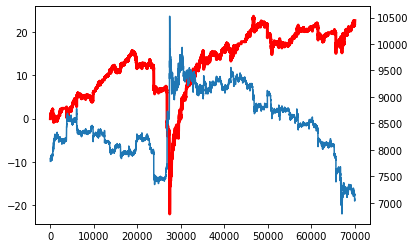

<Figure size 6000x6000 with 0 Axes>

test period= 2019-10-07 09:37:00  -  2019-11-25 00:17:00
total pl=22.628200000000003,num trade=212,win rate=0.8491, pl_stability=2.4503, num_buy=92, num_sell=119
strategy performance=55.44587846


,i,dt,action,holding_side,holding_price,holding_size,order_side,order_price,order_size,total_pl,num_trade
0,0,2019-10-07 09:37:00,entry orderbuy type=market,,0.0,0.00,buy,0,0.01,0.0000,0
1,1,2019-10-07 09:38:00,New Entry:market,buy,7782.0,0.01,buy,0,0.01,0.0000,0
2,4,2019-10-07 09:41:00,pl executed.,buy,7782.0,0.01,0,0,0.00,0.3750,0
3,4,2019-10-07 09:41:00,entry ordersell type=market,,0.0,0.00,sell,0,0.01,0.3750,1
4,5,2019-10-07 09:42:00,New Entry:market,sell,7844.0,0.01,sell,0,0.01,0.4883,1
...,...,...,...,...,...,...,...,...,...,...,...
554,69961,2019-11-24 23:38:00,pl executed.,sell,7160.5,0.01,0,0,0.00,21.8745,209
555,69984,2019-11-25 00:01:00,entry orderbuy type=market,,0.0,0.00,buy,0,0.01,22.1388,210
556,69985,2019-11-25 00:02:00,New Entry:market,buy,7049.5,0.01,buy,0,0.01,22.1388,210
557,69993,2019-11-25 00:10:00,pl executed.,buy,7049.5,0.01,0,0,0.00,22.5238,210


In [48]:
'''
conti sim
'''

import time
num_term = 4
corr_kijun = 0.7
upper_kijun = 0.7
#lower_kijun = 0.4
from_ind = 40000
to_ind = 144000

train_len = 30000
test_len = 70000
test_start_ind = 30000 #should be larger than train_len
valid_size = 0.05

kijun_val =50
kijun_period = 120
pt = kijun_val
lc = 10000
random_state = None

params = {'objective': 'multiclass', 'num_class':4, 'metric':'multi_logloss', 'boosting': 'gbdt', 'learning_rate': 0.1, 'num_iterations': 500, 'device_type':'GPU',
          'max_depth':10, 'num_leaves':100, 'early_stopping_rounds':50, 'lambda_l1':15, 'lambda_l2':15, 'min_data_in_leaf':50, 'max_bin':100, 'bagging_freq':50}

#params= {'objective': 'multiclass', 'num_class':4, 'metric':'multi_logloss', 'boosting': 'gbdt', 'learning_rate': 0.1, 'num_iterations': 500, 'device_type':'GPU',
#         'max_depth': 4, 'max_bin': 91, 'num_leaves': 8, 'min_data_in_leaf': 17, 'min_sum_hessian_in_leaf': 6.133025767545423, 'bagging_fraction': 0.9714308832700951, 
#              'bagging_freq': 57, 'feature_fraction': 0.4852018661919656, 'lambda_l1': 9, 'lambda_l2': 45, 'min_gain_to_split': 65}

cat_params = {'task_type': 'GPU','verbose': True, 'loss_function':'MultiClass', 'num_boost_round':1000, 'early_stopping_rounds':50, 'depth':10, 'learning_rate':0.1}

start = time.time()
OneMinMarketData.initialize_for_bot(num_term, from_ind, to_ind, kijun_val, kijun_period)
df = OneMinMarketData.genrate_df_from_dict()
df = OneMinMarketData.remove_cols_contains_nan2(df)
#df = OneMinMarketData.remove_all_correlated_cols4(df, corr_kijun)
df2 = OneMinMarketData.remove_price_dependent_cols2(df, corr_kijun)

sim = Sim()
ac = SimAccount()
start_ind_log = 0
end_ind_log = 0

for i in range(1):
    lgbmodel = LgbModel()
    catmodel = CatboostModel()
    train_df = df2.iloc[test_start_ind - train_len + (test_len * i):(test_len * i) + test_start_ind]
    test_df = df2.iloc[kijun_period + (test_len * i) + test_start_ind:kijun_period + test_start_ind + (test_len * i) + test_len]
    print('generating bpsp data2')
    train_xb, test_xb, train_yb, test_yb, valid_xb, valid_yb = lgbmodel.generate_bpsp_data2(train_df, test_df, valid_size, random_state)
    
    cols = list(train_xb.columns)
    remove_cols = ['open', 'high', 'low', 'close', 'open_change', 'high_change' , 'low_change', 'close_change', 'dt']

    for col in remove_cols:
        if col in cols:
            cols.remove(col)
    cols.sort()
    train_xb = train_xb.loc[:,cols]
    test_xb = test_xb.loc[:,cols]
    valid_xb = valid_xb.loc[:,cols]
    print('removed unsed index')

    if list(train_xb.columns) == list(test_xb.columns) == list(valid_xb.columns):
        pass
    else:
        print('train col, test col, valid col are not matched!')

    model = lgbmodel.train_params_with_validations(train_xb, train_yb, valid_xb, valid_yb, params)
    #model = catmodel.param_train(train_xb, train_yb, cat_params)
    prediction = lgbmodel.bpsp_prediction(model, train_xb, upper_kijun)
    #prediction = lgbmodel.bpsp_prediction2(model, train_xb)
    #prediction = catmodel.predict(model, train_xb, train_yb)
    print('train accuracy={}'.format(lgbmodel.calc_bpsp_accuracy(prediction, train_yb)))
    prediction = lgbmodel.bpsp_prediction(model, test_xb, upper_kijun)
    #prediction = lgbmodel.bpsp_prediction2(model, test_xb)
    #prediction = catmodel.predict(model, test_xb, test_yb)
    print('test accuracy={}'.format(lgbmodel.calc_bpsp_accuracy(prediction, test_yb)))

    start_ind = OneMinMarketData.check_matched_dt(test_xb, df2)
    ac = sim.sim_model_pred_onemin(start_ind, prediction, pt, lc, ac)
    print('total pl={},num trade={},win rate={}, pl_stability={}, num_buy={}, num_sell={}'.format(ac.total_pl,ac.num_trade,ac.win_rate, ac.pl_stability, ac.num_buy,ac.num_sell))
    print('strategy performance={}'.format(ac.total_pl * ac.pl_stability))

    if i is 0:
        start_ind_log = start_ind
    else:
        end_ind_log = start_ind

if end_ind_log is 0:
    end_ind_log = start_ind_log

with open('/content/drive/My Drive/Model/bpsp_cols.csv', 'w') as file:
    writer = csv.writer(file, lineterminator='\n')
    writer.writerow(train_xb)

with open('/content/drive/My Drive/Model/lgb_bpsp_model.dat', 'wb') as f:
    pickle.dump(model, f)

fig, ax1 = plt.subplots()
plt.figure(figsize=(30,30),dpi=200)
ax1.plot(ac.performance_total_pl_log,color='red',linewidth = 3.0,label='pl')
ax2 = ax1.twinx()
ax2.plot(OneMinMarketData.ohlc.close[start_ind_log:end_ind_log + test_len])
plt.show()
print('test period=', OneMinMarketData.ohlc.dt[start_ind_log], ' - ', OneMinMarketData.ohlc.dt[end_ind_log + test_len])
print('total pl={},num trade={},win rate={}, pl_stability={}, num_buy={}, num_sell={}'.format(ac.total_pl,ac.num_trade,ac.win_rate, ac.pl_stability, ac.num_buy,ac.num_sell))
print('strategy performance={}'.format(ac.total_pl * ac.pl_stability))
ac.log_data_df

In [34]:
if True in df.isnull().any():
    print('no')
else:
    print('ok')

ok


In [36]:
np.isinf(df2)

TypeError: ignored

In [0]:
importance = pd.DataFrame(model.feature_importance(), index=list(train_xb.columns), columns=['importance'])
importance.sort_values('importance', ascending=False)[:50]

In [43]:
OneMinMarketData.term_list[-1]

1450

total pl=26.368300000000005,num trade=183,win rate=0.8306, pl_stability=1.9563, num_buy=81, num_sell=102
strategy performance=51.58430529000001


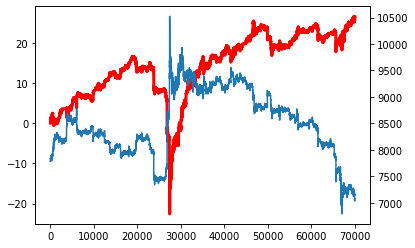

<Figure size 6000x6000 with 0 Axes>

test period= 2019-10-07 09:37:00  -  2019-11-25 00:17:00
total pl=26.368300000000005,num trade=183,win rate=0.8306, pl_stability=1.9563, num_buy=81, num_sell=102
strategy performance=51.58430529000001


In [49]:
prediction = lgbmodel.bpsp_prediction(model, test_xb, 0.7)
#prediction = lgbmodel.bpsp_prediction2(model, test_xb)
sim = Sim()
ac = SimAccount()
ac = sim.sim_model_pred_onemin(start_ind, prediction, 70, lc, ac)
print('total pl={},num trade={},win rate={}, pl_stability={}, num_buy={}, num_sell={}'.format(ac.total_pl,ac.num_trade,ac.win_rate, ac.pl_stability, ac.num_buy,ac.num_sell))
print('strategy performance={}'.format(ac.total_pl * ac.pl_stability))

if i is 0:
    start_ind_log = start_ind
else:
    end_ind_log = start_ind

if end_ind_log is 0:
    end_ind_log = start_ind_log

with open('/content/drive/My Drive/Model/bpsp_cols.csv', 'w') as file:
    writer = csv.writer(file, lineterminator='\n')
    writer.writerow(train_xb)

with open('/content/drive/My Drive/Model/lgb_bpsp_model.dat', 'wb') as f:
    pickle.dump(model, f)

fig, ax1 = plt.subplots()
plt.figure(figsize=(30,30),dpi=200)
ax1.plot(ac.performance_total_pl_log,color='red',linewidth = 3.0,label='pl')
ax2 = ax1.twinx()
ax2.plot(OneMinMarketData.ohlc.close[start_ind_log:end_ind_log + test_len])
plt.show()
print('test period=', OneMinMarketData.ohlc.dt[start_ind_log], ' - ', OneMinMarketData.ohlc.dt[end_ind_log + test_len])
print('total pl={},num trade={},win rate={}, pl_stability={}, num_buy={}, num_sell={}'.format(ac.total_pl,ac.num_trade,ac.win_rate, ac.pl_stability, ac.num_buy,ac.num_sell))
print('strategy performance={}'.format(ac.total_pl * ac.pl_stability))

In [0]:
c= [] 
for i in range(len(ac.performance_total_pl_log) - 120):
    c.append(ac.performance_total_pl_log[i+120] - ac.performance_total_pl_log[i])

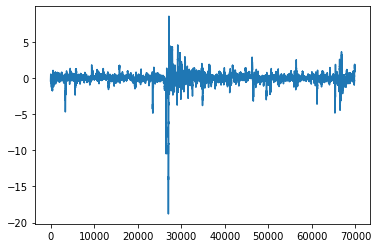

In [52]:
plt.plot(c)

In [0]:

cut_size = OneMinMarketData.term_list[-1] + 1
end = len(OneMinMarketData.ohlc.close) - OneMinMarketData.kijun_period #due to bpsp
OneMinMarketData.ohlc.index_data_dict['dt'] = OneMinMarketData.ohlc.dt
OneMinMarketData.ohlc.index_data_dict['size'] = OneMinMarketData.ohlc.size
OneMinMarketData.ohlc.index_data_dict['close'] = OneMinMarketData.ohlc.close
df2 = pd.DataFrame(OneMinMarketData.ohlc.index_data_dict)
'''
df = df.assign(dt=cls.ohlc.dt)
df = df.assign(open=cls.ohlc.open)
df = df.assign(high=cls.ohlc.high)
df = df.assign(low=cls.ohlc.low)
df = df.assign(close=cls.ohlc.close)
df = df.assign(open_change=cls.ohlc.open_change)
df = df.assign(high_change=cls.ohlc.high_change)
df = df.assign(low_change=cls.ohlc.low_change)
df = df.assign(close_change=cls.ohlc.close_change)
df = df.assign(size=cls.ohlc.size)
'''
df2 = df2.iloc[cut_size:end] 
#df['future_side'] = OneMinMarketData.ohlc.future_side[cut_size:]
df2 = df2.assign(future_side=OneMinMarketData.ohlc.future_side[cut_size:])

In [21]:
type(datetime.now().minute)

int

In [16]:
import dateutil
dateutil.parser.parse("2019-05-12T08:0:59").minute

0